In [118]:
import re
import unicodedata

import inflect
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import plotly.express as px
import scipy.cluster.hierarchy as shc
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import LancasterStemmer, PorterStemmer, WordNetLemmatizer
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from textblob import TextBlob
from wordcloud import WordCloud
from yellowbrick.cluster import KElbowVisualizer

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [348]:
df2=pd.read_csv('Zomato Restaurant names and Metadata.csv')
df1=pd.read_csv('Zomato Restaurant reviews (1).csv')

In [349]:
df1.head()

Restaurant              Reviewer  \
0  Beyond Flavours     Rusha Chakraborty   
1  Beyond Flavours  Anusha Tirumalaneedi   
2  Beyond Flavours       Ashok Shekhawat   
3  Beyond Flavours        Swapnil Sarkar   
4  Beyond Flavours                Dileep   

                                              Review Rating  \
0  The ambience was good, food was quite good . h...      5   
1  Ambience is too good for a pleasant evening. S...      5   
2  A must try.. great food great ambience. Thnx f...      5   
3  Soumen das and Arun was a great guy. Only beca...      5   
4  Food is good.we ordered Kodi drumsticks and ba...      5   

                  Metadata             Time  Pictures  
0   1 Review , 2 Followers  5/25/2019 15:54         0  
1  3 Reviews , 2 Followers  5/25/2019 14:20         0  
2  2 Reviews , 3 Followers  5/24/2019 22:54         0  
3    1 Review , 1 Follower  5/24/2019 22:11         0  
4  3 Reviews , 2 Followers  5/24/2019 21:37         0

In [350]:
df1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Restaurant  10000 non-null  object
 1   Reviewer    9962 non-null   object
 2   Review      9955 non-null   object
 3   Rating      9962 non-null   object
 4   Metadata    9962 non-null   object
 5   Time        9962 non-null   object
 6   Pictures    10000 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 547.0+ KB


In [351]:
df1.head()

Restaurant              Reviewer  \
0  Beyond Flavours     Rusha Chakraborty   
1  Beyond Flavours  Anusha Tirumalaneedi   
2  Beyond Flavours       Ashok Shekhawat   
3  Beyond Flavours        Swapnil Sarkar   
4  Beyond Flavours                Dileep   

                                              Review Rating  \
0  The ambience was good, food was quite good . h...      5   
1  Ambience is too good for a pleasant evening. S...      5   
2  A must try.. great food great ambience. Thnx f...      5   
3  Soumen das and Arun was a great guy. Only beca...      5   
4  Food is good.we ordered Kodi drumsticks and ba...      5   

                  Metadata             Time  Pictures  
0   1 Review , 2 Followers  5/25/2019 15:54         0  
1  3 Reviews , 2 Followers  5/25/2019 14:20         0  
2  2 Reviews , 3 Followers  5/24/2019 22:54         0  
3    1 Review , 1 Follower  5/24/2019 22:11         0  
4  3 Reviews , 2 Followers  5/24/2019 21:37         0

## EDA- ON Review Data

In [352]:
df1.describe(include='all')


Restaurant     Reviewer Review Rating  Metadata             Time  \
count             10000         9962   9955   9962      9962             9962   
unique              100         7446   9364     10      2477             9782   
top     Beyond Flavours  Parijat Ray   good      5  1 Review  7/29/2018 20:34   
freq                100           13    237   3832       919                3   
mean                NaN          NaN    NaN    NaN       NaN              NaN   
std                 NaN          NaN    NaN    NaN       NaN              NaN   
min                 NaN          NaN    NaN    NaN       NaN              NaN   
25%                 NaN          NaN    NaN    NaN       NaN              NaN   
50%                 NaN          NaN    NaN    NaN       NaN              NaN   
75%                 NaN          NaN    NaN    NaN       NaN              NaN   
max                 NaN          NaN    NaN    NaN       NaN              NaN   

            Pictures  
count   10000.000000  
unique           NaN  
top              NaN  
freq             NaN  
mean        0.748600  
std         2.570381  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max        64.000000

In [356]:
df1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Restaurant  10000 non-null  object
 1   Reviewer    9962 non-null   object
 2   Review      9955 non-null   object
 3   Rating      9962 non-null   object
 4   Metadata    9962 non-null   object
 5   Time        9962 non-null   object
 6   Pictures    10000 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 547.0+ KB


In [357]:
reviews_df = df1.copy()


In [358]:
reviews_df.isnull().sum()


Restaurant     0
Reviewer      38
Review        45
Rating        38
Metadata      38
Time          38
Pictures       0
dtype: int64

In [359]:
reviews_df.dropna(inplace= True)


In [360]:
reviews_df['Rating'].unique()


array(['5', '4', '1', '3', '2', '3.5', '4.5', '2.5', '1.5', 'Like'],
      dtype=object)

In [361]:
reviews_df.Rating.value_counts()


5       3826
4       2373
1       1735
3       1192
2        684
4.5       69
3.5       47
2.5       19
1.5        9
Like       1
Name: Rating, dtype: int64

## Like is only 1, we can drop it to convert Rating to float dType.

In [362]:
reviews_df=reviews_df[reviews_df['Rating']!='Like']


In [363]:

reviews_df['Rating'] = reviews_df['Rating'].astype('float64')
reviews_df['Reviews'], reviews_df['Followers'] = reviews_df['Metadata'].str.split(
    ',').str
reviews_df['Reviews'] = pd.to_numeric(
    reviews_df['Reviews'].str.split(' ').str[0])
reviews_df['Followers'] = pd.to_numeric(
    reviews_df['Followers'].str.split(' ').str[1])
reviews_df['Time'] = pd.to_datetime(reviews_df['Time'])
reviews_df['Year'] = pd.DatetimeIndex(reviews_df['Time']).year
reviews_df['Hour'] = pd.DatetimeIndex(reviews_df['Time']).hour
reviews_df = reviews_df.drop(['Metadata'], axis=1)

In [367]:
reviews_df.head(5)


Restaurant              Reviewer  \
0  Beyond Flavours     Rusha Chakraborty   
1  Beyond Flavours  Anusha Tirumalaneedi   
2  Beyond Flavours       Ashok Shekhawat   
3  Beyond Flavours        Swapnil Sarkar   
4  Beyond Flavours                Dileep   

                                              Review  Rating  \
0  The ambience was good, food was quite good . h...     5.0   
1  Ambience is too good for a pleasant evening. S...     5.0   
2  A must try.. great food great ambience. Thnx f...     5.0   
3  Soumen das and Arun was a great guy. Only beca...     5.0   
4  Food is good.we ordered Kodi drumsticks and ba...     5.0   

                 Time  Pictures  Reviews  Followers  Year  Hour  
0 2019-05-25 15:54:00         0        1        2.0  2019    15  
1 2019-05-25 14:20:00         0        3        2.0  2019    14  
2 2019-05-24 22:54:00         0        2        3.0  2019    22  
3 2019-05-24 22:11:00         0        1        1.0  2019    22  
4 2019-05-24 21:37:00         0        3        2.0  2019    21

In [368]:
reviews_df.Year.unique()


array([2019, 2018, 2017, 2016], dtype=int64)

In [124]:
df1.shape,df2.shape


((10000, 7), (105, 6))

In [125]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         105 non-null    object
 1   Links        105 non-null    object
 2   Cost         105 non-null    object
 3   Collections  51 non-null     object
 4   Cuisines     105 non-null    object
 5   Timings      104 non-null    object
dtypes: object(6)
memory usage: 5.0+ KB


In [369]:
reviews_df.groupby(['Restaurant'])['Rating'].mean().sort_values(ascending=False).reset_index()


Restaurant  Rating
0        AB's - Absolute Barbecues   4.880
1                           B-Dubs   4.810
2   3B's - Buddies, Bar & Barbecue   4.760
3                         Paradise   4.700
4                         Flechazo   4.660
..                             ...     ...
95                 Behrouz Biryani   2.825
96                   Mathura Vilas   2.820
97                   Pakwaan Grand   2.710
98                  Asian Meal Box   2.580
99                Hotel Zara Hi-Fi   2.400

[100 rows x 2 columns]

Text(0.5, 1.0, 'Top Rated 10 Restaurants')

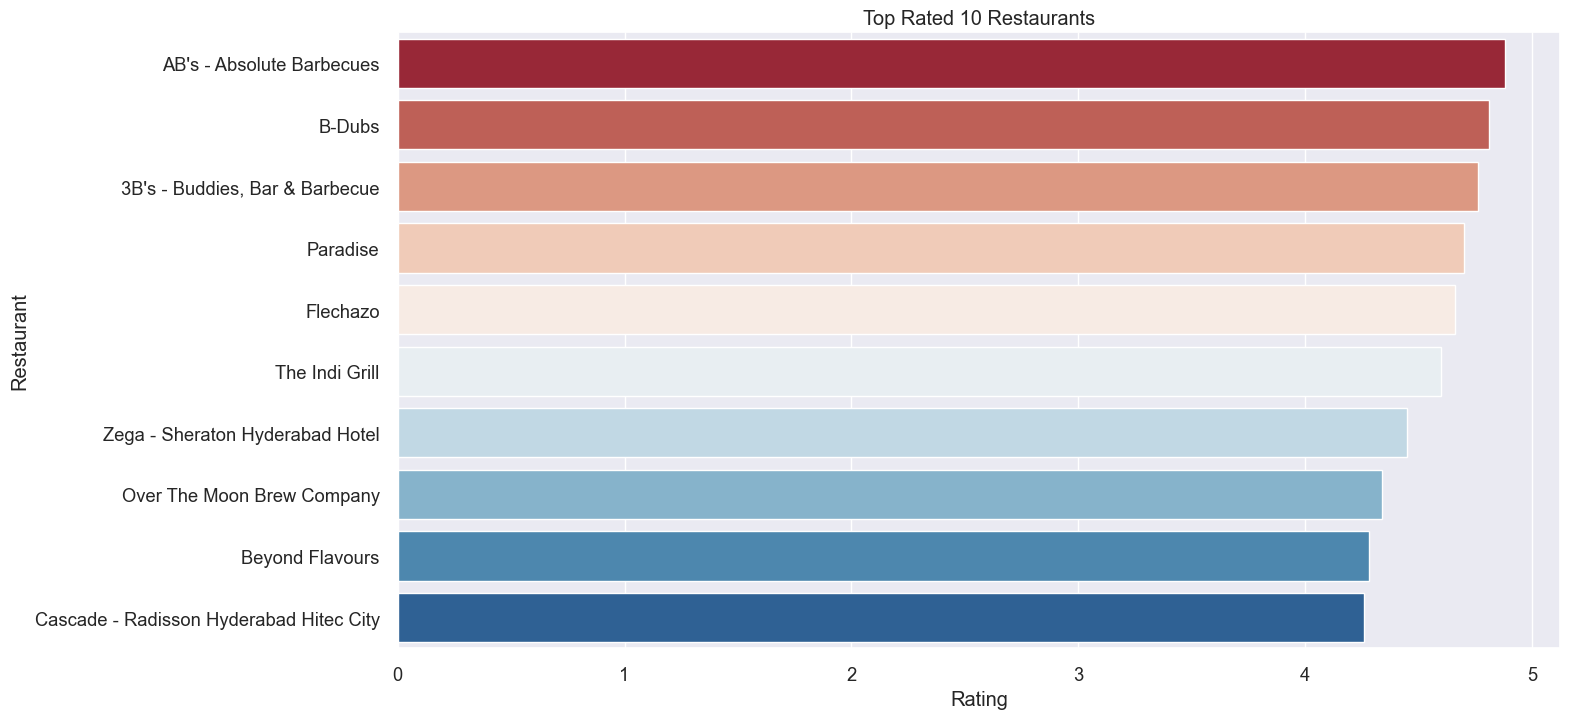

In [370]:
df_rating = reviews_df.groupby(['Restaurant'])['Rating'].mean().sort_values(ascending=False).reset_index()
df_rating = df_rating.sort_values(by='Rating', ascending=False).head(10)

plt.figure(figsize=(15,8))
sns.barplot(data=df_rating, x='Rating', y='Restaurant', palette='RdBu')
plt.title('Top Rated 10 Restaurants')

In [371]:

yw_avg_rating = reviews_df.groupby(['Restaurant', 'Year'])['Rating'].mean().sort_values(ascending = False).reset_index()
twenty_ninteen = yw_avg_rating[yw_avg_rating.Year == 2019].head(10)
twenty_ninteen

Restaurant  Year    Rating
0                 AB's - Absolute Barbecues  2019  4.880000
1                                    B-Dubs  2019  4.810000
2            3B's - Buddies, Bar & Barbecue  2019  4.760000
3                                  Paradise  2019  4.700000
4                                  Flechazo  2019  4.660000
5   Cascade - Radisson Hyderabad Hitec City  2019  4.641509
7                            The Indi Grill  2019  4.600000
8                            Karachi Bakery  2019  4.538462
10          Zega - Sheraton Hyderabad Hotel  2019  4.409091
12               Over The Moon Brew Company  2019  4.340000

## Above listed restaurants are top 10 restaurants in 2019.

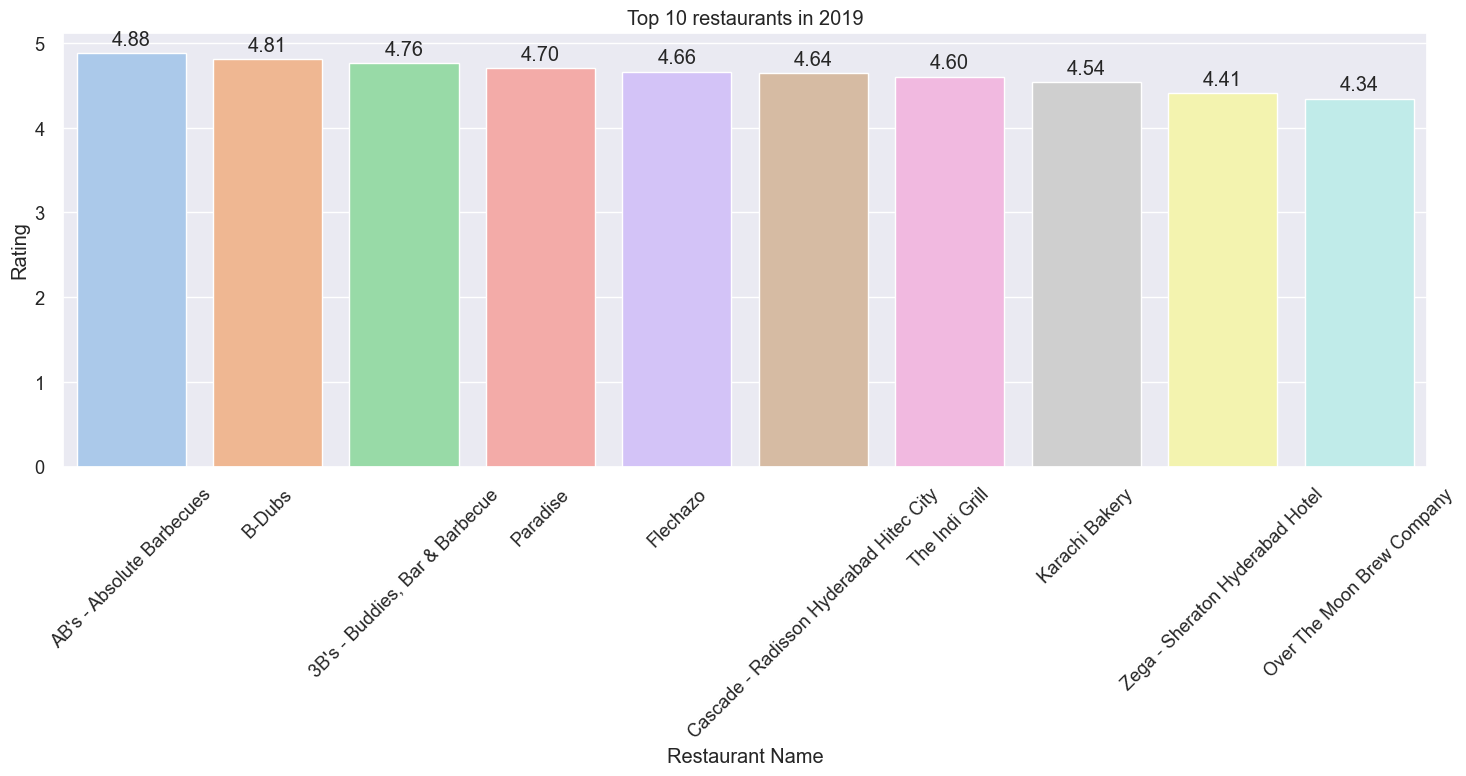

In [374]:

plt.figure(figsize=(15, 8))

# Assuming 'twenty_ninteen' DataFrame has columns 'Restaurant' and 'Rating'
plot = sns.barplot(x='Restaurant', y='Rating', data=twenty_ninteen, palette='pastel')

# Annotate bar heights
for p in plot.patches:
    plt.annotate(format(p.get_height(), '.2f'), 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.ylabel('Rating')
plt.xlabel('Restaurant Name')
plt.xticks(rotation=45)
plt.title('Top 10 restaurants in 2019')
plt.tight_layout()

# Show the plot
plt.show()


In [375]:

twenty_eighteen = yw_avg_rating[yw_avg_rating.Year == 2018].head(10)
twenty_eighteen

Restaurant  Year    Rating
6          Feast - Sheraton Hyderabad Hotel  2018  4.629630
9           Zega - Sheraton Hyderabad Hotel  2018  4.461538
11    Mazzo - Marriott Executive Apartments  2018  4.375000
14                        Hyderabadi Daawat  2018  4.296296
21  Cascade - Radisson Hyderabad Hitec City  2018  4.211538
23                      NorFest - The Dhaba  2018  4.166667
25                          Barbeque Nation  2018  4.072464
27                           Udipi's Upahar  2018  4.055556
31                      American Wild Wings  2018  4.000000
32                                     Amul  2018  3.988095

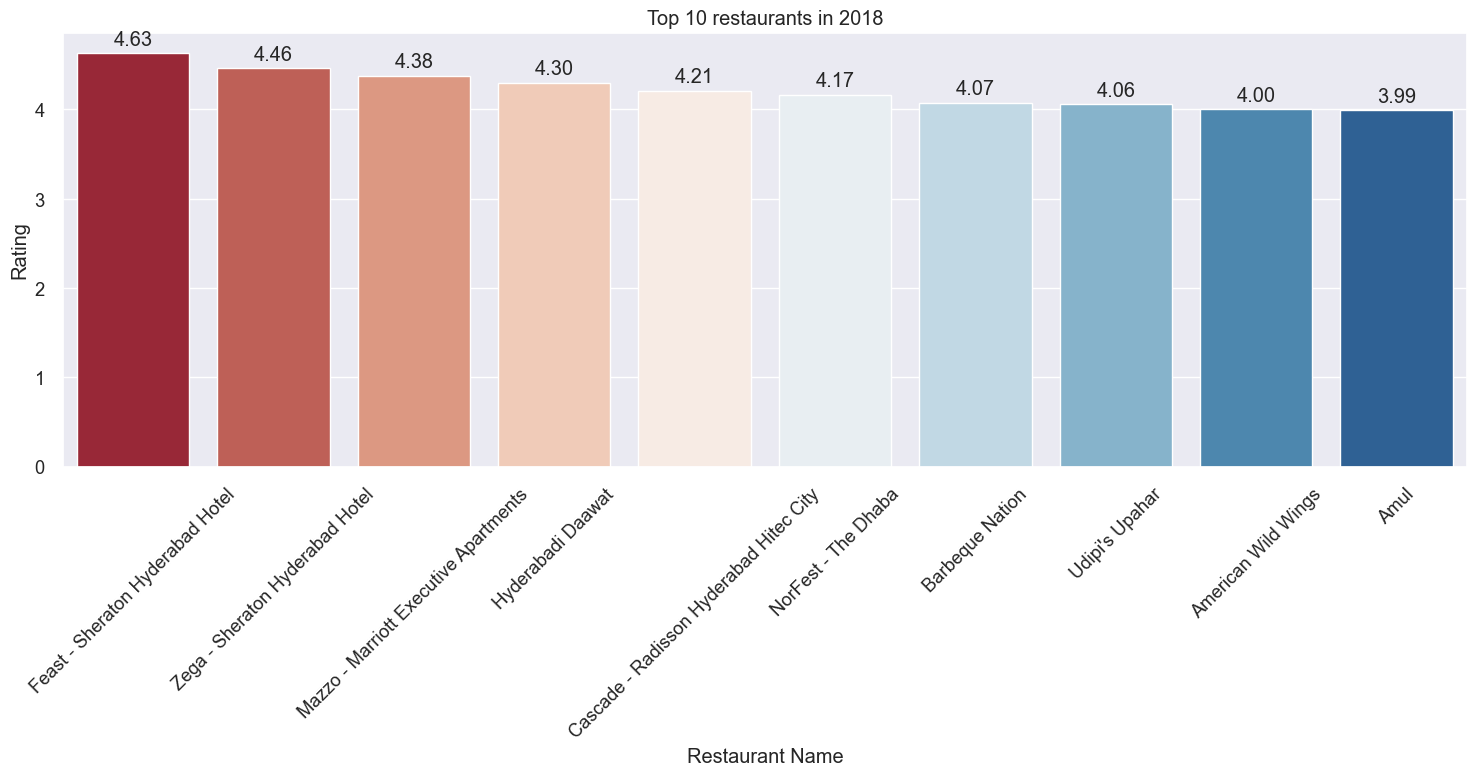

In [377]:


plt.figure(figsize=(15, 8))

# Assuming 'twenty_eighteen' DataFrame has columns 'Restaurant' and 'Rating'
plot = sns.barplot(x='Restaurant', y='Rating', data=twenty_eighteen, palette='RdBu')

# Annotate bar heights
for p in plot.patches:
    plt.annotate(format(p.get_height(), '.2f'), 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.ylabel('Rating')
plt.xlabel('Restaurant Name')
plt.xticks(rotation=45)
plt.title('Top 10 restaurants in 2018')
plt.tight_layout()

# Show the plot
plt.show()


## Top 10 restaurants in 2018.

In [378]:

twenty_seventeen = yw_avg_rating[yw_avg_rating.Year == 2017].head(10)
twenty_seventeen

Restaurant  Year    Rating
16                                 KS Bakers  2017  4.254717
41                                   Labonel  2017  3.897436
44                          Chinese Pavilion  2017  3.883333
51      Collage - Hyatt Hyderabad Gachibowli  2017  3.833333
117                           Dunkin' Donuts  2017  3.423077
118                       Al Saba Restaurant  2017  3.388889
120                                  T Grill  2017  3.382353
122  Cascade - Radisson Hyderabad Hitec City  2017  3.357143

## There are total 8 Restaurants which gets the rating in 2017.

In [379]:

twenty_sixteen = yw_avg_rating[yw_avg_rating.Year == 2016].head(10)
twenty_sixteen
     

Restaurant  Year    Rating
34           Labonel  2016  3.970588
37  Chinese Pavilion  2016  3.961538

## Labonel and Chinese Pavilion only got the rating in the year 2016.

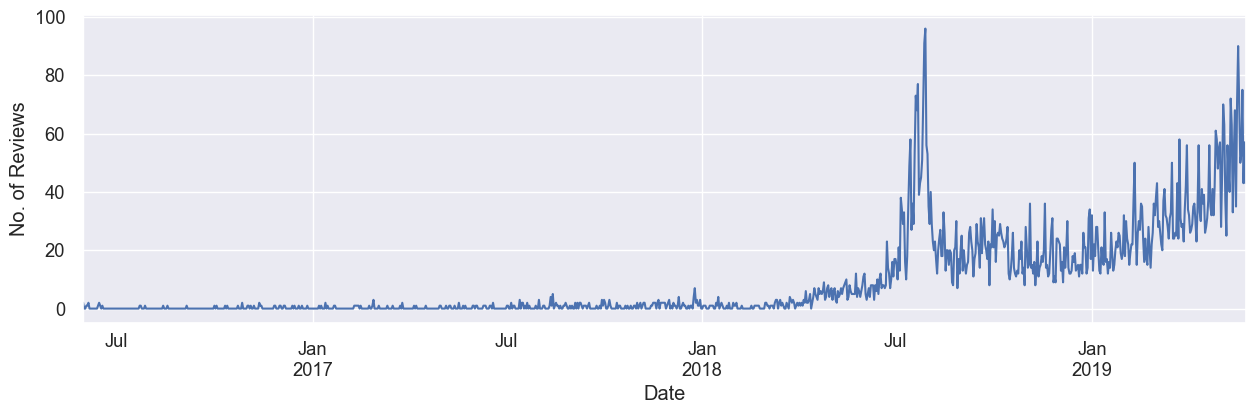

In [380]:
plt.figure(figsize=(15, 4))
reviews_df.resample('1D',on='Time')['Reviews'].size().plot.line()
plt.xlabel('Date')
plt.ylabel('No. of Reviews')
plt.show()

In [383]:

# Assuming 'meta_df' DataFrame has a column named 'Cuisines' containing comma-separated cuisine names

# Split the 'Cuisines' column into lists of cuisine names
cuisine_list = meta_df['Cuisines'].str.split(', ')

# Initialize an empty dictionary to store cuisine counts
cuis_list = {}

# Iterate through each list of cuisines
for names in cuisine_list:
    # Iterate through each cuisine name in the list
    for name in names:
        # Update the count in the dictionary
        cuis_list[name] = cuis_list.get(name, 0) + 1

# Create a DataFrame from the dictionary
cuis_df = pd.DataFrame(list(cuis_list.items()), columns=['Cuisine', 'Counts of Restaurants'])

# Sort the DataFrame by the counts in descending order
cuis_df.sort_values(by='Counts of Restaurants', ascending=False, inplace=True)

# Select the top 10 cuisines
top_10_cuis = cuis_df.head(10)

# Print the top 10 cuisines
print('The Top 10 Cuisines are:\n', top_10_cuis)

The Top 10 Cuisines are:
                            Cuisine  Counts of Restaurants
50              northindian chines                      4
16                     northindian                      3
45      northindian biryani chines                      2
26                        fastfood                      2
1       biryani northindian chines                      2
43  southindian northindian chines                      2
22                       continent                      2
9                 icecream dessert                      2
19     northindian chinese biryani                      2
18   northindian chinese continent                      2


Top 10 cuisines

In [384]:
cuis_df.reset_index(inplace=True)


In [385]:
cuis_df.head(2)


index             Cuisine  Counts of Restaurants
0     50  northindian chines                      4
1     16         northindian                      3

Text(0.5, 1.0, 'Most popular cuisines at Restaurants in Hyderabad')

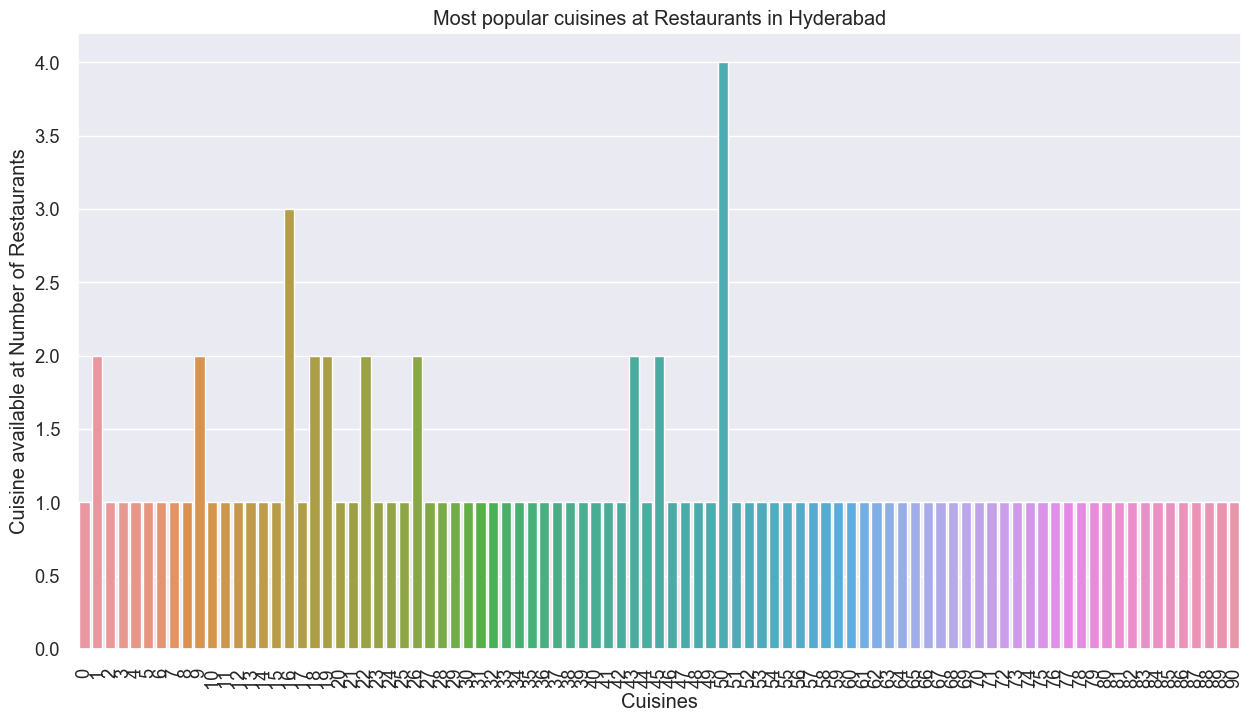

In [386]:
fig = plt.figure(figsize=[15,8])
sns.barplot(data=cuis_df, x='index', y= 'Counts of Restaurants')
plt.xlabel('Cuisines')
plt.xticks(rotation=90)
plt.ylabel('Cuisine available at Number of Restaurants')
plt.title('Most popular cuisines at Restaurants in Hyderabad')

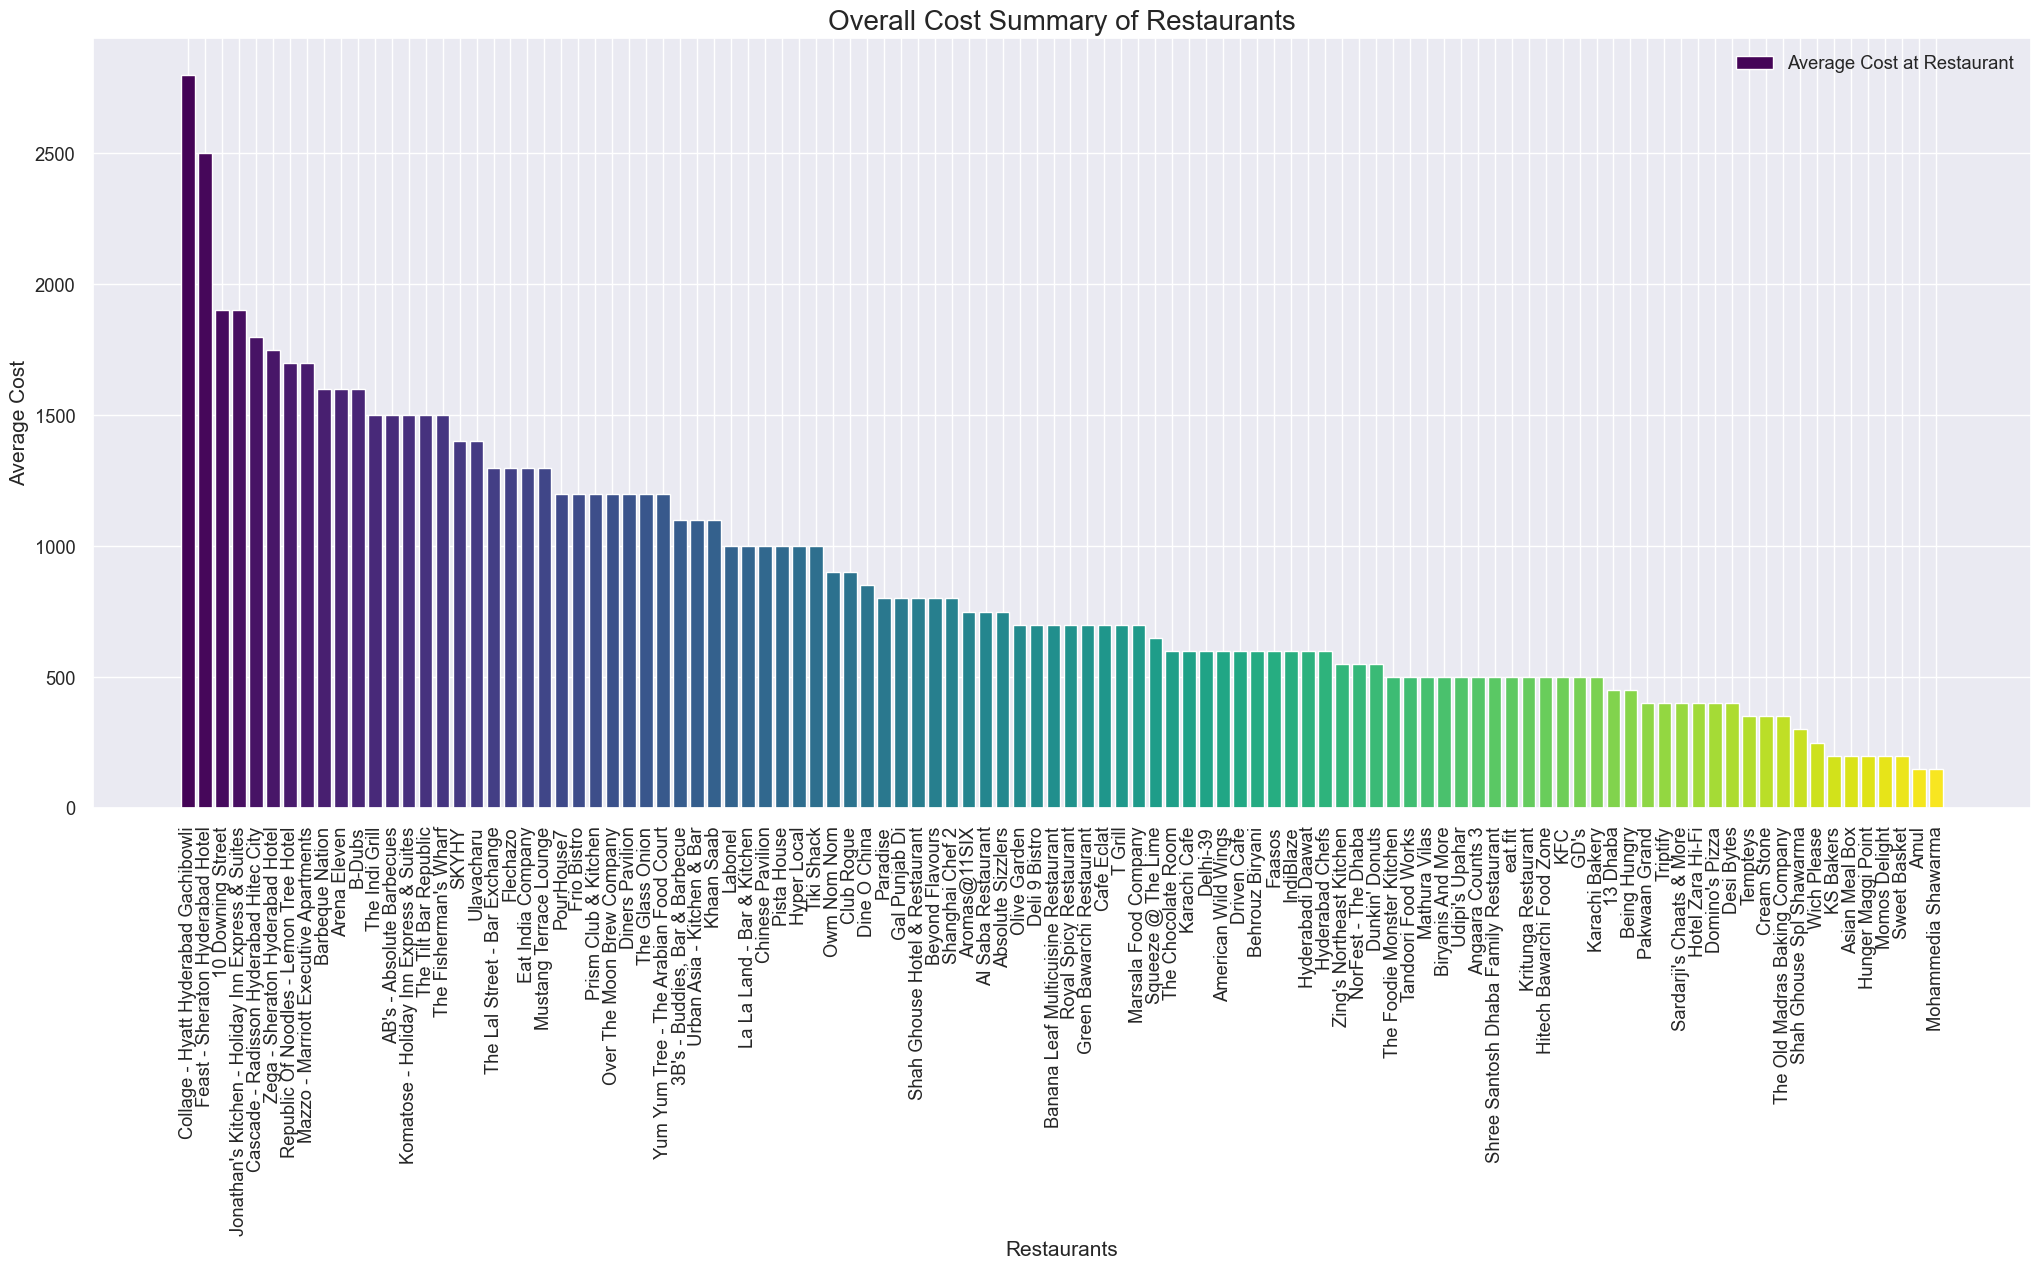

In [388]:
restaurants_cost=meta_df.groupby('Name')['Cost'].mean().reset_index(name='Cost')
restaurants_cost.sort_values(by='Cost',ascending=False,inplace=True)
plt.figure(figsize=(25,10))
plt.bar(restaurants_cost['Name'],restaurants_cost['Cost'], color = sns.color_palette("viridis", len(restaurants_cost['Name'])))
plt.xlabel('Restaurants',size=15)
plt.xticks(rotation=90)
plt.ylabel('Average Cost',size=15)
plt.title('Overall Cost Summary of Restaurants',size=20)
plt.legend(['Average Cost at Restaurant'])
     

10 most Expensive Restaurants

In [389]:
restaurants_cost.tail(10)


Name   Cost
92  The Old Madras Baking Company  350.0
78       Shah Ghouse Spl Shawarma  300.0
99                    Wich Please  250.0
50                      KS Bakers  200.0
11                 Asian Meal Box  200.0
43             Hunger Maggi Point  200.0
62                  Momos Delight  200.0
82                   Sweet Basket  200.0
7                            Amul  150.0
61            Mohammedia Shawarma  150.0

Text(0.5, 1.0, '10 Most cheap Restaurants')

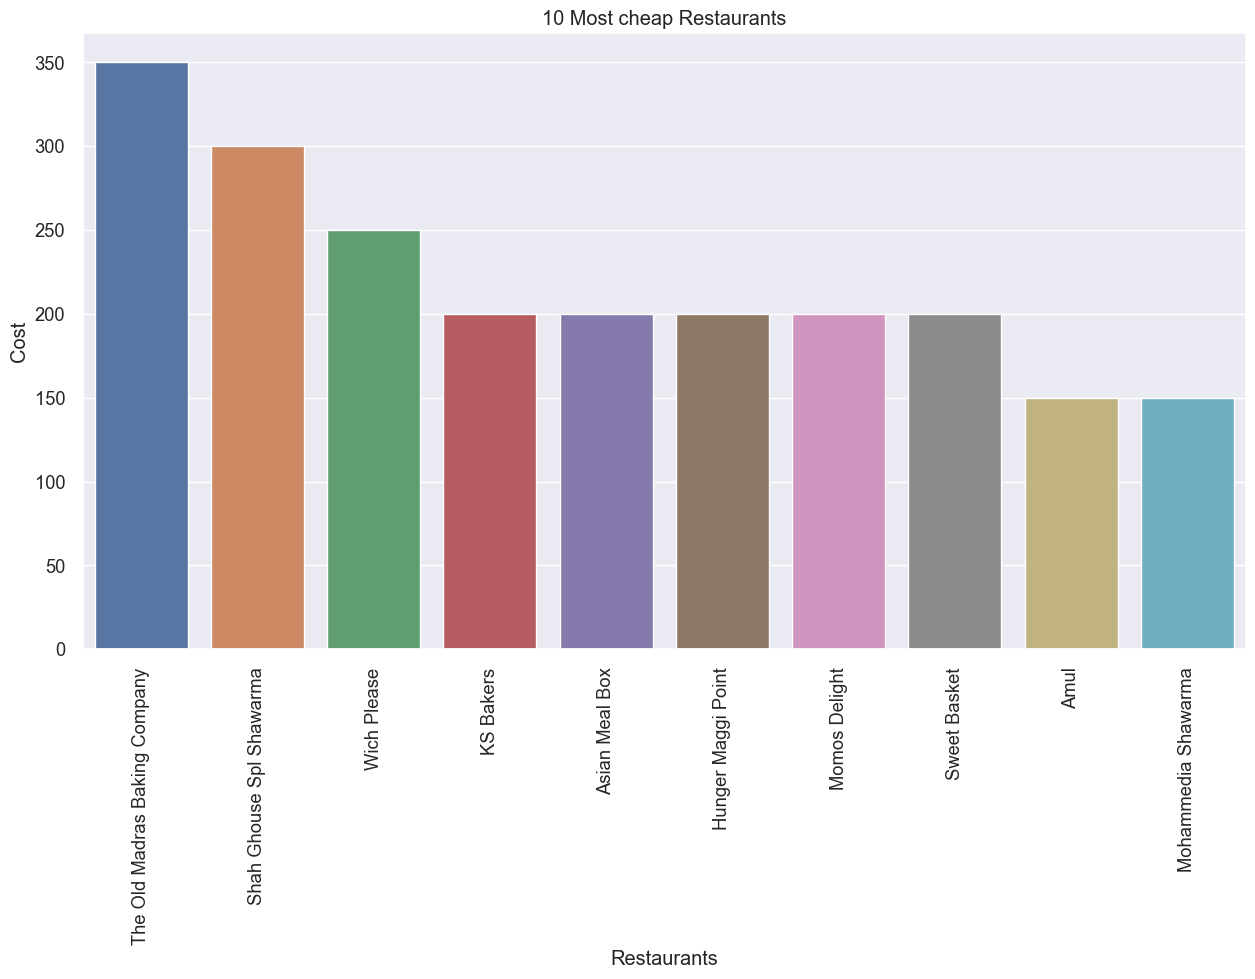

In [390]:

fig = plt.figure(figsize=[15,8])
sns.barplot(data=restaurants_cost.tail(10), x='Name', y= 'Cost')
plt.xlabel('Restaurants')
plt.xticks(rotation=90)
plt.ylabel('Cost')
plt.title('10 Most cheap Restaurants')

## Performing Clustering

In [392]:
time_opened_weekly = [52.5,84,66.5,98,79,73.5,105,84,84,106.5,49,59.5,94.5,
                      84,66.5,84,73.5,94.5,84,77,57,52.5,88.5,133,86,78.5,72.5,
                      63,105,97,np.nan,91,63,91,126,77,46.2,56,79,73.5,77,84,
                      84,126,80.5,80.5,80.5,77,115.5,61.25,56,77,84,59.5,86,108.5,
                      71,52.5,94.5,91,86,49,87.5,80.5,73.5,70,87.5,84,84,77,49,49,
                      54,140,112,87.5,112,73.5,56,52.5,86,84,122.5,122.5,49,56,
                      98,112,84,84,84,168,168,59.5,91,78,77,98,84,52.5,84,91.5,77,115.5,59.5]

In [393]:
df2["time_opened_weekly(hours)"] = time_opened_weekly


In [394]:
df2['Cuisines'] = df2['Cuisines'].apply(lambda x : x.lower())

In [395]:
d=df2.copy()


In [396]:
d=d.loc[:,['Name','Cost','Cuisines','time_opened_weekly(hours)']]


In [397]:

def cuisine_list(cuisines):
  
   
   all_cuisines = list(set(cuisines.split(', ')))
   return all_cuisines

In [398]:
d['cuisine']=d['Cuisines'].apply(lambda x:cuisine_list(x))


Time duration of each restaurant per week



In [399]:
d.head()


Name   Cost  \
0                 Beyond Flavours    800   
1                        Paradise    800   
2                        Flechazo  1,300   
3  Shah Ghouse Hotel & Restaurant    800   
4      Over The Moon Brew Company  1,200   

                                            Cuisines  \
0  chinese, continental, kebab, european, south i...   
1                     biryani, north indian, chinese   
2       asian, mediterranean, north indian, desserts   
3  biryani, north indian, chinese, seafood, bever...   
4  asian, continental, north indian, chinese, med...   

   time_opened_weekly(hours)  \
0                       52.5   
1                       84.0   
2                       66.5   
3                       98.0   
4                       79.0   

                                             cuisine  
0  [continental, chinese, south indian, north ind...  
1                   [north indian, biryani, chinese]  
2     [asian, north indian, desserts, mediterranean]  
3  [biryani, chinese, north indian, seafood, beve...  
4  [asian, continental, chinese, north indian, me...

In [400]:
d=d.explode('cuisine')
d.head()

Name Cost                                           Cuisines  \
0  Beyond Flavours  800  chinese, continental, kebab, european, south i...   
0  Beyond Flavours  800  chinese, continental, kebab, european, south i...   
0  Beyond Flavours  800  chinese, continental, kebab, european, south i...   
0  Beyond Flavours  800  chinese, continental, kebab, european, south i...   
0  Beyond Flavours  800  chinese, continental, kebab, european, south i...   

   time_opened_weekly(hours)       cuisine  
0                       52.5   continental  
0                       52.5       chinese  
0                       52.5  south indian  
0                       52.5  north indian  
0                       52.5      european

In [401]:
set(d["cuisine"])


{'american',
 'andhra',
 'arabian',
 'asian',
 'bakery',
 'bbq',
 'beverages',
 'biryani',
 'burger',
 'cafe',
 'chinese',
 'continental',
 'desserts',
 'european',
 'fast food',
 'finger food',
 'goan',
 'healthy food',
 'hyderabadi',
 'ice cream',
 'indonesian',
 'italian',
 'japanese',
 'juices',
 'kebab',
 'lebanese',
 'malaysian',
 'mediterranean',
 'mexican',
 'mithai',
 'modern indian',
 'momos',
 'mughlai',
 'north eastern',
 'north indian',
 'pizza',
 'salad',
 'seafood',
 'south indian',
 'spanish',
 'street food',
 'sushi',
 'thai',
 'wraps'}

### Binning all the cuisines into their respective supersets spicy food, Healthy food, Fast Food,Desser

In [402]:
l=[]
for i in d['cuisine']:   
  if (i=='hyderabadi')| (i=='asian')|(i=='kebab')|(i=='north indian')|(i=='modern indian')|(i=='continental')|(i=='bbq')|(i=='biryani')|(i=='indonesian')|(i=='mughlai')|(i=='malaysian'):
    l.append('spicy food')
  if (i=='andhra')|(i=='north eastern')|(i=='lebanese')|(i=='salad')|(i=='south indian')|(i=='italian')|(i=='european')|(i=='mediterranean')|(i=='american')|(i=='thai')|(i=='arabian')|(i=='seafood')|(i=='mexican')|(i=='healthy food')|(i=='goan')|(i=='spanish'):
    l.append('Healthy food')
  if (i=='momos')|(i=='street food')|(i=='cafe')|(i=='chinese')|(i=='japanese')|(i=='pizza')|(i=='wraps')|(i=='burger')|(i=='fast food')|(i=='finger food')|(i=='sushi'):
    l.append('fast food')
  if (i=='bakery')|(i=='beverages')|(i=='desserts')|(i=='juices')|(i=='ice cream')|(i=='mithai'):
    l.append('Dessert')

In [403]:

superset_cuisine=pd.DataFrame(l)
superset_cuisine.columns=['cuisine']
superset_cuisine

cuisine
0      spicy food
1       fast food
2    Healthy food
3      spicy food
4    Healthy food
..            ...
308     fast food
309    spicy food
310    spicy food
311     fast food
312  Healthy food

[313 rows x 1 columns]

In [404]:


superset_cuisine.value_counts()

cuisine     
spicy food      135
fast food        85
Healthy food     64
Dessert          29
dtype: int64

In [405]:
d.reset_index(inplace=True)


In [406]:
d.drop(['cuisine'],axis=1,inplace=True)


In [407]:
dataset=pd.concat([d,superset_cuisine],axis=1)
dataset.drop(['index'],axis=1,inplace=True)

## Making dummies of superset cuisines

In [408]:

# generate binary values using get_dummies
dum_df = pd.get_dummies(dataset, columns=["cuisine"],prefix=None)

In [409]:
dum_df


Name   Cost  \
0                           Beyond Flavours    800   
1                           Beyond Flavours    800   
2                           Beyond Flavours    800   
3                           Beyond Flavours    800   
4                           Beyond Flavours    800   
..                                      ...    ...   
308                             Wich Please    250   
309  Republic Of Noodles - Lemon Tree Hotel  1,700   
310  Republic Of Noodles - Lemon Tree Hotel  1,700   
311  Republic Of Noodles - Lemon Tree Hotel  1,700   
312  Republic Of Noodles - Lemon Tree Hotel  1,700   

                                              Cuisines  \
0    chinese, continental, kebab, european, south i...   
1    chinese, continental, kebab, european, south i...   
2    chinese, continental, kebab, european, south i...   
3    chinese, continental, kebab, european, south i...   
4    chinese, continental, kebab, european, south i...   
..                                                 ...   
308                                          fast food   
309                    thai, asian, chinese, malaysian   
310                    thai, asian, chinese, malaysian   
311                    thai, asian, chinese, malaysian   
312                    thai, asian, chinese, malaysian   

     time_opened_weekly(hours)  cuisine_Dessert  cuisine_Healthy food  \
0                         52.5                0                     0   
1                         52.5                0                     0   
2                         52.5                0                     1   
3                         52.5                0                     0   
4                         52.5                0                     1   
..                         ...              ...                   ...   
308                      115.5                0                     0   
309                       59.5                0                     0   
310                       59.5                0                     0   
311                       59.5                0                     0   
312                       59.5                0                     1   

     cuisine_fast food  cuisine_spicy food  
0                    0                   1  
1                    1                   0  
2                    0                   0  
3                    0                   1  
4                    0                   0  
..                 ...                 ...  
308                  1                   0  
309                  0                   1  
310                  0                   1  
311                  1                   0  
312                  0                   0  

[313 rows x 8 columns]

In [410]:
cuisine=list(set(dum_df.columns)-set(['Name','Cost','Cuisines','time_opened_weekly(hours)']))


In [411]:
cluster_df=dum_df.groupby(['Name','Cost','Cuisines','time_opened_weekly(hours)'])[cuisine].sum().reset_index()


## Made dummies on the basis of cuisine_Dessert, cuisine_spicy food, cuisine_fast food, cuisine_Healthy food

In [412]:
cluster_df


Name   Cost  \
0                        10 Downing Street  1,900   
1                                 13 Dhaba    450   
2           3B's - Buddies, Bar & Barbecue  1,100   
3                AB's - Absolute Barbecues  1,500   
4                        Absolute Sizzlers    750   
..                                     ...    ...   
99                             Wich Please    250   
100  Yum Yum Tree - The Arabian Food Court  1,200   
101        Zega - Sheraton Hyderabad Hotel  1,750   
102               Zing's Northeast Kitchen    550   
103                                eat.fit    500   

                                              Cuisines  \
0                   north indian, chinese, continental   
1                                         north indian   
2                north indian, mediterranean, european   
3                european, mediterranean, north indian   
4                       continental, american, chinese   
..                                                 ...   
99                                           fast food   
100                           north indian, hyderabadi   
101                                       asian, sushi   
102                               north eastern, momos   
103  healthy food, north indian, continental, south...   

     time_opened_weekly(hours)  cuisine_fast food  cuisine_spicy food  \
0                         84.0                  1                   2   
1                         57.0                  0                   1   
2                         63.0                  0                   1   
3                         66.5                  0                   1   
4                         94.5                  1                   1   
..                         ...                ...                 ...   
99                       115.5                  1                   0   
100                       84.0                  0                   2   
101                       98.0                  1                   1   
102                       59.5                  1                   0   
103                      105.0                  0                   2   

     cuisine_Healthy food  cuisine_Dessert  
0                       0                0  
1                       0                0  
2                       2                0  
3                       2                0  
4                       1                0  
..                    ...              ...  
99                      0                0  
100                     0                0  
101                     0                0  
102                     1                0  
103                     2                0  

[104 rows x 8 columns]

In [413]:

cluster_data=cluster_df.copy()

In [414]:

cluster_df.drop(['Name','Cuisines'],axis=1,inplace=True)

In [415]:
cluster_df['Cost'] = cluster_df['Cost'].str.replace(',', '')


In [416]:
cluster_df


Cost  time_opened_weekly(hours)  cuisine_fast food  cuisine_spicy food  \
0    1900                       84.0                  1                   2   
1     450                       57.0                  0                   1   
2    1100                       63.0                  0                   1   
3    1500                       66.5                  0                   1   
4     750                       94.5                  1                   1   
..    ...                        ...                ...                 ...   
99    250                      115.5                  1                   0   
100  1200                       84.0                  0                   2   
101  1750                       98.0                  1                   1   
102   550                       59.5                  1                   0   
103   500                      105.0                  0                   2   

     cuisine_Healthy food  cuisine_Dessert  
0                       0                0  
1                       0                0  
2                       2                0  
3                       2                0  
4                       1                0  
..                    ...              ...  
99                      0                0  
100                     0                0  
101                     0                0  
102                     1                0  
103                     2                0  

[104 rows x 6 columns]

In [417]:
cluster_df['Cost']=cluster_df['Cost'].astype(float)


## Standardizing each of the features in the clusters

In [418]:

sc=StandardScaler()
cluster_df_sc=sc.fit_transform(cluster_df)
cluster_df_sc

array([[ 2.03660039,  0.0429132 ,  0.2546496 ,  0.71378578, -0.79123867,
        -0.45585991],
       [-0.80578127, -1.10964786, -1.13922187, -0.28937261, -0.79123867,
        -0.45585991],
       [ 0.46838982, -0.85352318, -1.13922187, -0.28937261,  1.86323945,
        -0.45585991],
       [ 1.2524951 , -0.70411712, -1.13922187, -0.28937261,  1.86323945,
        -0.45585991],
       [-0.21770231,  0.49113139,  0.2546496 , -0.28937261,  0.53600039,
        -0.45585991],
       [-0.21770231,  1.6863799 ,  0.2546496 ,  1.71694417,  0.53600039,
        -0.45585991],
       [-0.51174179,  1.23816171,  1.64852106, -1.292531  ,  1.86323945,
        -0.45585991],
       [-1.39386024,  2.13459809, -1.13922187, -1.292531  , -0.79123867,
         2.81375597],
       [-0.70776811, -0.25589893,  0.2546496 ,  0.71378578, -0.79123867,
        -0.45585991],
       [ 1.44852142,  0.0429132 , -1.13922187, -0.28937261, -0.79123867,
        -0.45585991],
       [-0.21770231,  0.19231926,  0.2546496 ,  1.

In [126]:

df2.describe(include='all')

Name                                              Links  \
count               105                                                105   
unique              105                                                105   
top     Beyond Flavours  https://www.zomato.com/hyderabad/beyond-flavou...   
freq                  1                                                  1   

       Cost                                  Collections  \
count   105                                           51   
unique   29                                           42   
top     500  Food Hygiene Rated Restaurants in Hyderabad   
freq     13                                            4   

                     Cuisines         Timings  
count                     105             104  
unique                     92              77  
top     North Indian, Chinese  11 AM to 11 PM  
freq                        4               6

In [127]:
meta_df = df2.copy()


In [128]:

meta_df.duplicated().sum()

0

In [129]:


reviews_df = df1.copy()

In [130]:
reviews_df.isnull().sum()


Restaurant     0
Reviewer      38
Review        45
Rating        38
Metadata      38
Time          38
Pictures       0
dtype: int64

In [131]:


reviews_df['Rating'].unique()

array(['5', '4', '1', '3', '2', '3.5', '4.5', '2.5', '1.5', 'Like', nan],
      dtype=object)

In [132]:

reviews_df.Rating.value_counts()

5       3832
4       2373
1       1735
3       1193
2        684
4.5       69
3.5       47
2.5       19
1.5        9
Like       1
Name: Rating, dtype: int64

In [133]:
# Null values
# Percentage of null values for each features
# print(list(df.columns))

for col in list(meta_df.columns):
  if ((meta_df[col].isnull().sum())/(len(meta_df[col]))*100) > 50:
    # print((df[col].isnull().sum())/(len(df[col]))*100)
    print('Feature with more than 50% of the observations are NULL values:',col)

# As in the feature 'Collections' more than 50% of the observations are NULL values, so feature 'Collections' is droppped

Feature with more than 50% of the observations are NULL values: Collections


In [134]:
meta_df.isnull().sum()


Name            0
Links           0
Cost            0
Collections    54
Cuisines        0
Timings         1
dtype: int64

Like is only 1, we can drop it to convert Rating to float dType.

In [135]:
reviews_df=reviews_df[reviews_df['Rating']!='Like']


Working With Meta data 

In [136]:
df2.describe()

Name                                              Links  \
count               105                                                105   
unique              105                                                105   
top     Beyond Flavours  https://www.zomato.com/hyderabad/beyond-flavou...   
freq                  1                                                  1   

       Cost                                  Collections  \
count   105                                           51   
unique   29                                           42   
top     500  Food Hygiene Rated Restaurants in Hyderabad   
freq     13                                            4   

                     Cuisines         Timings  
count                     105             104  
unique                     92              77  
top     North Indian, Chinese  11 AM to 11 PM  
freq                        4               6

In [137]:
for col in list(meta_df.columns):
  if ((meta_df[col].isnull().sum())/(len(meta_df[col]))*100) > 50:
    # print((df[col].isnull().sum())/(len(df[col]))*100)
    print('Feature with more than 50% of the observations are NULL values:',col)

# As in the feature 'Collections' more than 50% of the observations are NULL values, so feature 'Collections' is droppped

Feature with more than 50% of the observations are NULL values: Collections


In [138]:
meta_df.columns

Index(['Name', 'Links', 'Cost', 'Collections', 'Cuisines', 'Timings'], dtype='object')

In [139]:
# Dropping the 'Collections' feature
meta_df.drop(columns = 'Collections',axis =1,inplace = True)

# Removing the observations with null values in 'Timings' feature
meta_df.dropna(axis = 0,inplace = True)

# Print
print('Shape:',meta_df.shape)
print(meta_df.info())
     

Shape: (104, 5)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 104 entries, 0 to 104
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Name      104 non-null    object
 1   Links     104 non-null    object
 2   Cost      104 non-null    object
 3   Cuisines  104 non-null    object
 4   Timings   104 non-null    object
dtypes: object(5)
memory usage: 4.9+ KB
None


In [140]:
meta_df.describe()


Name                                              Links  \
count               104                                                104   
unique              104                                                104   
top     Beyond Flavours  https://www.zomato.com/hyderabad/beyond-flavou...   
freq                  1                                                  1   

       Cost               Cuisines         Timings  
count   104                    104             104  
unique   29                     91              77  
top     500  North Indian, Chinese  11 AM to 11 PM  
freq     13                      4               6

In [141]:
# Replacing empty space and comma in 'Cuisine' feature
meta_df['Cuisines'] = meta_df['Cuisines'].str.replace(' ','')
meta_df['Cuisines'] = meta_df['Cuisines'].str.replace(',',', ')

In [142]:

# Unique set of Cuisines
print('Number of Unique set of Cuisines : ',len(meta_df['Cuisines'].unique()))
print(list(meta_df['Cuisines'].unique()))

Number of Unique set of Cuisines :  91
['Chinese, Continental, Kebab, European, SouthIndian, NorthIndian', 'Biryani, NorthIndian, Chinese', 'Asian, Mediterranean, NorthIndian, Desserts', 'Biryani, NorthIndian, Chinese, Seafood, Beverages', 'Asian, Continental, NorthIndian, Chinese, Mediterranean', 'Seafood, Goan, NorthIndian, Continental, Asian', 'HealthyFood, NorthIndian, Continental, SouthIndian', 'Lebanese', 'American, Chinese, NorthIndian, Kebab, SouthIndian', 'IceCream, Desserts', 'StreetFood, NorthIndian, FastFood', 'Mediterranean, NorthIndian, Kebab, BBQ', 'Continental, American, Chinese', 'NorthIndian, Italian, FingerFood', 'European, Mediterranean, NorthIndian', 'Burger, FastFood', 'NorthIndian', 'Chinese, NorthIndian', 'NorthIndian, Chinese, Continental', 'NorthIndian, Chinese, Biryani', 'NorthIndian, Japanese, Italian, Salad, Sushi', 'American', 'Continental', 'Mexican, Italian, NorthIndian, Chinese, Salad', 'NorthIndian, Mediterranean, European', 'Mughlai, Biryani', 'FastFo

In [143]:
# Spliiting with 'comma' and empty space
cuisine_list = meta_df.Cuisines.str.split(', ')
print(cuisine_list)

0      [Chinese, Continental, Kebab, European, SouthI...
1                        [Biryani, NorthIndian, Chinese]
2          [Asian, Mediterranean, NorthIndian, Desserts]
3      [Biryani, NorthIndian, Chinese, Seafood, Bever...
4      [Asian, Continental, NorthIndian, Chinese, Med...
                             ...                        
100                                    [FastFood, Salad]
101                                     [Bakery, Mithai]
102                      [NorthIndian, Biryani, Chinese]
103                                           [FastFood]
104                    [Thai, Asian, Chinese, Malaysian]
Name: Cuisines, Length: 104, dtype: object


In [144]:
# Top 10 Cuisines
clusterlist = {}
for names in cuisine_list:
    for name in names:
        # print(name)
        if name in clusterlist:
            clusterlist[name] += 1
            # print(clusterlist)
        else:
            clusterlist[name] = 1

# Create a cuisine dataframe
cuis_df = pd.DataFrame(list(clusterlist.values()), index=clusterlist.keys(), columns=['Cuisine count in Restaurants']).reset_index()

# Sort the dataframe in descending order
cuis_df.sort_values(by='Cuisine count in Restaurants', ascending=False, inplace=True)

# Pick the 10 most nominated cuisines
top_10_cuis = cuis_df[0:10]

print('The Top 10 Cuisines are:\n', top_10_cuis)


The Top 10 Cuisines are:
           index  Cuisine count in Restaurants
5   NorthIndian                            60
0       Chinese                            43
1   Continental                            21
6       Biryani                            16
18     FastFood                            15
7         Asian                            15
20      Italian                            14
9      Desserts                            13
4   SouthIndian                             8
28       Bakery                             7


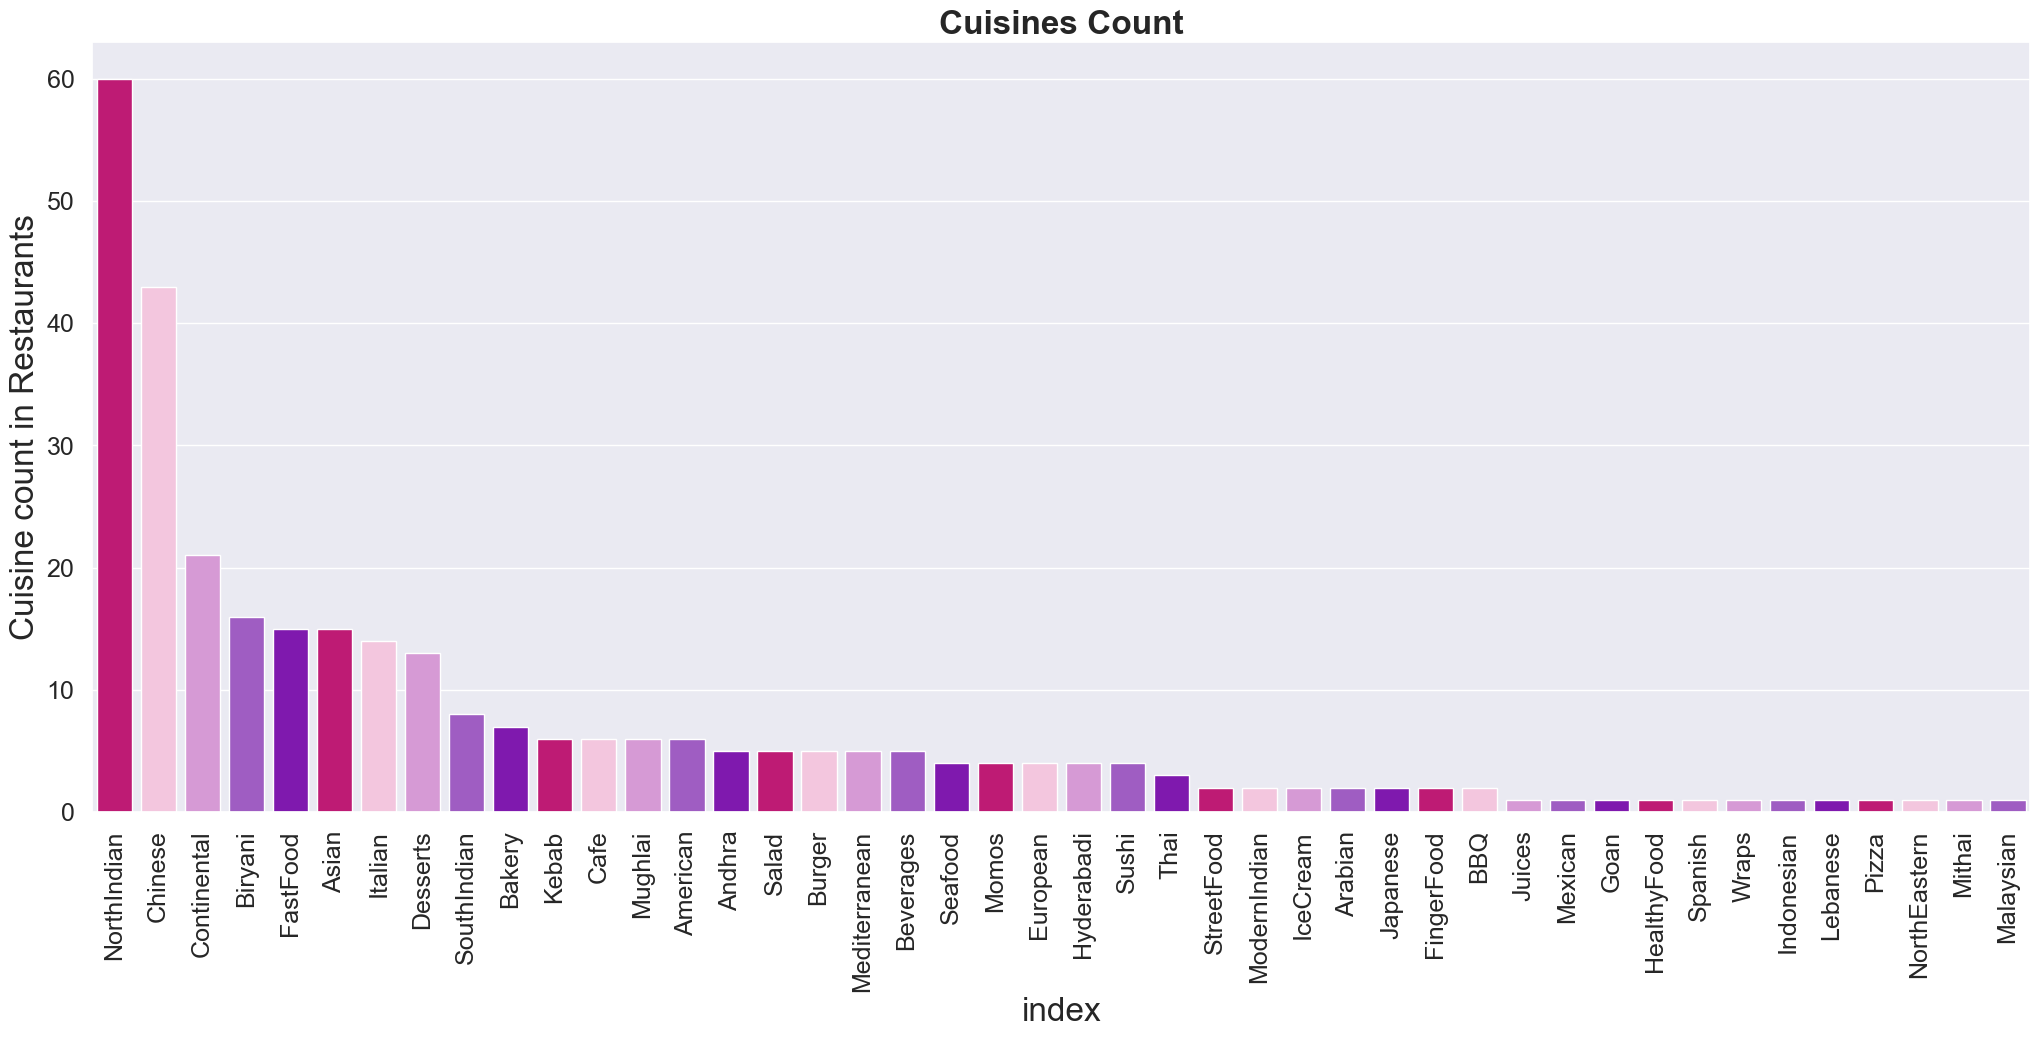

In [145]:
# Visualization of Cuisines Count
plt.figure(figsize = (25, 10))
sns.set(font_scale = 2)
sns.barplot(data = cuis_df,x = cuis_df['index'],y = cuis_df['Cuisine count in Restaurants'],palette=['#D90077','#FBBEDE','#E090DF','#A44CD3','#8800C7'])
plt.title('Cuisines Count',fontweight='bold')
plt.xticks(rotation = 90,fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()

chinese, continental, kebab, european, southindian, northindian,biryani, northindian, chines,asian, mediterranean, northindian, dessert,biryani, northindian, chinese, seafood, beverag,asian, continental, northindian, chinese, mediterranean,seafood, goan, northindian, continental, asian,healthyfood, northindian, continental, southindian,lebanes,american, chinese, northindian, kebab, southindian,icecream, dessert,streetfood, northindian, fastfood,mediterranean, northindian, kebab, bbq,continental, american, chines,northindian, italian, fingerfood,european, mediterranean, northindian,burger, fastfood,northindian,chinese, northindian,northindian, chinese, continent,northindian, chinese, biryani,northindian,northindian, japanese, italian, salad, sushi,american,icecream, dessert,northindian, chinese, continent,continent,mexican, italian, northindian, chinese, salad,northindian, mediterranean, european,mughlai, biryani,fastfood,bakery, northindian, mughlai, juices, chines,arabian, northindian

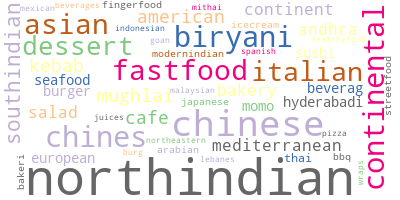

In [146]:
# Visualization of words from 'Cuisines' feature
meta_df['Cuisines']= meta_df['Cuisines'].astype(str)
data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAB/cAAAQOCAYAAAAuZbsSAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjYuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8o6BhiAAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOzdeZid8/0//ueZmeybJIhdiEQQayT5UFpiV2tVS2lLLa2iLV212qL9WopPq9TWVbS1S4PaBQ1KbEFsQWwJIZF9X+b+/eGX+RgzWc9ETsbjcV1z9dzv7X7dcf7p9bzf71MqiqIIAAAAAAAAAFCxqlZ2AQAAAAAAAADA4gn3AQAAAAAAAKDCCfcBAAAAAAAAoMIJ9wEAAAAAAACgwgn3AQAAAAAAAKDCCfcBAAAAAAAAoMIJ9wEAAAAAAACgwgn3AQAAAAAAAKDCCfcBAAAAaDKzZs1a2SUAAAA0SzUruwAAAABYVsOHD8+DDz6Yxx9/PO+9914mTpyYFi1aZLXVVkuvXr3Sv3//HHDAAVl99dU/0brGjBmT3XbbrV7bSSedlJNPPnmF3O/mm2/OaaedVq9t0KBBGTBgwAq5X3P13HPP5YEHHsijjz6ad999NxMnTkySdO7cOd27d0+/fv2y//77Z/3111/JlVa2uXPn5s9//nOefvrpXHnllSu7HAAAgGZHuA8AAMAqY/jw4Tn//PPz7LPPNuibO3duZsyYkbFjx+b+++/P7373uxx22GE59dRT07p165VQLZXupZdeyvnnn5+HHnqo0f5Zs2blnXfeySOPPJJLLrkk++23X372s5+lU6dOn3Clle/ee+/Nueeem7fffjv9+/df2eUAAAA0S47lBwAAYJXwxz/+MV//+tcbDfYbM2fOnFx11VU59NBD8957763g6ljVDBkyJIceeugig/2PW7BgQYYMGZIDDzwwL7/88gqubtXyve99LyeeeGLefvvtlV0KAABAs2bnPgAAABXvd7/7XS677LJG+7p27ZquXbtm2rRpeffddxv0jxo1Kscee2xuvPHGtGrVaoXW2bJly2yxxRb12tZcc80Vdr/OnTs3uF+7du1W2P2aixtuuCGnn356o32dOnVKt27dMnPmzIwdOzZFUdTrf/fdd3PMMcfklltuSZcuXT6Jcive0r5wAwAAQHlKxcf/XyoAAABUkAcffDDf/OY3G4Ssu+++e04++eT07t27ru2tt97KRRddlNtuu63BOieddFJOPvnkFV4vle2FF17IYYcdljlz5tRr79evX0499dRsu+22KZVKSZL3338/f/zjH3P11Vc3+P4dfPDBOffccz+xuivZwIEDM3bs2Lrr/v375+qrr16JFQEAADRPjuUHAACgYs2fPz9nnnlmg2D1hBNOyB/+8Id6wX6SbLDBBrnwwgtz2GGHNVjrqquuyuzZs1dovVS+X/3qVw2C/YMOOiiDBg3KdtttVxfsJx+euvCzn/0sp556aoN1brnllrzzzjsrvF4AAABYyLH8AAAAVKw77rij3o7g5MNdwd/97ncXO+8Xv/hFhg0bVm9ux44dM2rUqGy11VZ1bT/5yU8yePDgenMX9XvqF198cS655JJ6bffdd1/WW2+9uusxY8Zkt912qzdmUScGzJo1K7fddluGDh2aUaNGZeLEiZkzZ07atGmTNddcM717985ee+2VPffcM1VVjb+bf/PNN+e0006r1zZo0KAMGDBgsTXdeuut6dWrV959993885//zNChQ/POO++kpqYmG2+8cfbee+8cfvjhad26daP3/aj//Oc/ueWWW/LUU09lwoQJadmyZdZYY43069cv+++/f/r167fENd54443cfPPNeeKJJ/LGG29k2rRpKYoi7du3zwYbbJC+ffvm4IMPTq9evZa41uI8/fTTeeqpp+q1de/ePWedddYi/42T5Pjjj88DDzyQJ598sq6tS5cuefHFF7POOuss8bkeffTRvP7665k5c2Y6dOiQddZZJzvssEMOPPDAJT7TpptuWu96cScGLM0O+o9/j7fYYovcfPPNSZJHHnkk1157bZ599tl88MEHWW211bLtttvmy1/+cj7zmc8ssbaFhg8fXte37rrrZujQoYt9RgAAAJaOcB8AAICKdcsttzRoO/bYY+vtrm5MdXV1jjvuuLz00kvZfvvt069fv6y11lorqsxlNnLkyHznO99p8OJCkkyfPj3Tp0/P6NGjc/vtt6dPnz659NJL061btyat4fbbb8/Pf/7zTJ8+vV77iBEjMmLEiPzjH//IX//616y//vqNzp8yZUq+//3vZ9iwYfXa58yZk2nTpmX06NG57rrrsvvuu+e8885L+/btG13nyiuvzO9///vMmzevQd+kSZMyadKkPPPMM/nb3/6WY489NqeeeuoS//svypAhQxq0fe1rX0urVq2WOPfoo4/OhhtumO233z7bb799Ntxww0WOnTlzZs4999zccMMNqa2trde38Jmef/75/OUvf8lBBx2Un//852nbtu2yP1ATmTNnTs4444y6kH+h999/P3fddVfuuuuuHHrooUt8CQIAAIAVS7gPAABARaqtrW2wy7pVq1aN7iBuzOGHH74iyirbe++9l2OOOSaTJ09eqvEjR47MsccemxtuuGGpdtIvjXvvvTcXX3xxg+D5o95+++2ccsopueGGGxqE6dOmTcvhhx+e1157banudcQRR+Sf//xn2rVrV6/vmmuuyYUXXrhUNdfW1ubKK69M69atc+KJJy7VnI974oknGrTtvvvuSzV3jz32yB577LHEcdOmTcvXv/71PP/880scW1tbm5tvvjkvvvhi/vrXv6Zz585LVUtTKooiP/zhD3PXXXctdtwNN9yQzTbbLEccccQnVBkAAAAf53VrAAAAKtJrr73WYFd5z549U1Ozar+n/sc//rFBsF9TU5Pu3bund+/eWX311RvMGTVqVAYNGtRkNVx00UV1wf4aa6yRjTfeONXV1Q3GPffccw1esEiS008/vdFgf80118x6663X4GWAl156KWeffXa9tnnz5uWiiy5qsEaHDh3Sq1ev9OjRI23atGnQf9llly3Xb93PmDEjr776ar22zp07N/mJCD/84Q8bDfYXPleXLl0a9L344ov53ve+lwULFjRpLUvjhRdeqAv2F34P11hjjUbHXnXVVfWut9hii2yxxRZp0aJFvfa2bdvW9ZX7UwoAAAD8H+E+AAAAFWnChAkN2tZcc82VUEnT+vju8V122SWPPvpo7rrrrgwZMiQPP/xwBg0a1GAX9/XXX9+kdayxxhr529/+loceeih33HFHbr311qy77roNxo0YMaLe9ciRI3PnnXfWa9tiiy1y2223ZdiwYbnvvvty7733ZsCAAfXG3HTTTXn77bfrrl977bVMmjSp3pj/9//+Xx5//PHceuutuf322/Poo4/m29/+dr0x8+bNa3B8/NKYOHFiiqKo19bU36f77rsv999/f722tm3b5pxzzsmjjz6aW2+9NY888kguv/zydO3atd64Rx99dLmeq6nsvvvuGTp0aO66664MGzYsZ5xxRoMxb775ZiZOnFh3ffPNN+fmm29u8O/Yp0+fur7LL798RZcOAADwqbFqb3cAAACg2ZoyZUqDto8f674qmj9/fr3r3r17p0OHDvXaBgwYkLPOOitPPvlkNtlkk7q/pnTZZZdlyy23rLvu0aNHTj311Hz/+9+vN27cuHH1rj/+kkHbtm1z6aWXZq211qprW2+99XLJJZdkn332qXtJoyiK3HjjjTnllFOSfBjSf1y/fv3q7fpv3bp1vvvd72b27Nlp165dNtlkk/Ts2XOxv3e/KI39DEJTf5/+9re/NWi76KKL8tnPfrbuulQqZdddd81f/vKXHHrooZk7d25d3+WXX55DDz20SWtaGptttll+//vf153eUCqVcvjhh+fee+/NQw89VG/se++91+jpAwAAAKx4wn0AAAAq0sdD8CSL/Y34VUXv3r3zyiuv1F1fccUVee6557Lbbrtlhx12yMYbb5wk2XPPPbPnnnuukBq23XbbesH+Qtttt12DttmzZ9e7Hj58eL3rrbfeul6wv1DHjh3Tt2/fer/l/uSTT9Z93mijjdK6det663/xi1/M3nvvnc997nPp169fOnXqlCT58Y9/vJRPtmgr+vs0ceLEBqcy7LDDDvWC/Y/q3bt3DjjggNx44411bWPGjMkrr7ySnj17NlldS+Pwww9v9GcZtt122wbh/qxZsz6psgAAAPgY4T4AAAAVqWPHjg3aZsyYsRIq+dDHj3RfXsccc0zuvPPOup3rRVHk4YcfzsMPP5wk6dKlS7bffvv0798/AwcObPSo/HL16NGj0faP/xRAUj8Unz9/ft544416/c8++2z22GOPRtf7+LH7L7zwQt3n9u3b58gjj8yf/vSnurapU6fm+uuvz/XXX59SqZRNNtkk22+/fXbcccfsvPPOadOmzRKfbVFW9PfpxRdfbPCywE477bTYOTvttFO9cD/58GcPljfcX97v6PJ+HwAAAPhkCfcBAACoSI0Fi+++++4Kv29RFPWOhl9owYIFTbL+wiPQf/SjH2XatGkN+idOnJi77747d999d37961+nf//++fa3v50ddtihSe6fJKuttlqj7S1btmzQ9tHAeOrUqQ0C5BkzZix1SD5jxozMmTMnrVq1SpJ873vfy7Rp03Ldddc1et9XXnklr7zySq655pq0bds2Bx54YE488cSsscYaS3W/j2rs+/TxnxwoxwcffNCgbe21117snMb6G1vnoxYX4C/vd7Sxf5tkyd8HAAAAPllVK7sAAAAAaEzPnj3TokWLem2jR4+u9xvli/Pggw/me9/7Xu64447MnDlzqe+7qKPa58yZs9RrLMnAgQNz33335Qc/+EE222yzxY4dPnx4jjrqqFxyySVNdv/GQtskjR7N/lELTxsox9SpU+s+t2jRImeddVZuuummfPnLX15kyJwkM2fOzDXXXJP99tsvL7744jLft0uXLg3C9GnTpmXs2LFLNf+ll17Kt771rdx8882ZPHlyg/6ammXfP9FYUN7YiyUftbifElje7+jyfh8AAAD4ZNm5DwAAQEVq3bp1ttpqq3q/0z5v3rw89NBDGThw4BLn33777bnjjjtyxx13pFWrVtl5551z8sknp3fv3oudN3v27LRr165B+/Tp05f9IRajU6dOOe6443Lcccflvffey8MPP5zHH388Tz31VIOj75Pkkksuya677potttii7HtXVS3fu/6NHW3/5S9/OWeddVZZ9fTp0yd9+vTJGWeckZEjR+a///1vnnrqqTz99NOZMmVKvbGTJ0/Oj3/849xyyy3LfJ9+/fo1mDd06NB89atfXeLcu+++O/fff3/uv//+1NTUZMCAAfnmN7+ZAQMGJPnw5YGPW9JJE431d+3adbFzFhXgF0Wx3D8zsKQXCgAAAKgMdu4DAABQsT7/+c83aPvb3/62xHnvvvtu7rjjjrrrOXPm5N57722wQ7mxkLuxo/KT5K233lrifZfF3Llz88orr2TOnDnp1q1bvvCFL+Scc87JXXfdlf/85z859thj640viiJ33313k9awrNq0adNg9/srr7yyyPGjR4/OrFmzlrju5MmT89prr6WqqipbbbVVvvnNb+aKK67IY489luuvvz5bbrllvfEvv/xy3nzzzWWuv7Hv0z/+8Y8lngYxffr0ej8dMH/+/Dz88MP15vXq1avBvGHDhi123cb6t95663rXH/+OfvTkg4969913m+RkBQAAACqXcB8AAICKdcghhzTYyfzYY4/lsssuW+ScuXPn5sc//nGDHc7bb799Nt5443ptje3Qf/755xu0vfbaa/VOEFhew4cPzwknnJC99tor22yzTfbbb78MHjy4wbhu3brlhBNOaNA+adKksmsoV9++fetdP/3003n22WcbjHvvvfdywAEHZNttt83uu++eE044Iddee21d/x/+8Id89atfzY477pgBAwbkkEMOaXDcfalUytZbb50DDjigwfrL82+xyy67ZNNNN63X9vrrr+fXv/71In9LviiKnHnmmZkwYUK99nXXXTc77rhj3XWXLl0anKrw6KOPLjLgf+mll3LbbbfVa9too42y0UYb1Wv7+Hd01KhRjYb4H3354JP28RcQvGQAAACwYgj3AQAAqFitW7fOaaed1qD9d7/7Xb7//e/ntddeq9f+7LPP5qtf/Woee+yxBnNOOeWUBm3rrrtug7bzzz8/Y8aMqbt+4okncuyxx2b+/PnL8wj1dOnSJUOHDs0bb7yRBQsWJEnOO++83H777fV+S33SpEm54IILGsxfZ511yq6hXAcffHC966Io8u1vfzv//e9/69rGjx+fU089NfPmzUtRFHn77bczdOjQzJ49u27MzJkzM3z48HzwwQdJklmzZuVb3/pWg/+mzz//fL2XAhb6+AkCS+vnP/95g9+Sv+6663LMMcfkueeeq9f+2muv5Vvf+lajPwHw3e9+t8E6RxxxRINx3/nOd3LzzTfXfX+Kosj999+fb3zjGw1ODPj2t7/dYP7Hv6MffPBBzjvvvLq5c+bMyZVXXpkrr7xyUY+8wrVq1are9dtvv133EwHvvffeyigJAACgWapZ2QUAAADA4uy///4ZMWJE/v73v9drv+2223LbbbdlzTXXTOfOnfPBBx802F290NFHH53tt9++QXtjba+//nr22muvbLDBBpk+fXref//9JEl1dXVdIL+8Ntlkk3z+85/Pv//977q2mTNn5pRTTskvfvGLrLXWWpk5c2bef//9BrufW7RokX322aes+zeFnXbaKf3798/w4cPr2saPH5+jjjoqa665Zjp06JC33nqrQf3rrLNODjvssLrrb3zjG7n22mszffr0urann346n//857PmmmumU6dO+eCDD+rC/48aMGBAunXrtlz19+vXLz/4wQ9y3nnn1Wt/+OGH8/DDD6dLly5ZffXVM23atLz77ruNrrHXXnvlwAMPbNB+8MEH57rrrsszzzxT1zZz5sycdtppOeecc7L22mtn/PjxmThxYoO5u+yyS/bbb78G7dtvv31eeumlem1XX311hgwZkm7dumXs2LGZOXNmkqb5ji6PLl261LueMGFCdt1113To0CFTpkzJE0888YnXBAAA0BzZuQ8AAEDFO/3003P88cc32vf+++/n5ZdfXmSwf9BBB+UHP/hBo319+vTJTjvt1KB9/vz5GT16dF2wX1VVlVNPPXU5q6/vl7/8ZYOfB0iSadOm5ZVXXsnYsWMbPdb8u9/9bjbccMMmqaFc559/fqOnHrz//vt57bXXGtTfsmXLXHjhhWndunVdW9euXXP++eenpqb+voOiKPLee+9l1KhRjQb7nTp1yi9/+cuy6v/GN77R6A7+JJk4cWJGjRq1yGB/p512yjnnnNNoX1VVVS655JJ07969Qd/UqVPz8ssvNxrsb7PNNrnwwgsbHG+fJF//+tfTpk2bRtd75ZVX6oL9jTfeOIccckijda1o2223XYO2KVOmZMyYMZk2bVrdLn4AAADKI9wHAACg4pVKpXz/+9/P5Zdfnk022WSp5qy22mo544wzct555zUIkD/q7LPPTu/evRfZ36lTp/z+97/PZz/72WWue1Hr/fOf/8zAgQOXanybNm1y+umn57jjjmuS+zeFtdZaK1dddVX69eu3xLHdunXLX//610YD4IEDB+ZPf/rTUv/cQM+ePTNo0KD06NFjmWv+uCOPPDJXX311ttlmm6Ua36ZNm3z3u9/N5Zdfnnbt2i1y3JprrpkbbrghBx98cEql0mLXrK6uzmGHHZZBgwalffv2jY7ZYIMNcs4559R7MeLjtt9++/z1r39d5Bor2le+8pV07dp1kf3jxo37BKsBAABovhzLDwAAwCpj1113zWc/+9n85z//yQMPPJCnnnoqEyZMyNSpU9O6deusvvrq2WyzzfK5z30ue+21V9q2bbvENbt165brrrsu1157bf7973/nzTffzLx587L++utnzz33zJe//OWsscYaGTVqVJM9R+fOnXPZZZfl6aefzm233Zann346Y8aMyYwZM1JTU5NOnTqlZ8+eGTBgQA466KCsueaaTXbvprL++uvn73//ex544IHcfffdefrppzNhwoTMnDkzHTt2zKabbprddtsthxxyyGL/O+ywww654447cscdd+T+++/Piy++mAkTJmTOnDlp06ZN1lxzzWy++ebZY489sttuu6VFixZN9gx9+/bNddddl8ceeyxDhw7N448/nvfffz+TJ09OixYt0qVLl/Tu3Ts77rhjPv/5z2e11VZbqnU7duyYc889N9/61rcyZMiQ/Pe//83o0aMzY8aMtG/fPuuuu2523HHHHHzwwUv1osI+++yTTTfdNFdffXUefvjhjBs3ru7f+Atf+EL23nvvRk8h+KR069YtN954Yy6//PIMGzYs48ePT7t27bL22mtnxx13TOfOnVdabQAAAM1JqSiKYmUXAQAAAAAAAAAsmmP5AQAAAAAAAKDCCfcBAAAAAAAAoMIJ9wEAAAAAAACgwgn3AQAAAAAAAKDCCfcBAAAAAAAAoMIJ9wEAAAAAAACgwgn3AQAAAAAAAKDC1azsAj5tiqJIbW2xsssAAAAAAAAAoAJUVZVSKpWWOE64/wmrrS0yceKMlV0GAAAAAAAAABWgS5d2qa5ecrjvWH4AAAAAAAAAqHDCfQAAAAAAAACocMJ9AAAAAAAAAKhwwn0AAAAAAAAAqHDCfQAAAAAAAACocMJ9AAAAAAAAAKhwwn0AAAAAAAAAqHDCfQAAAAAAAACocMJ9AAAAAAAAAKhwwn0AAAAAAAAAqHDCfQAAAAAAAACocMJ9AAAAAAAAAKhwwn0AAAAAAAAAqHDCfQAAAAAAAACocMJ9AAAAAAAAAKhwwn0AAAAAAAAAqHDCfQAAAAAAAACocMJ9AAAAAAAAAKhwwn0AAAAAAAAAqHDCfQAAAAAAAACocMJ9AAAAAAAAAKhwwn0AAAAAAAAAqHDCfQAAAAAAAACocMJ9AAAAAAAAAKhwwn0AAAAAAAAAqHDCfQAAAAAAAACocDUru4Cm9N///jf/+Mc/MmLEiEyePDmrrbZa/ud//icnnHBCevTo0eicWbNm5U9/+lP+/e9/Z8yYMWnXrl369OmTr33ta/nc5z73CT8BAAAAAAAAADRUKoqiWNlFNIULLrggf/zjH5Mka6yxRrp06ZLXX389c+fOTatWrXLZZZflM5/5TL05M2fOzFFHHZVnnnkmLVq0SM+ePTN58uS88847SZKTTz45J510UpPWuWBBbSZOnNGkawIAAAAAAACwaurSpV2qq5d86H6zOJb/xhtvzB//+Me0aNEi55xzToYNG5Zbbrklw4YNyy677JI5c+bkhz/8YWbOnFlv3llnnZVnnnkmm222We65554MHjw4999/f84777zU1NTk4osvziOPPLKSngoAAAAAAAAAPrTKh/tz5szJ+eefnyT56U9/mi984QsplUpJktVWWy0XXHBB2rVrlw8++CBDhw6tm/fWW2/llltuSVVVVS644IKsvfbadX0HHXRQjjvuuCTJxRdf/Ak+DQAAAAAAAAA0tMqH+0OHDs3kyZPTvXv3fPnLX27Q36FDh/z85z/Paaedlo033riufciQIVmwYEG22WabbLLJJg3mHX744UmSp556qu6YfgAAAAAAAABYGWpWdgHlWnhs/sCBA1NdXd3omIMPPrhB24gRI5Ikffv2bXROt27dsu6662bs2LEZPnx4DjrooCapFwAAAAAAAACW1Sof7r/88stJkp49e6Yoitxzzz0ZOnRoxo0bl06dOmWnnXbKQQcdlBYtWtSb9+abbyZJNthgg0WuvTDcf+ONN1ZY/QAAAAAAAACwJKt8uL/wyPyampoceeSReeKJJ+r133nnnRk0aFCuvPLKrL322nXtH3zwQZKkS5cui1x7tdVWS5JMmjSpiasGAAAAAAAAgKW3yof7M2bMSJKcc845mTFjRn76059m//33T5s2bfLoo4/mV7/6VUaNGpVvfvObufHGG9OyZcskyezZs5Ok7roxrVq1qje2qdTUVNW7LpVKqaoqNek9lldtbZGiKFZ2GQAAAAAAAAB8xCof7i8M3idOnJg//OEP2X333ev6dt1112y44YY54IAD8vLLL+df//pXvvSlLyVJqqurU1tbu1T3KJWaLnivqiqlc+d29dqKBbUpVVctYsYnq5JqAQAAAAAAAOBDq3y437p168ycOTO9e/euF+wvtPHGG+fzn/98/vWvf+W+++6rC/fbtm2bKVOmZO7cuYtce86cOXX3aCq1tUWmTp1Zd11dXZWOHdvkhZP/mRmvvN9k91ke7Xqumc0v/kqmTp2VBQuW7sUHAAAAAAAAAJZfx45tUr0UG7BX+XC/Y8eOmTlzZjbbbLNFjunZs2eS5O23365r69y5c6ZMmZJJkyYtct7Cvq5duzZRtR+aP79hcD7jlfczfeTYJr3P8lqwoLbRGgEAAAAAAABYOVb589d79OiRJIvdgV9T8+E7DC1btqxr23jjjZMkY8cuOlBf2Ne9e/dyywQAAAAAAACA5bbKh/tbb711kuTZZ59d5JjRo0cnSTbYYIMG80aMGNHonHHjxuWdd95Jkmy77bZNUSoAAAAAAAAALJdVPtzfb7/9knx45P4999zToP+DDz7IbbfdliTZa6+96tr33nvvJMnw4cPrwv+Puuaaa5Ik/fv3z3rrrdfkdQMAAAAAAADA0lrlw/0ePXrk0EMPTZKcdtppGTp0aF3f+PHj873vfS8zZszIpptumj322KOur3v37tlvv/2yYMGCnHzyyXnzzTfr+oYMGZI//elPSZITTjjhE3oSAAAAAAAAAGhczcouoCmcfvrpGT9+fB544IGccMIJWXvttdOlS5eMGjUq8+bNy7rrrpvf/va3admyZYN5o0aNyqhRo7LPPvukV69emTp1asaOHZskOeWUU7LjjjuujEcCAAAAAAAAgDrNItxv3bp1Lr/88tx666258cYb8+KLL2bSpElZf/31s+eee+aoo45K586dG8zr3Llzrrvuuvz5z3/OHXfckddeey01NTXp379/vvrVr2bPPfdcCU8DAAAAAAAAAPWViqIoVnYRnyYLFtRm4sQZddc1NVXp3LldHt/7d5k+cuxKrCxp32fd9Lvze5k0aUbmz69dqbUAAAAAAAAAfBp06dIu1dVVSxy35BEAAAAAAAAAwEol3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgAon3AcAAAAAAACACifcBwAAAAAAAIAKJ9wHAAAAAAAAgApXs7ILaCoDBw7M2LFjFzvm8ccfT8eOHeuuJ02alMsuuyz33Xdf3nvvvXTs2DHbbbddjj322GyzzTYruGIAAAAAAAAAWDrNItyfOnVqxo4dm+rq6my99daLHFddXV33ecKECTn88MPz1ltvpU2bNunVq1fee++93HPPPRk6dGjOOuusfPGLX/wkygcAAAAAAACAxWoW4f7LL7+cJNlwww1zzTXXLNWcU045JW+99VY+85nP5Le//W06deqU2tra/OlPf8qFF16YM844I9tuu2169OixIksHAAAAAAAAgCWqWtkFNIWXXnopSdKrV6+lGv/YY49l+PDhadu2bS644IJ06tQpSVJVVZXjjz8+BxxwQObNm5fLLrtshdUMAAAAAAAAAEurWYX7PXv2XKrxgwcPTpLstttu6dKlS4P+ww47LEly3333Zfbs2U1UJQAAAAAAAAAsn2YV7m+66aZLNf7pp59OkvTt27fR/q222io1NTWZOXNmRo4c2TRFAgAAAAAAAMByqlnZBZRrwYIFeeWVV5Ika665Zv72t7/liSeeyLRp09KtW7fssssu2XvvvVNV9eF7DLW1tRkzZkySZIMNNmh0zRYtWqRbt24ZO3ZsXn/99Wy//fafzMMAAAAAAAAAQCNW+XD/jTfeyJw5c5IkRx99dGbMmFGvf8iQIfnrX/+aP/zhD1lzzTUzZcqUzJ8/P0kaPZJ/odVWWy1jx47NpEmTVlzxAAAAAAAAALAUVvlwf+GR/Emy5ZZb5uSTT84WW2yROXPm5D//+U9+85vf5Nlnn83xxx+f66+/PrNnz64b37Jly0Wu26pVqySpN76p1NT8368hVFdX3i8jVGJNAAAAAAAAAJ9mq3y4v8466+SrX/1qqqqq8pOf/KTu+P02bdrkgAMOyJZbbpmDDz44L774Ym688cbstttuy7R+qVRq0nqrqkrp3Lldk67Z1Dp2bLOySwAAAAAAAADgI1b5cH/bbbfNtttuu8j+jTbaKPvvv3+uv/763HvvvTnggAPq+ubOnbvIeQuP+m/dunXTFZuktrbI1Kkz666rq6sqLkyfOnVWFiyoXdllAAAAAAAAADR7HTu2WarT1Vf5cH9pbLbZZkmSMWPGpG3btmnZsmXmzp2byZMnL3LOpEmTkiRdu3Zt8nrmz6/s4HzBgtqKrxEAAAAAAADg06RZ/Lh6bW3tYnfhF0WRJKmpqUlVVVU22mijJB+G/Y2ZN29e3n///SRJ9+7dm7ZYAAAAAAAAAFhGq3y4f8QRR6RPnz75zW9+s8gxzz//fJJkk002SZJsvfXWSZIRI0Y0Ov7ZZ5/N/Pnz06pVq2y++eZNWzAAAAAAAAAALKNVPtzv2bNnFixYkLvvvjvTp09v0D927NjccccdSZJ99903SbLPPvskSe66665Gj+a/5ppr6sa3bt16BVUOAAAAAAAAAEtnlQ/3jzrqqLRs2TLvvfdeTjnllIwfP76u76WXXsoxxxyTmTNnpl+/ftlzzz2TJDvssEO22267TJs2LSeeeGImTJiQ5MPj/f/4xz/m1ltvTYsWLXLcccetlGcCAAAAAAAAgI8qFQt/kH4Vdtddd+WHP/xh5syZkxYtWmSjjTbK/PnzM3r06CRJnz598uc//zmrrbZa3Zy33347Rx55ZMaNG5eWLVumZ8+eef/99zN+/PiUSqX85je/yQEHHNDktS5YUJuJE2fUXdfUVKVz53Z5fO/fZfrIsU1+v2XRvs+66Xfn9zJp0ozMn1+7UmsBAAAAAAAA+DTo0qVdqquXvC+/5hOoZYXba6+90rNnz/z1r3/Nww8/nNdffz2tW7fOtttum/322y+HHXZYamrqP+r666+fwYMH5/LLL8/QoUMzatSotGnTJjvvvHOOPfbY/M///M9KehoAAAAAAAAAqK9Z7Nxfldi5DwAAAAAAAMBCS7tzf8kjAAAAAAAAAICVSrgPAAAAAAAAABVOuA8AAAAAAAAAFU64DwAAAAAAAAAVTrgPAAAAAAAAABWu5pO4ydtvv51bb70148aNS7du3bLnnnumZ8+en8StAQAAAAAAAGCV1yTh/ujRo/PnP/85L7zwQgYPHlyv74YbbsiZZ56ZBQsW1LX94Q9/yOGHH57TTz89pVKpKUoAAAAAAAAAgGar7HD//vvvz3e+853Mnz8/STJ9+vS0b98+SfLqq6/mzDPPrOtbqCiK/POf/0ypVMrpp59ebgkAAAAAAAAA0KxVlTN52rRp+fGPf5x58+alKIoURZF33323rv+Pf/xj5s+fn1KplLXWWis/+MEP8o1vfCOtW7dOURS55ppr8tJLL5X9EAAAAAAAAADQnJW1c//GG2/M1KlTUyqVMmDAgPz617/OeuutlySZO3du7r333iRJqVTKX/7yl2y88cZJkt133z1f+9rXsmDBggwZMiS9e/cu8zEAAAAAAAAAoPkqa+f+Qw89lCTp0qVLLr/88rpgP0keffTRzJgxI6VSKdttt11dsJ8k2223XXbaaacURZH//ve/5ZQAAAAAAAAAAM1eWeH+q6++mlKplN133z2tW7eu1zds2LC6z5/97GcbzN18882TJOPGjSunBAAAAAAAAABo9soK9ydPnpwkWWeddRr0LdzVnyQ77LBDg/6WLVsmSaZPn15OCQAAAAAAAADQ7JUV7ldVfTh93rx59drfeeedvP7660mS9u3bp0+fPg3mvvPOO0mSdu3alVMCAAAAAAAAADR7ZYX7C3fsjxo1ql77gw8+mCQplUrZcccdUyqV6vUvWLAgjz76aEqlUtZbb71ySgAAAAAAAACAZq+scL9v374piiIPPPBAXnjhhSTJzJkzM2jQoLoxu+++e4N5V1xxRd566626NQAAAAAAAACARaspZ/IhhxyS66+/PvPmzcuRRx6ZHXfcMaNGjcrbb7+dJOnYsWP22GOPuvH//ve/c+utt9bt7K+qqsohhxxSTgkAAAAAAAAA0OyVtXN/6623zmGHHZaiKDJr1qzcd999efvtt1MURUqlUn7yk5+kdevWdePPPffcPPjggymKIkly7LHHZtNNNy3vCQAAAAAAAACgmSsr3E+SX/ziF/nOd76Tdu3apSiKFEWRrl275te//nUOPvjgemN79OiRoijSsmXLnHrqqTnllFPKvT0AAAAAAAAANHtlHcuffHi0/re//e0cc8wxee2111JdXZ2NN944LVq0aDB2v/32y6677pr9998/Xbp0KffWAAAAAAAAAPCpUHa4v1CrVq2y+eabL3bMF7/4xaa6HQAAAAAAAAB8apQV7p922mlJks9//vPZaaedlmnukCFD8te//jVFUWTIkCHllAEAAAAAAAAAzVpZ4f7gwYNTKpXSq1evZQ7333vvvbz00ktp06ZNOSUAAAAAAAAAQLNXtbJu/OqrryZJiqJYWSUAAAAAAAAAwCphiTv358+fn3POOSczZ85c5Jjbb789o0aNWqob1tbWZuzYsXnyySdTKpXSrVu3pa8WAAAAAAAAAD6Flhju19TUZJ111sn555+fUqnUoL8oiowcOTIjR45cphsXRZFSqZR99913meYBAAAAAAAAwKfNUh3Lf9RRR2XTTTdNURT1/hb6ePvS/C0M9r/97W+vsIcDAAAAAAAAgOZgiTv3k6S6ujpXXnll3nzzzbq2oijy9a9/PaVSKYcddlj22WefJa5TKpVSVVWV9u3bZ91110379u2Xv3IAAAAAAAAA+JRYqnA/Sbp165Zu3bo12rfBBhukf//+TVYUAAAAAAAAAPB/ljrcb8w555yTJNlyyy2bpBgAAAAAAAAAoKGywv2DDz64qeoAAAAAAAAAABahamUXAAAAAAAAAAAsXlk79xeaN29e7r777vz3v//NhAkTMmfOnNTW1qYoiiXOLZVKueqqq5qiDAAAAAAAAABolsoO919++eWceOKJGTt27DLPLYoipVKp3BIAAAAAAAAAoFkrK9yfPn16jjnmmEyYMKGp6gEAAAAAAAAAPqascP8f//hHJkyYkFKplPbt2+eoo45K//7906VLl7Ru3bqpagQAAAAAAACAT7Wywv177733w0VqanLVVVdl8803b5KiAAAAAAAAAID/U1XO5DfffDOlUim77babYB8AAAAAAAAAVpCywv158+YlSTbddNMmKQYAAAAAAAAAaKiscH/NNddMksyePbtJigEAAAAAAAAAGior3B8wYECKoshjjz3WVPUAAAAAAAAAAB9TVrj/la98JTU1NXnmmWfy4IMPNlVNAAAAAAAAAMBHlBXu9+7dO9/5zndSFEVOPfXUDB48OPPnz2+q2gAAAAAAAACAJDXlTL799tuz3nrrZcCAAXnsscfy05/+NGeffXZ69+6d1VdfPa1bt17iGqVSKWeffXY5ZQAAAAAAAABAs1ZWuH/qqaemVCol+TCkL4oi06ZNyxNPPLFM6wj3AQAAAAAAAGDRygr3k6QoiqVqW5SFLwcAAAAAAAAAAI0rK9wfNGhQU9UBAAAAAAAAACxCWeF+//79m6oOAAAAAAAAAGARqlZ2AQAAAAAAAADA4gn3AQAAAAAAAKDClXUs/8dNmzYtM2bMyLx58xr0FUWR2trazJ8/P7NmzcrkyZPz/PPP55Zbbsntt9/elGUAAAAAAAAAQLNSdrhfW1ubq666Kv/85z8zZsyYpqgJAAAAAAAAAPiIssP9n/3sZ/nXv/6V5MPd+cuqVCqVWwIAAAAAAAAANGtlhftPPvlkBg8enFKplKIoUiqV0rVr19TW1mbixImprq5Ot27dMnv27EydOjXz58+vG9uiRYt885vfzGc/+9mmehYAAAAAAAAAaJaqypk8ZMiQus977rlnHnrooTz00EO5+uqrk3x4ZP8///nPPPLII3nmmWdy1VVXZYsttkiSzJ8/P0VRZKuttiqnBAAAAAAAAABo9soK95966qkkSdeuXXP++eena9euSZIePXrUfX7ooYeSJNXV1RkwYECuu+669OvXL0VR5Iorrsjbb79dTgkAAAAAAAAA0OyVFe6PHz8+pVIpu+yyS1q1alWvb/PNN0+SPP300/Xaq6ur85vf/CbV1dVZsGBBrr/++nJKAAAAAAAAAIBmr6xwf8aMGUmS9dZbr0HfJptskqIo8uKLLzboW3vttbPjjjumKIoG4T8AAAAAAAAAUF9Z4X67du0+XKSq4TLdu3dPkrz++uuNzu3Vq1eS5I033iinBAAAAAAAAABo9soK9zt37pwkGTduXIO+9ddfP0kye/bsjB07tkH/whcDpk6dWk4JAAAAAAAAANDslRXub7XVVimKIsOGDUttbW29vg022KDu8zPPPNNg7pgxY5IkpVKpnBIAAAAAAAAAoNkrK9zfeeedk3wY1J9xxhmZN29eXd96662XTp06JUmuu+66evMmTpyYu+++O6VSKd26dSunBAAAAAAAAABo9soK9/fZZ5+ss846SZIbbrghu+22W2688ca6/r322itFUWT48OE54YQTcv/99+fmm2/OV77ylUyfPj1Jsv3225dTAgAAAAAAAAA0ezVlTa6pyQUXXJBvfOMbmT17dsaPH5/XX3+9rv/444/PkCFDMnfu3DzwwAN54IEH6s2vrq7O1772tXJKAAAAAAAAAIBmr6yd+0my3Xbb5Z///Ge23377FEWR9ddfv65vvfXWywUXXJBWrVqlKIp6f6VSKT/96U/Tu3fvcksAAAAAAAAAgGatrJ37C22++eb5+9//njFjxqRFixb1+vbYY4/861//yt/+9rc888wzmTt3bnr37p0jjzwy2267bVPcHgAAAAAAAACatbLC/XfffTft27dPhw4dkny4U78x3bt3zxlnnFHOrQAAAAAAAADgU6usY/l/97vfZccdd8w3v/nNPProo01VEwAAAAAAAADwEWWF+0888UTmzZuX//znP5k3b15T1QQAAAAAAAAAfERZ4f6ECRPqPvft27fsYgAAAAAAAACAhsoK99daa626z5MnTy63FgAAAAAAAACgEWWF+0cddVTd50svvbTcWgAAAAAAAACARtSUM/nwww/PnDlzcuGFF+amm27K+++/n8MPPzzbbLNNOnfu3FQ1AgAAAAAAAMCnWlnh/hlnnJEk6du3bx599NEMGzYsw4YNS5K0adMmHTt2THV19WLXKJVKuffee8spAwAAAAAAAACatbLC/WuvvTalUilJ6v43SYqiyMyZMzNr1qzFzi+Kot48AAAAAAAAAKChssL95MOAfnn6WHVVVZVSVVUZL2XU1haprfU9AwAAAAAAAJq3ssL9l156qanqYBVRVVVKl87tUqqQcL+oLTJx0gwBPwAAAAAAANCslb1zn0+XqqpSSlWlzH7l/dTOmrdya2nTIq17rpmqqpJwHwAAAAAAAGjWhPssl9pZ81I7Y+7KLgMAAAAAAADgU6FqZRcAAAAAAAAAACxeWTv3L7nkkiYp4qSTTmqSdQAAAAAAAACgOSo73C+VSmUXIdwHAAAAAAAAgEUrK9xPkqIolml8qVSqN6cpXg4AAAAAAAAAgOasrHD/nHPOWeKYoigyZ86cjB8/Ps8991weeeSR1NbWZp999skvf/nLVFVVlVMCAAAAAAAAADR7ZYX7Bx988DLPef7553PSSSfljjvuSIcOHXLmmWeWUwIAAAAAAAAANHuf+Lb5LbbYIr///e+TJNdff30effTRT7oEAAAAAAAAAFilrJQz8bfccsvssMMOKYoi119//cooAQAAAAAAAABWGSvtB++33HLLJMmIESNWVgkAAAAAAAAAsEpYaeF+qVRKkkyYMGFllQAAAAAAAAAAq4SVFu4/+eSTSZKOHTuurBIAAAAAAAAAYJWwUsL9G264IY8//nhKpVL69OmzMkoAAAAAAAAAgFVGTTmT//Wvfy3VuKIoMnfu3EycODGPPPJInnjiibq+Aw44oJwSAAAAAAAAAKDZKyvc/8lPfpJSqbTM84qiSJL069cv++67bzklAAAAAAAAAECzV/ax/EVRLPNfVVVV9t9//1x66aVN8QwAAAAAAAAA0KyVtXP/pJNOWuqxVVVVadOmTdZaa60MGDAgXbp0KefWAAAAAAAAAPCp8YmF+wAAAAAAAADA8in7WH4AAAAAAAAAYMUS7gMAAAAAAABAhVsh4X5RFKmtra33t2DBgsybNy+zZs3KxIkTM3r06Nx666055phjVkQJAAAAAAAAANBs1DTFInfffXf++c9/5vnnn8+MGTNSFEVTLAsAAAAAAAAApAnC/d/+9re58sork2S5Qv1SqVRuCQAAAAAAAADQrJUV7o8aNWqRwf7C0H5R7TU1Ndl///2z0047lVMCAAAAAAAAADR7VeVMvuGGG+rC+759++aGG27Is88+m5tuuilFUaS6ujqPPPJIRowYkaFDh+bss8/O2muvnaIoMn/+/PTp0yf77rtvkzwIAAAAAAAAADRXZYX7TzzxRJKkffv2ufTSS7PlllumZcuW2WKLLdKxY8csWLAgDz/8cFq3bp111lknX/jCFzJkyJD06tUrRVHk/PPPz4QJE5rkQT5u/vz5+eIXv5hNN900N998c6NjZs2alYsvvjh77713+vTpkwEDBuSYY47Jgw8+uEJqAgAAAAAAAIDlUVa4P27cuJRKpeyyyy7p1KlTvb4tttgiSfLkk0/Wa+/QoUMuvPDClEqlzJ49O9dff305JSzSFVdckeeee26R/TNnzszXv/71XHLJJRkzZkx69uyZtm3b5qGHHsrxxx+fSy65ZIXUBQAAAAAAAADLqqxwf9q0aUmSjTbaqEHfJptskqIo8tJLLzXo69mzZ7bffvsURZHHH3+8nBIa9eKLL+ayyy5b7JizzjorzzzzTDbbbLPcc889GTx4cO6///6cd955qampycUXX5xHHnmkyWsDAAAAAAAAgGVVVrjfpk2bJEmLFi0a9HXv3j1J8tprrzU6t0+fPovtX15z587Nj370oyxYsCAtW7ZsdMxbb72VW265JVVVVbnggguy9tpr1/UddNBBOe6445IkF198cZPWBgAAAAAAAADLo6xwf7XVVkuSTJgwoUHf+uuvnySZPn163n///Qb9C4/xnzJlSjklNHDxxRdn1KhR+epXv5o11lij0TFDhgzJggULss0222STTTZp0H/44YcnSZ566qm88847TVofAAAAAAAAACyrssL9zTffPEVRNHp8/QYbbFD3+dlnn23QP27cuCRJURTllFDPiBEj8uc//zndu3fPqaeeuthxSdK3b99G+7t165Z11103STJ8+PAmqw8AAAAAAAAAlkdZ4f6OO+6YJHn11Vdz6aWX1uvbcMMN647tv+WWW+r1zZo1K/fee2+SZPXVVy+nhDqzZ8/Oj3/84xRFkXPOOSetW7de5Ng333wzSf0XED5uYbj/xhtvNEl9AAAAAAAAALC8ygr3DzzwwHTp0iXJh8fhf/GLX8x9992XJCmVShk4cGCKosg999yTX//61xk1alQee+yxHHvssZkwYUJKpVK22Wabsh8iSS644IK88cYbOeqoo7LddtstduwHH3yQJHW1N2bhTw5MmjSpSeoDAAAAAAAAgOVVU87k1q1b56yzzsp3v/vdLFiwIM8//3wef/zx7LbbbkmS448/PnfccUeKosg//vGP/OMf/2iwxsLfty/HY489lr///e/ZeOON873vfW+J42fPnp0kadmy5SLHtGrVqt7YplRT83/vVFRXl/V+xQqxuJpWtXoBAAAAAAAAmoOywv0k2X333XPppZfmrLPOytixY7PeeuvV9W266ab52c9+ll//+tcpiqLB3OOOOy79+vUr6/7Tp0/Paaedlqqqqpx77rl1ofziVFdXp7a2dqnWL5VKZdX3cVVVpXTu3K5J12xqHTu2WdklLJNVrV4AAAAAAACAZVV2uJ8kn/vc53LPPffk8ccfT7du3er1HXHEEenVq1euvPLKPPPMM5k7d2569+6dr33ta9l3333Lvve5556bsWPH5thjj83WW2+9VHPatm2bKVOmZO7cuYscM2fOnCQfnk7QlGpri0ydOrPuurq6quLC6alTZ2XBgsZffljV6gUAAAAAAACoZB07tlmq08qbJNxPkqqqqgwYMKDRvn79+pW9Q78xDz74YG644Yb06NEj3/3ud5d6XufOnTNlypRMmjRpkWMW9nXt2rXsOj9u/vzKDqIXLKit+Bo/alWrFwAAAAAAAGBZlRXuv/POO0mSTp06pV27ZTtqfsKECRkxYkSmTJmSQw45ZLnuf8cddyRJXnvttWy55ZaLHHfaaafltNNOS//+/XP11Vdn4403zhtvvJGxY8cucs7Cvu7duy9XbQAAAAAAAADQVMoK9wcOHJhSqZQf/ehHOfroo5dp7rXXXps//OEP6dq163KH+927d8922223yP6RI0dm7ty56d69e7p06ZJevXolSbbeeusMHTo0I0aMaHTeuHHj6l5c2HbbbZerNgAAAAAAAABoKk12LP+yKpVKKYoikydPXu41vvWtb+Vb3/rWIvsHDhyYsWPH5pvf/Ga+8IUv1LXvvffe+e1vf5vhw4dn9OjR2XjjjevNu+aaa5Ik/fv3z3rrrbfc9QEAAAAAAABAU1hiuF9bW5tx48YtdsyUKVPqdrovyYIFCzJ27NjcdNNNSZL27dsv1bym1L179+y333657bbbcvLJJ+fSSy/NhhtumCQZMmRI/vSnPyVJTjjhhE+8NgAAAAAAAAD4uCWG+1VVVfnRj36UJ598stH+oihyxRVX5Iorrljmm5dKpWy55ZbLPK8pnH766Rk1alRGjRqVffbZJ7169crUqVMzduzYJMkpp5ySHXfccaXUBgAAAAAAAAAfVbU0g84444zU1NSkKIp6fwt9vH1p/2pqanLiiSeusIdbnM6dO+e6667LSSedlO7du+e1117LpEmT0r9//1x88cWLPe4fAAAAAAAAAD5JS9y5nySbbLJJTj311AwdOrRe++OPP55SqZT11lsva6211hLXKZVKqa6uTvv27bPeeuvlC1/4Qnr27Ll8lS+Fj9f7cW3bts3JJ5+ck08+eYXVAAAAAAAAAADlWqpwP0mOPvroHH300fXaevfunST5yle+0qAPAAAAAAAAAGgaSx3uN2adddZJkrRv375JigEAAAAAAAAAGior3F/SsfcAAAAAAAAAQPnKCveXxbhx4zJu3Lh069Yta6+99id1WwAAAAAAAABY5TVZuP/EE0/kueeey9FHH12v/Z133smPf/zjPPHEE3Vtffr0yWmnnZbtttuuqW4PAAAAAAAAAM1WVbkLTJo0KUceeWS++tWv5oILLsj8+fPr+mbNmpUjjzwyTzzxRIqiqPt77rnnctRRR+XBBx8s9/YAAAAAAAAA0OyVHe6fcMIJefLJJ1MURWprazN27Ni6vkGDBuWdd96pu+7Ro0e6du2aJJk7d25+9rOfZfr06eWWAAAAAAAAAADNWlnh/v33358RI0YkSdq2bZsTTzwxXbp0qeu/+eab6z7//Oc/z7///e889NBD+frXv54k+eCDDzJ48OBySgAAAAAAAACAZq+scP/uu+/+cJGqqgwaNCgnnXRSOnTokCR55ZVX8uabb6ZUKmXttdfOEUcckSQplUo57bTTsskmmyRJhg4dWk4JAAAAAAAAANDslRXuP/XUUymVStlll13Sp0+fen0PPPBA3eeBAwc2mLvTTjulKIq8/vrr5ZQAAAAAAAAAAM1eWeH+Bx98kCTp2bNng76HHnqo7vOOO+7YoH/h8f0TJ04spwQAAAAAAAAAaPbKCvdnz56dJGnbtm299lmzZuWpp5768AZVVenfv3+DuZMmTUqSVFdXl1MCAAAAAAAAADR7ZYX7nTt3TpKMGzeuXvtjjz2WefPmpVQqZcstt0z79u0bzB01alSSZI011iinBAAAAAAAAABo9soK97fYYosURZEHHnggc+fOrWsfMmRI3eddd921wbznnnsuDz/8cEqlUjbbbLNySgAAAAAAAACAZq+scH+PPfZIkrz77rs57rjjct999+XCCy/MHXfckSQplUrZd99968bPnz8/d911V4477ri6tr322qucEgAAAAAAAACg2aspZ/IBBxyQP/3pT3n99dczfPjwDB8+vK6vVCrlwAMPzPrrr1/Xtssuu+SDDz5IURRJkj59+mSfffYppwQAAAAAAAAAaPbK2rnfokWLXHnllenRo0eKoqj7S5J+/frlZz/7Wb3x3bp1q+vfdNNNc9lll6VUKpVTAgAAAAAAAAA0e2Xt3E+S9ddfP4MHD87dd9+dESNGpKamJv369cvAgQMbBPc9e/bMggULcsghh+Swww5LixYtyr09AAAAAAAAADR7ZYf7SdKyZcvst99+2W+//RY77uyzz05VVVmHBQAAAAAAAADAp84nmrQL9gEAAAAAAABg2TXJzv2PmjdvXkaOHJl33303kydPzrbbbpvNNtssSTJq1KhssskmQn4AAAAAAAAAWAZNFu6PHj06V1xxRe68887MnTu3rv1HP/pRXbh/8sknZ9asWfn2t7+dww47rKluDQAAAAAAAADNWpNsob/pppty8MEH55ZbbsmcOXNSFEWKoqg3piiKjB07NuPHj8+ZZ56ZE088MfPnz2+K2wMAAAAAAABAs1Z2uH/77bfn9NNPz9y5c1MURdq2bZv+/fs3GDdt2rS0b9++LvgfOnRozjzzzHJvDwAAAAAAAADNXlnh/pQpU/LLX/4yRVGkpqYmP/rRjzJ8+PAMGjSowdiOHTvmP//5T04++eTU1NSkKIrceOONee6558opAQAAAAAAAACavbLC/WuuuSbTpk1LqVTKr371q3zjG99ITU3NIse3bNkyJ554Yn75y1/Wtd1www3llAAAAAAAAAAAzV5Z4f6DDz6YJOnVq1cOOuigpZ536KGHZtNNN01RFHnqqafKKQEAAAAAAAAAmr2ywv033ngjpVIpn/nMZ5Z57oABA5Ik77zzTjklAAAAAAAAAECzV1a4P3369CTJaquttsxzu3TpkiSZP39+OSUAAAAAAAAAQLNXVri/MNQfP378Ms99++23kySdOnUqpwQAAAAAAAAAaPbKCvc32WSTFEWR//znP8s0b/r06bnvvvtSKpXSq1evckoAAAAAAAAAgGavrHB/1113TZK89dZbGTRo0FLPO/PMMzN58uQkyc4771xOCQAAAAAAAADQ7JUV7n/pS1/KGmuskSQ577zzcumll2b27NmLHP/KK6/kuOOOy2233ZZSqZROnTrl0EMPLacEAAAAAAAAAGj2asqZ3Lp165x33nk5/vjjs2DBglx88cW54oorsuGGG9aNue222/LEE0/k1VdfzVtvvZUkKYoiVVVVOeuss9KuXbvyngAAAAAAAAAAmrmydu4nyY477piLLrooHTp0SFEUmTNnTl555ZWUSqUkyQsvvJChQ4fmrbfeSlEUKYoiLVu2zJlnnpk999yz7AcAAAAAAAAAgOau7HA/SXbbbbcMGTIkhx12WNq0aVMX4n/8r6amJvvss09uvPFGx/EDAAAAAAAAwFIq61j+j1p77bVzxhln5Gc/+1mef/75vPrqq5kyZUoWLFiQjh07Zv3118+2226btm3bNtUtAQAAAAAAAOBTocnC/YVatGiRbbbZJttss01TLw0AAAAAAAAAn0pNciz/8po7d24uuuiilVkCAAAAAAAAAFS8lRbuP/zww9l///1z+eWXr6wSAAAAAAAAAGCVsMzH8r/22mu59tpr8/LLL2f8+PFZffXV8z//8z/5yle+ks6dOy9x/oQJE3L22WfnjjvuSFEUKZVKy1U4AAAAAAAAAHxaLFO4f+6552bQoEEpiqKu7Y033sgTTzyRq666KhdeeGF23nnnRc7/xz/+kd/97neZPn16vTUAAAAAAAAAgEVb6mP5f/nLX+aqq65KbW1tiqKo95ckU6dOzUknnZTnn3++wdzXX389X/rSl/LrX/8606ZNq2tv27ZtfvSjHzXBYwAAAAAAAABA87VUO/dfeOGFXH/99XXXG2ywQQ444ICsvvrqefPNNzNkyJBMnDgxc+bMya9+9atce+21dWNvuOGGnH322Zk9e3bdMfxFUWSPPfbI6aefnm7dujX9UwEAAAAAAABAM7JU4f7gwYPrgvldd901F110UVq2bFnXf8IJJ+T444/PiBEj8swzz+T555/PFltskYsuuiiXX3553dwkWWeddfKLX/win/vc51bMEwEAAAAAAABAM7NUx/I/99xzSZLWrVvnvPPOqxfsJ0nHjh3zm9/8JjU1H74rcP/99+eaa67JZZddVjemuro6xx13XG6//XbBPgAAAAAAAAAsg6XauT927NiUSqXsvPPO6dixY6NjNthgg2y99dZ56qmn8vDDD+fVV19NkhRFkU033TTnnntuNttss6arHAAAAAAAAAA+JZZq5/7UqVOTJD169FjsuM033zxFUWTEiBGZNm1akuTII4/MjTfeKNgHAAAAAAAAgOW0VDv3586dmyRp3779Ysd16tQpyYe79UulUn7yk5/k61//epklAgAAAAAAAMCn21Lt3C+K4sPBVYsf3rZt2yRJqVTK/vvvL9gHAAAAAAAAgCawVOH+8jjqqKNW1NIAAAAAAAAA8KmywsL9TTbZZEUtDQAAAAAAAACfKiss3G/ZsuWKWhoAAAAAAAAAPlVWWLgPAAAAAAAAADQN4T4AAAAAAAAAVDjhPgAAAAAAAABUuJplGXz55Zfn73//+yL7p0+fXvd5t912W6o1S6VS7r333mUpAwAAAAAAAAA+VZYp3J86dWqmTp262DGlUilJ8s477yxxvaIo6sYDAAAAAAAAAI1b6nC/KIoVWQcAAAAAAAAAsAhLFe4PGjRoRdcBAAAAAAAAACzCUoX7/fv3X9F1AAAAAAAAAACLULWyCwAAAAAAAAAAFk+4DwAAAAAAAAAVTrgPAAAAAAAAABVOuA8AAAAAAAAAFU64DwAAAAAAAAAVTrgPAAAAAAAAABVOuA8AAAAAAAAAFU64DwAAAAAAAAAVTrgPAAAAAAAAABVOuA8AAAAAAAAAFU64DwAAAAAAAAAVTrgPAAAAAAAAABWupqkWGjFiRP773/9mwoQJmTNnTmpra1MUxRLnlUqlnH322U1VBgAAAAAAAAA0O2WH+++9916+973vZcSIEcu9hnAfAAAAAAAAABatrHB/7ty5+drXvpa33nprqXbpN6ZUKpVTAgAAAAAAAAA0e2WF+9dff33efPPNlEql1NTU5IADDkj//v3TuXPntGnTpqlqBAAAAAAAAIBPtbLC/TvvvDPJh7vvL7vssuy8885NUhQAAAAAAAAA8H+qypn86quvplQqZeeddxbsAwAAAAAAAMAKUla4P2vWrCTJlltu2STFAAAAAAAAAAANlRXur7766kmSoiiapBgAAAAAAAAAoKGywv2+ffumKIo8/fTTTVUPAAAAAAAAAPAxZYX7X/rSl5Ikjz76aJ599tkmKQgAAAAAAAAAqK+scH/77bfPEUcckdra2px44okZPnx4U9UFAAAAAAAAAPz/asqZ/Oyzz+aAAw7Iq6++msceeyxf//rXs9FGG2XrrbdO165d07p166Va56STTiqnDAAAAAAAAABo1soK97/0pS+lVColSUqlUoqiyOuvv57XX399mdYR7gMAAAAAAADAopUV7idJURSLvV6ShS8HAAAAAAAAAACNKyvcP+ecc5qqDgAAAAAAAABgEcoK9w8++OCmqgMAAAAAAAAAWISqlV0AAAAAAAAAALB4wn0AAAAAAAAAqHBLdSz/O++8U/d5nXXWabS9HB9dEwAAAAAAAACob6nC/YEDB6ZUKqVUKuWFF15o0F6Oj68JAAAAAAAAANS3VOF+khRFsUztAAAAAAAAAEDTWKpwv1+/fsvUDgAAAAAAAAA0naUK96+++uplagcAAAAAAAAAmk7Vyi4AAAAAAAAAAFg84T4AAAAAAAAAVDjhPgAAAAAAAABUOOE+AAAAAAAAAFQ44T4AAAAAAAAAVDjhPgAAAAAAAABUOOE+AAAAAAAAAFQ44T4AAAAAAAAAVLialV1AU3njjTdy5ZVX5pFHHsmECRPSqVOnbL311jniiCPymc98ptE5kyZNymWXXZb77rsv7733Xjp27Jjtttsuxx57bLbZZptP9gEAAAAAAAAAYBGaxc79YcOG5cADD8xNN92UyZMnp0ePHqmqqsp9992Xb3zjGznvvPMazJkwYUK+9KUv5aqrrsoHH3yQXr16pVQq5Z577slXvvKV3HjjjSvhSQAAAAAAAACgobLC/XfeeSfvvPNOZsyYscxzJ0yYkHvvvTc33XRTOSVk4sSJ+f73v5/Zs2fn85//fIYNG5YhQ4Zk2LBhueCCC1JdXZ2//OUvueuuu+rNO+WUU/LWW2/lM5/5TB588MHcfPPNGTZsWL7//e9nwYIFOeOMM/Laa6+VVRsAAAAAAAAANIWywv2BAwdmt912y/XXX7/Mc6+99tqcfPLJ+e1vf1tOCbnxxhszZcqUrLvuujn33HPToUOHur79998/hx56aN39FnrssccyfPjwtG3bNhdccEE6deqUJKmqqsrxxx+fAw44IPPmzctll11WVm0AAAAAAAAA0BRW2rH8pVIpRVFk8uTJZa2z3nrrZb/99stXvvKVtGzZskH/pptumuTDUwYWGjx4cJJkt912S5cuXRrMOeyww5Ik9913X2bPnl1WfQAAAAAAAABQrpolDaitrc24ceMWO2bKlCn1wvPFWbBgQcaOHVt3HH/79u2Xat6i7Lvvvtl3330X2T9y5MgkyYYbbljX9vTTTydJ+vbt2+icrbbaKjU1NZk5c2ZGjhyZ7bffvqwaAQAAAAAAAKAcSwz3q6qq8qMf/ShPPvlko/1FUeSKK67IFVdcscw3L5VK2XLLLZd53tKYOnVqBg0alJtvvjk1NTU57rjjknz4ssKYMWOSJBtssEGjc1u0aJFu3bpl7Nixef3114X7AAAAAAAAAKxUSwz3k+SMM87IwQcfnHnz5jXaXxTFct28RYsWOfHEE5dr7qLcddddufjii/Pmm29m7ty5WXvttXPGGWekX79+ST48ZWD+/PlJ0uiR/AutttpqGTt2bCZNmtSk9SVJTc3//RpCdfVK+2WERVpcTatavQAAAAAAAADNwVKF+5tssklOPfXUDB06tF77448/nlKplPXWWy9rrbXWEtcplUqprq5O+/bts9566+ULX/hCevbsuXyVL8Kzzz6bV155pe56ypQpuf/++7P99tunffv2mT17dl1fy5YtF7lOq1atkqTe+KZQVVVK587tmnTNptaxY5uVXcIyWdXqBQAAAAAAAFhWSxXuJ8nRRx+do48+ul5b7969kyRf+cpXGvStLF/96ldz4oknZvr06Xn44Yfzm9/8Jtdee21GjhyZ6667LlVVy7bLu1QqNWl9tbVFpk6dWXddXV1VceH01KmzsmBBbaN9q1q9AAAAAAAAAJWsY8c2S3Va+VKH+41ZZ511kiTt27cvZ5kmtfAEgbZt2+bggw/O1ltvnYMOOigjR47MLbfckj333LNu7Ny5cxe5zpw5c5IkrVu3bvIa58+v7CB6wYLaiq/xo1a1egEAAAAAAACWVVk/Vj506NAMHTo0hx56aFPV0+Q23njj7LHHHkmS4cOHp23btnXH8U+ePHmR8yZNmpQk6dq16wqvEQAAAAAAAAAWp6xwvxJMnjw5I0eOzMSJExc5Zt11102SjB8/PlVVVdloo42SJGPGjGl0/Lx58/L+++8nSbp37960BQMAAAAAAADAMirrWP6Pe++99zJ+/PjMmTMnRVGkKIqlmtevX7/lvucXv/jFvP322/nBD36Q4447rtExY8eOTZJ069YtSbL11lvn5ZdfzogRIxo9deDZZ5/N/Pnz06pVq2y++ebLXRsAAAAAAAAANIUmCfevv/76/OUvf8mbb765zHNLpVJeeOGF5b73Zz7zmVx77bW58cYbc9RRR6VFixb1+seMGZN77703STJw4MAkyT777JPrr78+d911V374wx9mtdVWqzfnmmuuSZLsu+++ad269XLXBgAAAAAAAABNoexj+c8888z88pe/zJtvvlm3W39Z/8px7LHHpnXr1nnjjTfy/e9/v97x/C+88EKOOeaYzJ49O/369ctuu+2WJNlhhx2y3XbbZdq0aTnxxBMzYcKEJEltbW3++Mc/5tZbb02LFi0WeRIAAAAAAAAAAHySytq5/9hjj+Waa65JqVRKURRp165dtthii3Tp0iVt2rRpqhoXa/3118/vfve7nHLKKbnrrrty//33Z6ONNsqcOXPyxhtvJEm22Wab/P73v0+pVEry4WkBv/nNb3LkkUfmiSeeyK677pqePXvm/fffz/jx41MqlXL22WenR48en8gzAAAAAAAAAMDilBXu33DDDXWfDz744Pz85z9P27Ztyy5qWe26664ZMmRI/vznP+ehhx7K6NGj07p16/Tt2zcHHHBADjnkkAbH9a+//voZPHhwLr/88gwdOjSjRo1KmzZtsvPOO+fYY4/N//zP/3zizwEAAAAAAAAAjSkVZZyLv+uuu+bdd9/NhhtumDvvvLNuZzyLtmBBbSZOnFF3XVNTlc6d2+XxvX+X6SPHrsTKkvZ91k2/O7+XSZNmZP782kbHLKx35rNjUztj7idcYX1V7Vqm7VbrLrZeAAAAAAAAgErWpUu7VFdXLXHckkcsxgcffJBSqZTddttNsA8AAAAAAAAAK0hZ4X6HDh2SJJ06dWqSYgAAAAAAAACAhsoK9zfeeOMkyZtvvtkkxQAAAAAAAAAADZUV7u+9994piiL33Xdfpk+f3lQ1AQAAAAAAAAAfUVa4/6UvfSk9e/bMlClTctppp2XevHlNVRcAAAAAAAAA8P+rKWdyixYtctlll+XYY4/Nvffem/333z+HHHJItt5663Tt2jVt2rRZqnXWWWedcsoAAAAAAAAAgGatrHB/3333TZLMnj07RVHkjTfeyP/+7/8u0xqlUikvvPBCOWUAAAAAAAAAQLNWVrg/evTolEqlFEVR1/bRzwAAAAAAAABA+coK9/v169dUdQAAAAAAAAAAi1BWuH/11Vc3VR0AAAAAAAAAwCJUrewCAAAAAAAAAIDFE+4DAAAAAAAAQIUT7gMAAAAAAABAhaspZ/Jpp51WdgGlUilnn3122esAAAAAAAAAQHNVVrg/ePDglEqlsosQ7gMAAAAAAADAopUV7idJURTLNH7hywBt27ZNVZVfBQAAAAAAAACAJSkr3B80aNASxxRFkTlz5mT8+PF57rnncsstt2TWrFnp27dvLrroorRp06acEgAAAAAAAACg2Ssr3O/fv/8yjT/kkEPyrW99K8cdd1yGDRuWH/zgB/nDH/5QTgkAAAAAAAAA0Ox94ufir7XWWrnkkktSXV2doUOH5t577/2kSwAAAAAAAACAVcpK+dH7DTfcMJ/73OdSFEVuvPHGlVECAAAAAAAAAKwyVkq4nyS9e/dOkrzwwgsrqwQAAAAAAAAAWCWstHB/7ty5SZLJkyevrBIAAAAAAAAAYJWw0sL9hx9+OEnSuXPnlVUCAAAAAAAAAKwSVkq4/9vf/jYvvPBCSqVStt1225VRAgAAAAAAAACsMmrKmXzJJZcs9di5c+dm4sSJ+e9//5t33nmnrv2QQw4ppwQAAAAAAAAAaPbKDvdLpdIyzyuKIkmyzz77ZOeddy6nBAAAAAAAAABo9soK95P/C+qXRYcOHXLEEUfkpJNOKvf2AAAAAAAAANDslRXun3POOUs9tqqqKm3atMlaa62VLbbYItXV1eXcGgAAAAAAAAA+NcoK9w8++OCmqgMAAAAAAAAAWISqlV0AAAAAAAAAALB4Ze3cX5Q5c+bk3XffzZQpU1IqldKhQ4esu+66admy5Yq4HQAAAAAAAAA0a00W7s+fPz+DBw/OTTfdlJEjR2bBggX1+quqqtK7d+/st99+Ofzww9O6deumujUAAAAAAAAANGtNEu6PHj06J598ckaPHp0kKYqiwZgFCxbkhRdeyAsvvJCbbrop//u//5tevXo1xe0BAAAAAAAAoFmrKneBN998M4cffnhGjx6doihSFEVKpVLWX3/9bLnlltl8882zzjrrJEld/6uvvpojjzwyY8aMKfsBAAAAAAAAAKC5K2vnflEU+e53v5spU6YkSdZee+2ceOKJ2XvvvdO+fft6Y6dOnZo777wzl112Wd59991MnTo1p5xySq6//vqUSqVyygAAAAAAAACAZq2snft33nlnXnrppZRKpWy55Za55ZZb8sUvfrFBsJ8kHTt2zJe+9KXccsst2WqrrZIkI0eOzD333FNOCQAAAAAAAADQ7JUd7idJ69at8/vf/z4dOnRY4pwOHTrkoosuSuvWrZMk//73v8spAQAAAAAAAACavbLC/eeeey6lUim77LJL1l577aWet/baa2fgwIEpiiLPPvtsOSUAAAAAAAAAQLNXVrj/wQcfJEl69uy5zHM32WSTJMmECRPKKQEAAAAAAAAAmr2ywv3q6uokybx585Z57sI5rVq1KqcEAAAAAAAAAGj2ygr311prrSTJiBEjlnnuwjlrrLFGOSUAAAAAAAAAQLNXVri//fbbpyiKPPbYY8sU8D/11FN59NFHUyqV0q9fv3JKAAAAAAAAAIBmr6xw/4tf/GKSpCiKnHTSSXnppZeWOOfFF1/Md77znRRFkSQ58MADyykBAAAAAAAAAJq9mnImb7XVVtlrr71y1113ZcKECTn00EOz//77Z88998xmm22WTp06JUkmT56cl156KXfddVduu+22zJs3L6VSKbvttlv69u3bJA8CAAAAAAAAAM1VWeF+kvzqV7/KmDFj8vzzz2f+/PkZPHhwBg8evMjxC3fs9+rVK+eee265twcAAAAAAACAZq+sY/mTpGPHjrn66qtz0EEHpVQqpSiKxf6VSqUceOCBueaaa9K+ffumeAYAAAAAAAAAaNbK3rmfJG3bts25556b4447LnfccUceffTRjBkzJpMnT05RFOnYsWO6d++evn375qCDDkr37t2b4rYAAAAAAAAA8KnQJOH+Qj169MhJJ52Uk046qSmXBQAAAAAAAIBPtbKP5f+oWbNmZdy4cY32jRw5MoMHD84HH3zQlLcEAAAAAAAAgGavScL9iRMn5qc//WkGDBiQSy+9tNEx//nPf/LTn/40u+yyS37xi19k2rRpTXFrAP4/9u47PIpycfv4PZsQIJTQkRp68aCCAirSlaIgRZGfIIgF9CDFLqKg59gQRAUCggjSRASlg0ivSkewIIQSWkKIJIGQuiG77x95s4dIyoYkO7Ph+7kurgt3Z3dv1p2Z3blnngcAAAAAAAAAAAAFXq7L/RMnTqhbt25aunSp7Ha7QkJCMlzu7NmzcjqdSk5O1vfff6/evXvrwoULuX15AAAAAAAAAAAAAAAKvFyV+3a7XS+88IIuXrwop9MpX19fVa1aNcNlu3Tpot69e6tEiRJyOp0KCQnRSy+9JKfTmZsIAAAAAAAAAAAAAAAUeLkq9xcvXqzTp0/LMAw1aNBAP/30k8aMGZPhsi1bttR7772ntWvXqlmzZpKkgwcPas2aNbmJAAAAAAAAAAAAAABAgZercn/t2rWSpGLFiunrr7/O9Kr9a5UpU0ZBQUEKCAiQJK1YsSI3EQAAAAAAAAAAAAAAKPByVe4fPXpUhmGoU6dOKlOmjNuPK1WqlDp16iSn06k//vgjNxEAAAAAAAAAAAAAACjwclXuX7lyRZJUrVq1HD827Sr/S5cu5SYCAAAAAAAAAAAAAAAFXq7K/aJFi0qSIiMjc/zYy5cvS5KKFy+emwgAAAAAAAAAAAAAABR4uSr3a9WqJafTqW3btsnpdObosdu3b5d0Y1f9AwAAAAAAAAAAAABwM8lVud+6dWtJ0pkzZ/Tll1+6/bgFCxYoODhYhmGoZcuWuYkAAAAAAAAAAAAAAECBl6tyv3fv3ipcuLAkaeLEifrwww8VFRWV6fJXrlzRhAkT9MEHH0iSihQpor59++YmAgAAAAAAAAAAAAAABZ5vbh5cvnx5vfLKKxozZowMw9A333yjBQsW6LbbblPdunVVsmRJSVJMTIxCQkL022+/yW63y+l0yjAMvfHGGypfvnye/EMAAAAAAAAAAAAAACioclXuS9KAAQN05coVTZkyRU6nU1evXtXBgwd18ODB65Z1Op2SJB8fH7388svq06dPbl8eAAAAAAAAAAAAAIACL1fD8qcZOnSoFi5cqI4dO8rf319OpzPDPzabTffff78WLFiggQMH5sVLAwAAAAAAAAAAAABQ4OX6yv00t99+uyZNmiS73a6DBw/q/PnzioqKUnJyskqWLKlq1arpjjvuUPHixfPqJQEAAAAAAAAAAAAAuCnkWbmfxs/PT82bN8/rpwUAAAAAAAAAAAAA4KaVJ8PyAwAAAAAAAAAAAACA/EO5DwAAAAAAAAAAAACAxVHuAwAAAAAAAAAAAABgcZT7AAAAAAAAAAAAAABYHOU+AAAAAAAAAAAAAAAWR7kPAAAAAAAAAAAAAIDFUe4DAAAAAAAAAAAAAGBxlPsAAAAAAAAAAAAAAFgc5T4AAAAAAAAAAAAAABZHuQ8AAAAAAAAAAAAAgMX55vUTnj9/Xvv371dYWJguX76sNm3aqHnz5pKkHTt26LbbblNAQEBevywAAAAAAAAAAAAAAAVWnpX7u3bt0uTJk7V///50t5crV85V7r/77ruKjIxU//79NWzYMPn5+eXVywMAAAAAAAAAAAAAUGDlybD8QUFBeuaZZ7R//345nU7Xn2ulpKQoPDxcSUlJmjFjhvr166fY2Ni8eHkAAAAAAAAAAAAAAAq0XJf7c+bM0ZQpU+RwOOR0OlWzZk317NnzuuUSEhJUq1YtV/H/+++/64033sjtywMAAAAAAAAAAAAAUODlqty/cOGCPvvsM0lSiRIlNHHiRK1Zs0Zjxoy5btnixYtr5cqV+vjjj+Xv7y+n06nNmzdr586duYkAAAAAAAAAAAAAAECBl6ty/9tvv1VSUpIMw9Bnn32mTp06ZfuYHj16aPz48a7/XrZsWW4iAAAAAAAAAAAAAABQ4OWq3N++fbsMw1Djxo3VqlUrtx/Xvn17NW7cWE6nUwcPHsxNBAAAAAAAAAAAAAAACrxclfuhoaGSpGbNmuX4sU2aNJEkRURE5CYCAAAAAAAAAAAAAAAFXq7K/YSEBElS8eLFc/zYkiVLSpIcDkduIgAAAAAAAAAAAAAAUODlqtwvXbq0JCksLCzHjz1x4kS65wAAAAAAAAAAAAAAABnLVbnfsGFDOZ1Obd68WVevXnX7cZGRkdq0aZMMw1DDhg1zEwEAAAAAAAAAAAAAgAIvV+X+Aw88IEmKiIjQxIkT3XqM3W7X66+/rvj4eElS+/btcxMBAAAAAAAAAAAAAIACL1flfo8ePRQYGChJmjFjht5++22dPXs2w2VTUlK0ZcsW9e7dWzt37pRhGLrlllvUo0eP3EQAAAAAAAAAAAAAAKDA883Vg319NWHCBPXr10/x8fFasmSJlixZIn9/f9cy8+fP1/Lly3X69GklJiZKkpxOpwoVKqRPPvlEhQoVyt2/AAAAAAAAAAAAAACAAi5XV+5LUsOGDTVr1ixVqlRJTqdTTqdTcXFxMgxDkhQaGqqjR48qISHBdX9AQICmTJmipk2b5vofAAAAAAAAAAAAAABAQZfrcl+Sbr/9dq1YsUKvvvqqa5j+tCI/7Y8klStXTgMHDtTq1avVunXrvHhpAAAAAAAAAAAAAAAKvFwNy3+t4sWLa9CgQRo0aJD+/vtvHT9+XJcvX1ZKSopKliypatWqqUaNGnn1cgAAAAAAAAAAAAAA3DTyrNy/Vvny5VW+fPn8eGoAAAAAAAAAAAAAAG46eTIsPwAAAAAAAAAAAAAAyD95euW+0+nUpUuXZLfb5XA45HQ63Xpc5cqV8zIGAAAAAAAAAAAAAAAFSp6U+z///LO+/vpr7d27V8nJyTl6rGEYOnz4cF7EAAAAAAAAAAAAAACgQMp1uf/ll19qwoQJkuT2lfoAAAAAAAAAAAAAAMB9uSr3Dx8+rIkTJ6Yr9atUqaIyZcqoSJEiuQ4HAAAAAAAAAAAAAAByWe4vWLBADodDhmGoRYsWev/991W5cuW8ygbkCZvNkM1mmB1DkuRwOOVwMMIFAAAAAAAAAAAAgJzJVbm/a9cuSVL58uX1xRdfqHDhwnkSCsgrNpuh0qWLWarcj46Oo+AHAAAAAAAAAAAAkCO5KvcjIiJkGIY6depEsQ9LSrtqP3TTOdkv2U3N4lfKT1XaV5XNZlDuAwAAAAAAAAAAAMiRXJX7RYsWld1uV/ny5fMqD5Av7JfsSoxMNDsGAAAAAAAAAAAAANwQW24eXL16dUlSWFhYnoQBAAAAAAAAAAAAAADXy1W536FDBzmdTm3cuFF2u7lDnoeHh+ujjz7Sgw8+qDvuuEN33HGHunTpok8++USRkZEZPiYhIUFBQUHq3LmzGjVqpLvvvlvPPvustm7d6uH0AAAAAAAAAAAAAABkLlflfp8+fVSpUiVdvHhRY8aMyatMObZv3z49/PDDmjNnjk6fPq1KlSqpYsWKCgkJ0YwZM9S9e3cdOXIk3WPi4+M1YMAATZ48WefOnVPdunXl7++vHTt26LnnntPkyZNN+tcAAAAAAAAAAAAAAJBersr94sWLa/LkySpTpoy+++47DRgwQD/++KNCQ0OVlJSUVxmzFBMTo2HDhikmJkatWrXSli1b9NNPP2ndunVau3at7rzzTv39998aMmRIukzvvfeeDh06pIYNG2r9+vVaunSpNm/erLFjx8rX11dBQUH65ZdfPPJvAAAAAAAAAAAAAAAgK765efCgQYMkSWXKlFFkZKT27NmjPXv25Og5DMPQ4cOHbzjDkiVLFBUVpQoVKmjChAkqXry4675q1appypQp6ty5s86dO6effvpJ3bt315kzZ7RixQrZbDaNHz9elSpVcj2mR48eOnXqlKZOnaqgoCC1aNHihrMBAAAAAAAAAAAAAJAXcnXl/vbt27Vjxw4dP35chmFIkpxOZ47/5Mbu3bslSe3atUtX7KcpU6aMmjRpIkn6/fffJUnLly9XSkqKGjdurDp16lz3mD59+kiSDhw4oLCwsFzlAwAAAAAAAAAAAAAgt3J15X7lypXzKscNGzx4sDp16qSaNWtmukzaCQQOh0OSdPDgQUnSXXfdleHyFStWVJUqVRQaGqo9e/aoR48eeZoZAAAAAAAAAAAAAICcyFW5v2nTprzKccNuv/123X777ZneHxUV5ZoqIO0q/dOnT0uSqlevnunj0sr9U6dO5V1YAAAAAAAAAAAAAABuQK6G5fcGH374oRISElS0aFF16tRJkhQZGSkpdcj+zJQqVUqSFB0dne8ZAQAAAAAAAAAAAADISq6u3Le6L774QqtWrZIkvfDCCypbtqwkKTExUZLk5+eX6WMLFy6cbtm85Ov7v3MqfHysd35FVpnIm3tWzAQAAAAAAAAAAADA2gpsuT958mQFBQVJku6//34NGjTIdZ+Pj48cDodbz2MYRp7mstkMlS5dLE+fM6+VLFnU7Ag5Ql4AAAAAAAAAAAAABZ1b5f7IkSMlpRbdH3300XW358Y/nzO3rl69qvfee08LFy6UJLVs2VKff/55upLe399fly9flt1uz/R5kpKSJElFihTJs2yS5HA4FRMT7/pvHx+b5cremJgEpaRkfPIDeXMvq7wAAAAAAAAAAAAAbi4lSxZ1a/Rvt8r9pUuXusrxa4v4a2/Pjbwq92NjYzV8+HD9/PPPkqSHHnpIY8eOvW74/dKlS+vy5cuKjo7O9LnS7ksbyj8vXb1q7WI3JcVh+YzXIi8AAAAAAAAAAACAgs7tyb+dTmemt+fmT14JDw9Xnz59XMX+s88+q88+++y6Yl+SatWqJUkKDQ3N9PnS7qtRo0aeZQQAAAAAAAAAAAAA4Ea4deX+3Llzc3S7p124cEH9+/fXmTNn5OPjo9GjR6tPnz6ZLn/HHXdo06ZNOnjwYIb3h4eHKywsTJLUpEmT/IgMAAAAAAAAAAAAAIDb3Cr3mzdvnqPbPclut2vw4ME6c+aMChUqpM8//1wdOnTI8jGdO3fW559/rj179ujkyZOuK/nTLFiwQFLqv69q1ar5lh0AAAAAAAAAAAAAAHe4PSy/VX311Vf6888/JUnvvvtutsW+lDrUfteuXZWSkqJhw4bp9OnTrvuWL1+uGTNmSJIGDx6cP6EBAAAAAAAAAAAAAMgBt67czwvh4eEKDw9XxYoVValSpTx5Trvdrjlz5kiSfH19tWTJEi1ZsiTT5du0aaN///vfkqRRo0YpODhYwcHBevDBB1WvXj3FxMQoNDRUkvTyyy+rRYsWeZITAAAAAAAAAAAAAIDcyLNyf9++ffr999/19NNPp7s9LCxMI0aM0L59+1y3NWrUSCNHjtSdd96Zq9cMDg7W5cuXJUlXr17VgQMHslw+MDDQ9ffSpUtr4cKFmjlzptasWaMTJ07I19dXzZs3V//+/dWxY8dcZQMAAAAAAAAAAAAAIK/kutyPjo7WsGHDtH//ftlsNvXv31++vqlPm5CQoH79+un8+fNyOp2ux/z+++966qmnFBQUpDZt2tzwazdq1EhHjx694cf7+/tr2LBhGjZs2A0/BwAAAAAAAAAAAAAA+c2W2ycYPHiw9u/fL6fTKYfD4RrWXpLmzp2rsLAw13/Xrl1bZcuWlZQ6pP7bb7+t2NjY3EYAAAAAAAAAAAAAAKBAy1W5v3nzZh08eFBS6lXwQ4YMUZkyZVz3L1myxPX30aNHa/Xq1dqxY4cGDBggSYqMjNTSpUtzEwEAAAAAAAAAAAAAgAIvV+X+unXrUp/EZtPcuXM1dOhQlShRQpJ07NgxnT59WoZhqFKlSnriiSckSYZhaOTIkapTp44kadOmTbmJAAAAAAAAAAAAAABAgZercv/AgQMyDENt27ZVo0aN0t23ZcsW19/bt29/3WNbtmwpp9OpkJCQ3EQAAAAAAAAAAAAAAKDAy1W5HxkZKUmqW7fudfft2LHD9fcWLVpcd3/a8P1RUVG5iQAAAAAAAAAAAAAAQIGXq3I/MTFRkuTv75/u9oSEBB04cCD1BWw2NW/e/LrHRkdHS5J8fHxyEwEAAAAAAAAAAAAAgAIvV+V+6dKlJUnh4eHpbt+9e7eSk5NlGIZuu+02FS9e/LrHBgcHS5LKly+fmwgAAAAAAAAAAAAAABR4uSr3//Wvf8npdGrLli2y2+2u25cvX+76e7t27a573O+//66ff/5ZhmGoYcOGuYkAAAAAAAAAAAAAAECBl6tyv0OHDpKk8+fPa9CgQdq4caM+/fRTrVmzRpJkGIYeeugh1/JXr17V2rVrNWjQINdtnTp1yk0EAAAAAAAAAAAAAAAKPN/cPLhbt26aMWOGQkJCtGfPHu3Zs8d1n2EY6t69u6pVq+a6rW3btoqMjJTT6ZQkNWrUSA8++GBuIgAAAAAAAAAAAAAAUODl6sr9QoUKafr06apdu7acTqfrjyQ1a9ZMb7/9drrlK1as6Lq/fv36mjp1qgzDyE0EAAAAAAAAAAAAAAAKvFxduS9J1apV09KlS7Vu3TodPHhQvr6+atasmdq3b39dcV+3bl2lpKTo0Ucf1eOPP65ChQrl9uUBAAAAAAAAAAAAACjwcl3uS5Kfn5+6du2qrl27ZrncRx99JJstV4MFAAAAAAAAAAAAAABw0/Fo006xDwAAAAAAAAAAAABAztG2AwAAAAAAAAAAAABgcW4Nyz9y5EhJkmEY+uijj667PTf++ZwAAAAAAAAAAAAAACA9t8r9pUuXyjAMSUpXxF97e25Q7gMAAAAAAAAAAAAAkDm3yn1JcjqdGRb5TqczVwHy4uQAAAAAAAAAAAAAAAAKMrfK/blz5+bodgAAAAAAAAAAAAAAkHfcKvebN2+eo9sBAAAAAAAAAAAAAEDesZkdAAAAAAAAAAAAAAAAZI1yHwAAAAAAAAAAAAAAi3NrWP7MhIWF5UmIypUr58nzAAAAAAAAAAAAAABQEOWq3G/fvr0Mw8hVAMMwdPjw4Vw9BwAAAAAAAAAAAAAABVmuyn1JcjqdeZEDAAAAAAAAAAAAAABkIlflfrNmzdxaLikpSX///bfOnz8vKfVq/QceeEBNmzbNzcsDAAAAAAAAAAAAAHBTyFW5P2/evBwtf/HiRX355ZeaP3++tm7dqp49e6p9+/a5iQAAAAAAAAAAAAAAQIFn8+SLlStXTm+//bZefvll2e12jRw5UhEREZ6MAAAAAAAAAAAAAACA1/FouZ9m4MCBqlq1qmJiYjR//nwzIgAAAAAAAAAAAAAA4DVMKfcNw1Dbtm3ldDq1adMmMyIAAAAAAAAAAAAAAOA1TCn3Jals2bKSpLCwMLMiAAAAAAAAAAAAAADgFUwr98+cOSMp9Sp+AAAAAAAAAAAAAACQOVPK/XPnzmnNmjUyDEPVq1c3IwIAAAAAAAAAAAAAAF7D11MvZLfbFR0drZ9//lkTJ05UYmKiDMNQ+/btPRUBAAAAAAAAAAAAAACvlKtyv2HDhrl68ZIlS6p///65eg4AAAAAAAAAAAAAAAq6XJX7Tqfzhh9bokQJTZ48WQEBAbmJAAAAAAAAAAAAAABAgZercr9y5cpuL+vj46MiRYqoUqVKuueee/TII4+oVKlSuXl5AAAAAAAAAAAAAABuCrkq9zdt2pRXOQAAAAAAAAAAAAAAQCZyVe4DyHs2myGbzTA7hiTJ4XDK4bjx6TcAAAAAAAAAAAAA5A3KfcBCbDZDpUv5y+ZjMzuKJMmR4lD0pXgKfgAAAAAAAAAAAMBkuSr3z5w5o+rVq2e73LRp01SjRg21b99efn5+uXlJoECz2QzZfGzaNvWILoXFm5qlVGV/tR7cQDabQbkPAAAAAAAAAAAAmOyGyv1ly5Zp8uTJKlSokNasWZPlssnJyZo2bZqSkpJUsWJFDRs2TI8++ugNhQVuFpfC4hV1Os7sGAAAAAAAAAAAAAAsIkflfkJCgl599VVt3rxZTqdThmEoKipKZcqUyfQxBw8eVGJiogzDUHh4uEaNGqVt27bpk08+4Sp+AAAAAAAAAAAAAADc4PbE3ikpKXrhhRe0efPmdLcHBwdn+bjChQurTZs28vHxkSQ5nU6tW7dOL7/8spxOhvoGAAAAAAAAAAAAACA7bpf7U6dO1c6dO13//cgjj2jdunW65557snzc7bffri+//FIbN25Uz549JaUW/Js2bdKcOXNuMDYAAAAAAAAAAAAAADcPt8r9qKgozZgxQ5Lk4+OjiRMn6qOPPlK1atXcfqGKFStqzJgxeu+992QYhpxOp4KCghQXx7ziAAAAAAAAAAAAAABkxa1yf8WKFUpMTJRhGHrttdfUsWPHG37B3r17q2/fvpKk+Ph4rVix4oafCwAAAAAAAAAAAACAm4Fb5f6uXbskSWXLllX//v1z/aLDhg1TkSJFJEk///xzrp8PAAAAAAAAAAAAAICCzK1y/+jRozIMQy1atJCPj0+uX7RUqVK655575HQ6dfjw4Vw/HwAAAAAAAAAAAAAABZlb5f6lS5ckSYGBgXn2wvXr15ckRUdH59lzAgAAAAAAAAAAAABQEPm6s9DVq1clSYUKFcqzFy5WrJgkKTk5Oc+eE4Dn2WyGbDbD7BiSJIfDKYfDmeUy3pYXAAAAAAAAAAAAkNws90uWLKmoqKg8vco+JiZG0v9KfgDex2YzVCrAXz6+bg0Cku9Srjp06XJ8poW5zWaodIC/bBbJ67jqUHQWeQEAAAAAAAAAAIA0bpX7NWvWVGRkpA4fPpxnL/zHH39Ikm655ZY8e04AnmWzGfLxtWnxkL26ePyKqVnK1SmhR6c0k81mZFnu23xtOjzsW8Udi/BwwvSK1a2gW4P6ZpkXAAAAAAAAAAAASONWud+kSRPt27dP+/fvV2RkpMqWLZurF42IiNC+fftkGIYaNGiQq+cCYL6Lx6/o/O+XzY7htrhjEYr9I9TsGAAAAAAAAAAAAIDb3BqbumPHjpKklJQUTZ48OdcvOnnyZF29elWS1KZNm1w/HwAAAAAAAAAAAAAABZlb5f5tt92mxo0by+l06rvvvtPKlStv+AWXL1+uRYsWyTAMlS1bVvfff/8NPxcAAAAAAAAAAAAAADcDt8p9SXrjjTdkGIYkacSIEZo0aZLsdrvbL5SYmKjPP/9cb731luu2F198UYULF85BXAAAAAAAAAAAAAAAbj6+7i545513avDgwfriiy8kSVOnTtXChQv10EMP6Z577tGdd96p0qVLu5Z3Op2KjIzU/v379fPPP2v9+vW6dOmSnE6nJKlr16567LHH8vifAwAAAAAAAAAAAABAweN2uS9Jw4cPV0JCgmbNmiXDMBQZGalvvvlG33zzjSSpUKFCKlWqlOx2u2JiYlxFvqR0f3/sscf03//+N4/+CQAAAAAAAAAAAAAAFGw5Kvel1CH577jjDn300UeKiIiQ0+mUYRhyOp2y2+2KiIjI9LHVq1fXa6+9po4dO+YqNAAAAAAAAAAAAAAAN5Mcl/uS1LlzZ7Vv317Lli3TypUr9euvv+rq1asZLhsQEKC7775b3bp1U7t27eTj45OrwAAAAAAAAAAAAAAA3GxuqNyXJD8/P/Xu3Vu9e/dWUlKSTpw4ofPnzys+Pl4+Pj4qUaKEAgMDVa1aNRmGkZeZAQAAAAAAAAAAAAC4qdxwuX+twoUL69Zbb9Wtt96aF08HAPj/bDZDNps1TpByOJxyOJxmxwAAAAAAAAAAALgp5Um5DwDIezaboTKli8mwSLnvdDgVFR1HwQ8AAAAAAAAAAGACyn0AsCibzZBhM5R4LEKOhGRzsxQtpCJ1K8hmMyj3AQAAAAAAAAAATEC5DwAW50hIliPObnYMAAAAAAAAAAAAmMhmdgAAAAAAAAAAAAAAAJA1yn0AAAAAAAAAAAAAACyOch8AAAAAAAAAAAAAAIuj3AcAAAAAAAAAAAAAwOIo9wEAAAAAAAAAAAAAsDjKfQAAAAAAAAAAAAAALI5yHwAAAAAAAAAAAAAAi6PcBwAAAAAAAAAAAADA4nzNDgAAKDhsNkM2m2F2DEmSw+GUw+E0OwYAAAAAAAAAAECeoNwHAOQJm81Q6dLFLFXuR0fHUfADAAAAAAAAAIACgXIfAJAn0q7aD910TvZLdlOz+JXyU5X2VWWzGZT7AAAAAAAAAACgQKDcBwDkKfsluxIjE82OAQAAAAAAAAAAUKDYzA4AAAAAAAAAAAAAAACyRrkPAAAAAAAAAAAAAIDFUe4DAAAAAAAAAAAAAGBxlPsAAAAAAAAAAAAAAFgc5T4AAAAAAAAAAAAAABZHuQ8AAAAAAAAAAAAAgMVR7gMAAAAAAAAAAAAAYHGU+wAAAAAAAAAAAAAAWBzlPgAAAAAAAAAAAAAAFke5DwAAAAAAAAAAAACAxVHuAwAAAAAAAAAAAABgcZT7AAAAAAAAAAAAAABYHOU+AAAAAAAAAAAAAAAWR7kPAAAAAAAAAAAAAIDFUe4DAAAAAAAAAAAAAGBxlPsAAAAAAAAAAAAAAFgc5T4AAAAAAAAAAAAAABZHuQ8AAAAAAAAAAAAAgMVR7gMAAAAAAAAAAAAAYHGU+wAAAAAAAAAAAAAAWBzlPgAAAAAAAAAAAAAAFke5DwAAAAAAAAAAAACAxVHuAwAAAAAAAAAAAABgcZT7AAAAAAAAAAAAAABYHOU+AAAAAAAAAAAAAAAWV2DL/e+++07169fX999/n+kyCQkJCgoKUufOndWoUSPdfffdevbZZ7V161YPJgUAAAAAAAAAAAAAIGu+ZgfID7/99pvGjRuX5TLx8fF66qmndOjQIRUqVEh169bVpUuXtGPHDu3YsUPDhg3T0KFDPZQYAAAAAAAAAAAAAIDMFbgr93fv3q2BAwcqLi4uy+Xee+89HTp0SA0bNtT69eu1dOlSbd68WWPHjpWvr6+CgoL0yy+/eCg1AAAAAAAAAAAAAACZKzDlflJSkoKCgvT000/r8uXLWS575swZrVixQjabTePHj1elSpVc9/Xo0UODBg2SJAUFBeVrZgAAAAAAAAAAAAAA3FEgyv3Tp0+rU6dOmjx5siTppZdeUpUqVTJdfvny5UpJSVHjxo1Vp06d6+7v06ePJOnAgQMKCwvLn9AAAAAAAAAAAAAAALipQJT74eHhOn/+vBo3bqxFixZp8ODBWS5/8OBBSdJdd92V4f0VK1Z0nRywZ8+ePM0KAAAAAAAAAAAAAEBO+ZodIC/ccsstmj59utq0aePW8qdPn5YkVa9ePdNlqlSpotDQUJ06dSovIgIAAAAAAAAAAAAAcMMKRLkfGBiowMBAt5ePjIyUJJUpUybTZUqVKiVJio6OzlU2AAAAAAAAAAAAAAByq0CU+zmVmJgoSfLz88t0mcKFC6dbNi/5+v5vNgQfH+vNjJBVJvLmHnnzF3nzV0HKCwAAAAAAAAAA4E1uynLfx8dHDofDrWUNw8jT17bZDJUuXSxPnzOvlSxZ1OwIOULe/EXe/EXe/OVteQEAAAAAAAAAADJzU5b7/v7+unz5sux2e6bLJCUlSZKKFCmSp6/tcDgVExPv+m8fH5vlyqeYmASlpGR88gN5c4+8+Yu8+asg5QUAAAAAAAAAALCCkiWLujUa8U1Z7pcuXVqXL19WdHR0psuk3Ve2bNk8f/2rV61dNKWkOCyf8VrkzV/kzV/kzV/elhcAAAAAAAAAACAzN+VkxLVq1ZIkhYaGZrpM2n01atTwRCQAAAAAAAAAAAAAADJ1U5b7d9xxhyTp4MGDGd4fHh6usLAwSVKTJk08FQsAAAAAAAAAAAAAgAzdlOV+586dJUl79uzRyZMnr7t/wYIFkqTmzZuratWqHs0GAAAAAAAAAAAAAMA/3ZTlfo0aNdS1a1elpKRo2LBhOn36tOu+5cuXa8aMGZKkwYMHmxURAAAAAAAAAAAAAAAXX7MDmGXUqFEKDg5WcHCwHnzwQdWrV08xMTEKDQ2VJL388stq0aKFySkBAAAAAAAAAAAAALiJy/3SpUtr4cKFmjlzptasWaMTJ07I19dXzZs3V//+/dWxY0ezIwIAAAAAAAAAAAAAIKkAl/ubNm3Kdhl/f38NGzZMw4YN80AiAAAAAAAAAAAAAABujM3sAAAAAAAAAAAAAAAAIGuU+wAAAAAAAAAAAAAAWBzlPgAAAAAAAAAAAAAAFke5DwAAAAAAAAAAAACAxVHuAwAAAAAAAAAAAABgcZT7AAAAAAAAAAAAAABYHOU+AAAAAAAAAAAAAAAWR7kPAAAAAAAAAAAAAIDFUe4DAAAAAAAAAAAAAGBxlPsAAAAAAAAAAAAAAFgc5T4AAAAAAAAAAAAAABZHuQ8AAAAAAAAAAAAAgMVR7gMAAAAAAAAAAAAAYHG+ZgcAAMAsNpshm80wO4YkyeFwyuFwmh0DAAAAAAAAAABYFOU+AOCmZLMZKl3KXzYfawxi40hxKPpSPAU/AAAAAAAAAADIEOU+AOCmZLMZsvnYtG3qEV0Kizc1S6nK/mo9uIFsNoNyHwAAAAAAAAAAZIhyHwBwU7sUFq+o03FmxwAAAAAAAAAAAMiSNcYiBgAAAAAAAAAAAAAAmaLcBwAAAAAAAAAAAADA4ij3AQAAAAAAAAAAAACwOMp9AAAAAAAAAAAAAAAsjnIfAAAAAAAAAAAAAACLo9wHAAAAAAAAAAAAAMDiKPcBAAAAAAAAAAAAALA4yn0AAAAAAAAAAAAAACyOch8AAAAAAAAAAAAAAIvzNTsAAABwj81myGYzzI4hSXI4nHI4nGbHAAAAAAAAAADgpkG5DwCAF7DZDJUK8JePrzUG3Um56tCly/EU/AAAAAAAAAAAeAjlPgAAXsBmM+Tja9PiIXt18fgVU7OUq1NCj05pJpvNoNwHAAAAAAAAAMBDKPcBAPAiF49f0fnfL5sdAwAAAAAAAAAAeJg1xvYFAAAAAAAAAAAAAACZotwHAAAAAAAAAAAAAMDiKPcBAAAAAAAAAAAAALA4yn0AAAAAAAAAAAAAACyOch8AAAAAAAAAAAAAAIuj3AcAAAAAAAAAAAAAwOIo9wEAAAAAAAAAAAAAsDjKfQAAAAAAAAAAAAAALM7X7AAAAKBgstkM2WyG2TEkSQ6HUw6HM8tlyJs72WX2trwAAAAAAAAAYDWU+wAAIM/ZbIZKB/jL5muNQYIcVx2KvhyfaZlrsxkqU7qYDIuUz06HU1HRcVnmLV26mOXK8uhMMttshkqX8pfNxxqfB0lypDgUfSnzzwQAAAAAAAAAWA3lPgAAyHM2myGbr02Hh32ruGMRpmYpVreCbg3qK5vNyLIsN2yGEo9FyJGQ7OGE/8hStJCK1K2QbV6bzVDopnOyX7J7OOH1/Er5qUr7qplmttkM2Xxs2jb1iC6FxZuQML1Slf3VenCDLN9jAAAAAAAAALAayn0AAJBv4o5FKPaPULNjuM2RkCxHnPllubvsl+xKjEw0O4bbLoXFK+p0nNkxAAAAAAAAAMArWWdsVAAAAAAAAAAAAAAAkCHKfQAAAAAAAAAAAAAALI5yHwAAAAAAAAAAAAAAi6PcBwAAAAAAAAAAAADA4ij3AQAAAAAAAAAAAACwOMp9AAAAAAAAAAAAAAAsjnIfAAAAAAAAAAAAAACLo9wHAAAAAAAAAAAAAMDifM0OAAAAAFiNzWbIZjPMjuHicDjlcDgzvZ+8uVPQ8krWyuxOXgAAAAAAAGSPch8AAAC4hs1mqFSAv3x8rTPIVcpVhy5djs+wILXZDJUO8JfNQnkdVx2KziJvmdLFZFikeJYkp8OpqOi4zN/f0sUsU5RLqWV5dCZ5pf+fuZS/bD7W+Ew4UhyKvpTx5wEAAAAAAADuo9wHAAAArmGzGfLxtWnxkL26ePyK2XFUrk4JPTqlmWw2I9Py2eZr0+Fh3yruWIQJCdMrVreCbg3qm2Vew2Yo8ViEHAnJJiT8R56ihVSkboWs31+bodBN52S/ZDchYXp+pfxUpX3VTPNK/z+zj03bph7RpbB4DydMr1Rlf7Ue3CDLvAAAAAAAAHAP5T4AAACQgYvHr+j875fNjuG2uGMRiv0j1OwYbnMkJMsRZ35Z7i77JbsSIxPNjpEjl8LiFXU6zuwYAAAAAAAAyCPWGKcRAAAAAAAAAAAAAABkinIfAAAAAAAAAAAAAACLo9wHAAAAAAAAAAAAAMDiKPcBAAAAAAAAAAAAALA4yn0AAAAAAAAAAAAAACyOch8AAAAAAAAAAAAAAIuj3AcAAAAAAAAAAAAAwOIo9wEAAAAAAAAAAAAAsDhfswMAAAAAAG5uNpshm80wO4YkyeFwyuFwZrkMeW8cefOXO3kBAAAAAN6Lch8AAAAAYBqbzVCpAH/5+FpjYLmUqw5duhyfaUFqsxkqHeAvm0XyOq46FJ1N3jKli8mwSPnsdDgVFR2X9ftbupilyvLo7PKW8pfNxyKfhxSHoi9l/nkAAAAAAHg3yn0AAAAAgGlsNkM+vjYtHrJXF49fMTVLuTol9OiUZrLZjCzLXJuvTYeHfau4YxEeTphesboVdGtQ32zzGjZDicci5EhI9nDCf2QpWkhF6lbI/v21GQrddE72S3YPJ0zPr5SfqrSvmn1eH5u2TT2iS2HxHk6YXqnK/mo9uEGWeQEAAAAA3o1yHwAAAABguovHr+j875fNjuG2uGMRiv0j1OwYbnMkJMsRZ25ZnhP2S3YlRiaaHcNtl8LiFXU6zuwYAAAAAIACzhrjxgEAAAAAAAAAAAAAgExR7gMAAAAAAAAAAAAAYHGU+wAAAAAAAAAAAAAAWBzlPgAAAAAAAAAAAAAAFke5DwAAAAAAAAAAAACAxVHuAwAAAAAAAAAAAABgcZT7AAAAAAAAAAAAAABYHOU+AAAAAAAAAAAAAAAW52t2AAAAAAAAAHiGzWbIZjPMjiFJcjiccjicZscAAAAAAK9BuQ8AAAAAAHATsNkMlQrwl4+vNQZyTLnq0KXL8RT8AAAAAOAmyn0AAAAAAICbgM1myMfXpsVD9uri8SumZilXp4QendJMNptBuQ8AAAAAbqLcBwAAAAAAuIlcPH5F53+/bHYMAAAAAEAOWWMcNgAAAAAAAAAAAAAAkCnKfQAAAAAAAAAAAAAALI5yHwAAAAAAAAAAAAAAi6PcBwAAAAAAAAAAAADA4ij3AQAAAAAAAAAAAACwOMp9AAAAAAAAAAAAAAAsjnIfAAAAAAAAAAAAAACLo9wHAAAAAAAAAAAAAMDiKPcBAAAAAAAAAAAAALA4X7MDAAAAAAAAABmx2QzZbIbZMSRJDodTDoczy2XIe+PIm7/Im7/cyQsAAJAXKPcBAAAAAABgOTabodIB/rL5WmPgScdVh6Ivx2da4NlshsqULibDImWj0+FUVHRclnlLly5mqXI0Oru8pfxl87HI5yHFoehLWX8eSgX4y8cin9+Uqw5dyubzy/p247Jb3wAAAPIK5T4AAAAAAAAsx2YzZPO16fCwbxV3LMLULMXqVtCtQX1lsxlZlo2GzVDisQg5EpI9nPAfWYoWUpG6FbLNa7MZCt10TvZLdg8nTM+vlJ+qtK+afV4fm7ZNPaJLYfEeTpheqcr+aj24QbZ5fXxtWjxkry4ev+LhhOmVq1NCj05plv37y/p2Q9xZ3wAAAPIK5T4AAAAAAAAsK+5YhGL/CDU7htscCclyxJlblueE/ZJdiZGJZsdw26WweEWdjjM7htsuHr+i879fNjuG21jfAAAArM0a4ywBAAAAAAAAAAAAAIBMUe4DAAAAAAAAAAAAAGBxlPsAAAAAAAAAAAAAAFgc5T4AAAAAAAAAAAAAABZHuQ8AAAAAAAAAAAAAgMVR7gMAAAAAAAAAAAAAYHGU+wAAAAAAAAAAAAAAWBzlPgAAAAAAAAAAAAAAFudrdgAAAAAAAAAAAAoym82QzWaYHUOS5HA45XA4s1yGvDeOvPmLvPmLvPnL2/JK2Wcmb+6485n4J8p9AAAAAAAAAADyic1mqHTpYpYpExwOp6Kj4zItE2w2Q6VL+cvmY42Bfx0pDkVfis8yb6kAf/n4WiNvylWHLl3OOm/pAH/ZLJLXcdWh6GzylildTIZFPr9Oh1NR2X1+Wd9uGOtb/vK29U3Kep2z2vomZb3OWW19k7Jf5zJCuQ8AAAAAAAAAQD5Ju0owdNM52S/ZTc3iV8pPVdpXlc1mZFku2Xxs2jb1iC6FxXs4YXqlKvur9eAG2eb18bVp8ZC9unj8iocTpleuTgk9OqVZ9u+vr02Hh32ruGMRHk6YXrG6FXRrUN9s8xo2Q4nHIuRISPZwwn9kKVpIRepWyP79ZX27Iaxv+cvb1jcp+3XOSuublP06Z6X1TXJvncsI5T4AAAAAAAAAAPnMfsmuxMhEs2O47VJYvKJOx5kdw20Xj1/R+d8vmx3DbXHHIhT7R6jZMdzmSEiWI8788s5drG/5i/Utf7G+5S9vW9/+6aYv9xMSEjRjxgytXr1a586dU7FixdSoUSM9+eSTatOmjdnxAAAAAAAAAAAAAAC4ucv9+Ph4PfXUUzp06JAKFSqkunXr6tKlS9qxY4d27NihYcOGaejQoWbHBAAAAAAAAAAAAADc5GxmBzDTe++9p0OHDqlhw4Zav369li5dqs2bN2vs2LHy9fVVUFCQfvnlF7NjAgAAAAAAAAAAAABucjdtuX/mzBmtWLFCNptN48ePV6VKlVz39ejRQ4MGDZIkBQUFmRURAAAAAAAAAAAAAABJN3G5v3z5cqWkpKhx48aqU6fOdff36dNHknTgwAGFhYV5Oh4AAAAAAAAAAAAAAC43bbl/8OBBSdJdd92V4f0VK1ZUlSpVJEl79uzxVCwAAAAAAAAAAAAAAK5z05b7p0+fliRVr14902XSyv1Tp055IhIAAAAAAAAAAAAAABm6acv9yMhISVKZMmUyXaZUqVKSpOjoaE9EAgAAAAAAAAAAAAAgQ4bT6XSaHcIMDRs2lMPh0FdffaXWrVtnuMxrr72mlStXqkePHho7dmyevK7T6ZTD8b+33DAkm80m+8VYOZJT8uQ1bpStkI/8yhWXw+FQZp+KtLyO5BTJYfJHx2bIVsjHrbxXE67KaXJew2bIt6ivW3kTYuxyXDU3r83XUNGSfm7ljbuYqJRkc/P6FDJUrFwRt/Kyvt0A1rd8xfqWv1jf8l9265yV1jcp+3XOSuublP06Z6X1Tcp+nbPU+iZlu8552/omWWudYx+Xv9jH5S/Wt/zF+pbPWN/yFetb/mJ9y1+sb/mL9S2fsb7lK9a3/OV165tU4I6ZWGl9k65f52w2Q4ZhZPs4Xw9ksyQfn9QPozvceSPdZRiGfHyufz6/csXz7DVyy2bLfkAHWyEfDyRxjzt5fYta56PuTt6iJf08kMQ97uQtVq6IB5K4x528rG83jvUtf7G+5S/Wt/yXXWYrrW9S9nmttL5J2ee10vomZZ/XSuublH1eb1vfJGutc+zj8hf7uPzF+pa/WN/yF+tb/mJ9y1+sb/mL9S1/sb7lL9a3/MX6lr+8bX2TCt4xEyutb5J7n4l0y+dTDsvz9/eXJNnt9kyXSUpKkiQVKWKdjRQAAAAAAAAAAAAA4OZz05b7pUuXliRFR0dnukzafWXLlvVIJgAAAAAAAAAAAAAAMnLTlvu1atWSJIWGhma6TNp9NWrU8EQkAAAAAAAAAAAAAAAydNOW+3fccYck6eDBgxneHx4errCwMElSkyZNPBULAAAAAAAAAAAAAIDr3LTlfufOnSVJe/bs0cmTJ6+7f8GCBZKk5s2bq2rVqh7NBgAAAAAAAAAAAADAtW7acr9GjRrq2rWrUlJSNGzYMJ0+fdp13/LlyzVjxgxJ0uDBg82KCAAAAAAAAAAAAACAJMlwOp1Os0OYJTo6Wk8++aSCg4Pl4+OjevXqKSYmRqGhoZKkl19+Wf/+979NTgkAAAAAAAAAAAAAuNnd1OW+JMXHx2vmzJlas2aNzp49K19fXzVq1Ej9+/dXx44dzY4HAAAAAAAAAAAAAADlPgAAAAAAAAAAAAAAVmczOwAAAAAAAAAAAAAAAMga5T4AAAAAAAAAAAAAABZHuQ8AAAAAAAAAAAAAgMVR7gMAAAAAAAAAAAAAYHGU+wAAAAAAAAAAAAAAWBzlPgAAAAAAAAAAAAAAFke5DwAAAAAAAAAAAACAxVHuAwAAAAAAAAAAAABgcZT7AAAAAAAAAAAAAABYHOU+AAAAAAAAAAAAAAAWR7kPAAAA5CGHw5Huj91uV0xMjIKDg/Xll1+aHc8rhYSEyOl0mh0DAAAAAAAAMJXh5CgZAGQoPj5eP/zwgw4cOKArV67o6tWrmRYLhmFozpw5Hk4IZG3GjBnq3r27ypcvb3YUIEcuXLigr7/+WgcOHFBMTIxSUlKy3P5u2LDBwwnT27Ztm4KCghQcHCy73Z7t8n/99ZcHUhUsDz/8sOLi4rR48WKVLl3a7DgAUOA4HA5Jks1mu+62nLj28YAVREdH67fffnP9ps9Kjx49PBPKTVFRUTp58qSuXLmidu3ayeFwKCEhQcWKFTM7Gjzot99+k91uV9OmTSVJycnJGjdunFasWKGUlBS1adNGb775Jr/7gTxgt9t16dIlVahQwXXbhg0btHz5cqWkpKht27bq1asX33cAmI5yHx6zfft2bd682fXDZPHixYqJidHcuXPVt29flSlTxuyIgEtUVJT69OmjM2fOSFK2VwsahkFZkwt8ec4fDRo0kK+vr1q2bKlHH31U7dq1k6+vr9mx3JaYmKhTp04pMTFRJUuWVGBgoHx8fMyOlSH2cXknNDRUvXv3VlRUlFtXapu9/f3jjz/0+OOPZ3kCQhpfX181adJE8+bN81C6gqNx48aqVKmS1qxZY3aUm05iYqJ++eUXORwONW3aVKVKlTI7kle7cOGCYmJiVLduXddts2fPdh2gb9u2rZ5//nn5+/ubmNLadu7cKUm68847Vbhw4XS35cS9996bp7ky4k2FeYMGDWSz2bR69WrVrFlTktSwYcMcPYdhGDp8+HB+xMvQjbyXGbHKbwyHw6GQkJBsT2yUpGbNmnkwmff67LPP9PXXXyslJSXbZT39+c3Kzp07NWHCBP3222+S/pft7Nmz6tmzp5544gm99NJLMgzD5KTe58SJE9q6dauOHj2qqKgo+fj4qHTp0qpTp45atmyp+vXrp1v+2WefVYUKFTRmzBiPZ3U6nXrzzTe1YsUKdenSRePHj5ckffjhh+l+TxiGoerVq2v58uUqUqSIx3NmhO1Z7hW0fZw3+OGHHzRu3Dh17NhRH3zwgSTp+++/1zvvvCMpdZ00DEP333+/Jk+ebGZUr3fixAlt2bLFdQxt0qRJio+P19q1a9W1a1cVKlTI7IjIQ2fPnpUkVa5c2XVcN+22nKhWrVqe5vJ23nOEH+l40xXFkZGReumll7Rv3z5J/9sRSlJYWJgmT56sefPmafr06brjjjs8lqtt27a5fg7DMLR58+bch3FT27ZtZRiG5s6d69qY5fTf4cnMTzzxRK6fwzAMffPNN3mQJme+/PJLnT59Wj4+PmrdurVq165tmR9JOZGQkKArV65k+2OqcuXKHkyVnjtfnjdv3qxt27aZ/uX5r7/+0pQpU9JdTZwZKxwcuvfee7V7925t2bJFW7duValSpfTwww/rkUceUYMGDUzNlpVdu3Zp+vTp2rNnT7r3uEiRImrVqpVeeOEFy+S36j7uiSeekGEYGj9+vG655RbXbTlh1vZ36tSpioyMVLFixdSzZ0/Lb3/nzp2rq1evqm7duho4cKCKFCmiF198UZ06ddL//d//KTw8XEuWLNG+ffvUtGlTzZ492+MZb6T0yognirDMFCtWLM8OcHnSkSNH3Pq+LklDhw71YLLrXbhwQVOnTlXlypX13HPPSUo96PL000/r77//liQVLVpUH3zwgR566CGP5frhhx/y5Hl69eqVJ8+TG5MmTdL06dP18MMPu0qCadOmaeLEia7PRnBwsHbv3q358+db4oS2jRs3uv2b86OPPvJIpqeffvq6Evrpp5/OUcnlqe9pt95663VZ//Wvf+XoOTz5nfKf/3+tfi1ITt/LjFjhO7skLVy4UBMmTNClS5eyXdYqma1uyZIlmj59uqTU96xMmTKuE4KsbP78+frwww8z/N4THh6u2NhYTZ8+XWfOnNHnn3/u0WzeeBwtzdmzZzV69Gjt3r0702XGjx+vpk2b6vXXX9ftt9+u/fv36+eff1aHDh08mPR/Vq1apeXLl8tms7lOroyLi9OiRYtkGIYef/xx3XvvvZo6daqOHDmiefPmadCgQaZkvZY3bs+sOMJHQdjH2e1212/h6OhoJSYmZrqsWccf0hw4cECjR4+W0+lUeHi4JCklJUUTJkyQlPr/o3Hjxlq+fLk2btyo1atXq0uXLqbl9VYJCQn6z3/+o5UrV8rpdKY7hnbu3DmNHDlSU6ZM0ddff63q1aubnDbViRMndPToUSUmJl63b05JSVFCQoIuXLigrVu36scffzQpZSqrdoYdOnS47jdRx44dc/QcZm/PJOu9v5T7XuhGrig2i91u17PPPqsjR46oePHiatGihQ4dOqSIiAhJqWcPBgQE6PLly3r66ae1cuVKValSxSPZ0nbUueHp9zY8PFyGYaT7opnTf4cnM+/fvz/bHBl9fq+9z6zP78aNG2UYhiZPnqx27dqZkiE3tm7dqgkTJujIkSPZLmvmztGbvjwHBwerb9++SkxMtPyBzjSzZs3ShQsXtGzZMi1btkwhISGaO3eu5s2bp4YNG+qRRx5R165dLXUV5uTJkzVlypQM3+OEhAStW7dOW7Zs0ccff+zRcikjVt7H7d+/X4ZhKCEhId1tOWHW9nf79u0yDENff/21R0+IuFH79u2Tj4+PJk2a5PqRUqlSJZ09e1YtWrSQJPXs2VPDhw/Xhg0bTNmO5bT0yojZP6T69u2roKAgff3113rmmWdMy+Guq1evasSIETn6cW9muR8VFaXevXsrIiIi3YH7d955RxERETIMQ8WKFVNsbKzeeOMN1a9fX7Vr1/ZItlGjRuXJ9sjscn/Lli364osvJMl1YNNut2vGjBmSpHbt2ql58+aaO3euDh06pEWLFqlPnz6m5Y2Pj9fAgQP166+/um7L7Ht72nd2T5X7UsZXs+Xk+5knv8t5S2E+d+5cSelP+k27zary4r20wv+PjRs36t1333V7eStkPnr0qObMmaPDhw8rNjY2y0xmTaGUVoB269ZNI0eOtNRvnswcPnxYH330kWw2m5555hl1795do0eP1qFDhyRJt912m1588UVNmTJFP/30k9q1a6du3bp5LJ83HkeTpDVr1ujtt99WQkKCnE6nbDabKlasqLJly8owDF26dEmhoaFyOBzau3ev+vbtq3feeUcLFiyQYRh66qmnPJ5ZkpYvXy7DMDRmzBh1795dUupvpaSkJFWpUsW13WjUqJE6duyo9evXm17ue+P2LKcjfHiq3Pf2fVxcXJwef/xxHT9+3K0sZo9EMn/+fDmdTvXr109vvPGGJGnv3r2KjIxUQECA5s2bp6JFi6pz587q16+fli1bZqly34on5P6Tw+HQCy+8oF27dslms6lhw4YKCwtznQiUlJQkX19fnTt3Tk888YSWL19u6iiYDodDI0aM0KpVq7Jd1swOI43VO8N//n7L6fbJ7P2FFd9fyn0v5E1XFM+fP19HjhxR48aN9cUXX6hMmTLq27evq/ioV6+eNm7cqEGDBungwYOaNWuWRo0a5ZFsZgyplVtpma+dR8vK/47MDlL/8ssvOnDggEqVKqWHHnpIDRs2VMmSJZWYmKjjx49r1apVCg8PV4cOHUw7Q/rChQuqXr26Vxb7+/bt0wsvvCCHw+HWjs/MnaM3fXmeNm2aEhISdMstt+ipp55SrVq1LLvtvVbFihX1/PPP6/nnn9dvv/2mpUuX6scff9Thw4f1119/aezYsWrfvr0eeeQRtWrVytQh23755RfX6AzdunVT7969Vb9+fRUrVkxXrlzR4cOHNXfuXG3evFkjRoxQnTp1VK9ePdPyWnkfN2TIEBmGkW5ucrOvCnZXVFSU6tSp4xXFvpQ6ekPlypVdxb6UOrTx9u3bZbfb5efnJ8MwNHLkSG3YsEFLliwxZTvmzra+QoUKCggIUGJiosLCwpSSkiLDMFSxYkX5+fl5IGXmbrvtNt1555365JNPNH/+fDVp0kTly5fPcjv84osvejBhet98841Wr14tSQoICFBgYKClrxacM2eOLly4oMDAQP3f//2fJOn06dPav3+/fHx8NH/+fDVu3FifffaZpk+frtmzZ+v999/3SLbMRhdKTExUVFSUJKlEiRKqU6eO6/N7/PhxXbx4UYZhqEGDBpYodH744QcZhqGXX37ZNTLCzp07FRsbq3Llymny5Mny8fFRy5Yt1a1bN/3444+mlvszZ87UgQMHJKXuz6z0mzOjk1fdOaHVDN5UmDdv3tyt26wks/dy8uTJ2rNnj+655x49/vjjrt+bSUlJOnbsmBYtWqT169erY8eOeuuttzyc+npp/457771Xr7/+umrXrm3pfcahQ4f05JNPym63uz2FkhmCg4NVsmRJvf/++6Z/j3HXzJkz5XA4NGrUKNeoW9f+PitSpIgGDx6scuXKafTo0VqyZIlHy/3Mjj8tXbpUe/bsUc2aNdWrV6/rjvEsXrxYv//+uzp27KgBAwZ4LK+UOl/9G2+8oeTkZFWuXFmDBw/W/ffff11hFBMTo82bN+urr77S8ePHXQV1ly5ddNddd3k0c5rDhw+rQoUKrmJfknbs2CHDMNKdjFm5cmVVq1ZNISEhJqRMz9u2Z1Ye4cPb93Fffvmljh07Jkm67777VK9ePRUrVsy0PNn59ddfFRAQoDfeeMO1z9i+fbskqVWrVipatKgkqWnTpqpcubLpVxCnsfoJuddavHixdu7cqRo1aigoKEh169ZV3759Xdlvu+02rVmzRs8995xOnTql2bNn65VXXjEla1relStXSpIKFSqkgIAAXbx4UQEBASpcuLCio6OVnJwswzDUsGFD9e/f37SskrU7w40bN0pKPUb9z9u8hRXfX8p9L+RNVxSvXr1aNptNn3zySaZnWhUvXlzjx49Xp06dXDtNT+jZs6fHXiuvZJTZyv+OjIqk33//XdOmTVPz5s01efJklSxZ8rplhgwZohdffFEbN25U3759PRH1OiVLlvSaAwD/NGPGDKWkpKh+/foaOnSopUtob/ryvHv3bvn4+Gj27NmqUaOGaTly4/bbb9ftt9+ut956S1u2bNH69eu1detWrVu3TuvWrVO5cuXUo0cP9erVS4GBgR7PN3fuXBmGoZdeeknPP/98uvsCAgJ077336t5779XYsWM1a9Ysffnll/r00089njONlfdxw4YNu+42byn3y5Qpo+TkZLNj5Mg/i8MaNWpoy5YtCgkJcc3bWblyZQUGBuro0aMez5dR6WW32zVw4EAdOHBAgwcPVp8+fdJ9juPj47V48WJ99tlnqlChginTCVzrueeecx2QCA0NVVhYWKbLph20MLPcT7vS6rnnntOLL75o+bkut23bJl9fX82cOVNVq1aVlHqluZQ6r3njxo0lpW5bvvvuO+3atctj2TZt2nTdbbGxserTp4/sdrtGjRqlrl27ytfX97rHjRo1SrGxsZo5c6an4mbq0KFDKlOmTLor6tL2C23atHENwV+3bl1Vr15dwcHBpuRMs2bNGhmGoXfeecfUkwy8nTcW5t4ko/dy9erV2rt3r/r376+33377uvtvueUWtWrVShMnTtS0adN0zz33mPabM83hw4fl7++voKAgFS9e3NQs7pg0aZKSkpJUqVIlPfroo6pYseJ122CrqFq1qlf9rt+7d68CAgKy/Uz26tVLn3/+uf766y8PJUuV0fGnn3/+WXv27NGDDz6ocePGXTdPctOmTfV///d/GjVqlJYsWaIHH3zQU3Flt9v18ssvKzk5WQ899JA++uijTI+NlCxZUt27d9dDDz3kGn3JMIwMf1d5SkxMjBo2bJjutrTptv65/StatGi6UdvM4m3bMyuP8OHt+7i1a9fKMAx98skn6tq1qykZcuLixYuqV69eun3Gzp07ZRiG7r777nTLlilTxjInllr5hNx/WrZsmQzD0IQJE1S3bt0Ml6lWrZomTpyo7t27a/PmzaaW+6tWrZJhGOrfv79GjBihxMRE3X333WrTpo3GjRsnu92uZcuW6cMPP7xuBDwzWLkzzGgUU0+NbJpXrPj+WvPbN7LkTVcUnzx5UrVr13bND5+ZKlWqqEaNGq5hLVBwTZ48WYZh6NNPP82w2JdSz0b/+OOP1bZtW33xxRemzPHbtGlTbdy4UZGRkSpbtqzHXz83fv31VxUuXFgzZ85UuXLlzI6TJW/68hwTE6N69ep5bbF/rUKFCqlDhw4KDAxUlSpVNGfOHMXHx+vvv//WV199pZkzZ6pt27Z68803PTrH1a+//qoyZcq4rmjMzCuvvKIlS5Z4tFzKCPu4/NGiRQutWLFCZ86cscwca1kpW7asaz7yNGnl6PHjx13lvpQ6b/y5c+c8mi8zM2fO1N69ezVmzJgMh5b09/dX//79VbFiRQ0fPlxBQUEaMWKE54P+f82aNTPttW9ESEiIypYtq5deesn04fnccfbsWdWoUcP12ZVSR1MxDMM1vYSUuv+oWrWqTpw4YUZMlylTpuj48eOaPn26WrVqleEy7du316RJk9SvXz99/vnnHhtpIDPR0dFq2LBhus9D2nv8z+88xYsXV2hoqKcjpnPu3DndcsstFPuQ5F1zjc6ePVslSpTQ66+/nuVyQ4YM0YIFC7RgwQLTy/3k5GTVrl3bK4owKfVkJT8/P3377beqVKmS2XEyVbt2bZ05c8YSQ+W6Kyoq6rp9RUYMw1CVKlU8Xu5nZNq0aSpatKjef//964r9NIZhaPTo0frpp580a9YsjxX8q1atUmhoqBo3bqyxY8dmmu9ahQoVUkxMjOu/Dxw4YMqJ71Lqb4e0UYqk1FGVQkNDZbPZ0hW/V69e1blz5yxRTHvb9szbRvjwpn1ceHi4KlWq5BXFviT5+PikO0EmKirKtY2955570i0bERFhmVEIvOmE3ODgYFWvXl0NGjTIcrl69eopMDBQZ8+e9VCyjB09elRFixbVK6+8Ih8fHxUrVkz16tXT7t27JUl+fn7q3bu37Ha7PvjgA82bN8/UCwy8qTO8EYmJiaaeuGLF95dy3wt50xXFGc2FmJlChQq5rlgx25UrVxQSEqKEhIQMD14kJiYqPDxcmzdvtsSVQFLqex0SEqKYmBilpKRkOTyemQfIDxw4oLp166abWiAjpUuXVt26dfXnn396KFl6gwcP1saNGzVq1ChNnDjRa9Y5KXVe8jp16li+2Je868tzhQoVdOXKFdNeP6+cPXtWy5cv18qVK9PNE9SgQQP17NlT58+f18qVK7Vp0ybt3LlTc+bM0e233+6RbElJSapevXq2B7MKFSqkatWquYZ4M4u37uOk1KHk0+acvNbVq1fT7ePee+89j2cbOnSo1q9frxEjRmjKlCmmzrHmjkaNGmn9+vXavn27q2SsVauWnE6n9u7d6xqCPzExUadPn1ZAQICZcV2WLVumChUqZDtnZMeOHVW5cmWtXbvW1HJ/3rx5pr32jShUqJAqVKjgNWVCYmJiuu86V69e1d69eyVdf9VQQkKC6f+un376SVWrVs202E/TtGlT1ahRQ5s3b/ZQsswVKVIkXVkQHh6ukydPZljunz9/XiVKlPB0xHSKFi1qme3VP02cODHXz2EYhoYPH54HaW5cXFycDh06pKioKCUmJma5bK9evTyUKj1vm2tUko4dO6a6detm+/vN19dX1apVM32UDEkKDAzU+fPnzY7htpSUFNWpU8fSxb4k9e7dW6NHj9a3337rGuLe6kqWLOn2Z+HChQuZXjDhSX/++afq1KmTbZlbpEgR1apVy6O/4datW+fa3rtT7EupI//s2LFDgYGBOn36tNauXWvaiJm33nqrdu3apX379qlp06b67rvvJKWOyHft9Gtz5sxRTEyM6VeNSt63PZO8a4QPb9rHFS1a1BInnLirVq1aOnr0qC5cuKCKFStq7dq1cjqdCgwMTHdBx/bt2xUREaE777zTxLT/400n5CYlJcnf39+tZYsVK2b6HOuxsbHXjYZbp04d/fXXX4qKinIdq+rdu7c+++wzbdmyxdRy35s6wzROp1Pbtm1TcHBwticR796923VihRms+P5S7nshb7qiuEqVKjp16pRiY2Oz/KIfHR2tY8eOWeKK2AkTJmjmzJm6evWq2VHctnDhQk2YMEGXLl3KdlnDMEyfFyguLs6t5aKiokzbaF68eFF9+vTRvHnz1L59e917772qWLFilj8IzdyBX6ty5cqKjIw0O4ZbvOnLc7t27fTtt9/q8OHDuvXWW03LcSNiYmL0448/atmyZTp06JCk1C9QAQEB6tq1qx599NF0/6ZXXnlFL730kjZt2qSPPvrIdRAhv9WuXVshISHZno2ZnJyss2fPmn5Vtzfu477//ntNnDjR7W2EGeX+jh079NBDD2nRokVq27atGjVqlOX21zAMjR071sMp/6d79+5at26dhg8frr59++rll19W48aNVaRIEf3www9q3Lixbr31Vk2fPl2xsbHZnqXuKefPn083qkBWSpcurePHj+dzooKlQYMG+vPPP2W32y33AzAjFSpUUGhoqJKTk1WoUCHt3btX8fHxKl68uGtIfim1SDh79my2I5bkt6ioKNWpU8etZYsWLaoLFy7kc6Ls1a1bVwcPHtTx48dVp04drVixQlLqlSnXzj24fPlyRUVFXXeSo6fdcccd2rNnT7b7ODNMnTo1VyVyWgltZrn/xRdfaOrUqW7/5jSr3Pe2uUal1JEv3CmWkpOTdebMmXQFmVm6d++ucePG6ccff9RDDz1kdpxs1axZUxEREWbHyNZjjz2mffv2acyYMTp9+rTatWunChUqZLlfNnv/1qhRI23fvl2//PJLupFz/mnz5s2KiIhQ69atPZguY35+fm79tnA6nTp//rxHT9g/fPiwSpQokeV7+U/ff/+9a9joZ555xtR57B999FHt3LlTAwcOVM2aNXXkyBEZhqHevXtLSh0pauzYsdq6dasMw9Bjjz1mWtY03rY987YRPrxpH9e4cWPt2rVLMTExljgRKTudOnXSn3/+qaefflqtWrXSDz/8IMMw9PDDD0tKPa6zbNky14i0npxiJCtWPiH3n2655RadOnUq29/I8fHxOnHiRLrfSGYoWrToddPrpR2HPHnypKvc9/Pzs8RIA97UGUqpJ3sMHDhQ+/bty3ZZK2yjrfj+WnvyR2Ro8ODBkqRRo0bJbrebnCZrbdq0UXJysj755JMsl/vggw+UkpKS7dU3+W3t2rWaNm2akpOT5XQ6s/xTvXp1vfDCC6bmlVLn+3j33XcVHR2dbWan05mjK03zQ9oX5+yG0/7xxx8VFhZ23fxinjJw4EB98803klKL/lWrVmnmzJmaNm3adX+mTp2qadOmmZIzI507d1ZERIRrLjYr69Spk65evaqnn35aY8aM0fjx46/78jxr1izXsMZmfnkeMmSIypcvr9dee80yc2tlZ8OGDRo2bJhatmyp//73vzp48KAMw9C9996rTz/9VNu3b9fo0aOvO1nBz89Pr776qiR5dKjHAQMGKDY2Vh999FGWy02ePFmXL182fQhVb9vH7dy5U6NHj9bFixez3VeUKlVK3bt3NyXnu+++q++//15S6jyZBw4c0Jo1a7RixYp0f1auXOn6u5nuv/9+denSRQkJCZozZ458fHxUtGhR9e3bV1evXtXIkSPVvXt3rV69WoZh6MknnzQ1b5ry5cvrxIkTio+Pz3K5qKgoHTt2TLfccouHkmXv8uXL+umnn/TFF1+4TuxISkrSnj17TE72P08++aTi4+P1xRdfmB3FLXfffbdiYmI0fvx4HTlyRBMmTJBhGOnmgo+MjNTrr7+ulJQUU6ZMutYtt9yiY8eOpRuqNiNnz55VcHBwuukGzPLwww/L6XRqwIABGjp0qCZNmiTDMFxXA4aHh+uDDz7Q22+/LcMwsh1VI78NHDhQSUlJ+vjjj03NkZFmzZqpadOm1/0JDAx07cdq166tLl26qG/fvnrkkUfSjUJ0991369FHHzUt/5o1azRp0iTXb86AgABVqlQpyz9mSZtr9Mknn9TBgwe1du1a+fr6qk2bNtq2bZv279+v9957T35+fpaYa1RKLUcjIyM1e/bsLJebOHGiLl++rKZNm3omWBaefPJJ3XvvvRo9erTmzJmjM2fOKCkpSQ6HI9M/ZurTp4/rN7KVtWzZUj///LOuXr2qefPm6ZlnnlHXrl3VsWPHDP906tTJ7Mjq3bu3nE6nRo0alelvzp07d2rkyJEyDEOPPPKIhxNer379+jp//ny2U3LMnTtXFy9e9NiocFLq99icfgfo1auXnnnmGTVs2FBVqlQx9USWrl27asCAAUpMTNRff/0lp9Oprl27uv6/x8fHa8uWLZKkl156Sffff79pWdN42/asd+/eunz5sr799ltTc7jLm/Zxzz33nJKSkvThhx+afgW2OwYMGKDGjRvr5MmTmjt3ruLi4lSnTh0988wzklKnKBo7dqzi4uLUunVry1wpf8cdd7guOrG6Fi1aKDExUV9++WWWy02aNElJSUmm/+asXLmyzp49q6SkJNdtVatWldPp1NGjR9Mta7fbTe/pvKkzlKRvv/1We/fuldPpVNWqVfWvf/1LTqdTVapUUePGjVWpUiXXtqNJkybZbvfymxXfX67c90LedEXxs88+q8WLF2vRokWKjIzUww8/7BrW+sSJEwoODtb8+fO1f/9+FStWTE899ZQpOdMsXrxYkvTQQw/pjTfeUOHChXXfffepV69eeueddxQeHq7vv/9eX331lZxOpwYOHGhqXin1B5Ik3XvvvXr99ddVu3ZtFS5c2ORUmXvsscd08OBBDR8+XG+//bYeeuihdJ/dxMREff/99/r0009lGIb69etnSk5vm9v3Ws8//7w2btyoN954Q++++65at25t2asGBwwYoE2bNungwYMKCQmR0+lU3bp1r/vyLKUWqWZ+eZ41a5aaNm2q1atXq2fPnqpQoUK2VxOnnSBilqFDh8owDNeXo549e+qRRx5R5cqVs31s2hmR+TUkekYnn5QvX17NmjXT999/r5CQEPXp00e33nqrihUrpvj4eJ08eVKLFy/Wxo0b1blzZ3Xo0CFfsrnL2/ZxCxYskJQ6xPbw4cNVpEgR9erVSz169NDgwYMVHh6uRYsWafXq1apUqZI+/PBDU3L26NHD9DNyc+rTTz/Vfffdp59//tmV/ZVXXnGd3e90OuXj46Onn35aHTt2NDltqhYtWuj777/XO++8o7Fjx2Y4bURCQoJef/11JScnW+JgodPpVFBQkGbNmpVuCOsRI0bo3LlzrgMyVpjOoU2bNnrmmWf05Zdf6tixY2rbtm2239fNPHgxaNAg/fTTT5o7d67mzp0rp9MpX19fDRo0SJK0b98+PfXUU0pJSVGJEiVc+2mztG/fXrNmzdJrr72miRMnZjiEfUREhF588UU5HA5LXDn2+OOPa9euXVq3bp02bNggKXV7nPZd98KFC67vDb179za93C9fvryeeuopzZ49W3/++afatGmT7WfYU1eXZzRNx8WLF/XII4/olltu0fjx4zM8mH3kyBENHz5cR44c0QcffOCJqBlKKxA6dOig0aNHq0KFCqZlyY63zTUqSU8//bS2bt2qcePG6dixY+rZs6fq1q0rf39/xcbG6q+//tKCBQu0YcMG+fn5WeI3fb9+/WS32xUXF6ePP/4425NqzB6N77HHHtPu3bs1atQonTp1Sq1bt1aZMmWuu7rtWu78/shrFy9edP3dnWLJCuXTAw88oK5du2rVqlXq2bOn6tSpo/DwcEmpx/WOHz+ukydPyul0ql27durcubPJiVM/v7t379abb76pU6dOqWfPnulOSjp9+rQWLFigefPmyWazefQ7RKFChXJ8AP7+++93fe9NSkoy/XMxcuRI9e7dW0ePHlWNGjXSnZhfo0YNDRgwQN26ddO//vUvE1P+jzduz7xphA+r7uN++OGHDG+/8847tWLFCv3555+6//77VaFChSyPWZs1UpEkFS5cWHPnztWSJUt05MgR1ahRQ7169XINI1+rVi01bNhQ3bt315NPPpnlPs+TBg4cqO3bt+vjjz829futO5599lktW7ZMU6dOVWxsrB5++GHXNjoxMVHBwcGaN2+eVq1aJV9fXw0YMMDUvM2bN1dwcLDGjRunt99+WzabzTUS46pVq9S3b18ZhqETJ07o1KlTqlKliql5vakzlFIvsjUMQ6+++qoGDhwou92uZs2a6dZbb9WkSZMkST///LNeeeUVS5ywb8X313Ca/S0FOdagQQNXWSMpywPgaUNWePLKy3/av3+/XnjhBV2+fDnDrE6nU/7+/powYYLpQ4rdd999io2N1fbt211DBnXt2lVJSUlav369a7mgoCB98cUXro2PmZo1a6aUlBRt27bNckNmZsTpdGro0KHauHGjDMNQ4cKFVb16dfn7+ysuLk6nTp3S1atX5XQ61a9fP40aNcrsyF7n1VdfVUxMjLZv3y7DMOTj46OAgIAsS2gz56K12+3XfXlO+yxHRUXp2WeftcSX539ue7Nj9rZXSj2Dt0OHDnr00UdzXBpdunRJp06dUrVq1fJluKG09zM3zD4QIHnXPq5169aKiorSxo0bXcObderUSb6+vlq9erVruf/85z9auHCh3n33XT3++ONmxfUa2Q0zGBERobCwMFWvXt30wvlaZ86cUc+ePRUfH68aNWqoa9euqlevnuvA0OHDh7VixQqdP39eFSpU0NKlS00feuz111/XqlWr5HQ6Vbp0aSUlJSkhIUF//fWX9u/fryeeeEKGYahWrVr64YcfVLRoUdOy5nTkIStsz3799VeNGTNGR48eVWBgoF5//XXXiCNnzpxRx44dVa9ePX3++eeqXbu2qVn//vtv9ezZU5GRkSpZsqTuv//+6z6/mzZtUnx8vOrUqaPvvvvOMt+Tt2/f7vrO0759e9eJNTExMXrrrbfUvXt3009ek9J/73F3f23m957Ro0frhx9+0KJFi3TbbbdlutyxY8fUrVs3Pfjgg/rss888mPB/mjdvLofDoe3bt5u6nXJHo0aNVKtWrXSj5LzxxhtauXKlfv75Z9d+zW6365577lFgYKCWLl1qVlyX6dOn67PPPsv0s+t0OlWoUCF99NFHrhHDzJTTKXus8DtjwYIFev/99936bWTWPi40NDTHjzH7wLyUOr/shAkTNGfOnAyLaR8fHz322GN66623LHMS/3//+18tWLDAtc4VK1ZMRYsWVVxcnBISEiSlrnevv/66nn32WY/l6tKli86dO6ddu3bleHubkJCgu+++W1WrVs12VAL8j7dtz1q2bCkptbRx5/uOFb6zW3Efl9XxHXf6izRm79u8UUhIiBYtWqTZs2erQYMGljohNyPr1q3Ta6+9puTk5AzvT7sw4oMPPnCNcGaWM2fOqGvXrkpOTlb58uVdJ8107NhRZ8+e1b333qv69etr1apVunjxorp162bqlJHe1hnefffdcjqd2rlzp+s3ce/evXXu3Dn98ssvruVWrVql1157TU8++aTeeusts+Ja8v2l3PdCNzKPXUZXN3jShQsXNHPmTG3YsEFhYWGu28uVK6e2bdvqueeeM33uZCn14EVgYGC6kuOVV17RmjVrtGfPHtdVQbGxsbrvvvtUv359LVq0yKy4klLnMKpdu7Zr1AFvkJycrBkzZmjmzJkZDhtUtmxZvfjii655xJAz3vZjyltMnjw5x48ZOnRoPiRx3+zZs1WvXr0czTHoKXk177gVpkjwln3cbbfdpsqVK2vt2rWu24YPH64NGzZo//79rgNeUVFRat26tRo3bmz66BPe4JFHHlGRIkX0xRdfqFSpUmbHyZGdO3e6RhjI7OSU6tWra9KkSXm2zt6odevWafjw4Spbtqw+/vhjtWrVSn379tWvv/7q2oft379fL774oiIjI/XSSy/p+eefNy3vjbxfVtieZcbhcCg4ONj0z8G1jhw5oldffVUnTpy47vOb9hP3zjvv1KeffmrqsObeqn379jl+zKZNm/IhiXtatmypkiVLulXAPPzww/r777+znSYsvzRu3Fi1atXSkiVLTHn9nGjWrJmqVKmiZcuWuW6bPHmypkyZonnz5qUbIaFnz546e/asW/NmesL+/fs1bdo07d69O11BWrhwYbVp00bDhg1T3bp1TUz4PzcyrUzz5s3zIYl7li1bppEjR0py/2p3K+/jrCoyMlLbtm1TcHCwYmNjVbRoUdWsWVNt2rQxZSSE7KxYsULTpk3TyZMnr7vv1ltv1auvvqr77rvPo5nSTvx67733cjwf/aJFi/TOO+/oscce0/vvv59PCd3ncDj0559/6uTJk7py5Yr69eun5ORkhYeHm3ol+T952/bMW7+zW20fdyPfGzNi5nfJf0pISNC5c+cUExOjsmXLqnLlypY5oepa3nZCrpS6DgUFBWn79u3pPr8+Pj5q3ry5hg0bpjvvvNPEhP+zYcMGvfXWW0pJSdH+/fslSVu3btXgwYNd34GcTqeKFi2q5cuXm3rsz9s6w0aNGqlevXrpfhO99dZbWrp0qbZu3eoa3SwlJUUtWrRQ+fLlTZ0SyorvL8PyeyGzi/obUbFiRb311lt66623FB8frytXrsjf3z/DITTNVLhw4euGB0r7knzixAk1btxYklS8eHEFBgbq1KlTHk54vcDAQJ0/f97sGDlSqFAhDR48WIMGDdK+ffsUEhKimJgYlSpVSjVr1lTTpk0tM7yRO+Li4rR582Z17drV7CiSpDFjxpgdwW1PPvmk6tevr7fffjvbZYcNG6ajR49q3bp1Hkh2PbOL+huRdgLNli1bFBAQYHacdKzwgzgnRo8erapVq2ZYFnrLPs7X1/e6TNWrV5fT6dTJkyddQzmWKVNGgYGBOnHihBkxM/TPuRivXr2qxMREhYeHa/PmzaaWuCEhISpTpozXFftS6jDw69at03fffaetW7cqJCREly9fdu2PO3XqpF69eqlIkSJmR9XChQtlGIY+/fRT3XPPPRkuc9ddd2nChAnq16+f1q5da+rnwtu2cdm5dghCq2jQoIFWrFihdevWacuWLa7Pb+nSpVWzZk117NhRbdu2teQ0HwkJCdqzZ49CQkIUGxvr+m3RrFkzy4wwYKWDq+6Ii4tT+fLl3V7ezHkSa9WqZeoczjlx7Vyjab+Tr51r9Npy3wpzjV7rrrvu0ldffaXExESFhoa6fm9WrlzZctPYmVls3Yi06Vvuu+8+PfPMM6pSpUqWVwh6i8TEREt850lTtmxZ069azIlu3bqpW7duOnv27HXHeMwaEaFHjx76/vvv9fnnn6tly5Zun+x37tw5TZgwQYZhWOL/weLFixUUFKQLFy64buvXr5/CwsL00EMP6cEHH9SHH35oiW2bt23PNm7caHaEG2K1fZy3fW/MysGDBzVlyhTt2rVLV69edd1etGhRtW/fXkOHDlWNGjXMC/gPVjzZKzsNGjTQlClTZLfbdfr0adcxtGrVqqlYsWJmx0vngQceUPPmzdOdvNqmTRt9/fXXmjFjhs6dO6datWppyJAhpl/U422dYbFixa4bweHaHi6t3Pfx8VHVqlUVEhLi8YzXsuL7S7kPj/P393fNV2M1FStWVGhoqFJSUlzDgaRtmI8dO+Yq99PEx8d7OuJ1unfvrnHjxunHH3+0xHyiOeHr66t77rkn04P0Zjty5IimTZum4OBgJSYmZlouxcXFyTAMy5T7Vvjx6a49e/YoJSXFrWWPHz/umm8Q7rl06ZLq1q1ruWLfG61bt+66cv/+++/X7bffrs8//9x1m5X3ceXKlbvuZLC0L87Hjh1LN0+jn5+frly54tF819q2bZuCgoIUHBzsVlFgZolbqFAhy/4/d0eJEiU0aNAg19zqVvXHH3+oUqVK2X5naNq0qapUqWKJEzC91fbt27V582bXlWGLFy9WTEyM5s6dq759+1pqegkfHx89+OCDevDBB82O4rY5c+ZoypQpGW5jixQpoiFDhpg+7Zc3qlKlio4dO6bQ0NAsS6QjR47o2LFj6eYs9rTu3btrzJgxWrlypSWGhM+Kt801mpEiRYqYPpVIQRMSEqJSpUpp6tSplryK8VpOp9N19XtGv+lTUlKUkJCgCxcuaPfu3dq9e7dJSbN34cIFrVu3TikpKWrVqpVlP9fVqlWzzJXkd911lzp06KD169frySef1IQJE7Kdm/7gwYN69dVXFR0drQ4dOph+9ehnn32mr776Sk6nUzabTTabzXUMJTw8XCkpKVq9erUuXLigWbNmydeXQ/05YcX9Vk6wj8tbX3/9tcaPH3/dvkJK7QBWrVql9evXa9y4cerUqZMJCa/nzSdW+Pn5WWYUpayULFnyutEprNhnvPbaa6pataoGDRpkuZMkMlK9enUdO3ZMV65ccV2IlHYB0tGjR9NNLxsbG5vhenmzY49fwFnliuLffvtNdrvddWZ/cnKyxo0bpxUrViglJUVt2rTRm2++maOrLfLDXXfdpR9++EEzZ87Uc889J0mqW7eunE6nNmzY4BrG68KFCwoJCXGdQWSmJ598Utu3b9fo0aP1999/q127dtnOrWOVq+IPHDigDRs2KCQkRHFxcSpWrJhq1Kih1q1b53h+8Lx26tQp9enTR4mJiW4NNchwr9k7ceKEvvzyy+tuP3XqlN54441MH+d0OhUWFqaQkBDTtxFpIiMjlZCQcN1n459XE7/33nsmJUxVq1YtnTt3zrV+FTTh4eG65ZZbPPJaCQkJunz5crrbQkNDPfb6eaFx48ZatWqVli1bph49ekiSateuLafTqe3bt7tuu3z5sk6dOmXa/Op//PGHXnjhBaWkpGS7/fX19VWTJk08lCxj3bp10/z58/XTTz+pc+fOpmYpyOLj490++FamTBn9/fff+Zwob3lye5aZtOkM0q5KuHZox7CwME2ePFnz5s3T9OnTdccdd5gZ9TrHjx9P930yMDBQ9erVMzvWdcaOHavZs2e75kKtWbOmihcvrpiYGJ06dUoJCQn69NNPdeHCBbdGNbKSX3/91dTtcefOnTV58mQNHTpUQUFBqlq16nXLHDlyREOGDPHolZgZHYR6/PHHtWHDBr3zzjs6f/68OnbsqIoVK2Z5pZ1Zv9/69++vhQsX6ttvv9X69eu1YcMGNWjQQNWrV9fBgwf17LPPuuYadTgcpu+TrxUbG6tvvvnG9XszPj5e/v7+CgwMVJs2bTRgwADLjbpz4sQJHT16NNsSeuvWrabOAV64cGHLDk98raSkJA0cONCtqSJyMpxxfjty5Ig+/fRT1alTRyNGjJCUOgT3wIEDlZiYKEn65JNP9Morr3h0/vrsOBwOrV69OsNjPK1atVKPHj1MGeFhzJgxCg4O1unTp/XYY4+pVatWateunRo0aOA6Cf7SpUv666+/tHHjRu3cuVMOh0O1atUyfVTEXbt2afr06SpatKhGjBihrl276rnnntOvv/4qKXW+4nHjxuk///mP9u3bp4ULF+qJJ54wNXMab9me5ZRVRvjwxn3ctax4stLevXv1ySefyOl0qkuXLurTp4/q168vf39/XblyRX/99ZcWLFigdevW6c0331TdunVVq1Yts2N7pQsXLigmJiZdsT979mxXT9S2bVs9//zzpl9EsWzZMlWqVEl33313tst+8MEHOnbsmObMmeOBZBnbvn27bDab14w826JFC/3+++96++239f777ysgIMB1AvbixYvVp08fFS5cWPv379fp06dVs2ZNkxO7z1OdrOF0d4IsWEpOryg+fPiwKTmdTqfefPNNrVixQl26dNH48eMlSR9++GG6oSwMw1D16tW1fPlyU78kHTlyRI888oicTqcaNWqk+fPny9fXV61bt1ZkZKR69Oihf/3rX1q4cKGOHz+uBx54QEFBQabllVIPDtntdh0+fNitH6Nmfh7SxMbGasSIEa6zC6/dDKX9G1q3bq1x48aZdsXxu+++q4ULF6p8+fLq06ePihQponHjxql169bq0KGDwsPDtWrVKp0+fVr33XefZs6caUrOrFy5ckUhISFKSEjI8MfUtSW0p/L37t1bv/32m+u/0+aFctegQYP06quv5kc0t3z//feaOHGiIiMj3Vre7HmsDhw4oGeffVYNGjTQyy+/rMaNG1v+IFxCQoKWLl2a7dU14eHhCg4O1h9//OGRXA8++KBOnTqlLl26qHnz5vLz89Obb76pGjVq6N///rfbz5NWoJth79696t+/v3x8fNShQweNGzdOhmHovvvu05UrVzRkyBD961//0uzZs7Vnzx61aNHClG3bG2+8oRUrVqhu3boaOHCgihQpohdffFGdOnXS//3f/yk8PFxLlizRvn37dM8992j27Nkez3ito0eP6r///a9+/fVXNW3aVHfeeacqVKiQZUnTq1cvDybMmrcceGvXrp1iYmK0b98+13eFvn376tdff023rU1OTlaLFi1UokQJ069isOr2LCN2u129e/fWkSNHVLx4cbVo0UKHDh1SRESE/vrrLwUHB6t///66fPmy/P39tXLlSktc6bRhwwZ98sknOnPmzHX3VapUSa+//rplrurftWuXnnrqKfn6+mr48OHq37+/ihYt6ro/7SDt5MmTlZKSorlz56pZs2YmJk498DZ37txsP8MRERG6fPmyqb8xrly5ot69eyskJES+vr666667VLduXRUrVkyxsbE6fPiwDh06JIfDobvuukuzZ8/2SMnUsGHDXD+H2b/fvGmu0TTBwcH697//rfPnz2f4W8MwDN1yyy2aOnWqJaYccTgcGjFihFvziKaV0Gb+zhg8eLB2796tbdu2WWYqkYzMmjVLY8eOlZR6NXlAQID++OMPVa1aVeXLl9eFCxcUFhYmwzDUuHFjvfTSS24dwM9PoaGh6t69u+Li4tSqVStNnz5dUurJpMHBwSpevLgqVaqkY8eOyTAMLViw4LoRJs1w4cIFvfDCCzp8+HCm61zDhg0VFBRkyveHixcvauTIkdq+fXuWx83Ssrdq1UpjxoxRuXLlPBUxQ0OGDNGmTZv02Wefub7PZPT9d8OGDRo6dKgaN26s7777zqy4krxve5aWw5tG+PCmfZw7JyvZbDZLnKz073//W1u3btWwYcP0wgsvZLrc559/ri+//FK9evXSBx984MGEecPsE3InTZqk6dOn6+GHH3adQDVt2jRNnDjR9Xk2DEN33HGH5s+f7xpZ2QwNGjSQYRgaMmRItoV5RttmT7vjjjtUu3btdHPYW9nff/+tLl266MqVKypcuLD27NkjPz8/9ezZU0eOHFGtWrVUu3Zt7dixQwkJCerTp4/eeecdUzNbrZPlyn0v5E1XFK9atUrLly+XzWZznTEYFxenRYsWyTAMPf7447r33ns1depUHTlyRPPmzTN1WNgGDRpo1KhR+uijj3T8+HFXCfbqq69q5MiRWrZsmZYtWyan0ykfH58sd/aecvDgQdffveFcHYfDoRdeeEF79+6V0+lUkyZN9K9//ct11dIff/yh3377Tdu2bdPw4cNNO+Nt165dMgxDU6dOVaNGjSSlDs8UExPjGsFh0KBBGjhwoH755Rdt27ZNrVu3NiVrRiZMmKCZM2emmx/KCkaPHq1vv/3W9d9Lly5VuXLl1KpVq0wfYxiG/P39deutt5pajO7cuVOjR492a9nSpUurTZs2+Zwoe/Pnz1dgYKAOHjyoAQMGyGazqUSJEpmeRGUYhjZv3uzhlP8TExOjxx9/PMN5lP55NY2nt3e9e/fW2LFjtXr1aq1evVpS6vt1+vRpjRw50q3nMAzD1M9ws2bNNGjQIH311VfatGmTax/33HPPafz48ZoyZYqk/73XaSPYeNq+ffvk4+OjSZMmuc7MrVSpks6ePasWLVpISp1+ZPjw4dqwYYNWr16tLl26mJJV+t8JG06nU/v27XPr6jArlPs3cuDNTM2bN9eKFSv07bffZnlF0pw5c3TlyhW1a9fOg+muZ+XtWUbmz5+vI0eOqHHjxvriiy9UpkwZ9e3b1zUveL169bRx40YNGjRIBw8e1KxZszRq1ChTM8+ePVtjx451vX/FixdXsWLFFBMTo4SEBIWFhemVV15RWFiY6QcLJenbb7+VYRh666231Ldv3+vuL168uP7973+rZMmSeu+997Rw4UJTy/2IiAg9+uijioyMTHegLaOTcp1Op+nz/JYoUUJff/213n77bf3yyy/avXu39uzZ47o/LXeXLl30n//8x2NXj1ph/c4tb5prVEo90eP555/X+fPnVa5cOT366KNq1KiRihcvrsuXL+uPP/7QsmXLdP78eQ0ZMkTLly83vaBevHixVq5cKSl1up+AgABdvHhRAQEBKly4sKKjo5WcnOwqSPv3729q3hdeeEHbt2/XqFGj9PHHH1viKtaMrF27VoZh6NVXX9XAgQNlt9vVrFkz3XrrrZo0aZIk6eeff9Yrr7yi4ODgDEf88LTZs2crNjZWTZo00fDhwyWlHkgODg5WoUKFtHjxYgUGBmr+/Pl6//339c0335he7iclJWnQoEEKDg5WkSJF9MADD6hRo0auffIff/yhTZs26fDhwxoyZIgWLVrk8RPOy5Urp6+++korVqzQ/Pnz9dtvv2W4fW7UqJH69++v7t27ezRfZg4ePKhy5cple6LiAw88oAoVKuj48eMeSpY5b9ueedsIH960jwsNDVW/fv1cJVea//73v0pISEh3stL48eN11113mbo9++OPP1S6dGkNHjw4y+WGDRum7777Tr/88ouHkmXPW07I3bJli7744gtJcp3cYbfbNWPGDEmpJ/Q3b95cc+fO1aFDh7Ro0SL16dPHlKxpnE6npkyZopCQEI0ZM8bSF0zdfffd2rlzp06ePOkVo0qUL19e06dP1+uvv66YmBjXe/uf//xHAwYM0IkTJ3Ty5Ek5nU6VKVPG9B7Oip0s5b4XmjVrlhISErziiuLly5fLMAyNGTPG9eV4+/btSkpKUpUqVfTuu+9KSv0C3bFjR61fv970OV/79u2r++67Tzt27HDdljZs4/Tp010HL15++eU8uRIjt+bOnWt2hBxZunSp9uzZo3Llymny5MkZfnE7cOCAhg8frj179mjFihXq1q2bx3NGRESoUqVKrmJfSr3yZvfu3UpJSZGPj4+KFCmi//znP+ratasWLlxomXJ/7dq1mjZtmlvLBgYGenTajttuuy3d0HZLly5VYGCg6cPduWPBggWSUgum4cOHq0iRIurVq5d69OihwYMHKzw8XIsWLdLq1atVqVIlffjhhyYnlquETpOSkqJLly5lurzZP1Tnzp2rkydPymazqXnz5ipevLg2bNighg0bqnbt2rpw4YJ+/fVXpaSk6O677/boe/z000/L6XTqp59+UnR0tFJSUhQWFiY/Pz/Tr+jIiVdffVUtW7ZMt49LO2v+66+/Vnx8vAICAky9cikyMlKVK1dON+RWgwYNtH37dtntdvn5+ckwDI0cOVIbNmzQkiVLTC33vXVaFm878Pb0009r1apVGjt2rFJSUq6bpzoyMtI1ZLzNZlO/fv1MSprKytuzjKxevVo2m02ffPKJypQpk+EyxYsX1/jx49WpUydt377dwwnTO3z4sMaNGyen06n/+7//0zPPPKPAwEDX/SdOnNDs2bP1/fff6/PPP9d9991n+pVLBw4cUOnSpbM9QNWnTx8FBQXpwIEDHkqWsVmzZunixYsqWrSoHnroIRUtWlTffPONmjZtqrvuuksXLlzQ5s2bFRMTo/vuu891gpiZKlWqpK+//lq//fabtmzZopCQEMXExKhUqVKqWbOmOnbs6PHpGrztt1pmvGWuUSn1JK/z58+rSZMm+vLLL1WyZMl093fu3FnPPfecnnvuOR06dEjfffedBg4caFLaVKtWrZJhGOrfv79GjBihxMRE3X333WrTpo3GjRsnu92uZcuW6cMPP1RERITatm1rat7Y2Fg9+uijWrhwoXbv3q3mzZurUqVK6UYj+acXX3zRgwlThYSEqESJEnr66aclpc7tW79+/XQl3n333afRo0frtdde05w5c/TWW295POe1fvnlFxUuXFhTpkxx7Y+3bdsmKXWdS9vX9e3bV5MnT3aNpmGmBQsWKDg4WDVr1tRXX32V4UkSZ8+e1aBBg3T06FHXULtm6Natm7p166aoqCgdPXpUUVFRklKndKpfv36m34HMcvnyZbe/v1SsWNH0K+Al79ueffvtt9q7d6+k7Ef4aNKkiV566SVT83rTPs7bTlaKjY1V3bp1sz0u5uvrq+rVqys4ONhDybLmTSfk/vDDDzIMQy+//LLrYpKdO3cqNjbW1RP4+PioZcuW6tatm3788UfTy/0KFSooISFBP/74o0JDQzVlyhTTprDMzgcffKBnn31WTzzxhJ544gndeef/Y++8o6I6u7d9HUCkKRbQiCggCojG3iIqscTeNb52o6KxEFvsLcYudgVr7MGKiooaFSsq2LEjHSmCBaQjbb4/+OaEkWqic2by81ora72eeYD9wsw5z7Pvve/dAGNj40KLMKtUqaLECPNSr149zp07h5+fn3itbt26HD16lL1794o63IgRIyTPvaqiJvtV3FdD1Kmj+NmzZ1SoUEGh6vX69esIgqCwgTMxMaFKlSr5djdJgZmZmUKCEHIEfmXNZvwUmjRpInUIn4S7uzuCILBmzZoCN20NGjRg9erVDBs2DHd3d0nE/aysrDwPa3Nzc65fv05oaKg4D6p69eqYmppKaqX7MUePHgWgc+fOTJ8+nZIlS2JnZ0ffvn2ZP38+0dHRHDlyhO3btyOTySRNZq1Zs0YlOiSKg6+vL1paWqxcuZKKFSsCOfeKx48fi/eMpk2bUqpUKQ4dOsSRI0fo37+/pDGrQ9FEbi5duoQgCCxfvpzu3buTlZVF48aNqVChgjjWJTAwEAcHB+7fvy9W+iqLESNGMGLECPHfNjY2fPvtt7i6uio1jn9L06ZN8wj3jo6OjBkzhri4OMqVKyep9RmQZz6gubm5KNRYW1sDOXsHMzMzXrx4IUGEfyO19fs/Rd0SbzY2NsyePZvFixezbNkyhfvbd999JxYuyWQyJk6cSJ06dSSKNAdVv599THBwMJaWlkUe7itXroy5uXm+NvjKZPfu3WRnZzN+/Hh++eWXPK9bWlqyaNEijI2N2bRpE/v372fhwoUSRPo379+/x9bWtsiEoSAIVKlSRSHBIQXyM5uzszN2dnYAnDp1Ck1NTSZPngzk2BwPHz4cb29v0flBFahTp47k9wA56nZW+y/g6emJpqYmK1euzCN6yCldujQrV66kQ4cO/PXXX5KL+y9evEBXV5cpU6agqamJvr4+VlZWovWztrY2/fr1Iz09ncWLF7Nv3z5JxHI5w4cPF+9lcXFxnD9/vsC18k5XKeJNTk7GyspKYV9bvXp1Hj9+zOvXr6lQoQKQM35r0aJFKtGF+erVK8zNzRVE5hs3biAIAt999514TRAETExMVEJcOnv2LIIgsHbt2gLP9lWqVGHdunX07NkTDw8PycWacuXKKfw+VZUyZcoQHh5e5DqZTEZERARly5ZVQlSFo273M3Vz+FCnZ5y6FStZWFgQHBxMSkpKobPes7KyCA8PVwm3IlCvgtyHDx9Srlw5hcZOedG4vb29+LyuUaOGyhRQVKlShYULF4oOdj/++CObN28W81KqRO/evcnIyCA+Pr5Yf2epR3/J0dDQwNbWVuGapaUlv//+u0QR5Y8qarIaX/S7f+WLUFBH8bNnz8jKygIQO4plMhmHDh2SKlQSEhLEA5Mcb29vIG+iQ1dXl9TUVKXFlh+zZs0SZ5oVxcKFCyXvYlNH/P39qVy5cpGJrqZNm1K5cmXJHuRlypQhLi5O4Zo84f2x1VmZMmXEim9V4OnTp5QsWZIFCxbwzTffULZsWapVq4a3tzdaWlqYmpoyefJkxo4dS3h4uKTC5KpVqxg8eHCe37UqEhcXR+XKlUVhH8Da2pqQkBCFe9eECRPQ1NQsltX1l0ZelPQp/0lJeHg4ZcqUEQt6NDU1qVmzpkL3YvXq1Vm4cCEZGRmSje2Q07hxY5VwcPlcaGlpYWxsLLmwX758ed68eaNwTZ5E+fj+q6+vX6gbxVcKpriJt2nTpold8VIzaNAgtmzZgrW1NTKZTPwvLi4OmUxG1apVWbNmTZFWispA3e5nH1s3FkaJEiUkv0/cuXOHUqVKMWbMmELXjRkzBgMDA3x8fJQUWcGUKlWK6OjoYq2Njo5GX1//C0dUOFFRURgZGYnCPuScOXNbGRsZGbFo0SKys7NV4h7xKRT3byEFSUlJJCQkSB2GAsHBwRw5coStW7eyfv36Qv+TmrCwMKpVq1akAFOlShUsLS0lL1aCnL+5qampQmdV9erVef36tcI5s1+/fujp6XHlyhUJovybxo0b06hRIxo3biz+74L+k78uBfr6+mRkZChck5/pg4KCxGuampqYmpoSFRWl1Pjy4+N4P3z4wIMHD4C8ObTExES0tKTv2QoKCsLc3LzIDnMbGxtRPFNVkpOTSUpKkjoMkQYNGpCQkJDHke9jjh8/TlxcnKRztOWo2/3sUxw+kpOTJd+zq9Mz7lOLld6+fStFmCLDhg0jOTmZ33//vVDLbRcXF96/fy95kZKc3AW5S5YsYe7cuRgaGooFucuXL+f06dNUr15dLMiViri4OExMTBSKnW/evIkgCHkaUAwMDEhOTlZ2iPliaWnJ4cOHqV27NlFRUQwYMEDSkaYF8fbtW+Lj4wEU8iUF/fcpOYCvqKYmK/0u8CufjDp1FOvr6yts3sLCwoiMjBQtSuVkZmYSERGRp1NP2Rw/fpyGDRsWa87w3bt3CQsLU0JUxSMoKIgXL14UOlsnJiaGq1evcubMGYmizDksFbe6sVy5cpJ1ZNra2nL16lWePn1KrVq1gJzPmUwm4+HDh3To0AH4+71bWFWnsomPj8fMzEyhitfKyoqzZ8+SmJhIqVKlgJyOiz/++IPz589LVsn75s0bqlevrhIV5kWhpaUl/u7kVK1aFZlMRnBwsPg+KVeuHGZmZgoJo68Uj9TU1DzVr5aWlty/f5/IyEgqV64MQKtWrShfvrzCLF0pUGUhQ15I92+RoqOldu3aXLhwAS8vL1q2bAlAtWrVkMlk3LlzR7TgT0tLIywsDENDQ6XH+F8gKSmJatWq5Um8PX/+nNjYWDEJ069fP9asWcOVK1ck7aqRY29vj729PZGRkQQEBJCYmIiuri4WFhbiHlgVULf7WeXKlQkNDSUpKanQuZxxcXEEBARgbm6uvODy4e3bt9jY2BQ5N11bWxsLCwuV6PqoVasWN27c4MKFC/zwww8Frjt37hyvX7+mRYsWSowuLx8+fMgzq7FatWrcunWLly9fit1W9erVo2LFivj6+koQpSKpqakcP368yHmj0dHR+Pv7S3pOlslknD17Fm1tbdq1awfk3JenT58uJgvr1q3LkiVLJL+3zZkzh2PHjhW5TsoO7Y/jKOreIEdLSyuPmCoFurq6aGgo9t7Iz8zBwcHiM1lbWxszM7NidfJ+SVR5D5ybqlWrinsF+TlOfn578eKFwj43KSlJJZLcJiYmhIeHk5qaiq6uLtevXyc9PZ2yZcsqJJODg4OJiIigevXqEkabw4cPH4pdkKanpydZEUVycjKhoaHo6+vn2cecPXuW9evXizk+MzMzfvrpJ8md+IYMGcL58+dZuHAhOjo6tG3bVuH17Oxsjh49ypIlSxAEQfJ4Qf3uZ+rm8KFOzzh1K1Zq164dQ4YMYd++fYSGhjJkyBDq1KmDoaEhqamp+Pv74+bmxoULF7CyssLc3DzfvIuycygFFeQ+fPhQ3JvJC3L79+/Pvn37JHPb0tHRUShgjY6OJjg4OF9x/9WrV3lysFJiZGTEn3/+yZQpU7h06RKOjo5MnTpVLAySuvgd4OLFi1KH8I/w8vLi7t27xMXFFepoKAgCK1asUGJkiqiiJvtV3FdDiuoozn34L1OmjKR2tba2tvj4+HD37l0aNWrEwYMHgRyrxNxi3p49e0hISFCq5WtoaCgnTpzIc/3Vq1eFdhzIZDKioqLw9/dXCUEyOzubGTNmFKtLWP5QlxJjY2NCQ0PJyMgodEOanp5OSEiIZHNsOnbsyJUrVxg1ahSOjo7079+fevXqoaWlxYEDB2jdujW2trY4Ozvz/v17lbH+BChZsmSeGUq5OxTkmzgDAwPMzMwIDQ1VcoR/Y2JiwuvXr4t8P6gCRkZGvHr1SuGa/PcaEBAgivuQc1BNTExUanyFkZ6ezrFjx7h8+TLBwcEkJibi4+NDbGwsK1euZOTIkSqRGDIwMMizkZNXpAcHB4tiGOTM1f24i1sqEhMTRQeH/ISEtLQ0oqOjuXz5slJmLoGiXeo/RSqLrh49enD+/HkmTJjAwIEDmTx5MvXq1UNHRwc3Nzfq1auHra0t27ZtIykpSfI52vD3Z6y4B5I///xTidHlj7ol3j6mcuXKCvcEVUPd7mf29vbs3LmTlStXFmp/t3jxYrKyssTCG6nQ1dUttutPbGxsoXMGlcWPP/7I9evXmTlzJhkZGXTu3DnPmjNnzjB37lwEQaBv374SRPk3hoaGebrH5e/hoKAghRFmxsbGBAQEKDW+j0lISKB///75jnn7+AxUWDeWMsjIyGDkyJHcuXOHDh06iOL+woULFUa9+Pr6MnToUE6fPi1ZEfzBgwfFkV/ys4MqFTXnR+XKlQkICFAoVMuP2NhYAgICVMJWVy7ofvjwQTzHmZqaiiJ07s739PR00tPTpQpVrWjevDmPHz9mzpw5LFq0CENDQ9H2VT73vWTJkty7d4+wsDAsLCwkjhhatmzJn3/+yezZs+natSurVq1CEASForCnT58ya9YsZDKZZCM4c1OpUiWCgoJITk4uVORPTk4mKCgoj7vnlyYlJYVly5Zx4sQJUWw0MzNj/vz5NG/eHDc3N+bNm6fwbAgNDeX333/nyZMnLF68WKnx5qZx48Y4ODjwxx9/4OjoqOBG0bdvX0JDQ0lOTkYmk9GvXz+aN28uWaxy1O1+VpTDh/z9Knf4kHqcrDo949StWKlx48ZAznn90aNHTJs2rcC1AQEBjBw5Ms91KXIo6lSQW6NGDXx9fQkMDKR69eqcPHkSyGlIy+2SeuLECWJjY2nWrJlUoeaLjo4OLi4uLF26lH379uHk5ERQUBC///67Spw3VTk/kh8ZGRn8/PPPCkUy+Z3TBEEQz3NSivuqqMl+FffVEHXqKO7Tpw/e3t44ODhgYWGBn58fgiDQr18/IMf+aMWKFVy9ehVBEMT5FMqgSpUq/PXXXwrCpiAIvHr1ii1bthT6tfIbTWFdN8ri6NGjnDp1CsixSTU0NOTt27cYGhpSsmRJ4uLiyMjIQBAEatasKfkogUaNGuHh4cHWrVtxdHQscN3WrVtJSkqidevWSozub7p168axY8e4ffs2S5Ys4X//+x+lS5emW7duHD9+nKFDh4prlf3eLYqKFSsSGRlJVlaWWDko39AHBATkqdBMSUlRdogi06ZNY+LEifz6669Mnz5d8vllhVGvXj08PDxwd3enZ8+eQE4Xpkwmw8vLS7wWHx9PaGioZIUpHxMSEsLYsWMJCwsT713yBHdUVBTHjx/nzJkzrF69WkwuS0X16tXx9fXl3bt34u/PzMwMmUzG8+fPFcSk2NhYyYuVANauXcvOnTvJzMyUOpQ8/FvxQirxo23btnTp0oXTp0+zZ88epk6dipaWFgMHDmTnzp3MmjVLXCsIgsL9WAqSk5Pp37+/KM4W9XtThfctqF/i7VO6vDQ1NdHV1S1wDqUyULf72ciRIzl69CiHDx/m3bt3dOvWTSxSCwoKwt/fH1dXV+7du4e+vj4//fSTpPHK7VLlBcQFcfv2bSIjI8VknZTIRVxPT09+/fVXli1bhq2tLQYGBiQlJfHs2TPevn2LTCajXbt2dOzYUdJ4ra2t8fHxITw8XExayM+cT58+pU2bNuLamJgYtLW1pQoVgL179xIcHCw6xBkYGODp6UnNmjWxtLQkJiaGBw8ekJWVRdOmTVmyZIlksR45coTbt2+jo6MjOnzExcVx5swZBEFg8uTJ2NnZsWbNGm7evMnu3buZNGmSJLG6ubkhCAIDBw5k+vTpeQqIVZFWrVqxa9cu5s+fz7p16/LtBMzMzGTu3LlkZWVhb28vQZSKNGnSBH9/f5ycnJgzZw4aGhpi8aKHhwcDBw5EEASCgoIIDQ1Vq+RtcnIyly9fpmvXrkr/2YMHD+bAgQNcuHCBa9eucfv2bSwsLKhZsyZ+fn707t0bS0tL0dJYFWawjxo1ijNnzvDXX3/x119/IZPJ0NfXF90lvb29GTFiBDKZDBMTE0aMGCFxxDldqocPH8bJyanQAsEVK1bw4cMHpf6eMzMzGTJkCM+ePcsj3o8ePRpnZ2dWrlyJTCajSZMmtG3bFg0NDa5cucKNGzc4evQoXbp0kfS9MXXqVExNTdm4cSPv3r0Tr8s7AkuVKsXo0aMVZlhLibrdz9TN4UOdnnHqVqz0OfIfUuRQ1Kkgt1u3bjx48IBhw4ZRv359rly5giAI4ojQ6Oho/vjjDw4ePIggCGKeVZUQBIE5c+ZQtWpVli1bxtGjR4mJiZH83pAfMpmMmJgYEhISsLKykjqcPOzatUt0Q7GwsKBGjRqSj6YrDFXUZL+K+2qIOnUUd+3alcePH7Nnzx6eP38O5NzIe/fuDeSIivIb+aRJk/JYTH1JNDU1mTNnDlu3bhWvyed3FtYFqKGhgZ6eHra2tiqxefbw8EAQBIYMGcKMGTNIS0ujadOm2Nvb4+TkRHp6Ou7u7ixZsoTXr18r1R0hP4YNG8bp06dxcXHh7du3DB06VKHCMDg4mD179nD48GE0NDQkE200NTXZvn0727Ztw9vbWxTJ586dS2RkpIJ9bufOnSXvrspNw4YNcXNzY8eOHWISoEaNGshkMjw9PcVChJiYGEJCQpReOZ+bR48e8e2333LhwgUuXLiAsbExxsbGBVY8Stnx2q9fP06dOsWcOXO4cuUKTk5O1K1bl9KlS3PmzBksLCyoVasWu3fvJi0tjQYNGkgSZ24SExMZOXIkUVFRmJiY0KFDBy5evCh24JYqVYpq1aoRHBzMpEmTOHbsmKQbvlatWnH37l0cHR1ZvHgxlpaWfPvtt0BO59j//vc/DA0NOX/+PFFRUdSoUUOyWCHHOjn3M6QwzMzMlJrUlHKO2udg9erV2NnZiTP5AKZMmUJcXBzu7u7IZDI0NTUZPnw47du3lzTWrVu3igdkOzs7rKysVPpAIkfdEm9t2rT5ZAFcW1ubmjVrMmjQILp16/aFIssfdbuflS9fnk2bNjFu3Dg8PT0VLP3k9y6ZTIaenh5r1qxR6KyQgu7du3Pnzh0mT56Ms7MzdevWzbPG19eXKVOmIAgC3bt3lyDKvKxbt45ly5Zx6NAh3rx5w9WrVxVe19LSol+/fsycOVOiCP+mbdu23Lx5k1GjRjFr1izs7e2pW7cuGhoauLq60rNnT6pUqcLevXt58+aN2A0rFZcuXUIQBJYvX0737t3JysqicePGVKhQgVWrVgE5HRUODg7cv3+/UIeVL83Zs2cRBIFNmzaJXZZXr14lMzMTS0tLcf++cuVKWrduzeXLlyUT90NCQjA0NGT27NkqYTdaHH766Sfc3Ny4ePEiffr0YcCAAdSqVYtSpUqRmJjI06dP2b9/PwEBARgYGEherAQ51tuHDh1i//79XLhwAU9PT2xsbKhatSq+vr6MHDkSa2trPDw8yM7OVom52n5+fmzZsqXAMRiZmZmkpaWRnJyMIAiSiPvGxsZs27aNadOmkZCQIBYhLViwgGHDhhEUFERwcDAymYxy5coxbtw4pcf4MRUrVuTQoUOsWbOGFy9eYGZmxsSJE0WhpmrVqmhoaGBvb8/vv/9eaOeushg+fDjHjx/n8OHDREVFMXTo0DyfuT179nDjxg1KlCghWhgrg4MHD/L06VOqVKnC3Llzady4MZmZmVy4cIElS5bg6OhIVlYWgwYNYt68eeLXDRkyhI0bN+Li4sKJEyckL/zo378/ffr04cGDB3nGUjVu3BhdXV1J48uNut3P1M3hQ52ecepWrKSuORR1Ksjt378/Pj4+nD9/Hk9PTyAnLzF48GAxPnnOt1+/fiop7ssZMmQIlStX5tdff+X69etSh6NAYGAgmzZt4tq1a+I+7NmzZ7x69YqhQ4cyevRolWhSPHXqlFjYXJwR2VKjipqsIJPak+4rn0xWVhbDhw/n9u3baGpq8ujRIzQ1NZk1axbHjx/Pk/hcuHCh5B9Y+Tx4c3NzhcRPcnIyGzZsoHv37gqW1lJhY2NDw4YNcXV1lTqUYtOsWTPS09O5efOmKIj27t2bd+/eKSQM//zzTxYvXszYsWMln4O4fft2Vq9eLb5XdXR0xK4leaJNJpMxZcoUlb25P3z4kIiICKpVq0bNmjWlDkcBeReCTCajdu3auLq6oqWlRatWrXj37h09e/akVq1aHDp0iMDAQNq1a8fGjRslidXGxka01ykOgiCIhUJSsHr1arZv3462tjaPHj0C4I8//hArkOFv69fdu3fnmRmlbOQJie+//57169dTsmRJBg4cyIMHD8TfY1ZWFhMnTsTT05NevXqxbNkyyeJNTEykW7duREdHo6Ghga+vL9ra2gwZMoS7d+9iaGiIiYkJL168IDs7m9GjRzN58mTJ4h09ejTXrl2jc+fOYjebnZ0dffv2Zf78+URHR3PkyBG2b9+OqakpJ06cUKnEi7ry+vVroqKiqFq1qkokNDt06MDLly9ZuXKlJInrf8rLly/p2rUrGRkZGBsb4+npiba2Nu3btyc8PJzvvvtOTLy9ffuW7t27S2qB1qZNG9LT03n79q14TV9fHwMDA5KTk0lKSirwa+UOD7ldH7406nY/kxMTE8OOHTvw9PRUcEswMjLi+++/Z/To0SphYZ2dnc3AgQPx9fVFEATq1KmTJ7H56NEjZDIZDRo0YN++fSolTMbExHDt2jWCg4NJSkpCX1+fatWq0apVK7755hupwwNyLD779u1LQEAAmpqaPHjwAG1tbcaPH8/FixfR0tJCX19f7BSaOnVqvvakyqJx48ZoaWkp2DoOGjQIf39/7ty5I167du2amNBatGiRFKHSrFkz0VlAzrRp0/Dw8OCnn35ixowZ4vVu3boRFRXFvXv3pAiVBg0aYGFhIVrzqwve3t6MHz+elJSUfAvD5ALDhg0bFGbUSomnpyezZ88mKytL/HtfvXqVsWPHimclmUyGrq4uJ06ckPReHBoaSq9evUhLSyvWOc7ExERh5ISyyc7Oxs/PTyEXFRQUxN69e8Uz/YgRI6hUqZJkMX4K79+/l2xUR0GcPHlSfP/mh0wmQ0tLiyVLltCjRw+lxSXfd3l4eCjY5UKO8L9gwQI0NTXx9vbO4/iUnp5O06ZNqVSpEmfOnFFazAWRlJSEgYGBwrXHjx9TtmxZlXNAVKf72Zs3b+jSpQuJiYmULFmS27dvo62tTa9evfDz86NatWqiw0dqaioDBgxg/vz5ksUL6vWMCw8Pz1OsJC8oj4yMpH379mKxkrGxsaSxqiuurq4sWrQIc3NzsSD33bt3tGzZktKlS3PkyBGxIHfp0qXY2tpy7NgxSWP28vLCz88Pc3Nz2rRpI57TEhISmD17Nj169FAJt+Ti6ERPnjxh7NixvHnzRvKcNcCFCxeYNm0aHz58UHBvff78Offv3xebOD4+c0hB/fr10dfXV7niiIJQRU32q7ivpnz48EHsKN6/fz+QI5SPHTs2T0dxbhH1K4Vz/PhxypcvL7kV0KdQu3ZtqlWrJs6pAZg+fTqnTp3ixo0bovCRnp5Os2bNMDMz4/jx41KFK3Lu3DnWrl2b77x3CwsLJk6cKLkdqTqzf/9+li5dSokSJXjw4AGQ8/6eNWuWggitqamJm5ubZAUKGzdu/OT7U2HjHJTBrVu3uH79Or/++qt4zdnZmZ07d5KSkoKhoSGTJk1iwIABEkaZQ7du3QgJCeHq1auiLfTH4j7kWEJ///33GBkZSZp4AwgLC2Pu3LkEBgaKCfqQkBAGDRpEbGysuM7MzIyjR4/mSXAoEzs7O5KSkvDy8hKTQV27duXDhw9cuHBBXLdx40Y2bdrEr7/+ioODg1Thqh0ymYybN2/mSUi4u7sDOXscqW2gAerWrUv58uUl/+z8E9Qp8Zaens6wYcPw9fWlf//+DBs2DHNzc/H1yMhIDh48yK5du6hduzZr164lOTmZK1eu4OLiQlpaGjt37lRq55U63c/yIyUlhcTERPT09ESbUlUiKSmJqVOncuXKFUBx5IX8/St3sjI0NJQiRLUnNjYWJycn7t69KwrRcuet4OBgcV2DBg3YvXu3pPfk2rVrY21trSBCz58/nyNHjuDp6angPmJnZ4eBgQHnzp2TIlRq165NzZo1OXLkiHitRYsWvHv3js2bNys4rfXs2ZOgoCAeP34sQaQ5HVYhISHcvHlTpQpkikNUVBRbtmzh6tWrxMTEiNeNjY1p3bo1o0aNEjvcVIWEhATu3r2r0GXn4+PDH3/8IYrQ48ePl7wx4rfffuPQoUMYGxszYMAAdHR0cHJyolWrVvzwww9ER0fj4eFBWFgYdnZ27NixQ9J4v6IcHj58yIYNG7h9+7bCDHMtLS2aNm3KL7/8kmdE4JemRYsWlCxZUsGRSE5MTAz29vaYmZkV+Dzo06cPISEh3L9//0uHWiBJSUksWLAAT09Prl+/rrBfHD9+PJcvX6Zjx44sWLBA0pFUH1PQ/Wz79u1ERkaqzP0Mctye5A4ft27dAnLez8OGDSMtLU1sSClXrhwnT57EyMhI4ojV8xmXH6pYrFRcoqOjVaIoV90KctWJ27dvU6pUqSJz5q9eveL3338nOTmZffv2KSm6vISFhdGjRw/S0tLo1KkTPXr0YMOGDTx//pznz5/z/v17Vq1aJY7d+vjcoWwaN25MlSpVJC82+RRUTZP9Ku7/B1HVjuLs7GyePn1KcHAwiYmJDB48mIyMDKKjo9Viw6GqNG7cmMqVK4tiB+QIjS4uLuzbt09hDmmvXr0IDw/n7t27EkSaP2FhYXm6lnIn65WB3EJQQ0Mjz7VPIffXqwJhYWFcv36dQYMGideOHz/Otm3bxHvE5MmTJR/V8F8hMzOTuLg4ypUrpzLJz/r162Nubq5Q0JOfuA/Qo0cPgoODJUsef0zuOdWQIzC4ubmJ792+fftKLoTVrl0bMzMzTp8+LV6bMmUKZ8+eFQ8BkJOQsbOzw9ramsOHD0sVroiXlxd3794lLi6uUFtiQRAk69R+/vw548ePJzo6Gi8vL4X3goODAzdu3KBy5cps3LhR8r1Os2bNMDExUasDSW7URUjYsmUL69evL9Ky7cCBAyxcuJBp06aJ1o6enp44OjrSsWNH1q1bp6SI/0Yd7mfqzMOHD7l06RIhISEK+8nWrVsrXUT4r5KZmakw0zU9PR1PT0/xPdymTRvJ98HNmjWjfPnyCs/kbdu2sXbtWrZt20bLli3F63379iUwMBBfX18JIs2xAC5RooTosubn50fPnj3R0tLi1q1b4miX1NRU7OzsMDQ05PLly5LEKi8OnjVrFsOGDZMkhs+B3OFF7vjylX+H3LXoyJEj1K5dG8gRUU1NTTl48CAAaWlpODg4cO/ePbZu3apWDRSqQHp6OseOHePy5ctiDs3Hx4fY2FhWrlzJyJEjqV69utRh5ktqairh4eHiZ65q1aqSuZfVrl0bW1vbfM9gGRkZfPvtt9StW5dDhw7l+/Vyl6Bnz5596VDzJSkpiQEDBogjwI4fP65w9hkzZow46tTW1paDBw9SokQJSWJVd9TZ4ePrM+7zkZqayvHjxwscOZOVlUVqairR0dH4+/vz5MkTiSJVRJ0KcnMTGxsrPuNat25NdnY2qampajHm8GOeP39OUlISjRs3liyG+fPnc/jwYcaMGSOO9MovB7xp0yY2bNjA999/z5YtWySKNmfMyOPHj7lx40aB43nVCSk0Wa2il3xF3ahbt26+cyel5OjRo2zcuFGhmnDw4MFERUXRuXNnOnXqxJIlSyhZsqSEUf5NXFwcjx49IjExkczMzELXSj3/xcTEhPDwcD58+CD+/kxNTZHJZLx48UJB3E9PTyc9PV2qUPPFzMwMMzMzSWOwtbVFQ0OD06dPi/OzPlXEkM+vUSXy+9326tWLXr16SRTRfxstLS2VsxETBKHYM2Wzs7NVZoMPKAhhAOXKlVO5MR0lS5bM89ySF6sFBQWJopKBgQFmZmb5OpUok4yMDH7++WcFy+L8ajzlnQlSifthYWEMGjSIlJQUSpcuTUJCgsL7oU6dOgQEBBAREcGIESM4efKkpJ+9evXq4ePjQ0JCgkp1yxSX0qVLKwj7kCOSNWvWTKKI8ufEiROUKVOmSPeLAQMG4OLiwtGjR0Vxv127dpQvX14cp6Js1OF+lrtItCg0NTXR1dXFyMgIKysr9PT0vlxgxUAVzz4F8eLFC/bs2cOzZ89ISkoq1M5aEAQF23YpyS3sA2hra9O5c2eJosmf6tWr4+vrq1BMY2Zmhkwm4/nz5wrifmxsrKTOdnXq1OHq1aucPXuWTp06sXv3biCnaDt3MnPt2rWkpKQoTRQNDw/Pc61hw4Y0btwYJycngoODad++PRUrViz03K6KhfuZmZlkZWUVaBn+lU/j9evXVKpUSRT2AWrWrMmtW7fIyspCU1MTHR0dFixYQNeuXTl06NAXfx9Pnz4dQRCYNm2a2FU7ffr0T/oeUha25iYkJISxY8cSFhamYKkLOd26x48f58yZM6xevZp27dpJGWq+6OrqYmVlJXUYQM5nvyCxW37942fcx0jZE7djxw4CAgIwMzNj+fLlecSCLVu24Ofnx9SpU3n27Bn79u2TfG65HG9vb9zc3HByclJofpg9ezaRkZE4ODgoPJulRkNDQ0HYB7C0tOT333+XKKLiowrPOHmOoUGDBuIeIXfeobgo02XtYxISEkTHoo+R50dy/1uVKFeuHMuXL1fQMIyMjHB3d1e5glzIeW+sW7dOPJ/Lc+qRkZH06tWLQYMGMWnSJMmdqNu2bUvlypVZtWoVFSpUKHTtokWLJC0GA7hx4wYGBgaMGzeu0HUODg7s3r1b8uauoUOHMm7cOJydnZk6daqksXwOpMhLfBX3VZz/QkfxmjVr2L59OzKZDA0NDTQ0NMQNR3R0NFlZWZw+fZqYmBh27dpV5MZaGfHu3LmzWJsiQRAkF/ebNGmCv78/Tk5OzJkzBw0NDXF+kYeHhzhLJSgoiNDQUAVLSinJzs7m9OnTeHp6EhISQnJyMvr6+pibm9OyZUt69uyp1IrjjzdmqrZR+7+Al5eXQmfC0aNHSUhIYO/evQwcOFCps7X/CwcTyElqBwQE8ObNm0LFz1evXhEUFCTeO1SBtLQ07t27R1BQEGlpaZQuXRorKyvq1Kkj+XNCTsWKFYmMjBSTmIBoWx4QEJCnYzQlJUXZISqwa9cubt68CeSMP6lRo4ZKVkRv3bqVlJQUfvjhB5ycnPJ0+kyYMIGff/6ZadOmcf78ebZv387s2bMlihZGjx7N1atXWbJkCcuXL5f8APpfJSoqCisrq2LtaU1MTPDz81O4VqlSJbHrSdmog3vVzJkz/9F7V0tLi549ezJr1izJRP7U1FRu374tdu7LC6oaN26sUt1LDx8+ZOjQoaSnpxdrn6lK95L4+Hi8vb3F9/CMGTP48OEDDx8+pEmTJlKHB0CrVq24e/cujo6OLF68GEtLS7799lsgZ67y//73PwwNDTl//jxRUVHUqFFDslgHDRrElStXmDJlCgsWLCAhIQFBEES3LT8/P6ZPn05AQACCIDB48GClxNW+fftCXz98+HCRDkSqVPAcGRnJli1buHTpksIolNKlS2Nvb4+jo6Mk42bWr18PwLBhw0QrYvm1T2HixImfM6xPIisrK0/hmrm5OdevXyc0NFScbV69enVMTU2V0tl48uRJBEFgzJgxorgvv1bUPVfqwtbcJCYmMnLkSKKiojAxMaFDhw5cvHhRLL4pVaoU1apVIzg4mEmTJnHs2DGVEdKTkpL4888/xRxPSkoKenp6mJmZYW9vr/Ce/0rxuHDhAlpaWvzxxx8F7hltbGzYsGED3bp149SpUyoh7q9bt46tW7cCOWe33E0noaGh3L9/n9u3bzN+/HjJxy7mRl32lKB6z7jhw4fnaZoaPnz4J+1npd5D7N27l+DgYDQ0NGjSpAkGBgZ4enpSs2ZNLC0tiYmJ4cGDB2RlZdG0aVOWLFkiWawFoQ4Fua6urixZsiRffSs6OpqkYEPZlQABAABJREFUpCS2bdvGy5cvWbt2rQQR/k1kZCRRUVH069ePTZs25SkA+hiptYTXr19jbW1dZOOWtrY2VapU4cWLF0qKLP+cuq6uLo0bN2bHjh34+fmJRcSFxa+sPLu6aLKqkR3/SoGoe0exj48P27ZtQ1dXlxkzZtC1a1dGjx4tzgBv2rQpTk5OLFiwgLt373Lo0CEFC3Flc+zYMbZt2wbk/N7KlSunMm4CBTFkyBAOHTrE/v37uXDhAp6entjY2FC1alV8fX0ZOXIk1tbWeHh4kJ2dTf369aUOmZiYGMaNG8ezZ8/yPPj8/f25cOECBw4cYOPGjUopRti7dy+QIwZ8fE3VcXNzA6Bjx47iYUN+7VPo27fvZ43rU3j37h2TJk0Sx0XkroiNiorC2dmZffv2sW3bNqVVwP0XDiaQ0636/PlzFi5cyIYNG/KNPz09nTlz5iCTyfJ070pBZmYmmzdvZt++fSQmJuZ53cjICEdHR/73v/9JEJ0iDRs2xM3NjR07dohduDVq1EAmk+Hp6cmPP/4I5NzzQkJCiqz0/dKcOnUKQRCKtDWXGh8fH/T19Vm2bFmBFp4lS5Zk8eLFXLt2jcuXLytN3C/o/tqgQQNOnjzJ06dPadu2LRUqVCh0/6Dse+4/EQ3yQ0ohoVy5crx8+TKPPfjHZGZmEhYWlicBl5SUJMnceHVxr+rZsydhYWHiHr1ixYrY2tpiYGBAcnIyL168IDIyEsi5DxsYGBAfH09cXBxubm6Ehoayd+9epQvSe/bswcXFJd/nhY6ODuPHjy/S7UFZbNiwgQ8fPlCpUiX69OlDxYoVVaZYrSBkMhkbN25k165dCk5AM2bMICIigmHDhlGvXj1cXFyUWoSZHwMGDGD//v08ePCAbt264evri4mJCY0bN+bu3bt06NABExMTXrx4gSAIku55WrZsyezZs1m9ejXx8fFoaWnh4OAgduAKgoC/vz8lSpRg6dKlCk5sX5LPkZCUOqkp5/bt2zg6OpKYmJgnpvj4eE6dOsWlS5fYuHGj0otxN2/ejCAIdO/eXRQ65deKg/ysJOUzuUyZMsTFxSlckwuPgYGBorgvX6uM5HHPnj0RBEHhWS+/pk7s3r2bqKgovv/+e9avX0/JkiV5+PChKO6bmZlx6tQpJk6ciKenJ7t27WLZsmUSR52TxxkzZgyvXr1S+MwlJyfz7Nkznj9/jru7O5s3b1apgnJVJzw8nGrVqhVZDFqtWjWqVq2ab8exsjl37hxbtmxBQ0ODvn375tl/z549m1OnTvHnn3/i4uJCo0aNVMIxTJ32lKr6jMtP+PqUfYHUe4hLly4hCALLly+ne/fuZGVl0bhxYypUqMCqVauAnGecg4MD9+/fL7ZL5lf+5tmzZyxduhQNDQ1GjBhBjx49mDdvHg8fPgTg22+/ZeLEibi4uPDXX3/RunVrunfvLmnMMpmM6OhoBg0ahJOTEz/88IOk8RSGnp4eb9++Ldba+Ph4pTb7FJVTv3HjBjdu3Cj0eygzz64umqxqZxO+Aqh3R/G+ffsQBIGlS5fSqVOnfNd0794dPT09HB0dOXXqlKTi/uHDh8WD9qxZs9Siqrhq1aqsWbOG2bNnk5ycLFY3zZkzh7Fjx+Lt7Y23tzcymQxdXV3Gjx8vabwfPnxg1KhR+Pv7o6OjQ7t27ahduzb6+vokJCTw5MkTLl26xLNnzxg/fjyHDx/+4lbh+XUcqUoXUlHMnTsXQRBo2LChKGTIr30KUon76enpjBw5Ej8/PwwMDGjevDkPHz7k9evXQE6Fm6GhIfHx8QwfPpxTp04pzX1C3Q8mkNMRdPToUVFo7ty5M+/evQPg6tWrBAQEcOTIEcLCwjA2NmbIkCGSxpudnc3YsWO5fv06MpkMHR0dzM3N0dfXJzExkZCQEN68ecOCBQsIDAxkzpw5ksY7aNAgjh49ytq1a7lw4QKurq7Url0bIyMjrl27xqxZs6hVqxaHDh0iMzNT8pnlERERlC9fXqWFffi72rio7ojSpUtjYWFBYGCgkiIr/P4qk8kIDAwkKCioyO+j7Hvup4gG+aEKQkKdOnU4f/48zs7O4vy4/Ni2bRvx8fG0bt1avBYeHs7Lly+pU6eOEiL9G3Vyr/r111/p1asXpUqVYuHChfnu2728vJg1axYlS5bkwIEDlC1blkePHjFt2jTu3r3L0aNHlfreXrFiBbt370Ymk1GiRAksLCwwMDAgISGB0NBQUlNTWb16NTExMZI/LyCnc19bW5v9+/er5LzW/Jg+fToeHh7IZDLKli3Lhw8fSE1NBeD9+/fIZDJ8fX0ZMmQIbm5uks1Uhpxu1j179jB37lwCAwPF88PChQsZNGgQsbGxvH//HsgRx0aNGiVZrJBjQ9mrVy9CQkIwNTVVKI4wNzdn9uzZdOrUSaljZy5evKi0n/UlefPmDb/88gsJCQlYWVkxZMgQatWqJRYlPXnyhP379xMQEMCUKVOUPt5HPos19+dFyvms/wRbW1uuXr3K06dPxf2tubk5MpmMhw8f0qFDByCn4C4iIkIpzi7Lly8v1jVV5/z582hpaRVa+KepqcnChQu5du0at27dUnKEeUlMTOTnn3/m1atXGBkZ0adPH2rXrq3wmXN3d+fVq1eMHz+eEydOqFwXtKqira1d7LyCtra2ShSzHDhwAEEQWLJkSb4jIWvXrk3t2rWxsbFh1qxZ7N69W3JxX532lKr6jPvYNa2ga6pMeHg4ZcqUEcVkTU1Natasyf3798U11atXZ+HChYwePZo9e/awaNEipcb4/fffIwgCe/fuFYt+vv/++0/6HoIgcPny5S8QXdHs2LGD7Oxs5s6dK+o/uTubdXR0GDt2LEZGRsybN49jx45JLu7Xq1cPKysrDh8+zMSJE5k0aZLK5tSsra25c+cOT548URid9DEPHjwgIiJC6drHv82TKzvPrg6a7FdxX8VR545iAF9fX4yMjAoU9uW0a9eOChUqKDVBnx/+/v6ULl2aRYsWqdTs6aJo164dTZo0ETufAezt7dm5cyd//PGHOFtn/PjxklgP5ubAgQP4+/tjYWHB9u3bMTU1zbMmPDycUaNG8eLFC44ePcqAAQMkiLRwkpKSyM7Olny+svzekFsQyH2/UHVcXV3x8/OjXr16bNq0iXLlyjFw4EBR3LeysuLixYuMGjUKX19fdu3axdy5c794XP+FgwnkzHrfvn07Y8eO5cmTJzx9+lR8bcyYMUDO5sTY2JjNmzdjaGgoVagAHDlyBC8vL/T19Zk1axbdu3dXuBenpqZy6NAh1qxZw59//knz5s0VBDxlY2Njw9y5c1m6dKmCkPDrr78ya9Ys3N3dcXd3RyaToampWeTcqy+NlpaW5O4BxSG/brCCSElJUaqYpE7319yom2iQH6NGjcLT05OtW7cSFhZG//79sbGxQU9Pj6SkJF68eIGbmxunT59GQ0ND7Kzx8vLCyckJmUxG165dlRavurlXbdy4kXfv3rFlyxbs7e3zXdOyZUvWrVvH4MGDcXFxYe7cudSpU4cNGzbQo0cPTp06pTRx38fHRyyImDBhAkOGDFG4F8itgZ2dnfnzzz9p37695J+DrKwsqlevrjbC/vnz5zl16hTly5dn+fLltGzZkoEDB4rv4YYNG+Lq6srEiRMJDg5m7969/Pzzz5LGbGZmxr59+8RCRsgZQ+Ph4YGbm5t4Jurbt69KCEulSpXKt+ioZMmSDB06VOnxzJo1C2tra8mFi3/Lzp07iY+Pp02bNqxfvz7PqLdvv/2Wvn37MmHCBK5cucKBAweYMGGC0uLbt29fsa6pMh07duTKlSuMGjUKR0dH+vfvT7169dDS0uLAgQO0bt0aW1tbnJ2def/+vdKL69SZiIgIatSokWfswceUK1cOCwsLgoODlRRZwezZs4dXr15Rv359tm7dmidH0rFjR0aPHs3o0aN5+PAhBw8eVGoH9P379/PMqpcjCEKhr0tN1apVef78OeHh4YV278fExORxzZCKZ8+e8c033+Qr7OemV69erF69Gl9fX+UEVgDqtqdU9WecOpOamoq1tbXCNUtLS+7fv09kZKTYaNSqVSvKly/P7du3lR5jdHQ0giCQmZmpcO1TkLII6M6dOxgaGjJw4MBC1/Xt25e1a9fy/PlzJUVWMPKCOlNTU9auXcvatWsJDg5m0aJFSh0nXBx69erF7du3mT17Njt27Mi3sCc4OJipU6ciCALdunVTWmzqllNXF032q7iv4qhzRzHkWHwU13KrYsWKKnHTNjU1VSthX07p0qXz2Es2a9ZM8grYjzl79iyCILB27dp8hX3IsfRbt24dPXv2xMPDQzJxXyaTcfbsWbS1tUWbzKSkJKZPny5WOdatW5clS5ZIdoi6dOlSsa6pKnIRZuXKlQXauRoYGLBq1So6dOiAl5eXkiNUfywtLTlx4gSHDx/G09OTgIAAkpKS0NXVxcLCgtatWzNo0CDJC1UgZzSKIAisWbMmX3FJV1eXn376CSMjI6ZOncrevXslFfcBBg4ciJ2dHdevXxevyRMZW7duJTIykmrVqjF58mTJk0a1atXi8ePHpKWloaOjI2kshVGjRg18fHzw8fEp9Bnm6+tLWFiY0uyKQb3ur7lRN9EgP2rXrs2iRYuYP38+f/31F3/99VeeNfJCmjlz5tCwYUMgZ+ZnQEAAZmZm9OnTR2nxqpt71ZUrV6hcuXKBwr6cRo0aYWZmhqenp1hsZ21tjampabFcKz4X+/fvRxAEZs+enW9yyMDAgDFjxlC6dGkWLlzIoUOHJBf3LSwsxOJFdeDQoUMIgsDq1asLvBc3bNhQLPg4d+6c5OK+nI9FsXLlyqlsh40qcfv2bdFdRJ25evUqWlpaLF68uMCka4kSJVi8eDH29vZ4enp+FT4+kW7dunHs2DFu377NkiVL+N///kfp0qXp1q0bx48fVyhOEQRBHFUlJffv3+fq1asEBQWRmpqKoaEhVlZWtGnTRmVm1kPO76u4Vs/Z2dkqkbvy9PREU1OTlStXFnimLF26NCtXrqRDhw789ddfShX3/22nnZRCWMeOHXn69Cm//vorW7ZsyTdnEh8fz6+//kp2drZK2EWnpaUVu6nom2++UerM5/xQtz3l12fcl8PAwCDP/Veetw4ODlZwEa1UqZIkDYryMSy5RVtVGM1SXGJjY6lZs2aR91VBEKhcubJK6ERyRo8ejampKbNmzeLEiROEh4fj7OxM2bJlAWmfFXJ69OjByZMn8fb2pn379jRt2pSwsDAAnJycCAwM5ObNm2RmZlKvXj169+4tccSfxrt374osfvxcqIsm+1Xc/8oXpUyZMuJssMKQyWRERESIN0SpsLS05OXLlwozv1WdLl260KdPH7p3746RkZHU4RRJUFAQ5ubmRRZ92NjYSFqJnpGRwciRI7lz5w4dOnQQxf2FCxcqiDu+vr4MHTqU06dPq8UYB1UjODgYS0vLImfIVa5cGXNzc16+fKmkyP5b6OrqMmzYMIYNGyZ1KIUSEBBAlSpVihSXunbtyurVq3n8+LGSIiscMzMzzMzMFK5169atyG4FZTN06FDGjRuHs7MzU6dOlTqcAunZsyfe3t5MmTIFJycnWrRokWfNrVu3mDZtGoIg0KNHDwmi/IoU9O7dm7p167Jx40auXbtGSkqK+FqJEiVo1aoV48aNUxiBUbZsWX766SdGjx6tVJcHdXOvio+Pp3r16sVaa2BgwKtXrxSulS1bVqnJ2fv371O2bNkiC0AHDBjAxo0bFew0pWLAgAHMmzcPDw8PpbpI/FOePHlCpUqViiwUbtSoEZUrVyY0NFQ5gRWDtLQ07t27R1BQEGlpaZQuXRorKyvq1Kkj6fgLOW3btv2k9YIg4Onp+YWi+e8RFRWFlZVVgYXDcsqXL4+VlZWY9PxK8dHU1GT79u1s27YNb29vNDU1gZzxRZGRkQrdjJ07d5ZsBBzAq1evmD59uuhymFvoPXv2LOvXr6dz5878/vvvKuHoYWZmRkBAAG/evCnUSvvVq1cEBQWpxPz6sLAwqlWrVmDzhpwqVaqIOTdloU6iV34MGDCAw4cP8/jxY9q3b0+7du1E56rk5GT8/f25dOkS8fHxmJiY8NNPP0kdMhUrViQ0NJT09PRCi0+ysrIIDw8v8l79pVG3PaU6PuMuXrzI/fv3SUxMJDMzs8CCG3lhtFRUr14dX19fBQHRzMwMmUzG8+fPadmypbg2NjZWEt0gvxyTquWdCqN06dJ5zpEFERMToxJNSLnp3Lkz33zzDePHj+f+/fv069ePLVu2YGlpqRLFdhoaGqLD3pkzZ7hy5Yr42q5du8TPXosWLVi1apW4f5OKtm3bUqdOHdauXVvk2v79+xMVFcW1a9eUENk/QwqXZ+lPtl8pFG9v78/yfb777rvP8n0+lQYNGnDhwgVOnz5Nly5dClx3/Phx4uLiaN++vRKjy0u/fv2YN28e+/fvl7R76lMICgpi5cqVrFmzhpYtW9KnTx++//57lUhc5ceHDx/Q19cv1lo9PT2ioqK+cET5c+TIEW7fvo2Ojo5oyxQXF8eZM2cQBIHJkydjZ2fHmjVruHnzJrt37y50BvBX8ie/ufYFUaJECaVtPNavX/+vv4cgCJJXSL98+bLYVfMxMTH89ttvbNmy5QtHVTAaGhrFTqqVLVuW+Pj4LxxR/jx79oxdu3axaNGiAjvgu3btSvXq1Rk3bhy2trZKjjD//YOuri6NGzdmx44d+Pn50b59eypWrFjoIUSK/YO82vjGjRuMGjWKSpUqYW1tLSaxAgICiIqKQiaT0aRJE6V2Y/9fJTk5mcuXL0sqSIaEhGBubo6lpSXr1q0jIyODyMhI4uLi0NXVpVq1avm+l//44w8JolU/96pvvvmGgIAA3r9/X2ixYnx8PAEBAXkKSosSIT4379+/x9bWtlhdH1WqVFEJG8Aff/yRW7duMXfuXEJDQ2nVqhXlypVTmDP5MVKOAklJSVHoUCqMcuXK8ebNmy8cUdFkZmayefNm9u3bR2JiYp7XjYyMcHR05H//+58E0f1NZGRksdYJgqBWReeqgiAIZGRkFGttRkbGJ51HPgefI88gCAJ//vnnZ4jmn1OyZEl++eUXfvnlF/Gavr4+e/fu5eHDh+IYDCmdqxITExk8eDBRUVFoaGjQqFEjrK2t0dfXJzExkWfPnvHgwQPOnDlDTEwMu3fvljyP0q5dO54/f87ChQvZsGFDvp//9PR05syZg0wmy+PeKAXyOeXFQUtLq9ifz8+BOole+WFgYMCWLVuYNGkSAQEBnDhxghMnTiiskclkmJmZsWnTJkqVKiVRpH/TrFkz3NzccHFxYfLkyQWu++OPP4iPj1cQTKVA3faUqv6My01KSgoODg7iSCfI30kj935HSnG/VatW3L17F0dHRxYvXoylpSXffvstAAcPHuR///sfhoaGnD9/nqioKGrUqCFZrOpK7dq18fLy4ubNmzRv3rzAdZcvX+b169e0atVKidEVjwYNGnDw4EFGjx4tjgvcuHGjyrhj6unpsWbNGkaPHo2npyf+/v553FvlLodSExkZyTfffFPkuuzsbN68eVPs8Z1fElVzeVZN9e8rIsOHD//Xh3lBEHj27NlniujTGDJkCOfPn2fhwoXo6Ojk6VLIzs7m6NGjLFmyBEEQ6N+/vyRxyvnxxx+5e/cuy5YtIywsjNatW1OhQoVChY+iOo6/NE5OTri7u+Pj48Ply5e5cuUKZcqUoXv37vTq1UslKrlzU6lSJYKCgkhOTi5U5E9OTiYoKEiy+dDy8QGbNm0SNxxXr14lMzMTS0tL0dpz5cqVtG7dmsuXL0si7qt7ckje6ZWUlFSoqBsXF0dAQADm5uZKiWvz5s3/6t4rP5hILe4PGzYMV1fXIsUBd3d3li1bRkJCgpIiy5969erh4+NDdHR0oRu8uLg4goKCJJnfuWHDBrZu3Up2dja9e/fOV/yOjIwkNDSUsLAwLl++jKOjI2PHjlVqnEXtH27cuMGNGzcK/R5S7h82btzI8uXLOXLkCFFRUXkKvTQ0NOjevTvz588vVBj73EyfPv1ffw9BEFixYsVniObf4+fnx5YtW/D39yctLS1P8iczM5O0tDSSk5MRBEFScX/ChAkkJydz9OhRypYtS4kSJTA3N1fac+FTUTf3Knt7e/bu3cuMGTPYsGEDJUuWzLNGLiZkZGRgZ2cnXvf29iY6OlqpydlSpUoVe75kdHR0sQtLvzQNGzbkzJkzuLi44OLiUuhaKe/BkCOEh4WFFSkuZ2RkEBoaKrmDWHZ2NmPHjuX69evIZDJ0dHQwNzcXRbyQkBDevHnDggULCAwMlHSufGGdpCkpKbx+/ZpLly4RGBjIhAkT1MLpQZUwNzfH399fYT5ufkRERBAUFKR0S/Z79+4V+Jr8s1aQ+CF/TdULPurWrUvdunWlDoMdO3YQGRlJ9erV2bhxIxYWFnnWPH36FEdHR+7du8f+/fsVRgpIwbBhwzh69Cienp78+OOPdO7cmXfv3gE5+YiAgACOHDlCWFgYxsbGDBkyRNJ4IedMHxAQQGxsbKHdxLGxsQQEBBS7+FzZxMTE8OzZM2QyGbVq1aJixYpShwTkOIweO3aMCxcucPnyZV6+fMn79+/R1dXF3Nwce3t7unTpohJdo5CTozp+/Djbtm0jIiKCfv36KbgNBAQEcPToUU6cOIGmpqbkbgPqtqdU9Wdcbnbs2CE6HVhZWWFpaakyAmh+DBgwgP379/PgwQO6deuGr68vJiYmNG7cmLt379KhQwdMTEx48eIFgiCoRHFVbh49ekR6ero4tjAjIwMnJydOnjxJVlYW9vb2zJw5U6kF2R/Tr18/rl27xty5c9m0aVO+moW3tzezZs1CEASVtY03MzPj0KFDjBs3jvv37zN69GjJz0IfY2NjU6QmpEyb+8DAQH777bc81/39/QvVNmQyGTExMURFRUla+A6q6fL8VdxXA4ozH6pChQoYGhqSlpZGVFQUWVlZCIJQZEfel6Zx48Y4ODjwxx9/4OjoiL6+vlhh2LdvX0JDQ0lOTkYmk9GvX79Cq7aUgdz6NzMzk3379hU5o1bqpBvkzGvt3r07MTExYhVvUFAQe/bsYe/evdSsWZM+ffrQtWtXDA0NJY0VcrpADx8+jJOTE7///nuB61asWMGHDx8kc50ICAigcuXKCu/JGzduIAiCQuVguXLlqFq1KhEREVKEWWhyqLhImRyyt7dn586drFy5stD3w+LFi8nKylKacFDQDLU3b96ItrPVq1fHxsZGvPcGBgby6NEjAJo2bSp54Q/k2DUOHToUV1fXfJMTb968Yd68eVy9ehWZTCb5ZnTixIn4+PgwadIktmzZku8mKDU1lWnTppGRkcH48eOVGt/WrVvZvHkzMpmMSpUqFbhOT0+PyZMnc+TIESIiIkShbMSIEUqM9t/Pl/y3X/9v0NPTY+HChfzyyy9cuXIlTxKrZcuWknzGTp48KXYWfEzue+nHr3+ckFcFcT80NJQBAwaQlpZWrL91Ye95ZRAeHk6lSpUkF8GLi7q5V40cOZJTp05x7do1OnXqJBaI6unpkZSUxIsXLzh16hTh4eEYGBiIBUvbtm1jy5YtCIKg1G7oWrVqcePGDS5cuFDofNlz587x+vXrfMd7KBt3d3cWLlwIFO/+KuU9GHJmCp48ebJIR7M9e/aQmJhI69atlRhdXo4cOYKXlxf6+vrMmjWL7t27K5yDU1NTOXToEGvWrOHPP/+kefPmksVcnE7SiRMnMmvWLDZt2iR5V6O60bZtW54/f860adPYunVrvp2siYmJTJ06FZlMJibmlIWjo2O+12/evMn9+/cpU6YMnTt3pmbNmpQuXVo8Z3h4eBAdHc0PP/ygEnO15QQFBXHlyhWCg4NJTExkw4YNpKSkcO7cObp27Vrsju4vwfnz59HU1MTFxSXPCC05tWrVwsXFhd69e3P8+HHJxX0DAwO2b9/O2LFjefLkCU+fPhVfGzNmDJDzfDA2Nmbz5s0qkeNp1aoVu3btYv78+axbty5f94PMzEzmzp0rCkxScP36dQICAtDX16dly5bi3jY7O5vFixdz+PBhsrKygJy9e8eOHfntt99U4ndcokQJOnfuTOfOnaUOpUhsbGyYNWsWS5Ys4cyZM5w5cybPGvmZaObMmdSuXVuCKP9G3faUqv6My428aWr+/PlFjj1QBUqVKsXu3buZN28egYGB4j5y4cKFDBo0iNjYWN6/fw/kiLujRo2SMNq/kclkzJw5k5MnT9KlSxdR3HdyclLQNc6cOcOTJ084ceKEZEUW7dq1o2vXrnh4eNCrVy+qV68uFtdMnDiRwMBAgoODkclktG7dmo4dO0oSZ3EoU6YMu3fvZubMmZw5c6bY4wa+JKpsc1+9enV0dHQUmowEQSAxMbHY2sbgwYO/VHjFQhVdngWZ1FmDr3wy6enpODg4cP/+fcaOHcuAAQMUqmNTUlI4evQoa9asoUaNGuzevRs9PT0JI86xr9m4caNYcZybUqVKMXr0aJV4KP6TLnepLZny4/Hjxxw/fpwzZ86IGw9tbW3atGlDr169aNWqlWSCbmhoKN27dycjI4MWLVowdOhQatWqRalSpUhMTOTp06fs2bOHGzduUKJECU6cOJFvhf2Xpnbt2tSsWZMjR46I11q0aMG7d+/YvHkz33//vXi9Z8+eBAUFSTL/29nZ+bN8n4KSTF+ad+/e0blzZxISEmjbti3dunXD2dlZTGD5+/vj6urKvXv30NfX5/Tp05JV0L99+5bevXujoaHBqlWrxA1zbvz8/JgwYQLx8fG4ublJLvAPGTKEO3fuYGZmxp9//qlQoZu7W18mk9GrVy9mzpyptORFQaMPvL298fX1xdDQkI4dO1KrVi309fVJSUkhODiYs2fPEhMTQ/v27enQoYPSEhyhoaF07dqVrKwsxo0bx5gxY4pMVmZkZLBy5Ur27t2LtrY2p0+flvw98ZV/x8yZM/N9fvr7+/P06VO0tLSws7PLU/hz+fJl0tLSsLe3p27dukp3csiP3377jUOHDmFsbMyAAQPQ0dHBycmJVq1a8cMPPxAdHY2HhwdhYWHY2dmxY8cOSeO1s7PDwMCAc+fOSRpHcblz5w5DhgzB0NCQpUuX0rZtWwYOHMiDBw94/vy5gnvVhw8f2LFjh+RFrk+fPmXixIlERETk+z6XFzatX79edE7p2rUrgYGB/PDDD2zcuFFpsZ47d46JEyeir6/PokWL8n0WnDlzhrlz55KamsratWslTw717t2bZ8+eYWdnx4gRI6hcuXKRz5Hi2uJ/Cfz8/OjTpw+amppMnTqVbt26MX78ePE9/O7dO/bt28e2bduAnPOeFI46cv73v//x6NEjtmzZUqhw5OHhwdSpU/nuu+/YtWuXEiP8dBISEmjVqhV2dnZFOj18DmxsbChZsuS/KvYUBAFPT8/PGNWnk5CQQJcuXXj79i3ly5enV69eec6bx48f5+3bt1SoUAEPDw/JZ7o+fvyYAQMG0KBBA5ydnfONJy0tjYkTJ+Ll5cWOHTskK4KXk5qayoIFCzh16hQymUwU654/f46/vz/du3fH1NSUnTt3StapXadOHapVq4a7u3uRa7t160Z4eDi+vr5fPK7ikJqayuHDh/H09CQgICCPpe6gQYMkf9/KiYmJoWvXriQlJWFlZcWAAQPyfOb2799PQEAABgYGeHh4KPVMHxAQwIQJE8QifchxAfv555+ZMGECixcvxtXVNd/i3Nq1a3Po0CGlOoX9V7h//z6bNm3i1q1bCjbympqaNGjQgHHjxkl+HwP121Oq0zOuTp06lC9fXrSqVic+7miOjY3Fzc1NHDnTt2/fYo+U/NKcOnWKadOmoaGhwcCBA5k7dy7Jyck0b96c9PR0+vfvz3fffcfmzZvx8/NjypQpkmowWVlZrFu3jj179pCenp7ndU1NTX788Udmz54tuSPJkCFDsLa2Zu7cuYWuW7t2LVu3bhX3QVJhY2NDw4YNcXV1LXRddnY2P/zwA69fv1aqlhEaGoqHh4f4b2dnZ0xMTAp1aBAEAX19fWrWrEnTpk2VEWaBDBkyhLt37yrkbtzd3Zk5cyaWlpacPn0ayLlftG7dGnNz8zyjdD43X8V9NWTz5s1s2LCBZcuW0bNnzwLXnT9/ngkTJjB8+HBmzJihvAALICMjgwcPHhAQEEBiYqJ4MGncuDG6urpShwcUf/5hbqRMuhVFVlYWd+7c4eLFixw9epTU1FQAjI2N6dOnDwMGDJDE9v7kyZPMnj1brIr+GJlMhpaWFkuWLKFHjx5Kji6H5s2bU6JECa5evQrkJDh79uyJlpYWt27dEq24UlNTsbOzw9DQUC03rKrAvXv3GDduHPHx8QWKCXp6eqxbt07SeUvz5s3Dzc2Nw4cPi3O38iMgIIDu3bvTqVMn1qxZo8QI85KWlsaYMWPw8fGhWrVq/Pnnn2RlZSl061euXJmFCxcqWCwrAxsbmwKLjORbk4LeD7lfU9bGefny5ezevZtBgwYxb968T/raqVOncvr0aUaOHMnUqVO/UIRfkYqwsDB69+6NiYkJmzZtyreA482bN4wbNw5/f38OHDiAra2tBJEq0qFDB16+fMmRI0fEjpkWLVpgamrKwYMHgZx7iIODA/fu3WPr1q2S3oNdXFzYuHEj06dPV7oLxj9l1apV/PHHH+KBNCMjg/T0dGrVqpXHvUre0S016enpuLm5cfHiRfz9/YmLi0NPTw8rKyt++OEH+vbtq2BH6uzsjK2trSS2lI6Ojnh6eiIIAkZGRtja2mJgYEBSUhLPnj3j7du3YsfS5yqG/DfUr1+fkiVLcu3aNckTVcXF1dWVxYsX57lepkwZsYBYJpMxceJEyYuWGjRogJGREefPny9ybevWrUlMTOTu3btKiOzf0bt3b6KiovDx8fniP0u+N/s3KSKpk5py/Pz8GDVqFG/evClwP1mxYkW2bNki6Ux4OT///DM3b97k0qVLhdrlxsXF8f3331OnTp0iXQa/JNnZ2YwcORIfHx80NDSwsbEhKiqK9+/f8/z5c7FYITMzE2NjY06cOFGoXfuXokWLFpQqVYqzZ88WubZbt268efNGKZ+1/yLe3t6MHz+elJSUAj9z+vr6bNiwQannztjYWLp06UJcXBza2trUqFGDzMxMAgICkMlkjBo1ip07dwI5zgjt2rVDEASuXLnCli1bSEtLKzL3+rlwc3MDoGPHjqJoKL/2KfTt2/ezxvVvkTvMvn//Hj09PapUqSK5tf3HqNueUl2ecU2bNqVSpUrFKrBSBZycnLCwsKBHjx5qs1cHcHBw4MaNGyxfvlzMof/1119MmjSJypUrc/HiRQCioqJo3749tra2HD58WMqQgZwCimvXruWZCW9vby+5/fo/4enTpyQnJ9OkSROl/Lz8bO7v3btHqVKlCh3H8bHNvfz9IQXFLUZQFZo1a4aBgYFCIfO0adPw8PDgp59+UtBfu3XrRlRU1GdxXC6Mr7b8aoi7uzsVKlQocnPZvn17TExMOHfunEqI+yVKlKBJkyZKu8n9E1RZqP8nPHz4kKtXr3L58mVSU1ORyWRoamry+vVrNm/ezM6dOxk/frw4P15ZdO/eHTMzMzZs2MDt27cVqni1tLRo2rQpv/zyC/Xq1VNqXLmpU6cOV69e5ezZs3Tq1Indu3cDOXbtuQ8ia9euJSUlRVLBQ91p2LAhJ0+eZMeOHXh6eirM1jYyMuL7779n9OjRks/mu3z5MhYWFoUK+wA1atSgevXq3Lx5U0mRFYyOjg7btm1j7Nix3LhxgwEDBvD+/Xvi4+PR0NBg6NChTJo0SZICq4JGH6gq3t7eaGlp/SPxYvLkyXh4eKjEe0LVmD59OoIgMG3aNLFT8FPn2kttc79+/XrS0tJwdnYu0JnB2NiY9evX0759e9avX8/WrVuVHGVeXr9+TaVKlRSsMGvWrMmtW7fIyspCU1MTHR0dFixYQNeuXTl06JCkz7pvv/2WBg0asHLlSlxdXalfvz7GxsaFWgpOnDhRiRHmZerUqZiamuZxr3ry5AmgWu5VcrS1tRk4cCADBw4s1nqpnH8A1q1bx7Jlyzh06BBv3rwRCzLlaGlp0a9fP2bOnClRhIqULFkSExMTtUoWDho0CFNTU9auXavgVhYXFwfkWJJOnDhRJWyCNTQ0it1BVbZsWeLj479wRJ+HuLg4sUBbGVSqVEll55t+CjY2Nvz111+4urpy+fJlgoODSU5ORl9fHwsLC9q0acOAAQPytTOWgvv371OjRo0i5+CWLVuWGjVqKFi1S8HRo0fx9vbG3NycjRs3UqNGDdGdBnKe2WfPnmX06NGEhoaye/dupkyZovQ4W7VqxfHjx7l//z4NGjQocN2LFy8IDAykU6dOSozuv8V3332Hh4cHW7Zs4erVq8TExIivGRsb07p1a0aNGqV0F7M9e/aIRTHLly8Xx769fPmS0aNHs337diDHdvvHH38Uv87a2hoLCwsmTJjAuXPnlCLuz507F0EQaNiwofg8k1/7FFRN3NfR0aFatWpSh1Eo6ranVJdnXN26dbl9+zZJSUkq0+VeGO7u7qSnp9O1a1epQ/kknj17RoUKFRSa465fv44gCAqusyYmJlSpUoWQkBAJosyL3Hniv0KtWrWU+vP+Czb3Fy9epGTJkpLG8CkkJSXl2cd4e3sD5HEV0NTUzNeZ4nPzVdxXQ169eiXOdSiKsmXLEhgY+IUj+u8ir2ZKSEgotOpJlQgNDeXEiROcPHlSFEllMhnW1tb07t2b7t278+bNGw4fPszBgwdZu3YtGhoaODg4KDXOunXrsmPHDlJTUwkPDycpKQl9fX2qVq2qEk4OgwYN4sqVK0yZMoUFCxaQkJCAIAjizFE/Pz+mT59OQEAAgiBI/kAsiHfv3omFHbnJzMwkLS2N6OhoLl++LHnHYMWKFZk9ezazZ88mJSWFxMRE9PT0JD+M5CY5ObnIhFtulPEQLw7a2tps3rwZR0dHcZZSjRo1WLJkiaT2uVJ2G/0TwsPDqVix4j+yqq1cuTJmZma8fPnyC0RWfD5lhqiWlhY6OjoYGRlRq1YtOnbs+EVGNshn2I8ZM0b83RY21z438jVSi/s3b96kevXqBc5ylWNiYoKVlZWY+JaarKwsBatBAHNzc65fv05oaCiWlpZAzqHR1NRUFKSlYvTo0eLfPDIyUqEQ7GPk7wupxX3ImWXXp08flXev+lTS0tKUNqsxICAAU1PTPL8rLS0t5s2bx+jRo7l27RrBwcHifrJatWq0atWKb775RikxFof69etz69YttUlwyrG3t8fe3p7IyMg872H5fUIVqFevHj4+PkRHRxf6d4+LiyMoKEjSPVBx2bdvH69evaJGjRpK+5mVKlWStGjnc6Kvr8/o0aOVXsj+T0lOTi7WutjYWMmLhNzd3REEgXXr1hX4/qxSpQrr16+nR48eXL58WRJxf/Lkydy4cYNffvmFVatW5WsB7ufnh6OjI4aGhkyePFnpMRZEXFwcjx49IjExkczMzELXKkN4Lg4mJiZiXiE5OVl8Jkv5zLt27RpaWlqsWLFC4SxTtWpVpk+fzrhx4yhZsmS+AlP79u0pX748L168UEqs8k5VLS2tPNdUlezsbACFsQXya5+C1GMP1G1PCerxjHNwcMDLy4vly5fn6wSlaiQlJVG9enW1O58lJCTkcWiQC44fN1jq6uoqtWhUnZCPDh02bJhYCFbQONGCEASBCRMmfO7QCmTevHlqbXOvbk22pUuX5vXr1+K//fz8ePv2LVpaWgoNbKmpqbx8+fJfjTorLl/FfTXE2NiYoKAgUlJS0NPTK3BdbGwsAQEBVKpUSYnR5SUmJoadO3dy//59EhISyMrKKjBhrwoz+iDH2mTTpk1cu3aN5ORkBEHg2bNnvHr1iqFDhzJ69GiFql6pef/+PadPn+bkyZM8evQIyElslypVii5dutC3b1+FzryyZcsyd+5cLCwsWLRoEa6urkoX9+Xo6uqqZOFEy5YtmT17NqtXryY+Ph4tLS0cHBxo164dkPNe9ff3p0SJEixdujTf+etScuTIEdavX6/QKVgYUov7udHT0yv03iYVlStXJiAggMjIyEI3IH5+fgQEBKiE7bYcbW1tXFxcmDhxIpcuXUIQhCKFyK8okp6e/q/E7dKlS/+j0S+fk9u3bwN/jzTI71mc32uCILBx40bWrl372R0XevbsiSAICoU88mvqQnp6erGTWHIbdlWgTJkyYvetHHkVcmBgoIJoV6ZMGaUlNgtC3dw+cqMO7lWQ87mXWyOmpaXleV9nZWWRmppKTEwMt27d4tatW0qJa/To0ejr6yskLtzd3SlfvjwtW7akYsWKKrUvL4hx48bh5eXF3LlzWb58udKKIz4XlStXVukEzMSJE/Hx8WHSpEls2bJFTMrlJjU1lWnTppGRkcH48eOVH+T/pzCHGplMRnp6OsHBwQQGBiIIgtp1kH3l07G0tOThw4f4+PjQrFmzAtedOXOGqKgoyedU+/v7U7VqVWxsbApdZ2VlhZmZGeHh4V88JnkR/sfo6OgQFhbGiBEjMDc3x9bWFn19fVJSUggODsbPzw+ZTEazZs3YuXNnHotbKVizZg07d+4scIxhbgRBUBlxPzf6+voqYb0eFRVFlSpV8j3Hyd0cqlatqiCo56Zy5cr4+/t/0RjlXLp0qVjXVAlbW1s0NDQ4ffo0FhYWwKd3r8rzraqAuuwp1QVjY2N++ukndu/ezdOnT7G3t6dixYqUKFGiwK+R0nmiVq1aolinDFHuc6Gvr09sbKz477CwMCIjI9HQ0FA4f2ZmZhIREZHvHlmZpKSk4Obmxv3798UCtsJ0oj179iglrs2bNyMIAt27dxd/R/JrxUHeYKBMcd/c3FyhKNfZ2VllC3X/C66dqujy/FXcV0OaN2/OkSNHmD9/PitWrEBTUzPPmtyJi7Zt20oQZQ6RkZH069eP2NjYYiWzVSGZf+HCBaZNm8aHDx/yxPzq1SvCw8OZP38+wcHBKjHuQJ4olD8MBUGgadOm9OnTh/bt2xdqb9K6dWsWLVqksAn4nDg6OlK9enUmTZr0Rb7/l2bo0KH06tWLkJAQTE1NFeYEmpubM3v2bDp37kxWVhYbNmxQ6gO8MLy9vYs9E7xs2bLY29t/4YiK5tGjR6Snp4tFEhkZGTg5OXHy5EmysrKwt7dn5syZn9Q5/7np2LEjzs7OODo6snHjRkxNTfOs8fPzY/z48QiCoHR7qeJUlFarVo2bN28SEBDA8OHD8/3bq0KnK0B8fDze3t4EBweTmJjIjBkz+PDhAw8fPpREICtTpkyhncJF8erVK8kTXHv37mXfvn1cuHABY2NjevfuTe3atTEwMCA5ORk/Pz/c3d2JiIjg22+/5YcffuD9+/d4eXkREBCAo6MjJ06c+KxdC8uXL89zbenSpZJ3b3wKZmZm+Pn54efnV2iS29vbm7CwMOrXr6/E6ArG1taWq1ev8vTpUzEJZ25ujkwm4+HDh3To0AH4OwkgddGVurl9qBsfPnzAwcGhWDPI5ftNZfHu3bs8LhMzZ86kYcOGtGzZUmlx/FuSkpLo06cPhw4d4tatWzRp0oRKlSoV2h2kKs/kR48ecfHiRUJCQkhMTKRcuXLUqFGDDh06iMl8ZVLQnqd27dr4+vrSoUMHOnbsSK1atRREvLNnzxITE0P79u2/2PmnOBTXoQagUaNGDB8+XAlRqSdNmjShfv36KjHu5t/w448/4uvry4QJE5gzZw6dO3dWED/S0tI4cuQIq1evVgnXuA8fPhR7X6Cvr6+UwsaiLGhlMhkhISEF2hF7e3vj4+Mjubh/7Ngxtm3bBuTkx8qVK6dSlrW9evXC1taWJUuWSB1KsUhISCjwOVW6dGmAQs9oWlpafPjw4YvE9l/h48+3qhQyF0VSUhJnz56lefPmCsWLuW3Mc2NlZSV+NpWFuj/jOnXqJO535OflopBS3F+8eDE//fQTgwYNYsyYMTRo0KDIMXCqkLewtbXFx8eHu3fv0qhRIw4ePAjkCJFly5YV1+3Zs4eEhIQC3+PKIDY2lgEDBoiulsVxa1QW8maC3GczdWswUGWb+/+Ca6cqujx/FffVkFGjRnHmzBlOnz7N06dP6dq1K1ZWVujp6ZGUlMSzZ884efIkr169okKFCowcOVKyWDdv3sy7d+/Q19enV69eWFpaqnSXSlhYGNOmTSMtLY1OnTrRo0cPNmzYwPPnz4EcYaxv3764ubmxe/dumjZtKulDEf6u5DUxMaFXr1707t272F018fHxmJubFzp/7t/g6emZpyswN7m7rlSVUqVK5WvbWbJkSczMzJg3bx5eXl5kZWWpjLh/4MABIOcgMGHCBHR0dOjbty89e/Zk7NixREdHc/jwYU6fPk2lSpUkPZjLZDJmzpzJyZMn6dKliyjuOzk5KQg5Z86c4cmTJ5w4cUKye8iwYcM4ffo0z58/p2PHjjRs2JAaNWqgr68v3nsfPnxIdnY2DRs2pH///kqNr7gVpfJN07Nnz8R7m/y6KthYy2QyNm7cyK5du0hLSxOvz5gxg4iICIYNG0a9evVwcXFRKLj50lhbW3Pz5k2CgoI+2YY4MDCQt2/fSm4BnJGRwYULF2jcuDGbN2/OY5HZrl07Ro8ezcSJE7l27RozZsygUaNGTJ8+nd9++41Dhw7h6urKr7/++kXjHDFiBMbGxsybN09MuqkyPXv2ZNmyZYwbNw4nJ6d8nVwuXbrE7NmzEQSB//3vfxJEmZeOHTty5coVRo0ahaOjI/3796devXpoaWlx4MABWrduja2tLc7Ozrx//17y9686ok7uVfv37+fOnTsAYofbkydPMDU1xdjYmJiYGKKiohAEgfr16yu1cFNXV5egoCBCQkIkEZI/F8OHDxef03FxcZw/f77AtaryTI6JiWHu3Llcv35djEuOIAisX7+eXr16MXv2bKXaLhe154mPj+fw4cN5rsvjP3/+POfPn6dz585fLMbCKMqhRlNTk7Jly9KwYUPs7e1VogBeVUlISCApKanA12fNmoWFhYVK2xYD9O7dm0uXLnHx4kVmzpzJb7/9RtWqVdHT0yM5OZnQ0FCxmH/w4MGSNnAAfPPNN4SGhpKenl7oiICUlBSCgoKoWLHiF49JFbvU/gmHDx8WOwdnzZoleYflxzx//rzQwo7iWAIrE5lMlm9DFPwtyhX0+leKZu/evYDi+AD5NVXG3d2dZcuWkZCQwPTp0xWK6KKjo/P9mpiYGI4fP67UJg51f8ap+liJj5kzZw66urqEhYUxe/bsIteriutEnz598Pb2xsHBAQsLC/z8/BAEgX79+gEQEhLCihUruHr1KoIgSOpOsXXrVsLCwtDU1KRVq1YqpRPl10ygbg0GhelBaWlp3Lx5k+zsbBo1aqT0/cV/wbVTFV2ev4r7akjVqlVxdnZmypQphISE4OzsnGeNTCajatWqbNiwIU+nizLx8vJCEAR27txJ3bp1JYujuOzYsYO0tDTGjBkjJi1zV2aWKVOGxYsXY2JiwoYNGzh48KDk4r7cdr9Zs2affEOsWbMmf/311xeKrGhmzpxJo0aNVFrc/5jY2Fjc3Nw4fPiwaLGt7A62ovD19UVLS4uVK1eKiRQzMzMeP36MmZkZZmZmNG3alFKlSnHo0CGOHDmidCFajoeHBydOnEBDQ0PcWCQnJ4tJjf79+/Pdd9+xefNm/Pz82LdvH6NGjZIk1lKlSrFz507mzJnDzZs3uXXrlmhzDn8njLt06cKCBQsKtRr7EqhbRWlBTJ8+HQ8PD2QyGWXLluXDhw/iTLD3798jk8nw9fVlyJAhuLm5KW0eWuvWrblx4wabNm1i9erVn/S1chFCakvu7du3o6WlxerVqwsUYbS1tVm6dCn29vZs3ryZHTt2ADBt2jROnDjBlStXvri4/+TJE3R1ddVC2AcYMGAAZ8+eFd+XlStXpkaNGmJC3s/Pj5iYGGQyGe3bt1cZ69Ru3bpx7Ngxbt++zZIlS/jf//5H6dKl6datG8ePH2fo0KHiWqmTAOqIurlXnTt3DkEQ+PXXX3FwcCA9PZ3GjRtja2vLhg0bALhx4wZTpkzB398/X/eaL0WDBg24fPkyXbp0oXz58qKQ9OTJk2ILXFIXT4D6PaeTkpIYMWIEwcHBCIJA48aNsba2FgvKnz9/zv379zl+/DjR0dH88ccfSuteUrff5cfk51rzlS/D8ePHadiwocoKH3Lk8+v/+OMPduzYQVJSUh4r8PLlyzNx4kQxWS8lzZs359ChQ2zdupVffvmlwHUbNmzgw4cPShkj8F8R9/39/SldujSLFi0qtHBCVXF2dqZhw4YqI+6rO7n348VBmRbWkHeed0HXVAm5E65MJqNChQr5novNzc35+eefxX9funSJCxcusGnTJqU7NBaGqj/jVH2sxMf4+vqK/1tdHCgAunbtyuPHj9mzZ4/YwNOtWzfxPpySksKVK1cQBIFJkyZJWiB48eJFBEHA2dmZ1q1bSxZHUTx79gxfX1+Sk5OpVKkSzZs3V2pz0b8hJiaGzZs3Y2JiIt4bgoKCGD58OG/evAFyiucXL16s1ELn/M4/6ngmKo7Lc6dOnZTmPPxV3FdTvvvuO86fP8/Bgwe5evUqISEhxMfHU6ZMGSwsLOjQoQN9+/aVvPopNjaW6tWrq4WwDzlJSwMDA8aNG1foOgcHB3bv3s3jx4+VFFnBvH37lmPHjlGrVi21EUJyoy4bplu3bnHw4EE8PT0V5gHp6urSrVs3Bg4cKHGEfxMXF0flypUVOiSsra3x9PQkNTVVFEMnTJiAm5sbHh4ekon7J06cQBAEli1bRo8ePYCcoqAPHz5QuXJl0Raxdu3atG/fngsXLkgm7gNUqlSJnTt38ujRI65cuUJISAgJCQnivbd9+/ZYWVlJEpu6VZTmx/nz5zl16hTly5dn+fLltGzZkoEDB/LgwQMAGjZsiKurKxMnTiQ4OJi9e/cqHLq/JD179sTZ2ZkzZ85gYWFR7ATili1bOH36NFpaWpInY588eYKVlRUVKlQodF3ZsmWpUaMGDx8+FK8ZGBhQpUoVXr169aXDJCsrS9LCxE9FW1ub7du3s2LFCo4dO0ZERAQREREKa7S0tBg5cqSkM54/RlNTk+3bt7Nt2za8vb3FrqW5c+cSGRmpULzUuXNnSS0SgU9OQkgt5qqbe1VISAilSpUSO5e0tbWxtrZWsOm3s7Nj3rx5TJ06lT179hSro+VzMH36dJ48ecKbN2/EhATk2ELLCy2LQuriCVC/5/SePXsICgrCwsICZ2fnfF1r/Pz8cHR0xNvbm6NHjyqtCEjdfpfF5fnz54SEhFC2bFnq1auntAJGOcuWLVOr5+9/jRIlSjB27FhGjRrF3bt385wzGjVqpBL2vwAjR47E3d2dzZs3k5SURLdu3UhPTwdyOsP8/f3Zt28fHh4eaGlpMWzYMIkjVi9MTU3VUtj/yucn9368IOR7HFVpOpFbgxeH9PR0li9fzvz5879wVDnExcWJYtLIkSOZOHFivp+18uXLK4j4HTt25IcffiAiIoJr164pZY7yV74sAQEB1KhRQ+GaOrhOFMSsWbPo168fL168wNzcHFtbW/E1c3Nzhg0bRvfu3cVxfFIRExND1apVVVbYDw8PZ8aMGWIOUk6JEiUYPnw4EyZMUGm3l9jYWPr168fr168VmlHnz5/P69evEQRBdJ+dPn061tbWn+xM+n+ZR48eUadOnUJdnj+1KO/f8lXcV2NKlSrFqFGjJBW6iqJcuXJkZGRIHUaxef36NdbW1kUepLS1talSpQovXrxQUmQF8/TpU4KDg9VS2Fd1EhMTOXbsGIcOHRJn88lF/Ro1atC/f3969OihVBvS4qClpaVgcwM5jh8ymYzg4GBxM1euXDnMzMwICgqSIkwgpxqyQoUKorAPcP36dQRBUNiImJiYUKVKlQJnJCqbOnXqfLWo/gIcOnQIQRBYvXo1zZo1y3dNw4YNWbduHYMHD+bcuXNKE/cNDAxYtmwZY8eOxcXFhRs3bjBq1CiaNm2aZ05jUlISPj4+7NixA19fXwRBYOrUqVStWlUpsRaEhoYGycnJxVqblJREdna2wjUtLeVsG9u2bcuZM2e4d+8eDRs2VMrP/LeUKlWKxYsXM2nSJLHoMndCvk2bNhgaGkodZh5KlizJL7/8otB1p6+vz969e3n48CERERFUq1aNmjVrShhlDp8i4qpCclPd3KuSk5OxsrJSSFZUr16dx48f8/r1a7EoqFOnTixatIibN28qLTYLCwvOnTvH3bt3iYuLIysri9mzZ+fpqvrK5+XMmTNoamqyadOmAsch2NjY4OzsTK9evZQq7qsjcXFx7Nu3j0ePHrF69WqFZ0JMTAwTJ05UKKozNDRkypQpSi0MVKVuxP/LaGlp0axZswL3wqpAlSpVcHJyYurUqezdu1dBEKlfvz7wtx36woULqVatmlShirx7947U1NQ8zQWZmZmkpaURHR3N5cuXWbhwoUQR5mBpacnLly9VYi/zXyExMVEcPfSprycmJn6psIpFYQXlKSkpvH79Gm9vb2JjYxk7dqxKdM3/9NNPjBs3jrFjxxb6Hn769ClTp04lNDRUaeL+kSNHSE5OpkePHkybNq3YX6erq8uIESNwcnLi6tWrX8X9L8SDBw/EZ8iXpnv37lSoUIHmzZtjZ2dH8+bNVeLz82+wtLTMV6jV19dn1qxZEkSUl9KlS6ts8VpSUhLDhg3j1atXefYK6enpbNu2jbi4OMn3CYWxZ88eYmJiMDMzE8dBhoWFce/ePTQ1NXF1daVevXqsWbOGbdu2sXv3bhYtWqSU2D6H87UgCFy+fPnfB/MP6devHzVq1KB37950795dJYqiv4r7X/miNG/enJMnT/Ly5UvJRY3ioKenx9u3b4u1Nj4+Po+gIwXq1uGoDjx69IgDBw5w9uxZPnz4ID7U9fT0SElJoWLFipw6dUriKAvGyMgoT3dtlSpVgJzq1NyVmtra2pIeWBMSEvKIRt7e3kBeOzddXV3Rnv0rn5/k5GQuX75M165dJYvhyZMnVKpUqchkZqNGjahcuTKhoaHKCez/07p1a6ZPn87q1avx9fVl/PjxaGpqUrlyZcqWLUtmZiZxcXHExMSIs7UFQeDnn3/mp59+Umqs+WFubs7jx4+L7KZ48OABYWFhCtXeHz584OXLl0qZmzdr1iyioqIYMWIEnTp1omHDhhgbG1OyZMkCv0YZdq/FwcjIiD59+kgdxr8id+domzZtlN45WhDLli0r8DV5cvPSpUsEBgYyYcIESe9loH7uVfr6+nkKcuV7h6CgIFHc19TUxNTUVOnFdnp6egqJ1NmzZ+fpqlIn7t+/j6enJyEhISQnJ6Ovr4+5uTmtWrVSmftZZGQkNWrUKFDYl2NjY0P16tUJDAxUUmT/HmXveZ49e4aDgwNxcXFAjvOaXNxPS0tjyJAhhIeHI5PJKFGiBHp6erx//57ffvuNhIQEHBwclBLnV77yKbRv357Dhw+zceNGvLy8xM59yHlWNGnShF9++YUGDRpIGGWOmLd+/XrevXtXrPVSJ+379evHvHnz2L9/P4MGDZI0lv8KAQEBBXbSCYJQ6OtSUxy3uJSUFH755Rd2796t0DQhFZmZmWzcuBEfHx+FUZFyZDIZW7duxcXFhYyMDPT09JQWm7yR5J+4qXXp0oWVK1dy//79LxDZf5eYmBj27t2Lv78/aWlpeRoIsrKySE1N5fXr18THxytthr1MJiMmJgZ3d3fc3d0RBAFra2vs7Oyws7OjUaNGSh+1+TnIzs4WmwATExMZPHgwGRkZREdHi2c7KWnUqBEXL17k3bt3KqdluLq6EhUVhYGBAVOmTOGHH36gVKlShIaGsmvXLk6cOMGRI0cYNmyYyna7X7t2DS0tLXbs2CGO0bty5QqQM+quXr16APzyyy8cPHgQHx8fpcUWHR0tNmL8U6QuetTX1ycgIAAnJydWr15Nq1at6N27N61bt5bM0eGruK/GxMXF8ejRIxITE8nMzCx0rVTzXR0dHblw4QIzZszAxcVF5eeTWFtbc+fOHZ48eULt2rULXPfgwQMiIiJUoqpPHTscVZGUlBROnTrFoUOHxBlF8m6D5s2b0717d9q1a0f9+vUlf5gURb169fDw8MDd3V387FtaWiKTyfDy8hKvxcfHExoaKumGSl9fn9jYWPHfYWFhREZGoqGhofD5yszMJCIigjJlykgQpSIXL17k/v374r23oI2JIAgsXbpUydHlxc/Pjy1bthR4mJJ3qyQnJyMIgqSCWEpKCpUrVy7W2nLlyinYMyuLESNGUKdOHebPn09wcDCZmZmEhYURFhaWZ23dunWZPXu2yoh7P/74I48ePeKXX35hxYoV+XYc3Lx5kxkzZiAIAt27dwcgIyODNWvWkJKSopTnTIsWLcT/feLECU6cOFHoekEQlJYEUHc+tXO0TJkyTJ48WfKRElC8jtKJEycya9YsNm3aRMuWLZUQVcGom3tV1apVCQgIIDExUXT/kbv+vHjxQkFwzs/ZQ9ns3bs3j0uROpCUlMSMGTPEGaS59xCCILB7925atWqFk5OT5G4f+vr6pKWlFXu9KlhUquKe58OHD4wfP57Y2FjKly9P27ZtFfazW7Zs4eXLlwiCQJcuXVi4cCH6+vpcv36dyZMns2HDBtq1a4e5ufkXj/Ur0hITE8POnTu5f/8+CQkJYqFofkg9eiYhIYHSpUtjY2ODi4sL6enphIWFkZiYiJ6eHlWqVFGJRghvb2/mzZtXrLVly5bF3t7+C0dUND/++CN3795l2bJlhIWF0bp1aypUqFBop6MqCDaqzL8dBanq+R89PT2WLVtGmzZtcHFxYeXKlZLGs2zZMhYvXszt27fp2bMnS5cuFS24IyIimDZtGr6+vshkMpo1a8bixYuVFltISAiVKlX6R81nFStWpFKlSkRHR3+ByP6bvH79mj59+vDu3Tvxc/ixuJd7rERhxfyfG3d3d+7cucOdO3e4d+8e79694/nz5/j5+bFjxw50dHRo2LAhLVq0wM7OLo+Fvypy9OhRNm7cSExMjHht8ODBREVF0blzZzp16sSSJUuU+nv+mLFjx3Lx4kXmzp3L+vXrVaqL/8qVKwiCwObNm2ncuLF43cbGhhUrVqCjo8Phw4e5ePGiyor74eHhmJubi8I+5OT4BEGgefPm4rUSJUpgamoqiZOvIAjUrFmTTp06YWRkpPSf/2+4efMm58+fx93dHW9vby5dusTly5cpW7Ys3bt3p1evXlhbWys1pq/ivpqyZs0adu7cSVZWVpFrBUGQTNy/fv06nTt35vDhw3z//ffUrl2bihUrFlj9JggCK1asUHKUf9OrVy9u377N7Nmz2bFjB8bGxnnWBAcHM3XqVARBoFu3bhJEqYg6dziqCgsWLODUqVOkpKSIm8w6derQtWtXunbtqvJFKR/Tr18/Tp06xZw5c7hy5QpOTk7UrVuX0qVLi/PCa9Wqxe7du0lLS5O0m8LW1hYfHx+xk/jgwYNAzu+/bNmy4ro9e/aQkJDwWWx8/ikpKSk4ODgozF7KL1GQ2xJaanE/NDSUAQMGkJaWVqykRqVKlZQQVcEYGRkRFhZWpA1lRkYGoaGhkm0EGzVqxJkzZ7h79y7e3t4EBwcTHx+Prq4uxsbGWFhY0LZtW4UNtSrQu3dvLl68yJUrV/j555+pVKkS1tbW6OnpkZycjL+/v2hB1qRJE4YMGQLAzz//LM5kV4YDwacm4P5twu5zkJKSgpubW7ELf/bs2aPkCP9Z52hcXJxadY5qaGgwZ84czp07x5YtW3BxcZEsFnVzr2revDmPHz9mzpw5LFq0CENDQ9G94+jRowwYMICSJUty7949wsLCiuzm/tJ8aoGtMm0+CyI7O5tx48Zx584dZDIZ9evXp1atWhgYGJCQkMCTJ0949OgR165dY8KECZLcJ3LTokULTp48ya1bt2jatGmB6wIDAwkMDKRTp05KjC4vqrrncXNz49WrV9SrV49NmzYpnCtkMhlHjhwBcub7Llu2TExytmjRgpkzZzJnzhyOHj3Kr7/+qpR4vyINkZGR9OvXj9jY2GK9f6UWG3/66Sd0dHTYtGkTZcqUQVtbWyWFjwMHDgA5z4wJEyago6ND37596dmzJ2PHjiU6OprDhw9z+vRpKlWqxJIlSySO+O8i18zMTPbt28e+ffsKXf+1yLVwLl68KHUISqFChQpUr15ddEGUkl69etGwYUOmTp3Ko0ePGDduHIMGDcLa2prly5eLjkXTp08XbaOVRVxcnII7XX707dsXMzOzfF8rX7682Az0laLZtWsXb9++RVdXl86dO6Orq8uff/5Jo0aNaNiwITExMVy+fJmEhATs7OyUenazsbHBxsZGzHkEBQVx9+5d7ty5w927d4mOjub69evcuHEDAGNjY9G+387OTuXyxGvWrGH79u3IZDI0NDTQ0NAQNaPo6GiysrI4ffo0MTEx7Nq1S2kjFz/m7du3DBgwgH379tGmTRu+++67QnUiyCngVwahoaGYmJgoCPu56d+/P4cOHVKJEc0FkZaWplAwkZmZKY6d+fj8nJqaqtT95LRp0zh79ixPnjzh2bNnvHjxgiZNmtC5c2c6dOigFuOmS5YsSbdu3ejWrRsxMTFiM1JQUBC7d+9mz5492Nra0rt3b7p27aqUYv2v4r4acuzYMbZt2wbkbOTLlSsnadVVYfz222/ijSI9Pb1A+6LcYpiU4n6PHj04efIk3t7etG/fnqZNm4rdmE5OTgQGBnLz5k0yMzOpV68evXv3lixWOV87HP89Bw8eRBAE6tatS5s2bejUqZNaV783btyYUaNGsX37di5duiQ+2EePHs2qVavEDbP8Mzd69GjJYu3Tpw/e3t44ODhgYWGBn58fgiCIXaIhISGsWLGCq1evIgiCpLNcd+zYId7DrKyssLS0REdHR7J4isOuXbtITU3F2NiYAQMGoKOjg5OTE61ateKHH34gOjoaDw8PwsLCsLOzY8eOHZLG26RJE06ePFmkDeWePXtITEwUOwCkolGjRoXa26sampqabNiwAWdnZ3bv3k1UVBRRUVEKa0qUKMHAgQOZMmWK2IUZHBxM2bJl+e2335TSOejn5/fFf8bnJDY2lgEDBvDy5Uug6GIDKRLy/5c6R0uXLk21atW4d++epHGom3vV4MGDOXDgABcuXODatWvcvn0bCwsLatasiZ+fH71798bS0lK0M1WFQlFVtfksiOPHj3P79m2MjIxwdnYWbRFzc//+fSZMmMDt27c5efKk6KAiBb/++ive3t5MmDABJyenfDta/f39+eWXXyhdujSTJk1SfpC5UNU9j7wLaOnSpXnuA48fP+bdu3eiW87H3UvdunXj999/x8vL66u4/x9n8+bNvHv3Dn19fXr16qXy54yQkBDKlSunEq5qheHr64uWlpaCNbiZmRmPHz/GzMwMMzMzmjZtSqlSpTh06BBHjhyhf//+ksace0xkcQo9VKHIVZUprivcf4GUlBQSEhKkDgPIcX86cOAALi4ubN26FVdXVyDn/dqqVSt+//13SRoLSpQoQXJycqFrCnMSiIuLU+l7s6ohPzc4OztjZ2cHwKlTp9DU1GTy5MlAzj1v+PDheHt74+fnl+/+WBnI59XLC07Cw8NFsf/OnTuEh4dz/PhxBQv/Fi1aqMT+zMfHh23btqGrq8uMGTPo2rUro0ePFhuTmjZtipOTEwsWLODu3bscOnRIsrEvDg4OYj7k7du3eHh4FLhWnrNWlriflJRUqBZQrVo1AN6/f6+UeP4JFSpUIDIykoyMDEqUKMGdO3dISUnBwMBA4bMVExNDeHi4UrWPkSNHMnLkSMLDwzlz5gxnz57F29sbHx8fFi5ciJ2dHV26dKFt27ZKHdfyT6lYsSKjR49m9OjRPHnyBHd3dy5evMjTp0959uwZK1asoG3btvTu3ZsWLVp8sTzgV3FfDTl8+LCYAJg1a5ZKH6h69uwpeVX5p6ChoYGLiwtz587lzJkz4lwSyEkYyQ9OLVq0YNWqVSphP6mOHY6qSmhoKA8ePMDQ0JA2bdrk69ygLvz666+0aNGC69evi9ccHBxIS0tj586dpKSkYGhoyKRJkwrtxvrSdO3alcePH7Nnzx6xArpbt25i4UxKSoqYFJ00aRJt27aVLNazZ88iCALz589nwIABksXxKfj4+Ii2UvJRIzt37iQhIUEslBg1ahQODg7cvHmTa9eu5WvVriyGDx+Oh4cHK1asICsrK487yrt379i3bx/btm1DQ0ODwYMHSxSp+qKtrc2UKVMYNWoUV69eJSAggLi4OHR1dbGysuL777/PM6pj9+7dVKlSRSWeearI1q1bCQsLQ1NTk1atWqlkQv7/WudoXFwcqampksagbu5VxsbGbNu2jWnTppGQkCC+BxYsWMCwYcMICgoiODgYmUxGuXLlGDdunGSxgmrbfBaEPBm4Zs2aAhOXDRo0YPXq1QwbNgx3d3dJxf0dO3ZQr149zp8/z5gxY6hatSp16tTB0NCQ1NRUAgICePLkCTKZjG+++YZZs2bl+R6CIPDnn38qJV5V3fMEBARQqVIlMSH4ccxy8hsloq2tjZmZGa9evfqiMao7iYmJYlfSP3kdKLBLS1l4eXkhCAI7d+5UmXFOhSF3+FF14uLiqFy5ssLMb2trazw9PUlNTUVXVxeACRMm4ObmhoeHh+Tivjp0mqenp+cpEP6U1wFMTEw+d1j/p7lw4QIvX74ssONcCjQ1NWnTpg2nT58Wm6Y0NTVp1qwZ33zzjSQxffPNN0RGRpKenv7JduCJiYlER0dTvXr1LxRdwT9XXZ9xUVFRGBkZicI+QM2aNXn48KEo3BoZGbFo0SL69+/Pvn37JBP3P6ZKlSpUqVJFHA335s0b7t27h5eXF2fOnBEt/FXhfLxv3z6xkLQgJ63u3bujp6eHo6Mjp06dkkzcl3q/VRhyQbwg5OfJDx8+KCukT6Zp06a4u7uzatUqevXqxbp16xAEAXt7ezGf9+7dO6ZNm0ZWVpYkBftVqlTh559/5ueffyYkJITTp09z9uxZrly5wtWrVylZsiTff/89Xbp0wd7eXqVGNxRE7dq1qV27NrNnz2bv3r1s2LCB1NRUzp49y19//UWlSpUYOnQogwYNKvQ99k8QZF+VPrWjQYMGlChRAi8vL7V4g6srfn5+eHp64u/vT1JSErq6ulhYWNC6deuvs+2LiY2Nzb8u7lCG04CHhwfHjh3Dx8eH7OxsBEEQZ7736NGDH374QZwZaGNjwzfffKNQ+KFuZGZmEhcXR7ly5VRGrAsKCuLFixeYm5sr2KQlJyezYcMGunfvTq1atSSMMGdUQPny5bl8+bKkcXwK9evXp2zZsuJsX8hJbN+6dYsHDx6If//AwEC6du1K27ZtJbWxBnB1dc23Wr5MmTJihaxMJmPixImMHTtWydF9RQpiY2MJDg4W3Rqys7NJTU1ViVmuAO3atSMyMpJNmzZJ7iZREKNGjeL69eucPn06j8D06NEj+vXrhyAIDB8+nOnTpyu8np6eTqNGjahWrRru7u5KjPqfsW/fPpYsWUKNGjU4deqUZHHI90DFcXKQJ7dUweYzOzsbPz8/hWdxUFAQe/fuJSIigmrVqjFixAjJx7isWLGCXbt2Fcvms3nz5ri4uEhedCPvDi3OnOy2bdvy4cMHhSJNZVPc93BhKPN9rap7njp16mBrayuOnsrNzz//zNWrVylRogR3797Ntwjlxx9/xM/Pj8ePH3/xWNURdTlvFsW3336Lubm5pM+tT2Hx4sW4urqydu1aOnbsKHU4BVK/fn0sLS1xc3MTr61atYodO3bg5uamcL7s0qULsbGxKmFrrsr8Vz5z6sL69esLfE0mk5Genk5wcDDXr18nKysLBwcHlRAb09PTWbduHXv37iUrKwsjIyPq16/P+fPnRdfMZcuWKX3M0/Tp0zl16hTr16+nffv2n/S1R44cYd68eQwcOJD58+d/oQgVUffPW+3atalZs6ZYSA6wcOFCDhw4wF9//aVQjGJvb4+WlpbKFTj5+fnh4+PDvXv3eP78OZGRkeLeWFtbm0ePHkkcIdjZ2aGhoYGXl5d4beDAgTx48CDPPrxVq1akpKRw9+5dZYep8tjY2NCwYUPRaeSfrpGS4OBg+vTpQ1paGpDznNDS0sLNzQ0bGxvu3r3LTz/9RFZWFqVKleLYsWMqM07U399fFPrlrpL6+vq0bduWzp0706JFC5XRMD7m9u3bnDp1iosXLxIXFyf+3u3t7Xn16hXPnj1DEASsrKzYuXNnnoaqf8PXzn01xdTU9Kuw/4WRz9/5yr9DHeqHunbtSteuXXn16hVHjx7F3d2diIgI0R7m999/p02bNnm6iFUVZ2dnTExMChwboaWlJboSbNmyhaCgIFauXKnMEPMgt8D6GH19/Xw7waRAV1dXKfNyPidZWVl5Ng3m5uZcv36d0NBQ8XdevXp1TE1NefLkiRRhKjBo0CBMTU1Zu3atgj27fE64mZkZEydOpHPnzlKF+BUl4e3tzbp168QDszwxERkZSa9evRg0aBCTJk2S3CEoJiaGqlWrqqywD/+NztGPiw5ykzu5GRgYiCAIdO3aVYnR5UXd3Kv27NlDjRo1aN68eZ5ZpJaWlvz+++8SRZY/6mTzKSc5OZmqVasWa225cuUkn+fo6Ogo6c//VFR1z1OyZEnS09PzXM/OzubevXsIgsC3335boLvEu3fv1G7/qWzU4bxZFOXKlSMjI0PqMIrNjz/+yLNnz5g8eTKurq40aNCAChUqFOqS0rdvXyVGmIORkVGe/YvcgjYgIEBB3NfW1iYxMVGp8X0O0tLSlF689l/4zKkLmzdvLnI/Kf97VKtWTdKRi3Lu3bvHnDlzCAsLQyaT8cMPP7Bw4ULKli3LX3/9xW+//Yavry89e/ZkwoQJjBgxQml75g4dOnDy5EnWrVtHixYtiu1A8v79e5ydnREEocDO6C+FOn/eDA0N84yKkAuJQUFBCuK+sbExAQEBSo0vP2JiYvDy8sLLywsfHx8xfvnfwdLSEjs7O+zs7CR1Qc1NfHx8sfWLihUrqkRB+Ve+DNWqVWPnzp0sW7aMFy9eYGZmxrRp08T3R4UKFcjMzMTKyoq1a9eqjLAPOeNvraysmDx5Ms+ePROF/hMnTnDy5ElKly5Nhw4dWLhwodShAjmFFCdOnODUqVO8evVKvEfUqFGDPn360L17d9Ex8+nTp0yZMgV/f39+//13NmzY8Nni+CruqyGWlpa8fPlS7PJRFeRzLjU0NPJc+xRyf/1X1Jtly5ZJHcInUalSJRwdHXF0dMTHxwc3NzfRsu/MmTOcOXMGgNTUVJ49e5Yn+a0qODs707BhwwLF/dycO3eO0NDQLx/UPyAmJobz58+TlZVFy5Yt8xX/lUndunW5ffs2SUlJGBgYSBpLcSlTpowoisuRJ7QCAwMVfqdlypRRqpCQnJxcYOe1vb099vb2REZGEhAQQGJiouiekjvmy5cvq7Sgqmp86lgLQRCK1WH6JXB1dWXJkiX57iOio6NJSkpi27ZtvHz5krVr10oQ4d+ULl1a5QsuY2NjC3xmyWfTa2lp0aBBg3zX6OjokJKS8sXiKw4nT54sdhdxo0aNGD58uBKiKpjly5dL+vM/lT/++IPExESuXr2qFkKiOtp8GhsbExoaWqTlY3p6OiEhIZ+1ov+foG7ivqrueSpWrEh4eHies/v9+/dJSkpCEASaN2+e79dGRkYSFRUluXuVKqNqHX7/lObNm3Py5ElevnxZ7CIgKenZsyeQI3bcvXu3WB2AUoj79erVw8PDA3d3dzFmS0tLZDIZXl5e4rX4+HhCQ0Mlv+/KkclkXLt2DX9/f9LS0vLsh7OyskhNTSUmJoZbt25x69YtpcW2d+9epf2srxRtYa2lpUXZsmVp2LAhvXr1UolxGYMHD0Ymk6Gnp8fs2bMVPvsdO3akQYMGzJw5k5s3b7Jq1SouXLiQr7vNl6BNmzZYWloSHBzMmDFjWLduncK4svx49+4dkyZNIiYmhvr16yvVVlzdn3HW1tb4+PgozPY2NzdHJpPx9OlT2rRpI66NiYmR5EydkZHB3bt3RUE/MDAQ+FvMNzQ0pHnz5tjZ2dGiRQvJRkoURpkyZQgPDy9ynUwmIyIigrJlyyohqn9PcnIyly9flrxoX92oX78+hw8fzvc1U1NT3N3dVb6Z1dbWFltbW6ZNm4arqytr1qwhPj6eI0eOSCrux8bGcvr0aU6cOMHTp0+BnM+VgYEBnTt3pm/fvtSpUyfP19WqVYvly5czYMAAbty48Vlj+iruqyH9+vVj3rx57N+/X7IZKflha2uLhoYGp0+fFq2VPjURoSr2XBcvXuT+/fskJiaSmZlZYCJZPtNGWUyfPh1BEJg2bRpGRkbitU9BmTNd5bOJ1JFmzZrRrFkzkpKSRNt+efdoQkICffr0wdramj59+tCtWzfKlCkjSZyRkZH5Wge+fftWwX7wY2QyGVFRUQQEBEh+APTz82P16tVUr16dGTNmADlik4ODg2gltHLlSqZMmcLIkSMli9PBwQEvLy+WL1+er228KmJra8vVq1d5+vSpeD+WH6YePnxIhw4dgJxRDREREUp9L4waNYodO3aIsy7zo3LlylSuXDnP9YyMDFasWIGrq+vXquNPIDIysljrctuES8GzZ89YunQpGhoajBgxgh49ejBv3jwePnwI5FjXTpw4ERcXF/766y9at24t6VzqRo0acfHiRd69e6cySeGP+S90jhbVCa+pqSkmN+3t7VWqAFYdeP/+PTVq1JD871xcPnz4kMeJolq1aty6dUth5my9evWoWLEivr6+EkSpSKNGjfDw8GDr1q2FCudbt24lKSnpa/HaJ6Kqe55mzZrh6uqKp6cnP/zwg3j96NGj4v9u165dvl+7Z88eBEFQmc4wVSS/faI64ujoyIULF5gxYwYuLi5Fik1SI/VoluLSr18/Tp06xZw5c7hy5QpOTk7UrVuX0qVLc+bMGSwsLKhVqxa7d+8mLS2twCJHZfLhwwccHByKVTAhxX69SZMmea5lZ2d/bdL5Quzbt0/qED4ZmUxGvXr1WLlypSjo5qZChQrs3LmTPXv2sHr1avGMpwwEQWDZsmUMGTKEO3fu0LFjRwYMGECbNm349ttvxfdxdnY2QUFBnDt3jgMHDhAbG4uBgYHS80Dq/oxr27YtN2/eZNSoUcyaNQt7e3vq1q2LhoYGrq6u9OzZkypVqrB3717evHmj1AYqV1dXvLy8uH37NqmpqWLeX0tLi3r16ond+d9++63KnysbNGjAhQsXOH36NF26dClw3fHjx4mLi/vkkRSfGz8/P7Zs2VJgAVtmZiZpaWkkJycr3ZEvMTGRO3fu/Ks1yiwA+lQ0NDRUXtgHePjwIX/99Rfnzp1T6IqX+p7YqlUrsrKyxP1X48aN6dOnDx07dizUvQoQdTwtrc8rx38V99WQH3/8kbt377Js2TLCwsJo3bo1FSpUKLTCLb8N1ZfgYxFc3eyDUlJScHBw4MGDB+K1/P4/5BY+lCnuy7vWxowZI94UitvJljtmZYn7+REVFUXJkiWLJYD4+/sTERGhUM2pbAwMDOjfvz/9+/cnMDAQNzc3Tp06xbt37/Dz82Pp0qWsXLmSNm3asG7dOqXHV758eTZu3Mjr16/Fa4Ig8PLlS+bNm1fk18tkMr777rsvGWKhREZGMnjwYHHTJuf3338nNTUVAwMDKlWqREBAAKtWraJhw4aSdd4ZGxvz008/sXv3bp4+fYq9vT0VK1YstPtOig6V3HTs2JErV64watQoHB0d6d+/P/Xq1UNLS4sDBw7QunVrbG1tcXZ25v379/lWGH4p7t+/z5gxY9i2bVuRm6DchIaGMmXKlK+i/j+gMDeVlJQUXr9+zaVLlwgMDGTChAmSVUjv2LGD7Oxs5s6dKxYx5k4Y6ujoMHbsWIyMjJg3bx7Hjh2TVNwfO3YsFy9eZO7cuaxfv14lu/j/C52j6tYJnx8FJS6io6O5fPkyP//8s0SR5QjjERERhbqqqBLqaPM5bNgwTp8+jYuLC2/fvmXo0KEKBQrBwcHs2bOHw4cPo6GhwdChQyWM9m+SkpL4888/8fT0JCQkhJSUFPT09DAzM8Pe3p5hw4ZJVuSaG1Xd8/z444/s37+fGTNmEBcXR506dbh8+TLu7u4IgkDDhg3zTbK5u7vj6uqKIAiFJmq/khd3d3fKly+f76iZjzl27Ji4t5SS69ev07lzZw4fPsz3339P7dq1Cz1nSH2mv3TpkmQ/+1No3Lgxo0aNYvv27Vy6dEnco40ePZpVq1bh4uIC/C2Sq4Kl+f79+0XRoEqVKhgaGvLkyRNMTU0xNjYmJiaGqKgoBEGgfv36TJo0SdqAgREjRmBsbMy8efMoXbq01OF8RWJ++eUXxo4dW2TBx7Bhw2jevPknNyz9W+rUqcPmzZuZPHky8fHxbNu2jW3btiEIgrifef/+vZhjlclklC5dGhcXF8ndJCHHbatHjx7iqE1Vpm/fvhw8eJCAgADGjRvHgwcPKF++PK1bt+bixYt06tQJfX19EhISlL7fWbRokZgnr1q1Ki1btqR58+Y0a9ZMLc5CuRkyZAjnz59n4cKF6Ojo5HFszM7O5ujRoyxZsgRBEOjfv79Ekebk8wYMGEBaWlqxNCNlFxMGBAQUegYTBKHQNarStAo5DRq5C1fkfJyDUBWbe19fX1HQj46OFuM2MTGhQ4cOdOrUSak56/zIzMykUqVK9OzZk969e3+S3ioIAlOmTMHa2vqzxiTI1E19/QotWrQAcjpzi1M9pqwby+3bt4Ec62q5UCO/9inkVwmsLDZu3Cge8KysrLC0tCxyfpkyrednzpyJIAj8+uuvorgvv/YpSGmXb2NjQ6NGjfjzzz+LXNu3b18iIiIU5gGrApmZmVy5coWjR4/i5eVFZmYmgiBIJjaeOnVKwZY6KioKbW1t8T2SHxoaGujp6WFra8v06dMl6w5ZsmQJ+/bto379+syZM4fatWvj5+dHz549KVGiBB4eHpiZmeHq6sqiRYvo2rUrq1atkiRWGxubT+5ollqAzsrKYvjw4dy+fRtNTU0ePXqEpqYms2bN4vjx43n+fyxcuJAff/xRKbHZ2toik8lo3rw5mzdvLpYgevz4cRYtWiRuUOvWrcuhQ4eUEO3/HbKzs5k1axanT5/mwIEDfPvtt0qPoVWrVqSnp+Pt7S2+RwcOHMiDBw8UPlMymQw7OzuysrKUakf6MdevX+fq1avs27cPIyMjvvvuuyILfyZOnKjECOH/sXfnYTXtXRzAv7uiUdEgFRqkkllJxqRokKEy5ppljK6Z4rpc83QNma8h5KKRBlNJiowlkuZBk6LSqHm/f/S0X91m6uxz8vs8z/s87L1Preutc/b+rd9aa+fOnXBycsKxY8dqVI5+/17g7u5eZ4Jp9+7duHLlCubPn8/xxbemyMjIQEREBGiaRu/evSErK8t2SIzHjx/j+PHjiI6OrrNzwn+x+ZkREhKChQsXQkNDA6tXr8aAAQO4cqNKtQULFuDZs2e4d+8e81D98OFDLF++HCtWrMDKlSuZa0eOHIni4uJGqzA44dy5czh06BDz3iYkJAQxMTEUFBQw3YpomsaaNWu4IskUHR2NpUuX1qiY+B5FUejSpQtOnTrFehUIN9/zHDt2DCdPnqwRA03TEBUVxc2bN2skC86cOQNfX1+Eh4eDpmmYm5vz3KgztjXnedPS0hIJCQkICQnhQGT1+/45oyHfP4uw/ZzBS54/f46goCCsXbuWOebg4IALFy6gqKgIEhIS+P333zFz5kwWo6wyY8YMhIWFYe3atVi0aBFKS0sxePBg6OnpMTNanzx5gjVr1qC8vBy3b99mvZJNW1sbwsLCCAwMZDUOXrd58+ZmXS8oKAgJCQn07NkTI0eO5JnuS//V2Lii1pKVlYVjx47h9u3b+PbtW53XCAgIwMzMDKtXr+aaZwwNDQ0ICAhgxIgRsLS0hL6+fotXgrak7Oxs7N+/H69evWJG/lVvco2Pj2euGzRoEC5dusSx54/qz11VVVVMnDgRw4YNY30z+884ePAg/vnnH1AUBVFRUZSVlaG0tBS9e/dGYmIiCgsLQdM0pk2bxmoyd9u2bbhx4wZkZGQwc+ZMCAkJYf/+/Rg1ahTGjh2LT58+wcvLC0lJSRg+fDjOnz/Psdha4lmGG+7PnJ2dcfToUWRlZTXpejbjDQ0Nxd27d3H//v0aCX05OTkmod+/f3/W4vuvoKAgDB8+nKu6eZDkPg/6kTebyMjIVoik7TE1NUVCQgL++OMPrniwawu+r1KrXnjX0tLC1atX6128qG4ZP2XKFBQXF3O0TVdzffnyBe7u7nB3d4ePjw/b4QCoeo/Q0tKCk5MT26E0avz48UhJSYG/vz+zweDs2bM4fPgwRo4ciXPnzgEAkwQWEhKCv78/K7H+SAcJbqhqKSkpwdmzZxEcHIxr164BqJpdtWzZshobsExNTWskHFqbh4cH7OzsQNM09PT04ODgUO9DaVFREbZt2wYvLy/QNA0BAQEsXboUy5YtAz8/P0fi/ZXk5eVh1KhRGD58OLPhjZP69OmDXr16wdnZmTlWV3IfqKqI/PDhA8LDwzkdJuO/C/IN/Q6xtSAfFRUFc3NzCAkJYdOmTUzlaPUicfXn8n95eHjA3t4eNE3D2dmZlQWPoKAgxMTEQFRUFCNHjmR271dWVmLnzp24efMmKioqAFT92xsbG2Pbtm2sL3CGh4djxowZTNu2hggICGDgwIGstl5du3Yt4uLimDnkfHx86NChQ72bXCmKYu3zGACz6U9JSYlp85mVlYWRI0dCXFwczs7OTJvP3bt3Q1NTE25ubqzF+7179+7h77//RmJiYq1zysrKsLW1hbGxMecD+4/8/HxMnDgR6enpkJaWhqWlJfr06QMxMTHk5uYiPDwcHh4e+PLlCxQUFHDr1i2IiYmxGjO33vMAVW34T58+zcxEHTRoELZu3YpevXrVuM7IyAhJSUnMnw8dOsTVi/Zs+/LlS63OHPPnz4eamlqjibLU1FTs2LEDAgICrCf3eWnDfmMdXh49eoR+/fpxxWiBhIQEKCkp1ftvW15ejpycHEhKSnLNM8WQIUNA0zSCg4OZmKZNm4aUlBQ8ffqUuc7Lywvr1q3DnDlzYGdnx1a4AKrm+yoqKsLDw4PVOHhd9TPFjxAWFsYff/yByZMnt2xQPyk3NxfBwcGIj49Hfn4+Nm7ciJKSEoSFhbFa2PW9oqIiPHv2DBEREfj8+TNomkanTp2grq6OYcOGcUV3ou/Nnz8fz58/R2VlJdNtYMKECbCwsGB9o2VDysvLa9zPlJaWwtfXFykpKVBRUcGYMWM4Ot5j4cKFePXqFUpKSpjfu06dOmHYsGEYMWIERowY0WDBFDe6fv06jh8/XmdSt0OHDli8eDGsra1ZiOz/jIyM8PHjRzg7O6NPnz4AqopYu3btiuvXrwMAiouLsWjRIrx+/RpnzpzBqFGjOBJbU8dYNobNDXfBwcGYP39+k67t1KkT9PT0ON4hMSQkhEnoZ2RkMGslnTt3hrGxMUxMTDBw4ECOxsTLSHKfB/3Imw3bO3l5Rb9+/SAlJcXqYmVL4YZKtri4OEyaNIlZdP8RGhoacHd3b8Go2r7jx49DXl4elpaWbIfSqEGDBqFbt264desWc2zu3Ll48eIF1q9fjwULFjDHLS0tER0djXfv3rERapsUFhbGPEz9d3GZE75P8BsYGODo0aO1FtbCw8Oxdu1afPz4ETRNQ1FREQcOHGC9HVNbZ2FhgbS0NFY6pwwbNgx8fHwICgpijtWX3B81ahTKy8trLHZy2uzZs5t1PUVRuHz5citFUz9eqxyNiYnBqlWraiRA+fj4sGTJEqxatYrpRvDfRxmKotCnTx/cuHGD1fmvGzZswO3bt9GzZ08sWrQIQkJCsLW1hZGREaZPn45Pnz7Bzc0Nr169gq6uLi5dusRarEDzNw+zXZVQUlKCKVOmICYmBvz8/AgNDUX79u2xYsUK+Pn5QUBAgGnzCQDr1q3DwoULWYu3LklJSYiPj0dBQQFERUWhoqICJSUltsNiODg4wMHBAQMHDsSZM2fqbLWcl5eHxYsX16gyZUtjM5/ZvueplpeXBwEBAYiIiNR5/o8//kBpaSlTRUY0LDc3F+PGjas1pqOpqrsAcbIyjFcVFhbiyJEjcHFxwZ07d9ClS5da11RUVGDw4MEoLy/HjBkzsGbNmkY7IbamCRMmoLCwEK6urujUqRNrcTRHnz59oKamVmNDmp2dHdzd3REQEIDOnTsDqPq3HjZsGGRkZODl5cVWuACqPmN9fHxw5coVaGlpsRoLL2vuMwVN0ygqKkJiYiKKiorAz8+Pq1evckVShKZpHD9+HBcvXmQ6EwFVFaJxcXEwMzPDgAEDcOLECa7YCMRrMjIy4OHhAQ8PDyQkJACoujfv1asXLCwsYGZmxnWbErhRSUkJXrx4gcDAQAQFBTGdBKqfl9XV1TFixAgMHz4c2trarHSYaK6ysjKEhoYiJiYG+fn5EBYWhrKyMgYPHgxhYWG2w8PAgQPRqVOnGoVQ1tbWeP78OUJDQ5n1wNjYWJiZmcHAwICVghNetWrVKty/fx86OjpYtWoVhISEMGXKFEyePBnLli3Dp0+fcPPmTXh7e0NTUxPOzs4c29y4a9cu3L9/H5mZmcwajoyMDIyMjGBsbAxtbW2OxNESqosiiouLa41erKiowLdv35CRkYGAgIBWLwQlW8B5EC8m6gsLCxEWFobs7OwaN3Z1YXNGtbCwMOuVXk3FC5VsPXr0wLRp05jKmepYmrqnSFhYuEbrPKJpvm9Fy+3Kyspq/L2kpAShoaEAao/oyM/PJ5VLLeT7zT/a2tqstZibPHkyKIrC5s2b4efnh3Xr1uHw4cPMw9TFixdx+PBhlJeXg6ZpTJ8+HZs2beKKh5K2Licnp972hK2tT58+CAwMxNOnTxtMbPj7+yMzM5NjO7nr05xq6+qHKTasWrUKCgoKdVaO/nd+pJubW43K0b/++oujsWZnZ2POnDnIyclB+/bt0bNnT5SXlyMmJganTp1CeXk5rl+/Dn5+fixduhSGhoagKAqPHj3C6dOnER4ejtu3b7NavfTq1Svw8/Pj2LFjUFZWBlDVXi45OZn5uTY3N8eqVavg6+sLb29vVudq81rbb0FBQTg6OjJtPqtbeG7fvh0JCQmIj49Hbm4ugKqf8+YumHOCoqIiFBUV2Q6jXr6+vuDn58eBAwfqnaEsLi6OAwcOwMjICHfv3mU1ud/YzOf+/ftzRVvHxuZRc8vcS14hISGBZcuW1ag6amp7++oRZX/++WcrR8n7srOzMXfuXMTGxgKo+owzMzOrdV1MTAyKiooAVN0fPX/+HJcvX2ZtjSU5ORlycnI8k9gHwLRT/l71+Jm4uDgmuc/Pz4+uXbsyiT02bd68GWlpaViwYAFMTEygpaUFGRkZZlxnXYYOHcrBCHnDj3ZwKisrw8GDB+Ho6IiLFy9yRXJ/w4YNTNe9Tp06oaSkhHm2rJ5n/+bNG8yePRsuLi7k+b6ZZGVlsWTJEixZsgRv375lOolGRETgw4cP2LdvH8aMGQMLCwuMHDmS1Q3P1T5//gx/f38kJCQgPz8fUlJSUFVVhb6+PmudnwQFBTFy5EiMHDkSQNWI08DAQAQGBuLZs2eIjIxEZGQkzp8/DyEhIejo6DBV/dXPd9ymXbt20NHR4ZrOGP9VUVEBKSmpGseUlJQQFBSExMREZl1CVVUVXbt2ZbVDIy968+YNBAQEcODAAWadV1FREe/evWOePYcMGYIOHTrgxo0bcHZ2xowZMzgS25UrV0BRFPj5+aGrqwsTExNoa2sz70/Va1SNac6c+5ZWWVmJjRs3NmlTZXNG+v4MkiUhWt3JkyeZhdimYDO5379/f7x48QIFBQWst5WsT2OVbLt378a///5bY0GDpmncuXMHycnJHK9kW7NmDdNalKZpzJ07F2pqatiyZUu9r6meB6+kpFRvVQtRZc6cOT/9NSiKgqOjYwtE03zy8vJITk7Gt2/fICwsjKCgIJSWlqJTp05MiyYAiI+PR0pKClRVVVmJk9fwwuafapMmTWIS/Hfv3kW7du2wYcMG2NnZITAwEDRNQ1paGjt37sTo0aM5Ht+v6MqVK0hPT0fPnj1Z+f7Tpk3D48ePsWXLFpw8ebLOiuLg4GBs3rwZFEXBwsKChSibJyAgANevX0dgYCAqKyuxatUqVuKwtLSEpaVlo5WjQ4YMwcCBA1mrHHV0dEROTg5Gjx6NvXv3MpUnHz9+xOLFi5mRLf+dma2urg5lZWWsWrUK9+7dYzW5n5WVBXl5+RoLPxoaGggMDERpaSnat2/PvPf5+vrCzc2N1eS+ubk5a9/7R0lKSmLv3r01njGkpaXh4eHBaptPAC3yecX26IOkpCSoqKiga9euDV7XrVs39OjRAx8/fuRQZHULDw+HsLBwo8lzou2ZN28e5s2bx/ydl0aU8Yrff/8dMTExEBISwuzZs+tNGmhoaODx48dwcnLCxYsXER0djTVr1rDWGUFUVLRWRRW36969O1Nx2aFDB+YYTdOIioqqkRQvKCjgiv++ESNGMH++detWja58daEoChEREa0d1i+j+vnZ09OT9REjAHD//n14enpCSkoKe/fuxciRI5kubACY92dbW1vEx8fj8uXLWLJkCctR865+/fqhX79+sLOzw6NHj/DgwQMEBATg/v37uH//PqSlpTF58mRMmTKFlU2lBQUFOHDgAFxcXOp8v2rfvj0WL16MJUuWsF7MIy8vj+nTp2P69OmoqKhAaGgok+z/8OEDAgICEBAQAIqiICcnhxEjRpBNmc3UsWNH5OTk1DhWnayNjY2tUXTQsWNHZmQc0TQ5OTlQUFCoUcClrq4OX19fZt0dqCr8cHFxgZeXF8eS+9UqKirw5MkTPHnypNmvZfv+wdXVFZ6engCqPnslJCTw5csXSEhIQFBQEDk5OSgrK2M6qXCiwIAk94lWdefOHWaeK1D1xszNydpFixYhMDAQe/fuxc6dO9kOpxZerGQTExOr8fAvLy8PFRUVrt1FyGtevHjRrG4IdeHkvNH/GjlyJK5evQo7OzuYmZnh4MGDoCgKY8eOZa55//49Nm/eDJqmOVah+/Llyxb5OoMHD26Rr9NUvLb5p9rEiRMBVFV9eHp64t69eygpKQEAGBgY4K+//iLt+lrAhg0b6j1H0zRKS0sRHx+P2NhYUBRVZ0UWJxgaGsLMzAxeXl4wNzeHqqoqPn36BACwtbVFbGws4uPjQdM09PX1uWI2dV2ys7Ph4uKCmzdvMiOVOLV7tzHcXjn6+PFjCAgIYN++fTU2HXXv3h0bNmzA8uXLISgoWGdCety4cZCSkuKKhYD/tsNUUlLCo0ePkJCQAHV1dQBV90WKiopcES+v+u9CYPv27WFqaspSNFU+ffrE0/dnQNX7VVPbjwoICNSqNOW0uiqBiF+Tubk511bUAVUjL1qCjY1Ni3ydxvj5+eHFixeQlpbGxYsXG9382blzZ6xevRoGBgaYP38+nj59isePH7PSacnKygrHjx/HhQsXaox742bDhg3Du3fvYG9vj7/++gsSEhLQ1NQEULWoPHPmTAgKCuL169dISkriip/15n7WkemwLY+fnx9dunRBdHQ026Hgxo0boCgKhw4dgq6ubp3XaGlp4ciRI/jtt99w7949ktxvAe3atcPYsWOhqKgIBQUFODo6oqioCJ8/f8a5c+dw/vx5jB49Gps2bUL37t05ElNpaSmWLFmCkJAQ0DSNrl27Ql1dHSIiIsjPz0dUVBTS09Ph4OCAxMREHDhwgCNxNQU/Pz+0tbWhra2N1atX4+vXr3j16hWePn2KW7duIS0tDc7Ozqw/N1fLyMjAhQsXEBISgry8PFRUVNT7XktRFHx9fTkcYRVNTU0EBATg/fv36N27N4CqZ2SaphEWFgYjIyMAQHl5OVJSUrg6h8SNBAQEmI2B1ao3CMbHxzP/5pKSklBUVERcXBxH4/vZz3+27x+8vLxAURRmz56NjRs3ori4GEOGDIGenh7279+P0tJSeHh4YNeuXcjMzORIgRpJ7nO5lpgHyOaulup27GPHjsXWrVuZFmLcSkZGBvPmzcOlS5fw/v176OnpQVZWtsGFLU52GmgLlWzfz9Uhfl51W3NeZW1tDR8fH9y9exd3795l5j8vXrwYQFV17oIFC0DTNOTl5Tm2KDN79uyf/nfl9HsvL27++d7EiRNBURQ2bdqEkpIS8PPzY/v27ax2c2lrbt++3eRkk7a2NubPn8+BqOq2b98+yMnJwdHRETExMczxe/fuAah62J46dSrs7OzYCrFez58/x/Xr1+Hr68uMlACqRs1MmDABVlZWLEfI/dLS0tCtW7c6u4kMGjQIQNVDan3VHQoKCqwvbkpJSeHz5881jlVXQMfGxjLJfaCqsjAlJYWj8dWntLQUbm5u8Pf3R3x8PPLz8/Hs2TNkZ2fjwIEDWLhwIdd10cnNzUVwcDAT78aNG1FSUoKwsDDWN5NW79o3MTGBtLQ0q7E0l4KCAmJiYpCdnd3gBrvs7GzExMRwbKG4PgYGBvDx8cHr16/JzOdfHLePGXFwcGiR5zdOJfdv3boFiqKwdu3aZnV16tevH9auXYsdO3bg1q1brCT3+/bti0GDBuHAgQNwcnLCwIEDISMjAyEhoXpfY2try8EIa/vtt9/w77//4sGDB3j8+DFevHgBZWVl9OrVC5GRkbCwsECPHj0QFBQEiqK4or19ZGQk2yH88vLy8pCQkMAVG+LDw8MhJydXb2K/mra2NhQUFGoUJhA/Jjk5Gbdu3YKnpyfTSYmmaWhoaMDc3Bzp6enw9PTEw4cPERwcDEdHR/Tr16/V47p+/Tpev34NaWlp7Nu3D8OHD691jb+/P+zs7ODl5QUDAwOu27iflJSEkJAQhIWF4e3bt4iJiWE2tHLLWmxqaiqmTZuG7OzsJq31sBm3sbExHj16BGtra9jY2GDGjBkYMGAABAQE8O+//0JfXx+amppwcHDA169fOfJz2pZIS0sjPT29xrHqzggxMTFMch+o2hCfn5/Psdj8/Pw49r1aS1RUFISFhbFmzRrw8/NDVFQUampqeP78OYCqf9Np06ahtLQUO3fuxJUrV1r9vpIk97kc2ztSflZUVBTExMSwf/9+npihZGJiwiQ+qmfrNIaTiae2UslWrbotbbV3797B29sbFRUV0NPTq9Hejajb9/MleZGsrCxu3LiBw4cPIyoqCoqKirC1tWUSIN27dwcfHx/09PSwfft2jj6s8tr7b1vY/DNhwgRQFIWNGzeisrKS47tI27rGNgPx8/OjU6dO0NLSgp6eHqsPffz8/Fi7di3mzZuHx48fIzo6GgUFBRAWFoaysjL09PQgLy/PWnz/lZ+fDzc3N9y4cYOZfVr9HtKzZ0/MmDEDkyZN4tqRP9wmLy+v3kq06q4DoqKi9b5eQECA6f7Blj59+uDBgwcIDAxk5jiqqKiApmm8fPmSacFfXFyMpKQk1uYRfy8hIQHLli1DUlIS8/Nb/T6QlpbGzPM8dOgQDA0N2QwVQNXv2PHjx3Hx4kUUFxczxzdu3IiUlBTMnTsXAwYMwIkTJzi+2L1+/XrcuXMH4eHhiIiIQFRUFHR0dGBqagojIyOeaB0/atQoXLx4EX/88QeOHDlS52aa8vJybNmyhbl3ZxOZ+UzUJTAwsMZmJVdXV+Tl5eHy5cuwsrJiJRHGTfcvTfHu3TsICwtj0qRJzX7tlClTsG/fPrx586blA2uCxYsXM+s7qampSEtLq/fa6u5KbCf3ZWRkcPbsWaxfvx55eXnMesmff/6JuXPnIi4ujulgJSkpieXLl7MaL8GugoICREdH4+jRoyguLuaK+7OioiIoKCg06VpJSclam2GJpsnLy4OPjw88PDwQFhYGoOp9TEJCAmZmZrC0tGS6fgBVI1N///13PHz4ELt378b169dbPUZ3d3dQFIUTJ06gf//+dV6jr6+PI0eOYO7cufj3339ZTe6XlZXh/fv3CAkJQUhICEJDQ5GdnQ3g/8/23bp1w9ChQ5n/cYNTp04hKysLoqKiMDc3R48ePRrcxMamCRMmwM3NDS9evMCuXbswffp0iIuLY8KECXB3d68xepaiqBprl0TjBgwYAC8vL3h4eDBruz169ABN0wgMDGSO5ebmIjExkaNdz5r6ucDNCgoKoKKiUuP3S1VVFR8+fKixIX7atGk4fPgwHj16RJL7vzpu33XemNLSUqioqPBEYh/g/gfttlDJBlTNA9+9ezcGDx6M7du3A6jawWVra8vMAb969SqsrKywdetWNkMlOKBbt274+++/6zynoKCAJ0+e1Gpt3Np4cUdhW9n8Y2ZmBoqisGHDBly6dAkCAgJYu3Yt22G1Cby4GUhKSoqrZ4G/ffsW//77L+7cuYOSkhLmoV9ERARFRUWQlZVlZnIRTUfTNPj5+es8Vz06pL7z3GLSpEm4f/8+Vq1aBSsrK6xevRoDBgyAkJAQXFxcMGDAAGhqauLs2bMoKCiAhoYGq/Hm5+dj4cKFSEtLg7y8PIyMjODn54fk5GQAQIcOHaCiooL4+Hj8/vvvcHNzg5qaGqsxb9iwAV5eXqBpGp06dUJJSQm+ffsGAPj69StomsabN28we/ZsuLi4cPR5ZOHChVi4cCGSk5Ph4+ODO3fuIDg4GM+ePcOOHTswfPhwjB8/HgYGBlzbbnLevHlwcXGBn58fLC0tMXPmTPTu3RsdOnRAfn4+3r9/j2vXriEmJgZiYmI1Zp6zgcx8Jr6XlZWF33//Ha9evQJQcyxOWloaHBwccOXKFZw9e7behENr4bVOdl++fIGKisoPje5q374989nBhuaOSOOWKswBAwbg3r17NYpN+vfvD1dXV1y+fBkpKSlQUVHBggULuLIrTHZ2NrOhRl9fH5WVlfj27VuDGzOJ5gsICMDSpUsBVL3HiYiIMH9nk7S0NLNRtKHfqbKyMiQmJnLlzzA38/X1xa1btxAQEICysjLQNA0+Pj7o6urC0tISY8eOrVFEVa19+/ZYu3YtHj58iA8fPnAk1qSkJKioqDT6OTtkyBAoKipyvAvI169fERoayiTzw8PDUVpaCuD/yXwpKSno6upCV1cXw4YN48oEZWBgICiKwoULFzh+T9Nc/Pz8OHfuHM6ePYvg4GDmmX7Lli1ITU3FixcvmGtNTU1JJ89mmjZtGjw9PWFvb49Hjx5h//796N+/P8TFxeHj4wNlZWX07t0bly5dQnFxMZNLIppGWFi41v1wdfe6+Ph4Jrnfvn17KCoqMmsprYkk97kcNy9oN4WKigoyMzPZDqPJuP1Buy1UskVHR2PZsmUoKyuDnJwcc3z37t0oLy+HvLw81NTUEBQUhGvXrkFPT4+VFn4E9+B0Yh/gzR2FvLb55+XLl/We69y5M6ZOnYrr16/jn3/+QWVlZb2zipq7aEcQP6uoqAienp64ceMGszBSnYweNmwYJk6cCENDQwwcOJBrFokJzjMwMMD48ePh7e0NR0dHrFu3DgICArCyssKFCxewefNm5lqKompUKbDh0qVLSEtLw+jRo3H06FEICgoiLCyMeSBVVFSEp6cnbG1t4evri4sXL7K6Cfn+/fvw9PSElJQU9u7di5EjR8LKygqhoaEAqma5Ojk5wdbWFvHx8bh8+TIr81y7deuGJUuWYMmSJUhISIC3tzfu3LmDR48eISAgAIKCghg9ejTGjx8PPT29Ohdj2SIrK4tjx45hxYoViIqKYjbkfq96nNKRI0cgKyvLQpQ1Y2nN6wneUVpaioULFyIyMhJiYmIYNmwYwsLCmHUJPj4+SEhIIDc3F/Pnz4enpydP3vtzCj8/P9OC+EdUVlay9vt25cqVJl/76dMn3Lx5sxWjaR4+Pr4aVbdAVfVdXe/F3CI4OBhHjhzB27dvAfx/E1VqairMzc0xa9Ys/P777+T+uIV069aN+d0aMGAAtmzZgh49erAcFaCjo4Pbt2/j2rVrmDVrVr3XOTo6MhtAiKazsbFhOpIoKCjA3NwcFhYWTSpWq/7d41TXmnbt2jV5Q7aoqCiysrJaOaL/MzExqTES4vtReoMHD8awYcMwdOjQGqPUuFV2djZUVVW5PrFfTVBQECtXrsTKlSuZY6Kiorh8+TLCwsKYDWwtMar6VzN48GBYW1vj3LlzePjwIfNsuXjxYhw8eBAnTpwA8P9Nr9UjcYmmkZeXR3JyMkpKSpjucF27dgVN04iKioK2tjZzbWlpKbNZqDWR5D7RqiZNmoQ9e/bA09MTEyZMYDscntcWKtkuX76MsrIyjBs3Dvb29gCAsLAwpKamQlhYGC4uLpCUlGSq3ZydnUly/xfAizN+uQ2vbf6ZPXt2ows71ecvXLiACxcu1HmeVN3Vrb7NEM1BURT8/f1/PpgfEBUVBUdHR0RERKCgoKDBRWGKouDr68uRuP788094enqiqKiIialfv34wMzODmZkZV8y5JLjHoUOHMHz4cDx58oR5P1uzZg1ycnLg4eHB3NfNnz8f48aNYzXW+/fvQ0BAALt27aq3jTk/Pz927NiBx48fM3Pl2HLjxg1QFIVDhw7VO9NVS0sLR44cwW+//YZ79+6xktz/nrKyMmxsbGBjY4Po6Ggm0X/37l3cu3cPoqKiMDAwgKmpKUaMGMEV9/RDhw6Fl5cXTp8+jYCAAGRkZDDnZGRkoK+vD2tra2aWI5vIzGeimpOTEyIjIzFgwACcPHkSkpKSsLKyYpL7ampq8PPzg7W1Nd68eYOLFy9iy5YtLEfNvWRlZZGWltZoFW5dKisrkZycjE6dOrVSdD8vICAA169fR2BgICorK7Fq1Sq2Q6ohMTERiYmJyMvLg5SUFFRVVVnfTFUXJycn7Nq1C5WVlbXOffr0CQUFBTh79iw+fvxYb9c+onkUFRVx8+ZNdO3alaueQebPnw8vLy/s27cPFRUVtdaCs7KymM4pfHx8+O2331iKlDe1b98e48aNg6WlZbPbwktKSuL69escu2/T1taGv78/oqKiGkySf/r0CdHR0Rg+fDhH4gLAjNITEBBAv379MGzYMOjq6jLz33mJpKTkT23C4yb9+/fnmU0K3Grt2rUYMWIEgoKCmGOLFi1CcXExLly4gKKiIkhISOD333/HkCFDWIyU9+jo6CA6Ohr79++Hvb09+Pj4mA6MXl5esLKyAkVRiIuLQ2JiIkc2D/PWuxXB1eq6iZ8xYwZ8fX3xxx9/ID09HePGjYOsrGyDsw9/pN0bwTtevHgBERER7N69m5k9/PjxYwBV7TSrH0rGjRuHzp07szafj+AcXpvxy614cfMPqZprPZ8+fWJ29P8otqpqwsLCMGfOHJSWljYpfk7Gef36dVAUhf79+2PMmDEwMTHhiqRWW5Sfn99gh4+Gzufn57dWWE2Wl5cHcXFxWFhYwMLCgjkuICCAPXv2YPXq1UhLS0P37t25YkE2JSUFPXv2bHTunqSkJJSVlVlrsVwtPDwccnJy9Sb2q2lra0NBQaFGZQ43UFNTg5qaGlavXo2IiAgm0X/r1i3cvn0b4uLiMDIywo4dO1iLMSEhAUpKSpCXl2fiKCwsREFBAURFRZn7eILgNt7e3uDj48OBAwfqfX8VExPDwYMHYWRkhMDAQA5HyFsGDhyIW7du4e7duzAxMWnWax88eICioiKu67SVnZ0NFxcX3Lx5E6mpqQDwQ5sXWpOPjw8cHByYBNT3BgwYgDVr1nDNv2tERAR2794NPj4+LFiwAJMmTcLWrVuZOeB9+/aFra0tTpw4gbt370JfXx8TJ05kOWrex8/Pj379+rEdRi0aGhqws7PDzp07sWfPnhqdnoYOHYqvX78CqPqds7W15cr/Bm725MkTdOjQ4Yde27FjRwwYMKBlA2rA2rVr8ezZM6xYsQInT56sc6RXVlYWVq1aBT4+Po5urpo3bx6GDh2KwYMHc+2IrKYaNmwYbt++jY8fPzItwnlBSEgIAgICEBcXh2/fvkFCQgJqamoYM2YM6+PfeN2QIUNqJe5tbGywdOlS5OTkQFJSkuvWh3nB7NmzcePGDVy7dg0PHjyAr68vNDQ00L17d7x58wYLFy6Euro6vLy8UFlZiYEDB7Z6TCS5z8Pi4+Px+vVrZGdno7i4uMFrbW1tWz2e3r17N3j+77//bnSHLierMGfNmgWKonDw4EF06dKFOdYcFEXh6tWrrRFem5WZmQkVFZUaC4LVFW3/XaDt3LkzqcJp43htxm91h4FXr14hJyenwfde8v7QMD8/P7ZD+CVQFIVevXrBxMSEZ+YZHjt2DCUlJZCTk4OlpSVkZWW5bvd8YmIiQkNDISEhgTFjxkBGRobtkNqcmJiYelvVUxTV4HluMG/ePAgJCeHkyZN1jpfp3LkzOnfuzPnA6kFRVKPPE9UqKytZbx9fVFTU5J3wkpKS+Pz5cytH9OM0NTWhqamJ9evXw8nJCYcPH0Zubi6cnZ1ZTe6vWrUKhYWFcHV1ZapuRUVFeWZmMpn5/OuKj49Hjx49Gt18p6CgACUlJXz8+JFDkTXsw4cPOHHiBEJCQpCXl4eKiop6r+XkusmECRPg4eGB48ePY/jw4UxHsMbk5ubi8OHDoCgKY8aMaeUom+b58+e4fv06fH19UV5eXqMN84QJE2BlZcVyhFV27dqFq1evMvF16NABIiIiKCgoQGFhIUJDQzFnzhzY2dlh9uzZLEcLnD9/HpWVldiyZQuzpvZ90Y6QkBCWLVsGaWlpbN26FW5ubiS538bNmjULXbt2xd9//11jTS8nJwdAVdcBW1tbmJqashUiz/rRxD4bgoKCMG7cOLi7u8Pc3By6urro27cvOnbsiKKiIsTExODRo0coLi6GoqIiHB0da30NiqKwb9++Fo9t06ZNLf412WJjY4MHDx5g48aNOHHiBFdsHG9Ieno6NmzYgFevXgGoWfRz584dHD16FKampti+fTvZTNzCBAQEyNrVT+jevTsOHz4MOzs7FBYWMmsi9vb2WLZsGYKDgxEcHAyapiEsLIwVK1a0ekzctVJKNJm9vT3c3Nwava569zEnkvu8VoH5+vVrUBSFb9++1TjWHGzs7Ob1Sjaapmu0CyooKEB4eDiAqvYm38vOzoaQkBBH4yM4i5dm/BYWFmLGjBmIjY0F0Ph7HjdVfnAjMtu0da1fvx537txBeHg4IiIiEBUVBR0dHZiamsLIyKjJC7NsCAsLQ/v27XHt2jXIycmxHU4NBw8ehJubG549ewZ/f388evQIO3bsgI6ODiZNmoSxY8eSxFEL+dn7SrbfgxMSEiApKVlnYp8bKSoqIiYmBp8/f27wgT89PR1xcXFM+zm2SEtLMx1/Gvr/uqysDImJiVy9uSksLIxpzZ+ens787LP9OZmcnAw5OTmubqddFzLzmairo2B9mjMPuDVFR0fDysoKxcXFXLeuMnz4cOjo6ODly5eYP38+Dhw4ABUVlQZfExcXh82bNyMpKQny8vIwNzfnULS15efnw83NDTdu3GCq4Kv/jXv27IkZM2Zg0qRJXJNA8PX1xZUrVyAgIICFCxdixowZNe6Hk5OTce3aNTg6OmLv3r3o378/65XPL1++hISERKObI6ZMmYK///4bHz584FBkBJv09PSgp6eH1NRUxMTEID8/H8LCwlBWVkaPHj3YDo/nBQYGNrnopDWS402xe/du5n6roqICT548wdOnT5nz33/eVY8gqVbdhZDN+HlFUFAQTE1NcfPmTYwePRp9+vSBrKws2rVrV+f1bP6b5ufn47fffkNaWhr4+Pigra0NdXV1iIqKIj8/HxEREQgNDYWPjw8yMjJw6dIlriv04BaRkZEQFRX94U6SZ86cQWJiImtr7LzK0NAQOjo6zOYUoOrz7sKFC/jnn3+QkpICFRUVrFixgiOdNMhvBw+6fv06XF1dAVS1k1NUVOSKFjKXL19mO4RmWbFiBSiKqrFgZWNjw2JETcPrlWzdu3fHx48fkZubCwkJCfj7+6O8vBxdunRBz549mevevXuHtLQ09OnTh8VoidbGSzN+z5w5g5iYGABVi1xqampcl8Tj9c0/RMtZuHAhFi5ciOTkZPj4+ODOnTsIDg7Gs2fPsGPHDgwfPhzjx4+HgYEBV9xDfK+iogKqqqpcl9gHADMzM5iZmSE9PR2urq7w8PBASkoK82+7fft2jBkzptZsSaJ52kJnj3bt2nHd71ZDDA0N8eHDB+zYsQPHjh2rM/FZWloKe3t70DTNehWmjo4Obt++jWvXrjXYecvR0ZGp3OYmb968YRL6nz59YhY3q7sYmZiYsJ6sERUVbVaSlBuQmc8EAGYUR0FBQYMJ25ycHMTExEBJSYlzwdXj9OnT+PbtG7p06YJ58+ZBRUWFqza5Hzx4EJMmTcL79+8xYcIE6OvrY9iwYdDQ0ICkpCTKy8uRk5OD6OhoPH36FAEBASgvL4e4uDjOnDnDSreXt2/f4t9//8WdO3dQUlLCvM+KiIigqKgIsrKy8PT05Hhcjbly5QooisK2bdswderUWue7deuGjRs3QkFBATt37sTFixdZfz/Lzs5Gr169Gt00RVEUFBQUSHL/F6OgoMD6hsW2pKysDEuWLEFwcDBzrK5NYdyQHJ88eTLZTMkB27ZtY/6dS0tLERISUud13PAzcf78eaSmpkJVVRXHjx+HsrJyrWvev38PGxsbvH79GteuXePqHAebJk+eDG1t7Xo7xjo4OEBeXr7GiMDvBQQEIDQ0lCT3f4C4uHit9RBdXd1GRwa2BpLc50EuLi6gKApWVlbYsGFDg/PrOem/VdeNKS8vZ3X31cqVK2sd44XkPq9Xso0ZMwZnzpzBihUrMG7cOJw9exYURcHY2BgAUFJSgoCAAOzatQsURcHAwIDVeInWxUszfu/duweKonDgwAGYmZmxFkdDeH3zD9HyunXrhiVLlmDJkiVISEhg5jo/evQIAQEBEBQUxOjRozF+/Hjo6emx3mobAJSVlZGZmcl2GA2Sk5ODjY0NbGxs8OzZM7i4uMDX1xffvn2Dj48PfHx8AADfvn1DREQENDU1WY6Yt7SFBcCJEyfCyckJd+/eZe5xuNncuXPh6uoKX19fTJ06FaampsjKygJQ9eAfExMDZ2dnJCUlQUZGhvU2wPPnz4eXlxf27duHioqKWhtqsrKycOXKFZw9exZ8fHz47bffWIr0/0JDQ3H37l3cv3+/RkJfTk6OSej379+f5Sj/z8rKCsePH8eFCxewYMECtsNpFJn5TFSrrp45cOAAtm/fXu91O3fuREVFBUaOHMnB6Or2/Plz8PPz49KlS1yx2eC/OnfujKtXr2LNmjWIioqCn59fgxvxaJqGmpoadu3aVWMDf2srKiqCp6cnbty4wSSQaZoGPz8/hg0bhokTJ8LQ0BADBw5kfV2kPlFRUZCVla0zsf+9WbNm4fTp083uPtkaxMXFkZ6e3qRrMzIyuLqDGNE8o0eP/umvQVEU/P39fz6YX8TFixeZ6ndlZWX07NmT64pOqu3du5ftEH4JvLSJ4v79++Dn58eJEyegqKhY5zW9e/fGiRMnYGFhAXd3d7KG2YCGckQODg7Q0tKqN7lPtA0kuc+DEhISICEhATs7O65oIVeXiIgIXLx4EX/99Ve9O87NzMygqqqK5cuXc82it4eHB6SkpJr0gO/m5obExESsWbOGA5FVaQuVbAsXLsSdO3fw6tUrvH79GjRNo3Pnzli8eDGAqkomW1tb0DQNTU1NzJ07l+WIidbESzN+P336BDk5Oa5N7AO8v/mHaF3KyspMQjo6OppJ9FdXj4qKisLAwACmpqYYMWIEa/cYM2fOxNatW+Hl5cXVv2/VqnfoFhQUwMvLC25ubkw76Ly8PFhaWkJdXR2WlpaYMGECz7RpJ37O1KlTERERgdWrV8PJyQmDBg1C586dG9yUO2XKFA5GWJOYmBjOnTuHZcuWITw8HO/fv2fOLV26FEDVZ4yMjAxOnToFCQkJtkIFAGhoaMDOzg47d+7Enj17alQcDB06FF+/fgVQFbOtrS1rVfAhISFMQj8jI4P5nO7cuTOMjY1hYmKCgQMHshJbY/r27YtBgwbhwIEDcHJywsCBAyEjI9NgNTEnRsHVh8x8JqotXLgQrq6uuHnzJrKysjBhwgSmQ1VcXByio6Ph5OSE169fQ1RUFPPmzWM3YFTdL6ipqXFlYr9ajx494OzsjEuXLsHZ2ZkZo/Y9Pj4+aGlpYfz48Zg6dSpH7yX//PNPeHp6oqioiHmv7devH9N1idtnEFcrLS1F165dG72OoijIyckxneXY1KdPHwQGBuLp06cYNmxYvdf5+/sjMzMTo0aN4mB0RGv69OkTUw38o8gaRPN4enqCoiisXr2aWUflNR8+fEBCQgI6deqEAQMGQFhYmO2QeBovbaKoLvCqL7FfTVNTEz179mTG6RAEpx09erRFvk5rPx+T5D4PomkaCgoKXJvYP3bsGM6cOYPKykpYWFhg6NChta5JTU1FYmIikpKS4O/vDxsbGyxbtoyFaGvatGkTtLW1m5Tcd3JyQkJCAkeT+22hkk1cXBzOzs44d+4coqKioKioiEWLFjEP20pKSujYsSPMzMywevVqnmppSzQfL834FRYW5uqkXFvY/ENwjpqaGtTU1LB69WpEREQwif5bt27h9u3bEBcXh5GREXbs2MHx2KZOnYrnz59jy5YtSExMxKhRoyApKVkjSfNf8vLyHIywbmJiYpgxYwZmzJiB2NhYuLi4wNPTE1lZWYiMjMTu3btx4MABjBkzBkeOHGE7XKKVTZ48GUDVffurV69qzGSrD5vJfaAqcXPr1i3cvHkTvr6+iImJQUFBATMfVV9fH7NmzeKairtZs2aha9eu+PvvvxEZGckcz8nJAVB1j2FrawtTU1OOx7Zr1y7cv38fmZmZzIK3jIwMjIyMYGxsDG1tbY7H1FyLFy9mFuxTU1ORlpZW77XVLT7ZTO6Tmc9ENSkpKZw8eRLLly+Hr69vjXvk6k2DNE1DREQEhw8fhqysLFuhMjp37swTI7Lat2+PxYsXY/HixUhJSUF8fDxyc3MhLCyMzp07o3v37qw9L12/fh0URaF///4YM2YMTExMfngOLZvU1NTw4cMH5OTk1Bgh+V/FxcWIj4/naGeE+kybNg2PHz/Gli1bcPLkyTqf2YODg7F582ZQFEWqCNsgiqLQq1cvmJiYQFpamu1w2rSUlBRISUlxbWI/JycHV65cwdu3b3Ho0KEaG4IzMjJga2vLdFUCAAkJCaxZswbTpk1jI1yCw8TFxVFSUtLk67lpRBHxazl16tRPbT7j1PMxSe7zIDU1NSQkJKCiooLrEvxnzpzBqVOnQNN0g7NyRUREsHr1ajg7OyMlJQXHjh2DoKAgR1s+fvnypc5dznl5eTVmF9UlNTUVMTExrI4V4GUSEhJYt25dnedkZWURFBTEdT/bROvgpRm/AwYMwLNnz5CXl8c1iY3vtYXNPwQ7NDU1oampifXr18PJyQmHDx9Gbm4unJ2dWUnuA4CWlhZ8fHxw4sQJnDhxosFrKYpCREQEhyJrGlVVVWzatAnr1q3Do0eP4OrqisDAQJSWluLevXtsh0dwQEP3wdxMWFgYc+fO5ZnOSXp6etDT02PuzfPz85nNCD169GAtruqZyfz8/NDV1YWJiQm0tbWZTUp1VbzWhc3E1ODBg1n73j+CzHwmvqelpYXbt2/j/Pnz8PX1rbE5RVpaGqNHj8bixYvRvXt3FqP8P319fVy7do2nRvl07dq1SRXmnJaYmIjQ0FBISEhgzJgxDW4g50ZLly7F0qVLsW7dOjg4ONRb0bpz504UFRVh/vz5HI6wNkNDQ5iZmcHLywvm5uZQVVXFp0+fAFRVrMXGxiI+Ph40TUNfX58nxhURTbN+/XrcuXMH4eHhiIiIQFRUFHR0dGBqagojIyOuXDfhdQICAujcuTPbYdQpIiICixYtYjbafvnyhUnuFxcXY/bs2UhOTgZN02jXrh1ERETw9etXbNu2DXl5eVi0aBGb4fO8yspKeHt7w9fXFwkJCSgsLISoqCiUlJQwcuRITJ48Ge3atWM1xlGjRsHd3R0hISEYNGhQvddFRUUhNjYWJiYmHIyOIP6PV56FKfpne/gSHOfu7o7Nmzdj8+bNXLXwlpiYCDMzM1RUVGD58uVYunRpox8aZWVlOHDgAC5fvoz27dvD29ubY4tYubm5GDduHPLy8n7o9TRNY/jw4Th//nwLR0YQv46CggJMnDgR6enp6N27N0xNTXHjxg18/PgRp0+frjXj18vLi7VWwCEhIZg1axYmTpyIvXv3kvZxRJsRFhbGtOZPT09nqky7du0KX19fjsfj4eGBzZs3A2j6qInvq3a51ZcvX+Du7g53d3f4+PiwHQ5B1LBx40ZYWlpCR0eH7VB+Cre0+dTQ0Pjp+wRu3LjEzYYNGwY+Pj4EBQUxx6ysrBAaGlorkT9q1CiUl5czM2uJtq+oqAj5+fkQERFBhw4d2A6nlpycHEyePBmioqI4fPgwq93KfkR2djbi4+ORn58PfX19VFZW4tu3bxydA109GunZs2eorKwERVHg4+ODjo4OJk2ahLFjxzLxaGhooEuXLnj06BHH4muqyMhIuLi44OrVq5CXl8f06dPRr18/SEhIoKioCDExMXBzc0N4eDh69uxZ7yxiTncDqqiowJEjR+Do6IjS0tJa5/n5+TF16lTY2dmxOmqPaB3Jycnw8fHBnTt3EBkZCYqiICAggOHDh2P8+PEwMDAgXTlbyLx58/Du3Ts8efKEq6qaS0pKYGxsjPT0dEhJScHAwAC2traQkpICABw5cgSnT58GRVEwNTXFjh07ICoqiqCgIKxevRolJSW4ffs2V4+n4WYZGRlYvnw5IiIi6lxDqe6ucfz4cVYLgz5//owpU6agvLwcBw8erLPbc2RkJGxsbFBQUABnZ2ee7MLDCRoaGtDS0oKTk9MPna/vOYngLSS5z+XqquqgaRr29vYICQnBlClTMG7cOMjKyjY4w5MTb4R79+7FpUuXMGvWLGzdurVZr123bh28vb2xcOHCeiu6W8OlS5dqzKZpyqwoiqIgIiICTU1N7N69m3zI/KC4uDhERUWhuLgYlZWVNc5VVFTg27dvyMjIQEBAAEmCtHFxcXFYtmwZPn78WOdC+Pczfvv06cORmFxcXOo8Xr3DtEePHjAwMODq+ckE0ZA3b94wCf1Pnz4xn33y8vIwMjKCiYkJazOqLSwsEBERgeHDh2PBggVQUFBodLMg6VxBcJv9+/dDWVkZkyZN4olF7OpktLy8PMzNzWFubs51v1e81OazpRJzvLBxiVssXrwYgYGBOH/+PDPzua5FK39/fyxbtgyjRo3C2bNn2QqXIGo4fPgwUlNT4e3tDYqi0LlzZ8jKytZ7/0NRFK5evcrhKGsLDg7GkSNH8PbtWwD/35SUnJwMc3NzzJo1C7///jtHN0Wnp6fD1dUVHh4eSElJYeISEhLCmDFjMGHCBCxdupRrk/vfbw6rbulal4bOAWBtsT4rKwuPHz9GdHR0jdE+enp6XDFGi2h9CQkJzMi3uLg4UBQFQUFBjB49GuPHj4eenh5P3Btzq4cPH2L58uVYtGgRR9fPG+Pk5IS//voLAwYMwMmTJ5nRq0DV+9WIESOQlZUFaWlpPHz4sMbPgKurK+zt7WFtbY21a9eyET5PKykpwdSpUxEdHQ0hISEYGhqiT58+EBUVRV5eHsLDw/Hw4UOUlJRAQ0MDN2/e5Mjv4KxZs+o8/uXLFyQlJYGiKCgpKUFTUxOioqIoKipCfHw8IiMjQdM0dHV1oaSkhG3btrV6rLyIJPcJgCT3uV6vXr1++mtwqupj0qRJiIuLw6NHj5o9Yyk1NRUGBgbQ1NSEm5tbK0XYuMbe+IifV1lZiY0bN8LLy6vRa6sfWMkHTdv37ds3rprx21DFXfXHZlMWqcjPLsFNQkNDcffuXdy/f79GQl9OTo5J6Pfv35/lKIGBAwdCUFAQjx8/Jgs/BM8aNmwYSktLERgYyFr1eHNs2bIF9+7dQ35+PiiKAkVRGDx4MCwsLGBkZMR6ZdB/23x6eXkxbfeLi4sxceLEWm0+c3NzQVEU1q5dy/E2n6mpqS3ydbhtgwU38/X1hY2NDeTl5ZmZz/9dtAoODsbq1auRm5uLv//+m7SGbuNKS0vh5uYGf39/pqr82bNnyM7OxoEDB7Bw4UKoqqqyHSaA/z97NHV5jhuekZ2cnLBr164aG/Wr43r58iVmz54NiqJgbGyMv//+m5UYnz17BhcXF/j6+qK4uLhG0lxCQgIXL17kujEILTWG7uHDhy3ydQjiZ0RHRzOJ/upiDlFRURgYGMDU1BQjRowgIzkbUN/I2JMnT+LVq1cYPnw4U/DX0HNzXdXRLc3a2hpBQUHw9vaGiopKjXNv377FtGnTQFEU5s+fjw0bNtQ4X1paCm1tbaioqMDDw6PVY21rqgsXlZWVce7cuTpH5iQnJ8Pa2hpJSUn4448/MHPmzFaPqyU2O3PD/Q63Isl97lZYWAh/f3+YmZm16vchA8O5XEvsveDU/o3k5GTIyso2O7EPVC1cKSoq4uPHj60QWdOZm5tDWVmZ1RjaOldXV3h6egIA2rVrBwkJCWYOk6CgIHJyclBWVsa0DJo9ezbLEROcwG0zfklVAdFWhISEMAn9jIwM5p6gc+fOMDY2homJCQYOHMhylDUJCgpCXl6eJPYJnlZQUABVVVWeSOwDVbN7//jjDzx8+BAeHh4ICgrC8+fP8eLFC+zYsQMmJiYwNzeHlpYWx2MrKSnBihUrkJ2dzbT57NixI3P+9OnTzILx+PHja7X5PHbsGAwNDTna5rMtJOUNDAyadT1FUayMcqlGZj4T30tISMCyZcuQlJRUa2NuWloaMyLn0KFDMDQ0ZDNUAMCKFSt4auRXREQEdu/eDT4+PixYsACTJk3C1q1bme4pffv2ha2tLU6cOIG7d+9CX18fEydO5Hicurq60NXVRUFBAdO2v7rLQF5eHiwtLaGurg5LS0tMmDChxmcLW0hSnmhL1NTUoKamhtWrVyMiIoJJ9N+6dQu3b9+GuLg4jIyMsGPHDrZD5Urz589v8LPhyZMnePLkSYNfg1MFfzExMZCTk6uV2AeqNlpVGzlyZK3z7du3h6KiItLT01s1xrbqzp07oCgKf//9d52JfaCqo/ORI0cwefJkeHl5cSS5b2Nj0+rfgyA4LTIyEqdPn0Z0dHSd3ajLy8tRXFyMwsJCUBRFkvu/Oj8/P7ZDaLLS0tKfmoUtLi7eYlUuP2rPnj2sfv9fgZeXFyiKwuzZs7Fx40YUFxdjyJAh0NPTw/79+1FaWgoPDw/s2rULmZmZGD16NNshE62ktLQUr169wvPnz5Geno6vX7+CoiiIi4ujR48e0NLSgra2NisLXWRRheB1u3btwv3795GZmcksasvIyMDIyAjGxsbQ1tZmOcL6DRw4EM+fP0dBQQHExMTYDocgfkjv3r0RGRmJL1++/NDGVza0b98exsbGMDY2RnZ2Nry9vXHr1i2Eh4fDxcUFrq6u6N69OywsLDBp0iR06dKFI3G5uLggPT293jafzs7OAAApKSns2bOH2Rg0YsQIbNq0Cfb29nB1dSVtPpupqc9l1dXG3JCY3LdvH+Tk5ODo6IiYmBjm+L179wDUnPlMtF35+flYuHAh0tLSmHFDfn5+zMjDDh06QEVFBfHx8fj999/h5uYGNTU1VmOeO3cuR7uU/azz58+jsrISW7ZsYdru8vHxMeeFhISwbNkySEtLY+vWrXBzc2MluV9NTEwMM2bMwIwZMxAbGwsXFxd4enoiKysLkZGR2L17Nw4cOIAxY8bgyJEjrMXJq5qzGUxAQABCQkKQlpZG7969YWlpCUVFxVaMjuAWmpqa0NTUxPr16+Hk5ITDhw8jNzcXzs7OJLnfgJ8t2ONUwV92dna9nVBev34NoOr3f9CgQXVeIyQkhKKiolaLry2Li4uDkpJSo5XyGhoaUFZWRnx8PEfiIsl9oq1JTEzEzJkzUVxc3KT3Vjk5uVaPibTlJ1rMiBEjUF5eXmNHXnNfX1ZWhufPn7dwZD/m27dvyM/PR0VFRYO/sKTCt3l0dXVRWlqKp0+fMi1eLSwskJWVhYCAAOa6q1evYufOnVi2bBlsbW3ZCpdoBWVlZbh8+TLOnTuH3Nxc5nhdC8OdO3fG4sWLMXPmzBoLRtwuNzcXqampXNfmkfh1VLd35efnh66uLkxMTKCtrd3s36Nu3bq1UoT1e/fuHWbOnAlDQ0Ps3buX9XbgBPEj4uLiMG/ePIiIiGDp0qUYNGgQZGRkGvx55tbPuYSEBHh6euLu3buIj49n3lvCw8M58v1Jm092uLu713uuqKgImZmZePjwIWJjY7Fy5UqYmZmhe/fuHIywfmTm86/t+PHjOHHiBEaPHo2jR49CUFCwVuvRiooK2NrawtfXF+bm5qxv8re0tISgoCBOnjzJFdXjjRk1ahRKS0sRHBzMPL/V1d6VpmkMHz4cFRUVXLPOU628vByPHj2Cq6srAgMDUV5ezpPtf0NDQ1nvwvWjrZcpioKQkBB27doFU1PTFo6K4DZhYWG4e/cu7t27h/T0dGadtWvXrqx2/iFaxuDBg9GtW7dao3YrKyuho6ODwsJCDBw4ENeuXavz9WPGjEFpaSmCgoI4EW6b0rdvX6irq8PFxaXRay0tLREbG8t02iF4l4aGBqSlpevshgFUPcs1dP7x48fIzs7mufseNm3btg03btyAjIwMZs6cCSEhIezfvx+jRo3C2LFj8enTJ3h5eSEpKQnDhw/H+fPnWz0mUrnPg+bMmQN1dXXY29s3eu3KlSsRFRWF+/fvt3pc6urqePr0KeLi4pgZmE0VGxuLL1++oF+/fq0UXdMFBATgyJEjiIyMbPRaTrU3aksKCgqgoqJSY3FbVVUVHz58QHZ2NlONNW3aNBw+fBiPHj0iyf02pKCgAMuXL8fLly+ZhzkxMTEoKChAVFQUZWVlyM/PR0pKCsrLy5GRkYGdO3fi4cOHOH78OERERFiLvVevXtDS0sLVq1cbvXbBggXIyMggDyYE6yoqKprUrq8ubH3GFRQUwNLSEjdu3MDz58+ho6MDOTm5Btubk88JgtvY29tDWFgYSUlJTaoS5uZ7yu7du2Pw4MHIyclBRkYGCgsLUVFRwbHvT9p8ssPc3LzRa2xtbbF582acPHmy3oUjNkhJSTUpfqJtun//PgQEBLBr1y4ICgrWeQ0/Pz927NiBx48fc0XSOT4+HpKSkjyR2AeqKjR79erVaMcOiqKgoKDAlQvHAgICMDQ0hKGhIb58+QJ3d/cGNzVxUkZGBi5fvlxvy9eKigp8+/YNmZmZyM3NZf3+wc/PD/v27cP9+/ehrq6OWbNmoU+fPhATE0NhYSEiIyNx8+ZNhIaGon///pgzZw6+fv2KgIAAPH78GHZ2dlBXV2/2OiLB/d68ecMk9D99+sSsAVV3VTExMeGKdeC2LCsrC1JSUq3+fWRlZZGcnFyraCckJAQFBQWgKArDhg2r87WpqalIS0tD7969Wz3OtkhOTg5xcXEoLCyEqKhovdcVFhYiLi4OnTt35mB09QsMDIS/vz/i4+ORn58PV1dX5OXl4fLly7CysqrRrY2oW1ZWVoMb2L98+VLveW7pvMZLnj17BoqicOrUKfTp0wcAcOHCBeTl5WHq1KkAqgoTFi1ahKdPn+Lx48cYNWpUq8ZEkvs86MWLF01eUIuNjWVmDbY2fX19PHnyBCdPnsShQ4ea9dpTp06Boijo6Oi0UnRN8+rVKyxfvhyVlZVNaq9BGl80n7CwcK3KtOoqn+pFDeD/i7HV7ROJtsHW1hYvXrwAPz8/pk+fjunTp0NdXb3WdaWlpXj79i2cnZ3h6emJp0+fYsOGDXBwcGAh6io0TTfpd766mi0vL48DURFE/Xilhd9/fT9bMCcnp8ENitUPJCS5T3CbN2/eMH/m1fvF0NBQeHp64s6dO/j69SuAqoSYvr4+LC0tORYHafPJvfj4+GBvb4979+7h9OnTOHHiBNshEQRSUlLQs2fPRpMZkpKSHG1P25B27dqxuom5ucTFxZu8aSojI4PrRw5IS0vD2toa1tbWbIeCzMxMWFpaIisri7l/qB5/Uq36Ppmm6Xo3sHDSmzdv8ODBAxgZGeHQoUMQEKi51NyrVy+Ym5tj69atcHFxgaCgIGbNmoVZs2bBwcEBDg4O+Pfff7FlyxaW/guIlhQaGoq7d+/i/v37NRL6cnJyTEK/f//+LEfJuwwMDNCvXz/8/fffjV47Y8YMpKWl4fHjx60el66uLpycnODr64uxY8cyx11dXZk/Gxoa1vlaR0dHUBSFIUOGtHqcbdHQoUNx8+ZN7N+/H9u3b6/3un379qGkpARDhw7lYHS1ZWVl4ffff8erV68A1Ewyp6WlwcHBAVeuXMHZs2fJe0UDBg8ezHYIv5zMzEzIyckxiX2g6h7n+fPnqKioAD8/P4SEhPDnn3/CzMwMN27cIMn9X11cXBzOnDlT63hiYmKttpPfo2kaaWlpSEhIgIyMTGuGyJg8eTIcHBzg4+MDZWXlJs9WOX36NLy9vSEgIIBp06a1cpQN++eff1BRUQF1dXXY2NjUqjAnfp68vDySk5NRUlLCPIh27doVNE0jKiqqxhzo0tJSlJaWshUq0cL8/f3x5MkTiImJ4fTp0w3O/G7fvj20tbWhra0NS0tLLF26FH5+fnj27Bl0dXVbPdbY2FhYW1vXSsi8e/cOo0ePrvd1NE0jNzcXJSUlUFJSat0gCaIBfn5+bIfww5r7kEJ2GxPc6PLly2yH8EMSEhJw+/ZteHl5ISUlhfkcVFVVhYWFBSZNmsSR6p/vCQoK1nk/WFlZidevX4OiKPTt27feBEdWVhYkJCRaO8xflri4OFRUVJiNFpzQ0HNwU1EUhX379rVANAS3oSgKxcXFTbq2srIS7du3b+WIGjdx4kQ4OTnh7t27MDY2ZjucRvXp0weBgYF4+vRpvZWYQNXzX2ZmZqsvbLYlFy9exJcvXyAsLAxTU1MICwvj6tWr0NbWhpaWFjIyMuDv74+8vDwMHz6cKzZVXblyBYKCgti5c2etxP737Ozs4O3tjYsXLzJJvsWLF+PixYuk4x2PCwkJYRL6GRkZzP1j586dYWxsDBMTE9bHR7QVqamp6NKlS6PXVVZW4vPnz8jJyeFAVMDUqVNx7do1bNy4ETk5OejXrx/8/f3h4eEBiqKgpaVV5wgPDw8PODk5gaIojB8/niOxtjXz58+Hu7s7bt68ibS0NMyZMwe9e/dGhw4dkJ+fj/fv38PR0RFPnjxBu3btMH/+fNZiLS0txcKFCxEZGQkxMTEMGzYMYWFhyMzMBFC1cVhCQgK5ubmYP38+PD09oaCgwFq83OzKlStsh/DLqaioqLUWoqSkhKCgICQmJjIdiFRVVdG1a1eOjDEkyX0u16NHDyQmJuLt27fMMYqikJWVhdu3bzfpa0yePLmVoqtJTEwMe/bswbJly3DixAk8efIE1tbWGDJkSK22MAUFBXj27BnOnz+PN2/egKIorFu3jvU5jaGhoRAUFMT58+chLS3NaixtlY6ODqKjo7F//37Y29uDj4+PucHz8vKClZUVKIpCXFwcEhMTyYd4G3L79m1QFIXNmzc3mNj/Lx0dHaxduxZ//fUXPD09OZLcV1VVxaBBg+Dt7V3jeGlpaZO6ofDx8WHZsmWtFR5BNIqX3zub85Dy6dMn3Lx5sxWjIYgfw3Y3quZydHTE7du3mda+NE2jQ4cOMDU1haWlJastU0mbT+6Xk5ODb9++cez7Vd9T1tUV4/ufkf+e/77alST32y5FRUXExMTg8+fPDRY6pKenIy4u7ofnhbekqVOnIiIiAqtXr4aTkxMGDRqEzp07N1iVPWXKFA5GWNO0adPw+PFjbNmyBSdPnqzz3zA4OBibN28GRVGwsLBgIUreFBQUBIqi4ODggOHDhwMAPD09wc/Pj9WrVwOoarM7f/58BAcHIzIyEgMGDGAxYiAqKgqqqqro0KFDg9cJCwujR48eNcYItG/fHt26dcPHjx9bO0yiFezatQv3799HZmYm85krIyMDIyMjGBsbN2vdh6gtNjYW27Ztq3U8Ojoas2bNqvd1NE0jIyMDaWlpkJeXb80QGerq6li6dClOnjxZI2aapiEqKlqrovzMmTPw9fVFeHg4aJqGubk5uV//QUpKSti5cyfs7OwQFBRU52YpmqYhICCAv/76C8rKyixEWcXJyYn53Dp58iQkJSVhZWXFJPfV1NTg5+cHa2trvHnzBhcvXiRdXQiu0bFjx1obprp16wag6v36+/FCHTt2RFRUVKvHRJL7PGDr1q24du0a83d3d3dIS0s3ONeQoiiIiIhAU1OTY8l9oKo1/4YNG3Do0CG8efMGK1asAD8/PxQUFNCpUyeUl5cz8zorKiqYhZUlS5Zg3rx5HIuzPt++fYOqqipJ7Lei2bNn48aNG7h27RoePHgAX19faGhooHv37njz5g0WLlwIdXV1eHl5obKykuzubUMiIiLQvn17TJw4sdmvNTc3x+7du2tsdGptmzZtwogRIwBU3Qjb2dlBSUkJS5Ysqfc1FEVBVFQU6urqrG9WIoi2LCAgANevX0dgYCAqKyuxatUqtkMiiCZpbBYiW/bs2QOg6nNMV1cXFhYWGDduHFe0+yVtPrnblStXkJ6ejp49e3Lse06ePLnOri3R0dF4//49BAQEMHz4cGhoaEBCQgLFxcWIjY2Fv78/iouLMXr0aNLmsw0zNDTEhw8fsGPHDhw7dqzOn5XS0lLY29uDpmmMGTOGhShrql6zoWkar169YlrVNoTN5L6hoSHMzMzg5eUFc3NzqKqqMhugbW1tERsbi/j4eNA0DX19fZ7oRsAt0tLSIC0tzST2gaqWr2FhYcz6mbS0NP766y/MmDEDV65cYT25LyQkhOzs7CZdm5WVBX5+/hrHKisr0a5du9YIjWhlV65cAUVR4Ofnh66uLkxMTKCtrc2M4mzqmM3q5AhRk6qqKoSEhPDkyRPmGEVRyM/Pb3LHpN9++621wqtl1apVUFBQwOnTp5n/7wcNGoStW7fWSHoBgJubG5KSkgAARkZG+OuvvzgWZ1s0ceJEKCoq4tixY3jx4gXKysqYcwICAhgyZAhWrlzJ+ueFt7c3+Pj4cODAAWYs73+JiYnh4MGDMDIyQmBgIIcjJIj6aWpqIiAgAO/fv2c2IykpKYGmaYSFhcHIyAgAUF5ejpSUFI6M3CLJfR7Qt29fZsENqEruKyoq1jjGTRYsWIB+/frhjz/+QHx8PMrLy5GUlMR8aH+vf//+sLOz45rFFXl5eWRlZbEdRpvWvXt3HD58GHZ2digsLGTaINrb22PZsmUIDg5GcHAwaJqGsLAwVqxYwXLEREv5/PkzunXr9kMP7iIiIujatWuTZzu2BBkZGZibmzN/t7Ozg5SUVI1jBEFwTnZ2NlxcXHDz5k2kpqYCQK1KXoLgNllZWbh06RL8/f2RmJiIyspKREREIDMzE2vXrsXSpUtrLOCzRUFBARYWFjA3N+dYhU9TkTaf7GhsBFxpaSni4+MRGxsLiqJgZmbGsdj27t1b61hSUhIsLCzQs2dPnDx5ss5EwefPn7F8+XIEBweTTWFt2Ny5c+Hq6gpfX19MnToVpqamzDN+QEAAYmJi4OzsjKSkJMjIyGD27NksR1w1i5rX7Nu3D3JycnB0dERMTAxz/N69ewAAfn5+TJ06FXZ2dmyFyJNKSkqgoqJS45iKigqeP3+Ojx8/QlFREQAwYMAAyMrK4s2bNyxEWZOqqipevXqFe/fuMQvbdXn48CHS0tJqFHDk5+fj48ePZKQdj6uoqMCTJ09qJKGbiqKoGt0ciJq2bt0KLy8v5u8ODg6Ql5dvsCNKddFJr169OL7B1dLSEpaWlsjLy4OAgEC9ya0hQ4Zg4MCBmDhxYoPjXYim69+/P86fP49v374hOTkZBQUFEBUVRffu3SEsLMx2eACA+Ph49OjRo9ENPQoKClBSUiJdXX5QfHw8Xr9+jezs7EZHVdna2nIoKt5nbGyMR48ewdraGjY2NpgxYwYGDBgAAQEB/Pvvv9DX14empiYcHBzw9etXjnQ/JMl9HnT48GF07dqV7TAapK2tDR8fH7x69QrBwcGIj49Hbm4uhIWFISMjA2VlZRgYGHDdf4exsTHOnDmD4OBgDB06lO1w2ixDQ0Po6OjUqEjQ09PDhQsX8M8//yAlJQUqKipYsWIFqX5uQ0pKSiAmJvbDr5eQkEBKSkoLRtQ8kZGRrH1vgviVPX/+HNevX4evry/Ky8uZlo/CwsKYMGECrKysWI6QIOoWEhICGxsb5OTkMD+31ZtR0tPT8fLlS7x+/Rp2dnYcraqpi5+fH6vfvyGkzSc7Gmp9/1/a2tqszu8EgKNHj6K4uBgODg71LhjKyMjg6NGjGDduHI4ePYozZ85wOEqCE8TExHDu3DksW7YM4eHheP/+PXNu6dKlAKreP2RkZHDq1ClISEiwFSrj4cOHbIfQbPz8/Fi7di3mzZuHx48fIzo6GgUFBRAWFoaysjL09PS4brMYL5CQkEBeXl6NY9XrZnFxcUxyH6h6T/t+YwVbZs2ahZcvX2LTpk3Izs6GpaUlU8QBVHXKuHXrFvbu3QuKojBt2jQAQGZmJvbu3YuSkhKu2OhI/Jim3Ce05uvbOiUlJdjY2DB/d3BwgJycXI1j3EhcXLzB8zt27OBQJL8eYWFhqKmpsR1GnSorK5t8bbt27Wp1eiEaZ29vDzc3t0avqy6UIcn9ppswYQLc3Nzw4sUL7Nq1C9OnT4e4uDgmTJgAd3d3zJkzh7mWoihMnTq11WMiyX0edPDgQXz58gUBAQHo1KkT2+E0SFtbm6dmLC1ZsgR+fn7YsGEDtm3bhlGjRtV4KCFajri4eK0WiLq6uhyZp06wo6Ki4qduzAQEBJp1I0gQBO/Kz8+Hm5sbbty4gYSEBAD/X/jp2bMnZsyYgUmTJv3UhiGCaE2fP3/GsmXLkJubi/79+2PixIn4999/ERcXB6BqjvzQoUMRHByMXbt2oVevXtDS0mI56iq5ubnM5tz8/Hxs3LgRJSUlCAsLg46ODisxkTafnFdf6/tq/Pz86NSpE7S0tKCnp8d6F5WnT59CVVW1RuKrLvLy8lBTU0NoaCiHIiPY0KNHD9y6dQs3b96Er68vYmJiaiSe9fX1MWvWrEaTD0Tj6upslpKSUm+7XaJh6urqePbsGZKTk5mNStUtX9+/f19jDSUjI4Mr1quMjY0xdepUODs7Y8eOHdi7dy8UFRUhIiKCwsJCJCUloaysDDRNY/z48czPy+rVq/H69WuIiIjUWBAneAc3bw5tq/z8/LhibBbBjpZaE60encFpCgoKSExMREFBQYNrOTk5OYiJiSFdXZrp+vXrzOg6MTEx5rOYaBn8/Pw4d+4czp49i+DgYCbHsWXLFqSmpuLFixfMtaamphwZoUWS+zzo8+fPUFVV5frEPi/asmULunTpgpiYGKxcuRL8/PyQkJCot404RVHw9/fncJS8o6CgAPz8/FzT/ocgfkZzFxwoioKjo2MrRUMQbdPbt2/x77//4s6dOygpKWES+iIiIigqKoKsrCw8PT1ZjpIgGnf+/Hnk5uZiypQp2LlzJ4CqGYPVunTpgosXL+LPP//E9evXcfXqVdaT+zRN4/jx47h48WKN9n0bN25ESkoK5s6diwEDBuDEiROsJG1Im0/Oqqv1PTcrLS1t8oJnYWEhqRRsw16+fIlevXpBTEwMc+fOxdy5c9kOqVkqKyvx/v17ZoPVb7/9hrKyMnz69Imr5lKXl5fj+PHjuH37Nu7evVsj2bR//34EBQVh1qxZWLlyJVckoHmFgYEBnj59Cmtra2zevBl6enro378/+Pj44OTkhMmTJ6Nbt264fPkyPn/+DE1NTbZDBlBVhdunTx8cP34cX758QXR0dI3zkpKSWLp0aY0xGElJSdDU1IS9vT1kZWU5HTLRAhQUFNgO4ZdD/s1/bS3RjYzNURjVXXsPHDhQq/va93bu3ImKigqMHDmSg9HxPhcXF1AUBSsrK2zYsIFsBGoFgoKCWLlyJVauXMkcExUVxeXLlxEWFsZ0o+7VqxdH4iHJfR4kLy+PzMxMlJWV/dDsaqJ+3y+60jSN8vJyZj5fXdiuUOF21Z0brl69ynYoBPHTvt+BV5/q9wQyB5wgmq6oqAienp64ceMGPnz4AKDqd4ifnx/Dhg3DxIkTYWhoiIEDB5LfK4JnPHr0CEJCQti0aVOD161fvx63bt3C69evORRZ/TZs2AAvLy/QNI1OnTqhpKQE3759AwB8/foVNE3jzZs3mD17NlxcXFjbvEnafBJ1UVRURGRkJCIjI6GhoVHvdcHBwUhKSqox85loW7Zs2YIvX77A19eX5woiXF1dcfz4cWRkZDDHfvvtN6SlpcHU1BQmJibYtWsX64u1paWlsLa2Zp6PEhISavzeff78GUVFRfjnn38QFRWFs2fPshUqz5kyZQquX7+OmJgYLF++HKGhoZCSkoK+vj78/PxgYmICUVFR5OXlgaIojB8/nu2QAVQ9B0+fPh3Tpk3DmzdvEBMTg5ycHKY9tJaWVq31y4cPH5KNHwTRgA0bNvz016AoCvv27WuBaAhu0BKbU9nc4Lpw4UK4urri5s2byMrKwoQJE5Cfnw+gavRMdHQ0nJyc8Pr1a4iKimLevHmsxcqLEhISICEhATs7OzLSgAX9+/dH//79Ofo9SXKfB61fvx62trZYu3YtNmzYwHVz63nZnj172A6hzWnopmHOnDlQV1eHvb09ByMi2JSfn4+XL1/+8GvZ1NBMs6KiImRmZiI4OBjZ2dlYtmwZa62LCYKX/Pnnn/D09ERRURHzedGvXz+YmZnBzMyMtHQleFZ6ejpUVVUbHR0hKioKZWXlWhVunHb//n14enpCSkoKe/fuxciRI2FlZcW0LtfS0oKTkxNsbW0RHx+Py5cvY8mSJazGTHCPwMBAZGVlYfLkyazFMHnyZOzZswfLly/H/v376xwN9/DhQ9jZ2TFJKKJtSk9Ph5KSEs8l9g8fPoxz586Bpmnw8fGBj48PFRUVAIBPnz6hoqIC3t7eyMjIwMWLFyEgwN5y3pUrV/D8+XNISkrCzs4Oqqqqtc4HBATgzz//RGBgIJydnTkyd7QtEBQUhKOjI/bv349Xr14xye/t27cjISEB8fHxyM3NBVA1nub7SnhuQFEUBg4c2KQNVCSxTxANu337NiiK+qFkbPXrSHK/bbl8+XKdxx0cHPDixQvo6upixowZ6NWrF8TFxVFSUoKYmBjcvHkTDx48wLhx42BnZ8fhqP9PSkoKJ0+exPLly+Hr61tjtIeZmRmAqjyCiIgIDh8+TLq6NBNN01BQUCCJ/RYwevTon/4anOj4TZL7POjt27fo27cvHjx4gAcPHkBGRgYyMjIQEhKq83qKokjldBP9d1Yc0bpevHjBLFgQv4aYmBienafXUHK/WlFREVauXIlLly5h0qRJHIiKIHjb9evXQVEU+vfvjzFjxsDExISrWs4SxI9q164ds/jemG/fvrE+wujGjRugKAqHDh2Crq5unddoaWnhyJEj+O2333Dv3j2S3G9DdHR0MHDgQJw5c6bO8y9fvkSHDh3qrYg/deoUQkNDWU3uz5w5E3fu3GG6SygoKKBnz57MzOfIyEhkZGSApmmMGzeO1ViJ1iUpKYn8/Hye6qT17NkznD17FsLCwti4cSPMzMywePFiZoPVkCFDsH//fvz555949eoVbty4gVmzZrEWr7e3N/j4+HDu3Lk6WwQLCAjAwMAAMjIymD59OlxdXUlyvxkkJSWxd+9elJeXM8ekpaXh4eEBX19fpuXrmDFjWJubTBBE65s8eTLPfI4RnFFXEZG3tzdevnyJ2bNn11k816VLF4wcORJHjx7F6dOnoaurCysrK06EWyctLS3cvn0b58+fh6+vL9LS0phz0tLSGD16NBYvXozu3buzFiOvUlNTQ0JCAioqKkiC/yd9+vTphzdXVePE+zdJ7vOgs2fP1vjhyszMRGZmZr3XkxuBn5Obm4vCwkKIiopCQkKC7XAIgqf9bPsnbn8/ExERwZ49ezBmzBicOHECBw4cYDskguAJiYmJCA0NhYSEBMaMGQMZGRm2QyKIn9KjRw+8e/cOSUlJUFRUrPe62NhYJCQkYMCAAZwLrg7h4eGQk5OrN7FfTVtbGwoKCkhMTORMYARH5OXloaCgoN7zs2fP5vpRW+3bt8e5c+ewb98+uLm5ISUlBSkpKTWuERAQwMKFC7FixQqWoiQ4YdmyZdi2bRt2796NtWvX1lsEwU2uXLkCiqKwe/dumJiY1HnNxIkTISIiAhsbG3h6erKa3E9ISICSklKjs3/79euHrl27st6dhlf9tztD+/btYWpqylI0Dfvw4QNOnDiBkJAQ5OXlNVjEwea8Z4LgJXv37mU7BIIHXLp0CR06dMD69esbvG7FihX4999/8e+//7Ka3AcAWVlZ2NnZwc7ODkVFRcjPz4eIiAg6dOjAXFP9bNJYJzzi/6ZPn47Nmzfj6tWrmDt3LtvhtAkURaFXr14wMTGBtLQ02+HUQpL7PGjFihVcn+DidampqTh9+jQePnyI7Oxs5ri4uDj09PRgY2NDdpARRDN9326pLevcuTNUVVURHBzMdigEwfUOHjwINzc3PHv2DP7+/nj06BF27NgBHR0dTJo0CWPHjoWoqCjbYRJEs5mamiIsLAxbtmzBP//8U+d85OzsbKxfvx4URcHIyIiFKP+vqKgICgoKTbpWUlISnz9/buWICG7D5nzOpurQoQN27tyJ33//HQEBAUhISEBeXh46duwIZWVljBkzhmzW/kUMGjQIV69ehbOzM3r16tVop0O2Wxa/efMG0tLS9Sb2qxkaGqJz586IjY3lUGR1oyiqyS3VO3ToQD4z6rF58+ZmXS8oKAgJCQn07NkTI0eO5Jr3s+joaFhZWaG4uJgnPisIgiDakpiYGPTs2bPRz2UBAQF069aN6zbciYiIQEREpMaxnJwcDB06FHx8fGQzWD2Sk5NrHdPS0sLgwYOxf/9+xMfHY9y4cZCVla1zLaIa6ZxZt/Xr1+POnTsIDw9HREQEoqKioKOjA1NTUxgZGUFcXJztEAGQ5D5PWrlyJdshtGkvXryAjY0N08rve7m5ufD09MTDhw9x/PhxDB06lKUoCYL3NDVp0BYUFRUhLy+P7TAIguuZmZnBzMwM6enpcHV1hYeHB1JSUhAcHIxnz55h+/btGDNmDCZMmMB2qATRLDNnzoS7uztevnwJIyMjGBgYID09HQDg5OSE2NhY+Pj4IDc3F8rKypg5cyar8UpLSyMpKanRNtZlZWVITEzkyl3rxK/t8+fPTNcXaWlpWFpashwRwZZt27YxnQ6Li4uZ1vb/xU3ziHNzc+sde/FfsrKy+PDhQytH1LCuXbsiNjYW2dnZkJSUrPe63NxcxMbG/lLPgc3h7u7+w4U7wsLC+OOPP7hixMjp06fx7ds3dOnSBfPmzYOKigpPdMwgiLaisrKyxt/Ly8tRXFyMT58+wd/fn4zSauPExMSY58yGlJWV4ePHj+jUqRMHomoZZMNY/caNG9fg+Zs3b+LmzZsNXkM66dRv4cKFWLhwIZKTk+Hj44M7d+4w65Q7duzA8OHDMX78eBgYGNTanMJJJLlPEN/5/PkzVq5ciby8PKipqWH27Nno3bs3xMTEkJubi/DwcFy7dg0xMTFYs2YNbt++TVoHEwRRw4MHD/Dx48cG2zATBFGTnJwcbGxsYGNjg2fPnsHFxQW+vr749u0bfHx84OPjA6BqNnlERAQ0NTVZjpggGlbdInzlypV48+YNrl27xpzbuXMngKrFCjU1NZw4cYL1RXAdHR3cvn0b165da7DVs6OjI/Lz86Gvr8/B6Aiicfr6+hgxYgQsLCygr6+Pdu3asR0SwRJenFHcsWPHOiuw/oumaaSkpLC+MG9gYIDo6GjY2dnh2LFjdVYLlpeXY+vWrSgrK4Oenh4LUXK/wYMHN+t6mqZRVFSExMREFBUVwd7eHoqKihg4cGArRdg0z58/Bz8/Py5dugQlJSVWYyGIX8Hjx49x/PhxREdHo7S0tNHrSXK/bevTpw8CAgJw6dIlzJs3r97rjh49itzcXIwcOZJzwRGtpiU2PpDNE43r1q0blixZgiVLliAhIQHe3t64c+cOHj16hICAAAgKCmL06NEYP3489PT0mtzZqqWQ5D4PKygowNWrV+Hr64uEhAQUFRVBREQEioqK0NPTw9y5c9GxY0e2w+QpFy5cQG5uLsaMGYOjR4/WWhTq27cvpkyZglWrVuHRo0f4999/sWrVKpaiJQiCk44ePVrvOZqmUVpaivj4eAQFBYGiqEZ3URIEUTddXV3o6uqioKAAXl5ecHNzw9u3bwFUzYW2tLSEuro6LC0tMWHCBHKvQ3AtGRkZXL9+HX5+fvD19UV0dDQKCgogLCwMZWVl6Ovrw9TUtNZMXTbMnz8fXl5e2LdvHyoqKmp1y8jKysKVK1dw9uxZ8PHx4bfffmMpUoKoW0VFBbPIIiEhgQkTJsDCwgK9evViOzSCw3hxRvGgQYPw4MEDeHt7Y/z48fVe5+7ujpycHNafM2bNmoWbN28iICAApqammDRpEjQ0NCAiIoLCwkJER0fD09MTHz9+hLi4OBYsWMBqvNzqypUrP/S6srIyHDx4EI6Ojrh48SLryf3q4hiS2CeI1hceHo7ly5ejoqKi0cScgIAA6+8PROubP38+AgICsH//fsTExMDc3Bw9e/aEiIgICgoK8OHDB/z777/w9fVF+/btsWjRIrZDJlrArzL6lpsoKyszRUnR0dFMov/u3bu4d+8eREVFYWBgAFNTU4wYMQL8/PytHhNFky0aPCk6OhpLly5Fenp6nR/mFEWhS5cuOHXqVJPbuxFV81E/fvyIx48fN9heLisrC3p6elBRUcHt27c5GCFv0dDQgJaWFpycnH7oPEFwEw0NjUargKrfj1VUVHDjxg106NCBE6ERRJsXGxsLFxcXeHp6IisrC0DVvU67du0wZswYHDlyhN0ACaINcHJyYroKfK9jx474+vUrgKrPOVtbWyxbtozD0RGt6Wfv2a2srBAaGspqq/BPnz7Bw8MDHh4eSExMBFD1OaGhoQELCwuYmZmxXu1McMbLly/RoUOHJq2DBAUFISkpqcGOJZzw8uVLzJ49GxISEti9ezcMDAxq/F5VVlbC1dUVu3btQklJCc6fP49hw4axGvPr169ha2uLL1++1PmMRNM0OnbsCAcHB2hra7MQYdtWUVGBkSNHgo+PD0FBQazGYmBgAIqi4Ovry2ocBPEr2LBhA27fvo2ePXti0aJFEBISgq2tLYyMjDB9+nR8+vQJbm5uePXqFXR1dXHp0iW2QyY44OzZszh8+HC9a5Y0TaNdu3bYvXs3T4w8zMnJwdChQ0FRFOujiAiiMREREUyiPy0tDRRFQVxcHEZGRtixY0erfm+S3OdB+fn5mDhxItLT05l5gn369KnROt7DwwNfvnyBgoICbt26BTExMbbD5gkDBgyAiooK3NzcGr3WwsICSUlJeP36NQci400aGhpQUlLC0qVL6zy/adOmBs9X44Y5cgQxe/bsBs8LCAigU6dO0NLSgrm5OaszdwiirSovL8ejR4/g6uqKwMBAlJeXkwc+givNmTMH6urqsLe3b/TalStXIioqCvfv3+dAZA0LCAjA33//jcjIyFrnFBUVYWtrC1NTUxYiI1pTW0jufy8sLAxubm64e/cucnNzQVEUBAQEoK+vDwsLC4waNQp8fHxsh0m0Eg0NDWhra+Pq1auNXjtlyhQkJSXh5cuXHIisYQcPHsQ///wDiqIgKiqKsrIylJaWonfv3khMTERhYSFomsa0adNafaGwqfLy8nD9+nU8evQIHz9+xNevXyEsLAwlJSXo6enBysqqwaIJ4udYWFggOjoa4eHhrMaxc+dOXLt2DS4uLmR0FkG0sjFjxiAjIwNeXl5QVlYGUDWaqFOnTsxaNk3TWLVqFXx9fXHw4MEGO8IQbcfr169x+vRpPH/+vMa4BkFBQejp6WHlypXo2bMnixE2HUnu/xheXYNoS5ycnHD48GEUFhZy5OeX/R6QRLM5OjoiPT0dAwcOxJkzZyAuLl7jvLGxMRYvXozFixcjLCwM169fJy1XmoiiKJSVlTXp2rKyMlRWVrZyRLwvKSkJmzdvrvMcRVENnq++hiT3CW7wo20TCYJoOQICAjA0NIShoSG+fPkCd3d3uLu7sx0WQdTy4sULVFRUNOna2NhYfPr0qZUjaho9PT3o6ekhNTUVMTExyM/PZ8YI9OjRg+3wCKJJ+vfvj/79+8Pe3h4PHz7ErVu38PTpU9y/fx8PHjyAlJQUJk+eDHNzc/JzzeMKCgqQk5NT63hxcXGDM+xpmkZqairi4+O5Zt7ounXr0LVrVxw/fpzpUgSASdx26NABixcvhrW1NVsh1iIuLs6sPRGclZeXh4SEBK7YPLFixQo8ePAA69atw+HDh0n3UIJoRVlZWZCXl2cS+0DVprbAwECUlpaiffv2oCgKmzdvhq+vL9zc3Ehy/xehpaWFc+fOobi4GKmpqcjLy0PHjh0hLy8PQUFBtsMjOIBX1yB4XVhYGNOa//su6woKCq3+vUlynwf5+vqCn58fBw4cqJXYryYuLo4DBw7AyMgId+/eJcn9JlJSUkJ0dDRSU1Mb/AVMSUlBXFwc1NTUOBgdb/rZxRJuWWwhCIIguIu0tDSsra25apGb+DXFxcXhzJkztY4nJiZiw4YN9b6OpmmkpaUhISEBMjIyrRlisykoKEBBQQEZGRmIiIhAUlISxMTEICsry3ZoBNFk7du3h7GxMYyNjfHt2zfcuHEDx44dQ1ZWFs6fP4/z589j0KBBmD9/PgwNDdkOl/gBhYWFmDBhAkpKSphjFEXh/fv3TZ5LP2DAgFaKrvlmzJgBS0tLhIaG1tpgNXjwYAgLC7MdIsGygoICREdH4+jRoyguLuaK966LFy9CW1sb3t7eMDc3R+fOnSErK4t27drVeT1FUU3qrEEQRN06duxY4+9KSkp49OgREhISoK6uDgCQl5eHoqIioqKiWIiQYJOQkBDZvPoLaItrELzkzZs3TEL/06dPTP5KXl4eRkZGMDExQb9+/Vo9DpLc50FJSUlQUVFB165dG7yuW7du6NGjBz5+/MihyHifgYEBPnz4gPXr1+PMmTN1zsvOz8/HunXrQNM0VzxIcbO6WroSRFsQEhICX19fJCQkoLCwEKKiolBSUsKoUaMwdOhQtsMjCIIgOKhHjx5ITEzE27dvmWMURSErKwu3b99u0tdgq0tRUFAQYmJiICoqipEjR0JOTg4AUFlZiZ07d+LmzZvM7n+KomBsbIxt27ZBQkKClXiJ1pOVlQUPD48fOv99lTG3SUlJgZeXF+7fv48PHz4wCy8aGhr48uULXr9+jZCQEIwYMQJHjx4lY5V4jKysLObPn49Tp04xxyiKavIGcXl5eWzZsqW1wvsh7dq1g46ODnR0dNgOBUBVi9efRVEUHB0dWyCaX1tAQAAz0pCmaYiIiDQ64pATzp49y8x5pmkaGRkZyMjIqPf6+mZCEwTROCkpKXz+/LnGser8QGxsLJPcBwBRUVGkpKRwND6CXd++fUN+fj4qKioavBeSl5dv9Vh+ZuRRfn5+C0bSNvHyGgSvCg0Nxd27d3H//v0aCX05OTkmod+/f3+OxkTRpCyW5zRnLry5uTkSExMRGhrKgch4X15eHsaPH48vX75ASkoK5ubm6N27Nzp06ID8/Hy8f/8e7u7u+PLlCzp37gwvL696uycQBNH2FBQUYOPGjXj48CGAmp0lqhcpRo0ahf3795PEB0EQxC/k3bt3uHbtGvN3d3d3SEtLY+TIkfW+hqIoiIiIQFNTE5MnT+boDPCYmBisWrUKiYmJzDE+Pj4sWbIEq1atws6dO+Hk5FRrUYiiKPTp0wc3btwgM8vbEA0NjRZJtnDLTMyCggL4+Pjg1q1bCAkJAVB1zyYhIYEJEyZgypQp0NDQQEVFBfz8/LBjxw5kZWXBwsICu3btYjl6ornKysqQmZkJAMwG/L59++LIkSP1voaPjw8iIiLkfr0Jqt8ffmbpkMzMbRnx8fEwNTUFULUuuGXLFvTp04flqAAHB4dmv8bGxqYVIiGItm/VqlV48OABzp49yzxnBAcHY/78+ZgxYwb+/PNPAFXjaUaMGAFBQUE8efKExYgJTggICMCRI0eaVGRHURQiIiJaPaaffb6gaZrcPzSC19YgeFFISAiT0M/IyGDuhzt37gxjY2OYmJhg4MCBrMVHkvs8aPz48fj48SMCAgIanK+VnZ2NUaNGoXv37vDx8eFghLwtMjIS1tbW+Pz5c50fQjRNQ1ZWFqdPn0avXr1YiJAgCDZUVlZi3rx5ePnyJWiaxsCBA9G7d2+IiYkhLy8P4eHhePv2LSiKgo6ODqlOIQiC+IVpaGhAS0sLTk5ObIdSS3Z2NsaPH4+cnBy0b98ePXv2RHl5OWJiYkDTNKytrXHhwgUAwNKlS2FoaAiKovDo0SOcPn0axcXF2LNnD9np34a0xHxkthffKioqEBAQgFu3buHRo0coLS0FTdPg4+PD0KFDYWlpCUNDQ7Rv377Wa4OCgrBo0SJISEjg+fPnLERPtKTZs2dDXV2d6yryq82aNeunvwYn25pv2rSpRTb/7NmzpwWi+bVVVFTg/fv36Nq1a4NrgQRBtF1+fn5YsWIFhIWFYWVlhdWrV6OsrAxDhw5FeXk5du7cCU1NTZw9exZeXl7Q1tYmYzDauFevXmHu3LmorKxs8kY8TnTabQvPF7yGm9cgeM2uXbtw//59ZGZmMr9XMjIyMDIygrGxMbS1tVmOsApJ7vOgffv24eLFizA0NMSRI0cgIFB7ukJ5eTlWrVoFf39/zJs3Dxs3bmQhUt5VWFgIJycn+Pv7Iz4+nmm7raysjDFjxmDmzJl1tuwnCKLtcnV1hb29PaSlpeHg4FDnfM6QkBCsWrUKWVlZ2LdvHyZOnMj5QAmCIAjWvXjxAh06dODKjaB///03zpw5g9GjR2Pv3r3M3M6PHz9i8eLFSEpKAgDs2LEDU6dOrfHa+/fvY9WqVdDX16/RBpsg2DZ06FB8/fqVWXzp1q0bzM3NYWFhgS5dujT42rS0NIwZMwaioqJ4/fo1J8IlWPDhwwckJCSgU6dOGDBgAGvz6xta7P6+tXlD58hiN0EQxK9r7dq18Pb2hoCAAN69eweKorB//35cuHCh1maso0ePYty4cSxFSnDC0qVL8ejRI6irq8PGxgYqKioQEhJq8DUKCgqtHldqamqLfB1OxNpW+Pj4oGvXrhyZ9d7WVXee4Ofnh66uLkxMTKCtrd3sTgfdunVrpQirkOQ+D8rIyICZmRkKCgqgpqaGmTNn1modf+3aNcTExEBMTAxeXl6QlZVlO2yeV1ZWhnbt2rEdBkEQLJk9ezZevXoFR0fHBmdgPn/+HHPnzsWwYcOYykeCIAiC4Bbm5uaIiYnBkydParWkfvjwIZYvXw5BQUG8fv26zk3Ew4cPh6CgIDOihiC4gYaGBoSEhDBu3DhYWlpiyJAhTX5tQkICLl68iD59+mDatGmtGCXRWnJycnDlyhW8ffsWhw4dqvHelpGRAVtbW4SFhTHHJCQksGbNGlb+/66vhfnTp08REhKCjh07wtTUFL169YK4uDiKi4sRGxsLLy8vfPr0CYaGhhg7dizZREywIjk5GUDVvGZ+fv4ax5qjtRe7CaKtc3Nzw5MnT3Do0CEAVUV+W7duhYeHB2iaBj8/P+bPn49169axHCnR2oYMGYLi4mL4+flBWlqa7XAIFo0ZMwZfvnxBQEAAOnXqxHY4PK0lxtZxYgQGSe7zqODgYKxYsQJFRUX1to4XFRXFsWPHMHz4cBYi5C0RERG4ePEi/vrrr3p3txkbG0NVVRXLly+HpqYmhyMkCIJtQ4YMQYcOHeDr69votQYGBigpKUFQUBAHIiMIgiDYdPToUQDA3LlzmSr46mPNYWtr25Jh1WvIkCGQlJTEnTt3ap37+vUrdHV10bNnT3h6etb5+mnTpiE6Ohpv3rxp5UgJoulu3LiB8ePHQ0xMjO1QCA6LiIjAokWLkJOTAwDw8vJCjx49AFTNHJ44cSKSk5NB0zTatWsHERER5ObmgqIorF27FosWLWIzfABVM1NnzpyJQYMGwcHBAeLi4rWuKS4uhq2tLQIDA3H+/HkMHTqUhUiJX52Ghgb4+Pjg7e0NZWVlAGh2lyJOzXsmiF9RZmYm0tLS0L17dzK+4xfRr18/qKqqws3Nje1QCJb17dsXqqqqcHd3ZzsUntcSYyWA1h+BUbsUg+AJQ4cOhZeXF06fPo2AgABkZGQw52RkZKCvrw9ra2uyG7YJjh07hjNnzqCyshIWFhZ1PiSnpqYiMTERSUlJ8Pf3h42NDZYtW8ZCtARBsKWwsBDdu3dv0rWSkpKIiopq5YgIgiAIbnDq1ClQFIWJEycyyf3qY01R3WKZU8n9vLw8ZkH+v6oTSqKiovW+XkBAACUlJa0SG0H8qOnTp7MdAsGCkpISrFixAtnZ2ZCSkoKBgQHzPgwAp0+fxsePH0FRFMaPH48dO3ZAVFQUQUFBWL16NY4dOwZDQ0MoKSmx9t8AVFXzUxSFQ4cO1ZnYBwAhISHs3bsXo0ePxsmTJ0lyn2BNZWVljb83t2aM1JgRROvp3LkzOnfuzHYYBAfJy8sjKyuL7TAILiAvL4/MzEzSfboF+Pn5sR1Ck5DkPg+Tl5fHjh07AFQlnQoKCiAqKkqqFZrhzJkzOHXqFGiahpycXL3XiYiIYPXq1XB2dkZKSgqOHTsGQUFBLFiwgIPREgTBJhkZGSQmJjZ6k1RaWoqEhARISUlxMDqCIAiCLYMHDwaAGvObq49xo+pWnXWpniFX33mCIAhu4uLigvT0dAwYMAAnT56sUaVI0zScnZ0BAFJSUtizZw/at28PABgxYgQ2bdoEe3t7uLq6Yu3atazEXy0kJAQ9e/aEjIxMg9d16tQJPXv2xPv37zkUGUHUVL3Y/f3oT15ZACeItiYwMBD+/v6Ij49Hfn4+XF1dkZeXh8uXL8PKyopU7v8ijI2NcebMGQQHB5ONf7+49evXw9bWFmvXrsWGDRvQtWtXtkPiWQoKCmyH0CQkud9GiIqKNlhhQ9SWmJiI48ePAwBWrFiBpUuX1puw69SpE5YsWYIFCxbgwIEDuHz5Mo4cOYKxY8eS7ggE8YvQ1taGl5cXzpw5Axsbm3qvO3PmDAoKCqCvr8/B6AiCIAi2XLlypUnHCIJoGc1tAV0X0ha6bXj06BEoisLu3btrJTHevXuHrKwsprNKdWK/2oQJE7B9+3YEBgayntwHqgo2miI7O7vWfwtBcEpdi928sgBOEG1FVlYWfv/9d7x69QrA/7uAAUBaWhocHBxw5coVnD17Fv3792czVIIDlixZAj8/P2zYsAHbtm3DqFGjyH3CL+rt27fo27cvHjx4gAcPHkBGRgYyMjL1jqCmKApXr17lcJRESyLJfS5HFi5az/Xr11FeXo5Zs2Zh5cqVTXpNu3btYGdnh+zsbHh7e+PGjRtYt25dK0dKEAQ3mDt3Lry9vXHixAl8+fIFc+bMgYqKCnM+Pj4ejo6OuHnzJvj4+DBnzhwWoyUIgiAIgmibSEtnolpMTAzk5ORq3JNXe/bsGfPnkSNH1jrfvn17KCoqIj09vVVjbIoePXogLCwMz549g66ubr3X+fj4IC0tjVTmEawpKCgAPz9/jW5FBEFwTmlpKRYuXIjIyEiIiYlh2LBhCAsLQ2ZmJoCqLlwSEhLIzc3F/Pnz4enpSTbgtHFbtmxBly5dEBMTg5UrV4Kfnx8SEhL1FjBSFAV/f38OR0lwwtmzZ0FRFPOslJmZybw31KWpYwQJ7kWS+1yOLFy0nuDgYAgICGDZsmXNfu3q1avh5eWFp0+ftkJkBEFwoz59+mD16tU4dOgQbty4gRs3bkBISAhiYmIoKChAcXExgKr37dWrV6Nv374sR0wQBEEQdcvPz8fLly9/6Hx+fn5rhUUQTbJnz556z9E0DTs7OygpKWHJkiUcjIpgQ3Z2NjQ1Nes89/r1awCAgIAABg0aVOc1QkJCKCoqarX4mmrq1Kl48+YNVq1aBXt7e5iamtZYlC8uLoazszMOHToEiqLw22+/sRgt8SvT1taGtrY2qfQjCJY4OTkhMjKyxjgaKysrJoGnpqYGPz8/WFtb482bN7h48SK2bNnCctREa/L29mb+TNM0ysvLkZWVVe/1JKHbdq1YsYL8//uLIcl9Lnf58uVmv+bevXu4du0agKo3dW6e+cmm5ORkyMrKQlpautmvVVBQgKKiIj5+/NgKkREEwa2sra3RvXt3/P3330hMTMS3b9/w7ds35ryysjJsbW1hbGzMYpQEQRAEJ82aNeunvwanW+LFxMTU22GGoqgGzxME28zNzRs8b2dnBykpqUavI3ifoKAgSktLax2vrKzE69evQVEU+vbtC0FBwTpfn5WVBQkJidYOs1EWFhZ4+PAh/Pz8sGnTJmzbtg3du3eHiIgICgsLkZiYiPLyctA0jd9++w0GBgZsh0z8whoqQpozZw7U1dVhb2/PwYgI4tfh7e0NPj4+HDhwoNY4mmpiYmI4ePAgjIyMEBgYyOEICU5raNMr8Wtpamdqou0gyX0up6Oj0+Rrv379ih07duDOnTugaRrCwsJYt25diyw4tkWlpaU/9SAvLi6O1NTUFoyIIAheYGRkBCMjIyQlJSE+Ph4FBQUQFRWFiooKlJSU2A6PIAiC4LDq6tC6VO+cr2sh/PtznN5h/7PdwUhFAEEQ3EBWVhbJycm13kdDQkJQUFAAiqIwbNiwOl+bmpqKtLQ09O7dm1Ph1ouiKBw5cgT//PMPzp8/j4KCAkRHR9e4RkpKCra2tpg2bRpLURJE4168eIGKigq2wyCINis+Ph49evRAt27dGrxOQUEBSkpKpCjtF0A2sxLEr4sk99sIX19f/Pnnn8jKymKq9Xfv3t3oh/2vrGPHjkhLS/vh16enp0NUVLQFIyIIgpcoKipCUVERHz58QEJCAtLT0yErK0vmDxIEQfxibGxs6jz+9OlThISEoGPHjjA1NUWvXr0gLi6O4uJixMbGwsvLC58+fcLYsWMxduxYjsXr5+fHse9FEATRmnR1deHk5ARfX98a76Ourq7Mnw0NDet8raOjIyiKwpAhQ1o9zqZo164dli1bBmtra7x69QoJCQnIy8tDx44doaysDG1tbfDx8bEdJkEQBMGiysrKJl/brl078PPzt2I0BEFwo4KCAly9ehW+vr5ISEhAUVERREREoKioCD09PcydOxcdO3ZkO0yiBZDkPo/Lzc3Fjh074OPjw1Trr127lsxgawJ1dXU8ffoUcXFx6NGjR7NeGxsbiy9fvqBfv36tFB1BENwgJycHV65cwdu3b3Ho0KEa3T4yMjJga2uLsLAw5piEhATWrFlDKmoIgiB+IXUl99+9e4fTp09DR0cHDg4OEBcXr3XNihUrYGtrCz8/P1hZWXEiVABVlTwEQRBtwdSpU3Ht2jVs3LgROTk56NevH/z9/eHh4QGKoqClpQUNDY1ar/Pw8ICTkxMoisL48eNZiLx+AgIC0NXVha6uLtuhEARBEFxGQUEBiYmJKCgogJiYWL3X5eTkICYmhnSXbGNaYmwaRVFwdHRsgWgIbhQdHY2lS5ciPT29Rre+wsJCRERE4MOHD/Dw8MCpU6fqvEcmeAtJ7vMwPz8/bNu2jVTr/yB9fX08efIEJ0+exKFDh5r12lOnToGiqGaNTSAIgrdERERg0aJFyMnJAQB8+fKFSe4XFxdj9uzZTBvQdu3aQUREBF+/fsW2bduQl5eHRYsWsRk+QRAEwSIHBwdQFIVDhw7VmdgHACEhIezduxejR4/GyZMnMXToUA5HSRAEwdvU1dWxdOlSnDx5Etu2bWOO0zQNUVFRbN++vcb1Z86cga+vL8LDw0HTNMzNzbmiLf/3QkJCmEqrwsJCiIqKQklJCaNGjSKfEwRBEL84PT09XLhwAQcOHKj1Gfe9nTt3oqKiAiNHjuRgdERre/HiBSiK+qkRa2S8WtuVn5+PJUuWID09HdLS0rC0tESfPn0gJiaG3NxchIeHw8PDA+np6VixYgVu3brV4CYhgvuR5D4PysvLw19//QUvLy9Srf8TJk+eDAcHB/j4+EBZWbnelqr/dfr0aXh7e0NAQIBU5xJEG1VSUoIVK1YgOzsbUlJSMDAwqNGy6PTp0/j48SNT7bNjxw6IiooiKCgIq1evxrFjx2BoaEh2SRMEQfyiQkJC0LNnT8jIyDR4XadOndCzZ0+8f/+eQ5ERBEG0LatWrYKCggJOnz6N5ORkAMCgQYOwdevWWh363NzckJSUBAAwMjLCX3/9xfF461NQUICNGzfi4cOHAFBj4Z6iKFy6dAmjRo3C/v37a3QTIwiCIH4dCxcuhKurK27evImsrCxMmDAB+fn5AIC4uDhER0fDyckJr1+/hqioKObNm8duwESLmjx5MknOE/VydHREeno6Bg4ciDNnztQqMjA2NsbixYuxePFihIWF4fr166QwjcdR9M9s9SE4zt/fH3/88Qe+fPlCqvVbgL+/P5YtWwaKojBgwABYW1tjyJAhEBUVrXFdQUEBnj17hvPnz+PNmzcAgI0bN5KbJIJoo5ycnPDXX39hwIABOHnyJCQlJZlzNE1jxIgRyMrKgrS0NB4+fIj27dsz511dXWFvbw9ra2usXbuWjfAJgiAIlg0ePBiSkpK4d+9eo9eOGTMGRUVFePbsGQciI4i2T0NDA1paWnBycmI7FILD8vLyICAgABERkTrP//HHHygtLcXEiRMxbNgwDkdXv8rKSsybNw8vX74ETdMYOHAgevfuDTExMeTl5SE8PBxv375lugeSdroEWxp7fyXvvwTR+l6/fo3ly5cjNze3zkQvTdMQERHBkSNHMGrUKBYiJAiCDZMnT0ZMTAzu3buHrl271ntdcnIyjIyMoKmpCRcXFw5GSLQ0UrnPI/Lz87Fz507cvn2bqdZfs2YNZs+ezXZoPE1fXx8bNmzAoUOH8ObNG6xYsQL8/PxQUFBAp06dUF5ejpycHGRkZKCiogI0TYOiKCxZsoQk9gmiDXv06BEoisLu3btrJPaBqjnKWVlZoCgKEydOrJHYB4AJEyZg+/btCAwMJMl9giCIX1SPHj0QFhaGZ8+eNTg32cfHB2lpaaTVMkEQRAuobwxKtR07dnAokuZxd3fHixcvIC0tDQcHBwwYMKDWNSEhIVi1ahVevHiB27dvY+LEiZwPlCAIgmCdlpYWbt++jfPnz8PX1xdpaWnMOWlpaYwePRqLFy9G9+7dWYySIAhOS0pKgoqKSoOJfQDo1q0bevTogY8fP3IoMqK1kOQ+DwgICMDWrVvx+fNn0DQNbW1t7N69m3xIt5AFCxagX79++OOPPxAfH4/y8nIkJSUx7fq+179/f9jZ2aF///4sREoQBKfExMRATk4OKioqtc59X1lZ1/yy9u3bQ1FREenp6a0aI0EQBMG9pk6dijdv3mDVqlWwt7eHqakp2rVrx5wvLi6Gs7MzDh06BIqiyHgtgmgGDw+PRq/Jyspq9LrJkye3SDwE8bM8PDxAURQOHz5cZ2IfqBo1cOjQIcydOxceHh4kuU+wprH3V/L+SxCtT1ZWFnZ2drCzs0NRURHy8/MhIiKCDh06sB0aQRAsoWm6xppDQwQEBFBWVtbKERGtjbTl53KbN2+Gh4cHaJoGHx8frKysMGfOnGbPVyFt+5vm1atXCA4ORnx8PHJzcyEsLAwZGRkoKyvDwMCg0Z1PBEG0Df369YOmpiauX79e69ySJUsQEBCAdu3a4dWrVxAUFKx1zdSpUxEZGYl3795xIlyCIAiCy9A0DRsbG/j5+YGiKAgKCqJ79+4QERFBYWEhEhMTUV5eDpqm8dtvv2HLli1sh0wQPENDQ+On541SFIWIiIgWioggfs6QIUPQoUMH+Pr6NnqtgYEBSkpKEBQUxIHICKIm8v5LEARBENxp/Pjx+PjxIwICAmp1of1ednY2Ro0ahe7du8PHx4eDERItjVTuczl3d3dQFAWKokDTNJycnJo9u4rcODedtrY2tLW12Q6DIAiWCQoKorS0tNbxyspKvH79GhRFoW/fvnUm9oGqagUJCYnWDpMgCILgUhRF4ciRI/jnn39w/vx5FBQUIDo6usY1UlJSsLW1xbRp01iKkiB418/WKJAaB4KbFBYWNrkzo6SkJKKiolo5IoKoH3n/JQiCIAjuM2rUKFy8eBF//PEHjhw5AgGB2qnf8vJybNmyBRUVFdDT02MhSqIlkeQ+DyA3zgRBEJwlKyuL5ORk0DRdozIhJCQEBQUFoCgKw4YNq/O1qampSEtLQ+/evTkVLkEQBMGF2rVrh2XLlsHa2hqvXr1CQkIC8vLy0LFjRygrK0NbWxt8fHxsh0kQPCcyMpLtEAiiRcnIyCAxMRFlZWUNtlMtLS1FQkICpKSkOBgdQfwfef8lCM7p1avXT38NUvBHEL+OefPmwcXFBX5+frC0tMTMmTPRu3dvdOjQAfn5+Xj//j2uXbuGmJgYiImJYd68eWyHTPwkktzncn5+fmyHQBAE8cvR1dWFk5MTfH19MXbsWOa4q6sr82dDQ8M6X+vo6AiKojBkyJBWj5MgCILgfgICAtDV1YWuri7boRAEQRBcSFtbG15eXjhz5gxsbGzqve7MmTMoKCiAvr4+B6MjCIIg2ECK9QiCaA5ZWVkcO3YMK1asQFRUFLZv317rGpqmISoqiiNHjkBWVpaFKImWRNHkk4IgCIIgaoiKioK5uTmEhISwadMm9OvXD/7+/jh27BgAQEtLC1evXq31Og8PD9jb24OmaTg7O5PqfYIgCAK5ubkIDg5GfHw88vPzsXHjRpSUlCAsLAw6Ojpsh0cQBEGwLDw8HNOmTQNN05g+fTrmzJkDFRUV5nx8fDwcHR1x8+ZNUBSFGzduoG/fvixGTBAEQbQ2d3f3es/RNA07OzsoKSlhyZIlDX4dc3Pzlg6NIAgulpaWhtOnTyMgIAAZGRnMcRkZGejr68Pa2hrdunVjMUKipZDkPkEQBEHU4dixYzh58mSNtvzVOxxv3ryJHj16MMfPnDkDX19fhIeHg6ZpmJubY8+ePWyETRAEQXAJmqZx/PhxXLx4EcXFxczxDx8+IC4uDmZmZhgwYABOnDgBSUlJFiP9X3v3HmRlWfgB/HsA5eqOF0BxRUBrxLEwlBhKEpBsWchLmmMj4liOqcME5G3QUuOW/gxFxmbISqMQEy0HHRVBxdBKzcuq2YIYichFBCYUEAHp/P5wPNMGLugunEU/n7/e8z7Ped4v5w92dr/v8x4Ayu1Xv/pVbrjhhtLvHq1atUq7du2yfv360s+QYrGYiy++ON///vfLGRWAJqB79+459thjM3369HJHAZqoDRs2ZP369Wnbtm3atWtX7jg0Ml/yCADbMWLEiEyYMCGHHHJIisViisVijjnmmNx+++11iv0kueeee/L3v/89xWIxVVVVGTduXJlSA9BUXH755ZkyZUo2btyYfffdN61bty6NrV27NsViMS+88EKGDRuWjRs3ljEpAOV2/vnnZ/LkyenSpUuKxWI2btyYVatWZePGjSkWi+natWtuuukmxT4AADulbdu2OfDAAxX7n1J27gPADrzzzjtp0aJF2rRps93xq6++Ops3b87JJ5+cr371q7s5HQBNzZw5czJixIgccMABue666/K1r30tZ511VmpqajJ//vwkyXPPPZeRI0dmzZo1GTVq1A4fqQnAZ8Prr7+ef/3rX6WdVocddli6du1a7lgANCF27sNn15FHHtngNQqFQmpraxshDeXSotwBAKCpq6ioqHd87NixuykJAHuCGTNmpFAo5IYbbkifPn22O+fYY4/NTTfdlLPPPjuzZ89W7gOQJOnSpUu6dOlS7hgAADRB9muTKPcBAAAa1csvv5xOnTp9ZLH/oV69eqWysjKLFy/ePcEAKKv+/fs3eI1CoZDHHnus4WEAANjj/O53v/vY75k9e3buuOOOJB/cHPDlL3+5sWOxmyn3AQAAGtG7776bysrKnZq7//77Z9WqVbs4EQBNwZtvvplCodCgHVeFQqEREwEAsCfp3bv3Ts9du3Ztxo4dm1mzZqVYLKZ169a59NJLM3To0F2YkN1BuQ8AANCI2rdvn9dffz3FYrHeEmbLli1ZvHhx2rdvvxvTAVBuhUIhRx55ZKqrq/0MAACg0T3yyCP5yU9+kjVr1pR26//0pz9N586dyx2NRqDcBwAAaES9e/fOfffdlzvuuKPeO+J/+9vfZt26dRkwYMBuTAdAuVx22WWZNWtWXn755dTW1uaVV15J7969M3jw4FRVVaWioqLcEQEA2IO9/fbbGTt2bB588MHSbv1LLrkkZ599drmj0YgKxYY8CwwAAIA6FixYkNNPPz3NmzfPpZdempNOOinDhw9PTU1N5s+fnzVr1mTatGn55S9/mSS5884706NHjzKnBmB3eeONN/Lggw9m1qxZWbBgQQqFQlq0aJHjjjsuQ4YMycCBA9OmTZtyxwSgTGbOnFnv+OjRo9O1a9dceOGF9c479dRTGy8U0OQ9+uijueaaa+zW/wxQ7gMAADSy6dOnZ/z48duc33fffbN27dokSbFYzMiRI3PRRRft5nQANBWvvfZaHnjggcyaNSuLFi1KoVBIy5Yt079//wwZMiT9+vXL3nvvXe6YAOxG3bt3r/frvXZGoVBIbW1tIyUCmrJ33nkn48aNy/3332+3/meEch8AAGAXmDdvXiZNmpQFCxZsM9alS5eMHDkygwcPLkMyAJqihQsXlor+JUuWpFAopG3bthk4cGAGDx6cvn37pnnz5uWOCcAu1r1790ZZZ3u/hwCfLo899liuvvrqrF692m79zxDlPgAAwC60bNmyvPrqq1m3bl1at26dbt265fDDDy93LACasNra2lLRv3z58hQKhVRUVKSqqipjx44tdzwAAMpo3bp1GT9+fO67777Sbv2LL744w4YNK3c0dgPlPgAAAAA0UdOnT8+NN96YDRs2pFAoZP78+eWOBABAmcybNy9XXXVVVq1alWKxmF69euWnP/1pDj300HJHYzdpUe4AAAAAe6r+/fs3eI1CoZDHHnus4WEA+NR48cUX89BDD2X27NlZsWJFPtybU1lZWeZkAACUyxVXXJGZM2emWCymWbNmGTp0aM4555wUCoW88cYbO72Ox/bv2ezcBwAA+IS6d++eQqGQhvxaZRcmAEnywgsvlAr9N998s/Sz5eCDD05VVVWqq6vTo0ePMqcEAKBcPvwbREMUCoXU1tY2UiLKwc59AACABioUCjnyyCNTXV2d9u3blzsOAHuImpqaPPTQQ5kzZ06dQr9Tp06lQv/oo48uc0oAAJqKhu7Ztud7z2fnPgAAwCd06623ZtasWXn55ZeTJM2bN0/v3r0zePDgVFVVpaKioswJAWhqnn/++VKhv3LlytIfWDt27JhBgwaluro6PXv2LHNKAACammXLljXKOr7qac+m3AcAAGigN954Iw8++GBmzZqVBQsWpFAopEWLFjnuuOMyZMiQDBw4MG3atCl3TADKaMKECZkzZ07eeuutUqHfoUOHVFVVZdCgQenVq1eZEwIAAE2dch8AAKARvfbaa3nggQcya9asLFq0KIVCIS1btkz//v0zZMiQ9OvXL3vvvXe5YwKwm334HanNmzdPnz59Ul1dnV69eqVZs2Yfa53OnTvvooQAAEBTp9wHAADYRRYuXFgq+pcsWZJCoZC2bdtm4MCBGTx4cPr27ZvmzZuXOyYAu8GH5X5DFAqF1NbWNlIiAABgT6PcBwAA2A1qa2tLRf/y5ctTKBRSUVGRqqqqjB07ttzxANjFunfv3ijrLFiwoFHWAQAA9jzKfQAAgN1s+vTpufHGG7Nhw4YUCoXMnz+/3JEA2MWWLVvWKOtUVlY2yjoAAMCep0W5AwAAAHwWvPjii3nooYcye/bsrFixIh/eZ62kAfhs8P89AADQUMp9AACAXeSFF14oFfpvvvlmqdA/+OCDU1VVlerq6vTo0aPMKQEAAADYEyj3AQAAGlFNTU0eeuihzJkzp06h36lTp1Khf/TRR5c5JQAAAAB7GuU+AABAAz3//POlQn/lypWlQr9jx44ZNGhQqqur07NnzzKnBAAAAGBPptwHAAD4hCZMmJA5c+bkrbfeKhX6HTp0SFVVVQYNGpRevXqVOSEAAAAAnxaF4od/gQIAAOBj6d69ewqFQpo3b54+ffqkuro6vXr1SrNmzT7WOp07d95FCQEAAAD4tFDuAwAAfEIflvsNUSgUUltb20iJAAAAAPi08lh+AACABmjo/dLutwYAAABgZ9i5DwAA8AktW7asUdaprKxslHUAAAAA+PRS7gMAAAAAAABAE9es3AEAAAAAAAAAgPop9wEAAAAAAACgiVPuAwAAAAAAAEATp9wHAACAz4Bhw4bliCOOyBFHHJGlS5eWO05OOOGEUh4AAABgx5T7AAAAAAAAANDEKfcBAAAAAAAAoIlrUe4AAAAAwK43bdq0ckcAAAAAGsDOfQAAAAAAAABo4pT7AAAAAAAAANDEeSw/AAAAfAYMGzYsf/vb35Ikjz76aA455JAkyT333JMrrrgiSTJjxox86UtfyjPPPJO77rorzz33XFavXp3WrVvnc5/7XAYNGpQzzzwze++9d73X2rx5c/74xz/mwQcfzIIFC/Lee+/loIMOSr9+/fLd7343lZWVO517y5Ytuffee/PII4+ktrY2//73v9OmTZtUVlamb9++Oeuss3LQQQdt875169blpJNOyooVK5Ik/fv3zy233PKReU877bS8+uqrSZJTTz01//d//7fTGQEAAGB3UO4DAAAASZJisZhx48bl9ttvr3N+06ZNefbZZ/Pss8/m9ttvz9SpU9OpU6ftrrFixYqcf/75paL8Q0uWLMm0adNyz8jq/2EAAAi8SURBVD33ZOLEiTuVZ/78+Rk1alQWL15c5/zmzZuzdu3a/OMf/8jUqVNz8cUX59xzz60zZ5999smECRPyve99L0nypz/9KbNmzUp1dfU215k0aVIp7yGHHJKrrrpqp/IBAADA7qTcBwAAAJJ8UHI//fTTKRQK6dOnT3r27JlmzZrlpZdeyhNPPJFisZjFixfnhz/8Ye68885t3r9y5cqceeaZWblyZZKkbdu2+cY3vpEuXbpkzZo1eeSRR7JixYqMGjUqzZrV/02BL730Us4999xs2LAhSdKxY8cMGDAgBx98cNavX59nn302NTU12bRpU6699tq8/fbbGTlyZJ01jjvuuHznO98pZZ0wYUL69u2bffbZpzTnmWeeydSpU5MkzZs3z/XXX5927dp94s8QAAAAdhXlPgAAAJAkefrpp9OhQ4fcfPPN6dmzZ52xxx9/PBdddFHef//91NTU5Pnnn88xxxxTZ871119fKvaPOuqoTJkyJQceeGBp/LLLLsvYsWPzhz/8od4c69evz6hRo0rF/nnnnZdRo0Zt83UA8+bNyyWXXJJ169ZlypQp6d27d77yla/UmXP55Zfnz3/+c5YuXZpVq1Zl4sSJGTNmTOk6o0ePzn/+858kyQUXXJBjjz12Zz8uAAAA2K3qv00eAAAA+Ez52c9+tk2xnyTHH398Tj755NLrJ598ss74woULc//99ydJKioqcsstt9Qp9pOkZcuWGT9+/DYF/P/6/e9/n2XLliVJTjvttFx++eXbFPtJ0q9fv4wfPz7JB18pcPPNN28zp23btrn22mtTKBSSJDNmzEhNTU2S5LrrrsvSpUuTJD169Mjw4cPrzQUAAADlpNwHAAAAkiTdunWrt3jv3bt36Xj16tV1xubOnVs6/va3v50OHTpsd41CoZARI0bUm+O/d/ZfcMEF9c4dNGhQunXrliR57rnnSjcF/G/uYcOGJfngJoAxY8Zk3rx5ufvuu5Mkbdq0ycSJE9OihQccAgAA0HQp9wEAAIAkydFHH13v+P7771863rRpU52xv/zlL6Xj448/vt51jjnmmDpr/be33norixcvTvJB6d61a9d610pS50kDzz333HbnXHLJJaW15s+fnx/84AelsSuvvDJdunTZ4XUAAACgnNySDgAAACRJDjjggHrHW7VqVTouFot1xpYvX146Puyww3Z4rc9//vN5+umntzm/aNGi0vG7776bI444Yodr/bcVK1Zs93yrVq1y3XXXZejQodm6dWvp5oQTTzwxZ5xxxse6BgAAAJSDnfsAAABAkqR169Y7Pfd/y/01a9aUjisqKnb4/v3222+759euXbvTGT7u+3v27JlTTjmlzrmRI0c26HoAAACwu9i5DwAAADRYoVD4WPP32muv7Z7funVr6biysjJDhw79WOseddRRHzm2evXqzJ07t865G2+8MVOmTPlY1wAAAIByUO4DAAAADda+ffssWbIkSfL222/v8CkA69ev3+75/971365du5x33nmNlvGqq64q7ewvFAopFouZO3duZs6cmVNPPbXRrgMAAAC7gsfyAwAAAA1WWVlZOn7llVd2OH/RokXbPd+5c+fS8euvv54tW7bscK1169bl/fffr3fOzJkzS7v2O3bsmEmTJpXGJkyYkJUrV+7wOgAAAFBOyn0AAACgwfr37186fvjhh+ud+9prr5V2+f+vbt26pX379kmS9957L0888cQOr33WWWelR48eOeGEE/L4449vM75y5cpMmDCh9Pqaa65JdXV1TjnllCTJO++8kx/96Ec7vA4AAACUk3IfAAAAaLCqqqq0aPHBt//de++9+ec///mRc3/+85/Xu9Z/PyL/pptuyqZNmz5y7syZM7Nw4cJs3bo1q1evzhe/+MVt5vz4xz/OO++8U8r59a9/PUkyevTo7LvvvkmSJ554InfddVe9uQAAAKCclPsAAABAg3Xq1CnnnHNOkmTz5s05//zzs3Dhwjpztm7dmkmTJuX++++vd61zzz23VLq/8sorufDCC7N69ept5s2dOzdjxowpvT777LOz33771Zlz9913l3bzV1RU5KqrriqN7b///hk9enTp9XXXXZdly5btxL8WAAAAdr8W5Q4AAAAAfDqMGDEiTz31VGpra7N8+fKcdtppOeGEE9K9e/esX78+jz76aBYvXpy99torBx54YJYuXbrddTp06JDrr78+w4cPz5YtW/LXv/41J554Yk444YQcfvjhWbduXWpqalJTU1N6zxe+8IWMHDmyzjrLly/PtddeW3p92WWXpUOHDnXmfOtb38q9996bJ598Mhs2bMiVV16ZqVOnplAoNOInAwAAAA1n5z4AAADQKFq3bp1p06alb9++SZItW7Zk9uzZmTx5cm699dZSsT9mzJgcccQR9a7Vr1+/3HbbbTnooIOSJO+++27uv//+TJ48ObfddludYn/AgAGZOnVqWrZsWTpXLBZz5ZVXZsOGDUmS3r1754wzztjutcaMGVN671NPPZXp06d/8g8BAAAAdhHlPgAAANBo2rVrl1//+teZPHly+vXrl/3226+0U/+b3/xmZsyYkdNPP32n1urdu3cefvjhjB07NgMGDMiBBx6YvffeO61atcqhhx6ak08+Ob/5zW/yi1/8Ivvss0+d995xxx158sknkyQtW7bMuHHjPnI3fpcuXTJ8+PDS64kTJ+b111//hJ8AAAAA7BqFYrFYLHcIAAAAAAAAAOCj2bkPAAAAAAAAAE2cch8AAAAAAAAAmjjlPgAAAAAAAAA0ccp9AAAAAAAAAGjilPsAAAAAAAAA0MQp9wEAAAAAAACgiVPuAwAAAAAAAEATp9wHAAAAAAAAgCZOuQ8AAAAAAAAATZxyHwAAAAAAAACaOOU+AAAAAAAAADRxyn0AAAAAAAAAaOKU+wAAAAAAAADQxCn3AQAAAAAAAKCJU+4DAAAAAAAAQBOn3AcAAAAAAACAJu7/AeYEdbKk6VF1AAAAAElFTkSuQmCC
ps = PorterStemmer() 
meta_df['Cuisines']=meta_df['Cuisines'].map(lambda x: ps.stem(x))
long_string = ','.join(list(meta_df['Cuisines'].values))
print(long_string)
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=13,colormap = 'Accent')
wordcloud.generate(long_string)
wordcloud.to_image()


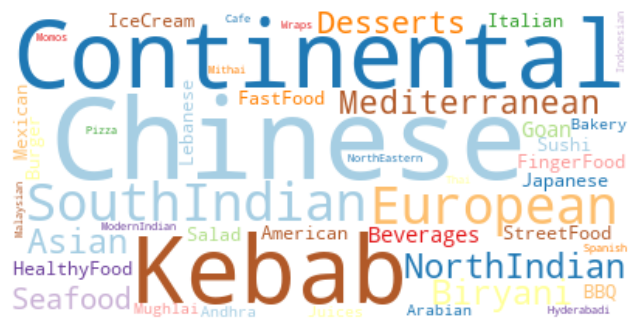

In [147]:


words_list = clusterlist.keys()
words = list(words_list)  # Convert keys to a list

strr = ' '.join(words)
wordcloud = WordCloud(background_color='white', min_font_size=1, colormap='Paired').generate(strr)

# Save the word cloud as an image
wordcloud.to_file("wordcloud.png")

# Display the word cloud using matplotlib
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [148]:
meta_df.Name.unique

<bound method Series.unique of 0                             Beyond Flavours
1                                    Paradise
2                                    Flechazo
3              Shah Ghouse Hotel & Restaurant
4                  Over The Moon Brew Company
                        ...                  
100                                 IndiBlaze
101                              Sweet Basket
102                          Angaara Counts 3
103                               Wich Please
104    Republic Of Noodles - Lemon Tree Hotel
Name: Name, Length: 104, dtype: object>

In [149]:

# Number of Unique Restaurant
print('Number of Unique Restaurants:',meta_df['Name'].nunique())

Number of Unique Restaurants: 104


In [150]:
# 'Cuisine' feature
# Replacing ',' 
meta_df['Cost'] = meta_df['Cost'].str.replace(',','')

# Converting 'cost' feature to integer datatype
meta_df['Cost'] = meta_df['Cost'].apply(lambda x:int(x))
     


In [151]:
# Creating DataFrame with Restaurant names and their respective cost
restaurant_cost = pd.DataFrame(meta_df.groupby('Name').agg({'Cost':'mean'})).reset_index()
restaurant_cost.sort_values(by = 'Cost',ascending = False,inplace= True)
# restaurant_cost.head()
     

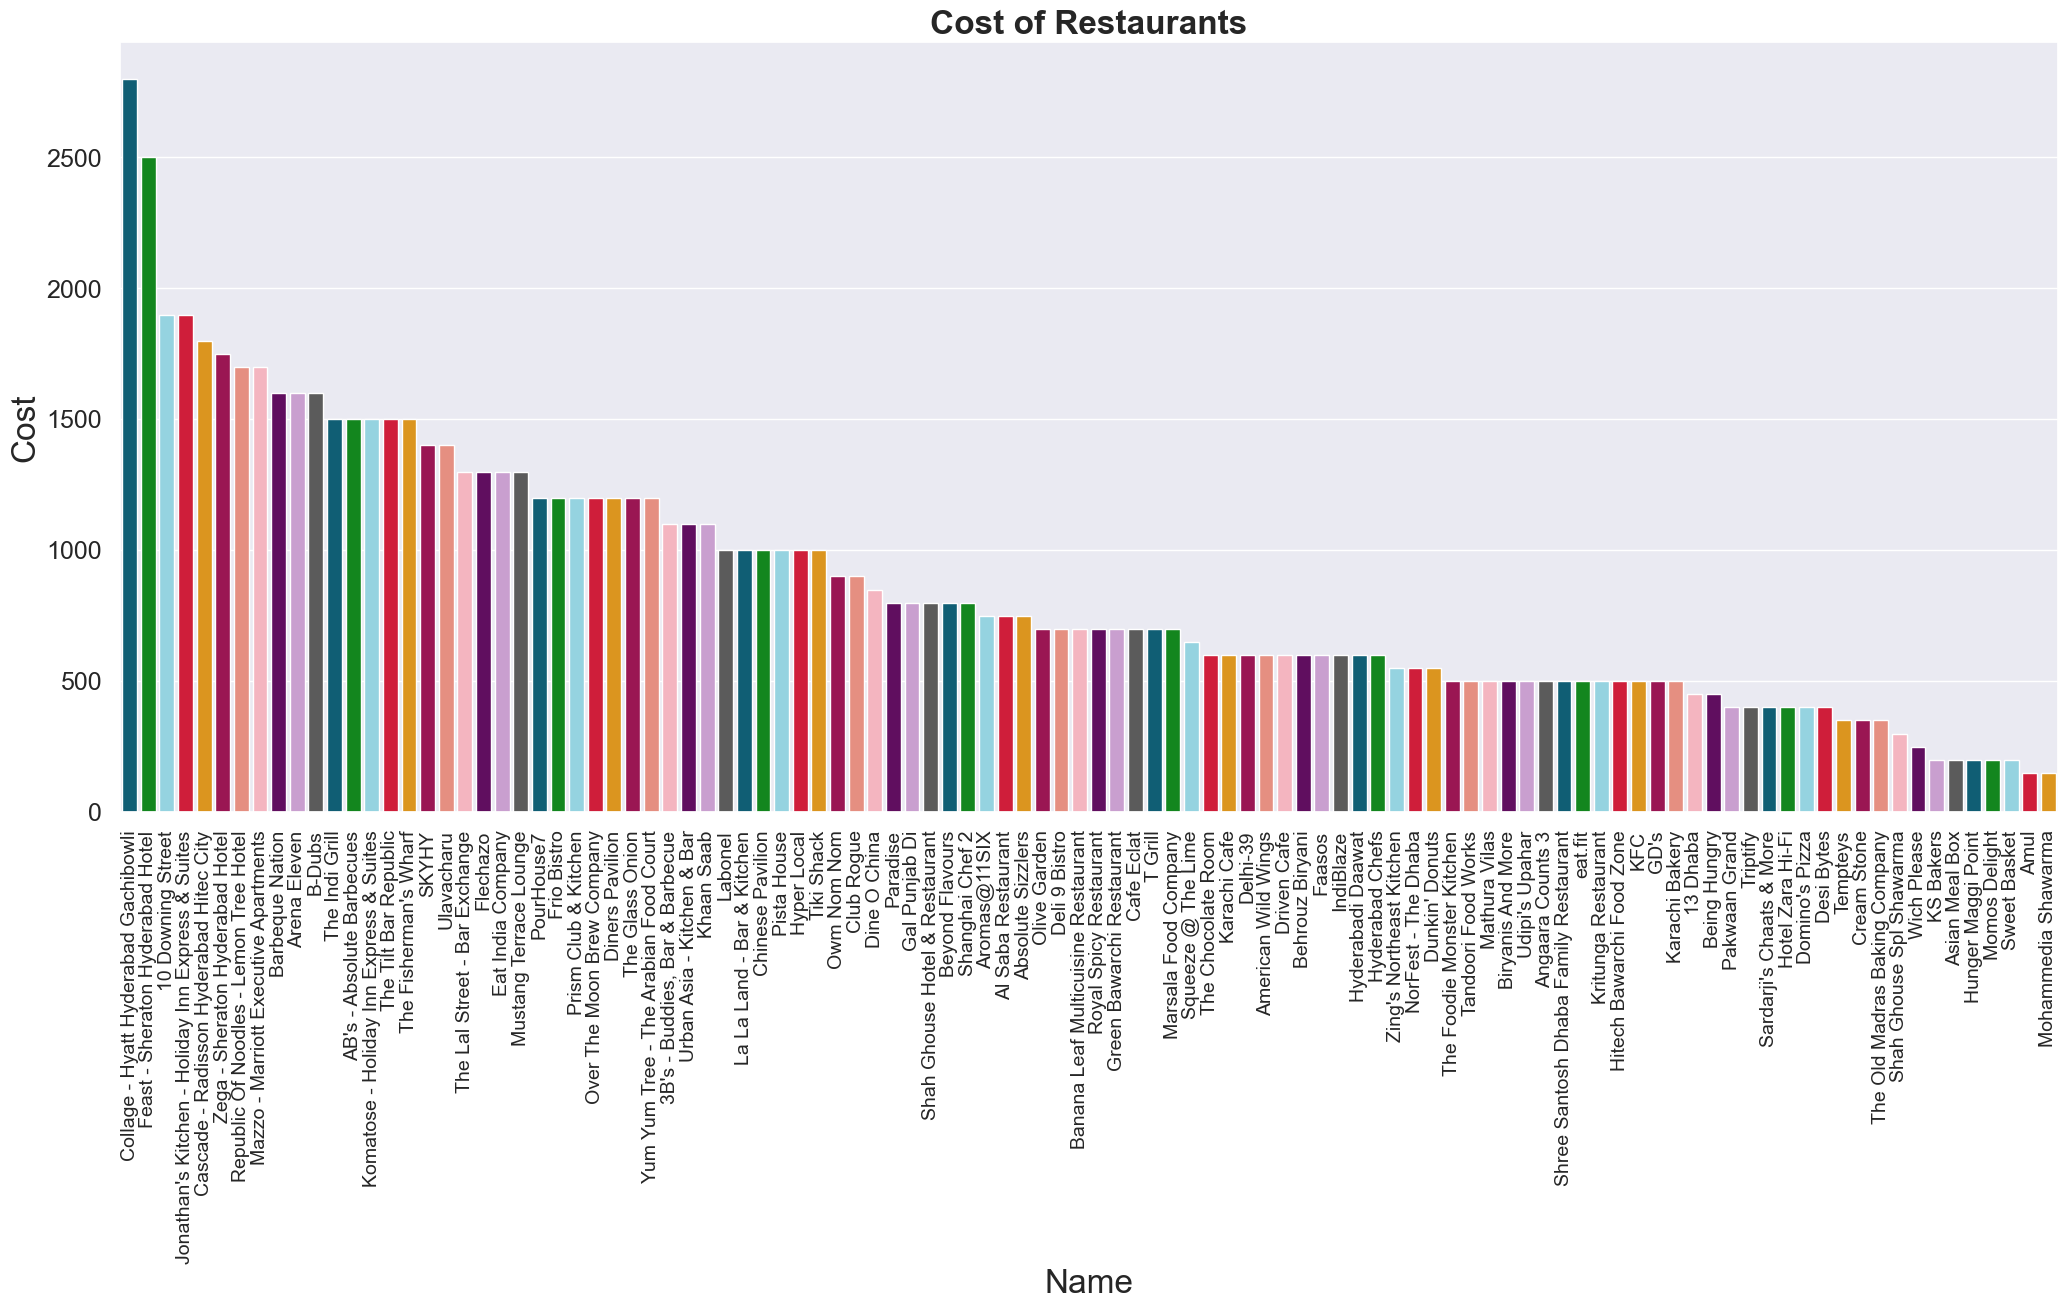

In [152]:
# Visualization of Restaurant names and their respective cost
plt.figure(figsize = (25, 10))
sns.set(font_scale = 2)
sns.barplot(data = restaurant_cost,x = restaurant_cost['Name'],y = restaurant_cost['Cost'],palette=['#006884','#00990E','#89DBEC','#ED0026','#FA9D00','#B00051','#F68370','#FEABB9','#6E006C','#CF97D7','#5B5B5B'])
plt.title('Cost of Restaurants',fontweight='bold')
plt.xticks(rotation = 90,fontsize = 14)
plt.yticks(fontsize = 18)
plt.show()

In [153]:

# Tokenizer
tokenizer = Tokenizer(num_words="MAX_NB_WORDS")
tokenizer.fit_on_texts(meta_df[['Cuisines','Links','Timings']])

In [154]:
# Functions
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    return words

# Applying functions
col_lsts = ['Links','Cuisines','Timings']
for col_lst in col_lsts:
  meta_df[col_lst] = normalize(meta_df[col_lst])
     

In [155]:
meta_df.head()


Name  \
0                 Beyond Flavours   
1                        Paradise   
2                        Flechazo   
3  Shah Ghouse Hotel & Restaurant   
4      Over The Moon Brew Company   

                                               Links  Cost  \
0  httpswwwzomatocomhyderabadbeyondflavoursgachib...   800   
1       httpswwwzomatocomhyderabadparadisegachibowli   800   
2       httpswwwzomatocomhyderabadflechazogachibowli  1300   
3  httpswwwzomatocomhyderabadshahghousehotelresta...   800   
4  httpswwwzomatocomhyderabadoverthemoonbrewcompa...  1200   

                                            Cuisines  \
0  chinese continental kebab european southindian...   
1                         biryani northindian chines   
2            asian mediterranean northindian dessert   
3        biryani northindian chinese seafood beverag   
4  asian continental northindian chinese mediterr...   

                                             Timings  
0             12noon to 330pm 630pm to 1130pm monsun  
1                                     11 am to 11 pm  
2                  1130 am to 430 pm 630 pm to 11 pm  
3                                    12 noon to 2 am  
4  12noon to 11pm mon tue wed thu sun 12noon to 1...

In [156]:
# Tfidf vectorizer
vectorizer = TfidfVectorizer(stop_words= 'english')
X = vectorizer.fit_transform(meta_df['Cuisines'])
     


In [157]:
X.shape


(104, 50)

In [158]:
type(X)


scipy.sparse._csr.csr_matrix

In [159]:

# Converting 'X' object to array
X = X.toarray()

In [160]:
type(X)


numpy.ndarray

Elbow method to find appropriate 'K' value



In [161]:
# 'k-means++' would initialize the centroids far from each other because intializing the centroids nearby could lead to improper clustering


In [164]:
def KElbowvisualizer(metric):
  model = KMeans(init="k-means++",max_iter=300,random_state=0)
  plt.figure(figsize=(10,5))
  sns.set(font_scale = 1)
  visualizer = KElbowVisualizer(model, k=(2,20),metric= metric, timings= False, locate_elbow= True)
  # plt.title(fontweight='bold')
  # # Fit the data to the visualize
  visualizer.fit(X)  
  visualizer.poof()

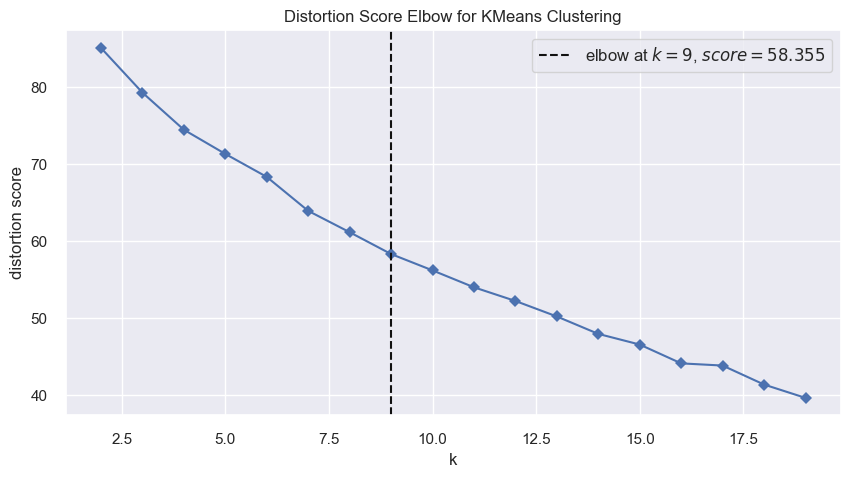

In [165]:

# KElbowvisualizer with metric as 'distortion
KElbowvisualizer('distortion')

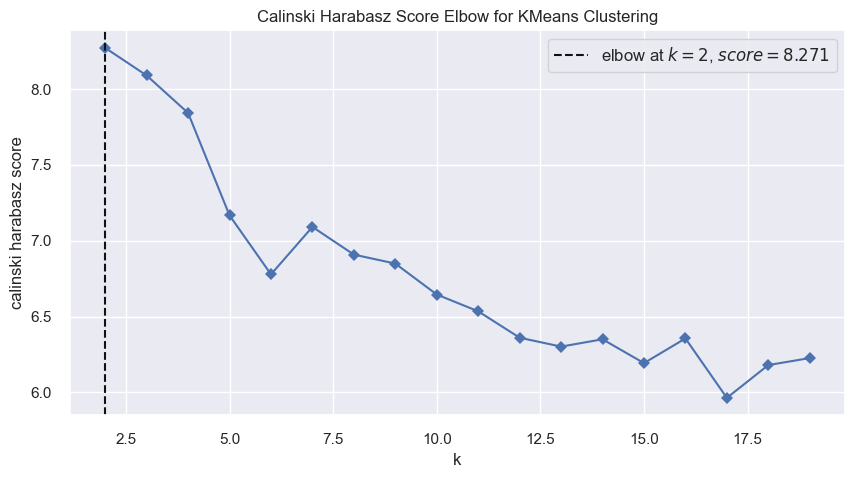

In [166]:

# KElbowvisualizer with metric as 'calinski_harabasz'
KElbowvisualizer('calinski_harabasz')

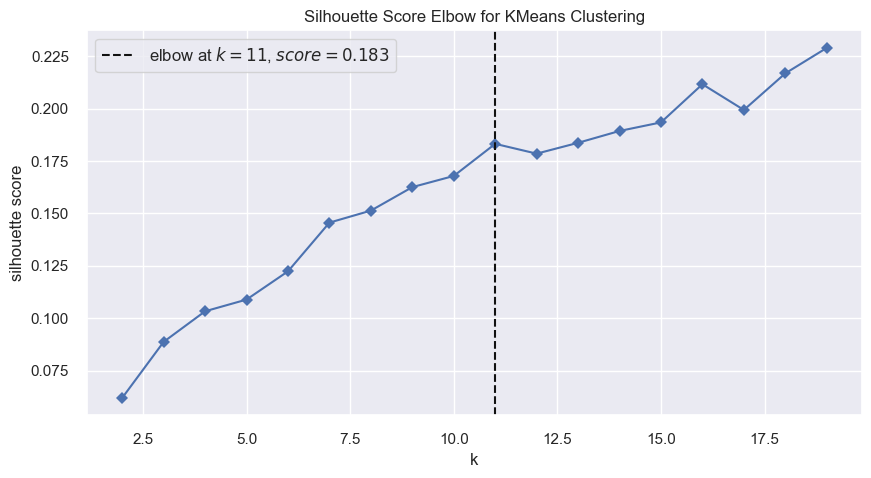

In [167]:

# KElbowvisualizer with metric as 'silhouette'
KElbowvisualizer('silhouette')

K Means Clustering K=9



In [168]:
# looks like we can go with 14 clusters.
# Creating an object for K Means clustering
kmeans= KMeans(n_clusters=14, init= 'k-means++',max_iter=300, n_init=1,random_state = 0)
     

In [169]:
kmeans.fit(X)


KMeans(n_clusters=14, n_init=1, random_state=0)

In [170]:

#predict the labels of clusters.
labels = kmeans.fit_predict(X)

In [171]:

# Clusters center
clusters_center = kmeans.cluster_centers_

In [173]:
# Testin

X_new= vectorizer.transform([meta_df['Cuisines'][15]])

y_pred_new= kmeans.predict(X_new)[0]

y_pred_new

3

In [174]:

# Silhouette score is for model validation for K-means,Hierarichical clustering.
# Silhouette Coefficient ranges between -1 to +1.
# Higher the Silhouette Coefficient better the clustering.

Model Validation



In [176]:
#Model Validation


# Model Validation
# silhouette score of my clusters
print("Silhouette Coefficient: %0.3f"%silhouette_score(X, kmeans.labels_))

Silhouette Coefficient: 0.190


For n_clusters = 10 The average silhouette_score is : 0.1679
For n_clusters = 11 The average silhouette_score is : 0.1832
For n_clusters = 12 The average silhouette_score is : 0.1785
For n_clusters = 13 The average silhouette_score is : 0.1837
For n_clusters = 14 The average silhouette_score is : 0.1893
For n_clusters = 15 The average silhouette_score is : 0.1934


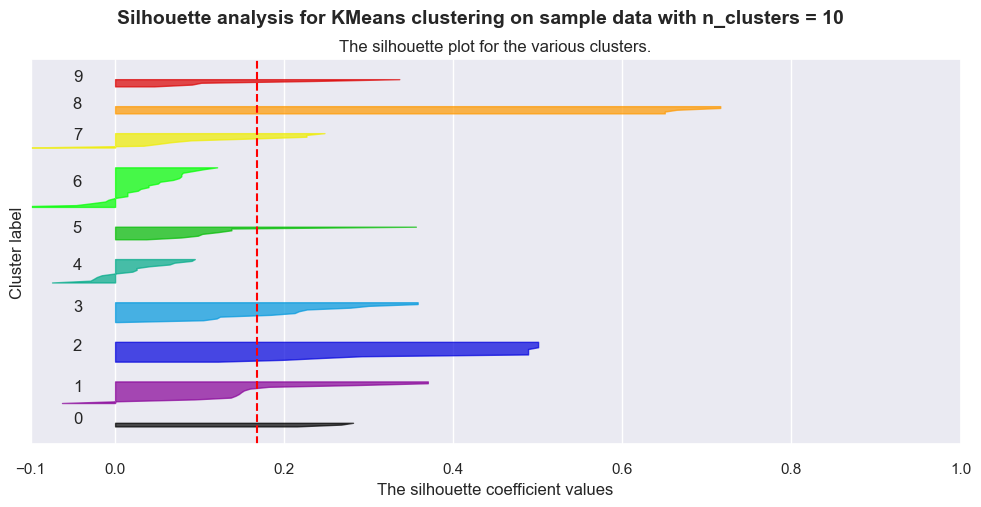

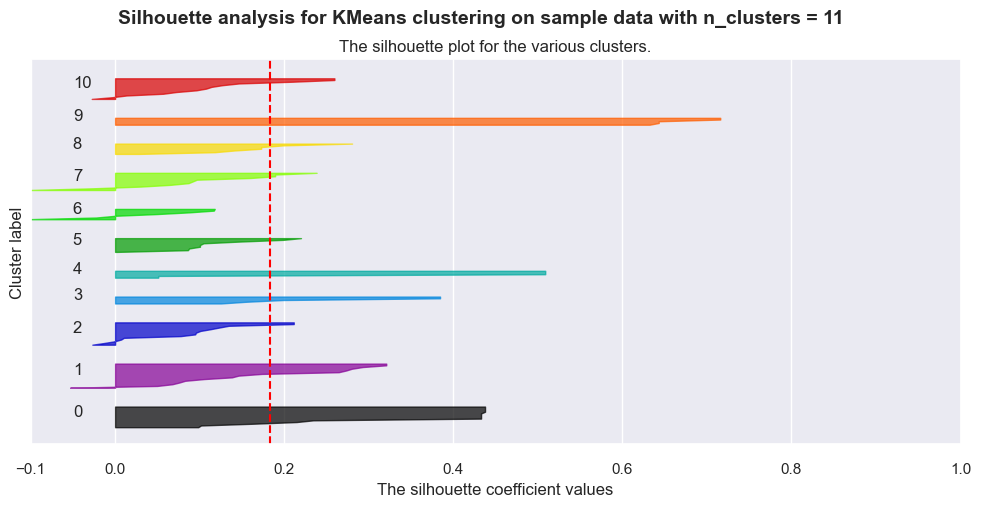

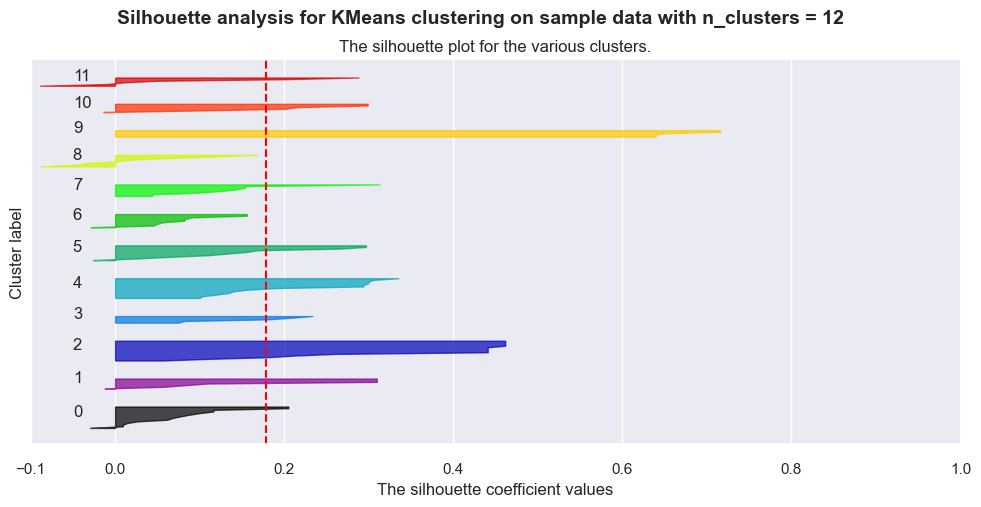

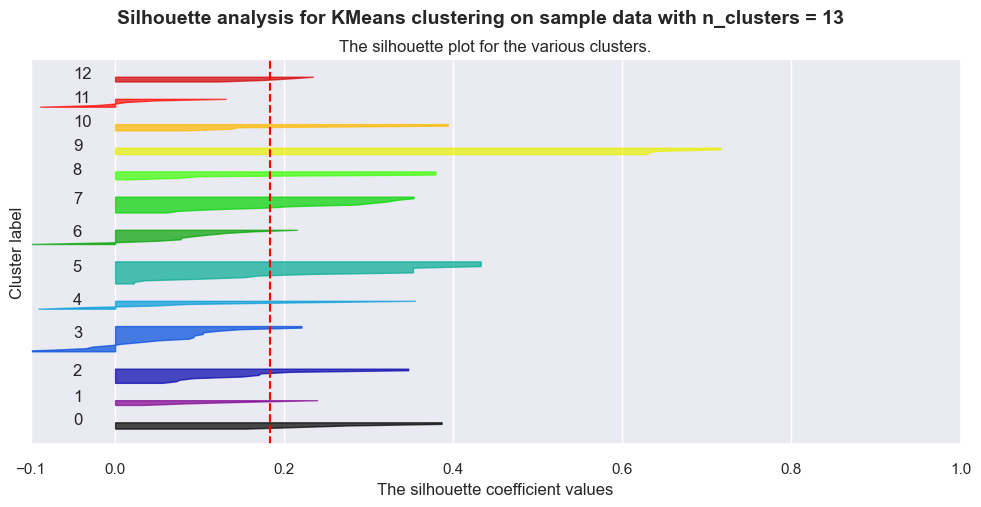

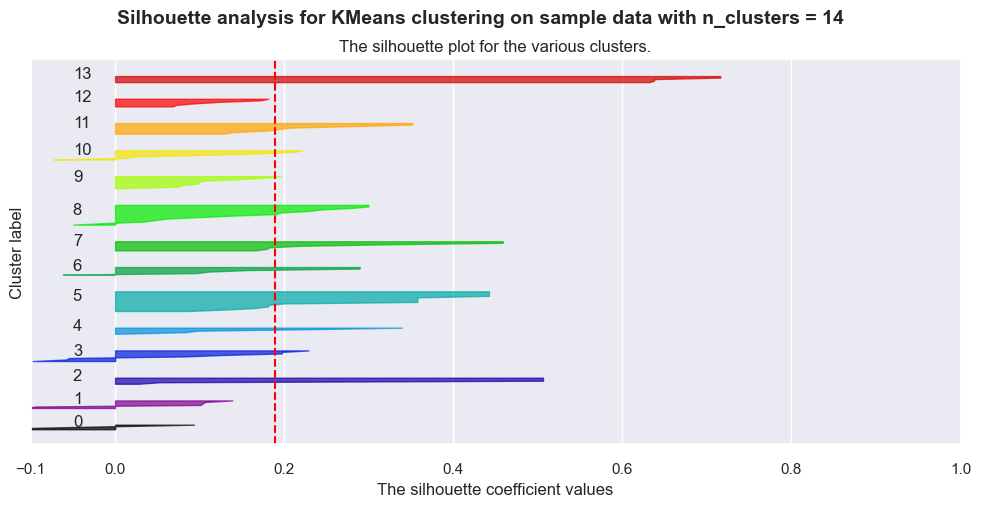

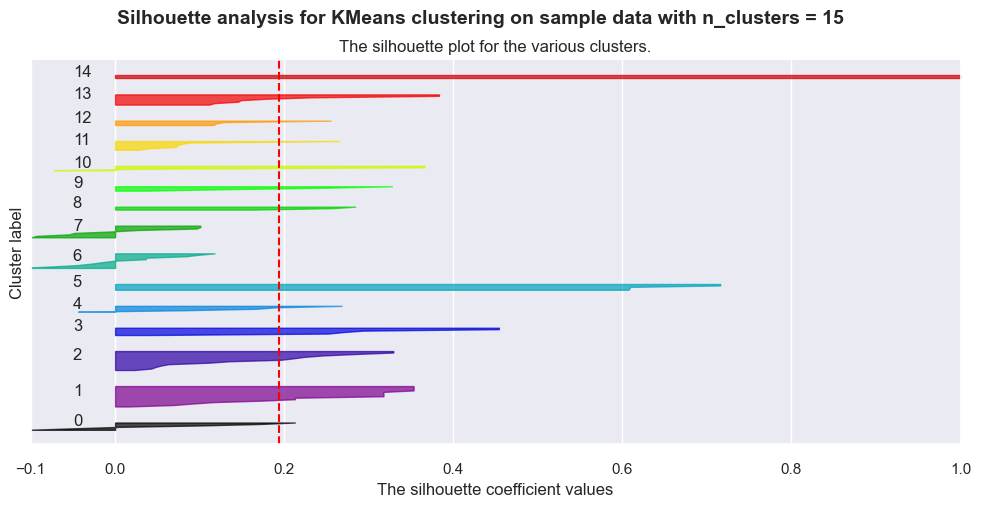

In [177]:
range_n_clusters = [10, 11, 12, 13, 14, 15]
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(12, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters,init= 'k-means++',random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    # print("For n_clusters =", n_clusters,
    #       "The average silhouette_score is :", round(silhouette_avg,4))

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", round(silhouette_avg,4))
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
plt.show()

In [179]:

# Creating new feature to store labels
meta_df['Kmeans_labels'] = kmeans.labels_

In [181]:
Kmeans_labels_count = pd.DataFrame(meta_df.groupby(['Kmeans_labels'])['Cuisines'].count()).reset_index()


In [182]:

# Function for Labels with n number of observations
def labelsnobs(dataframe,x_value,y_value,palette_type,title,y_label):
  plt.figure(figsize = (20, 8))
  sns.set(font_scale = 2)
  sns.barplot(data = dataframe,x = x_value,y = y_value,palette=palette_type)
  plt.title(title,fontweight='bold')
  plt.ylabel(y_label)
  plt.xticks(rotation = 90,fontsize = 14)
  plt.yticks(fontsize = 18)
  plt.show()

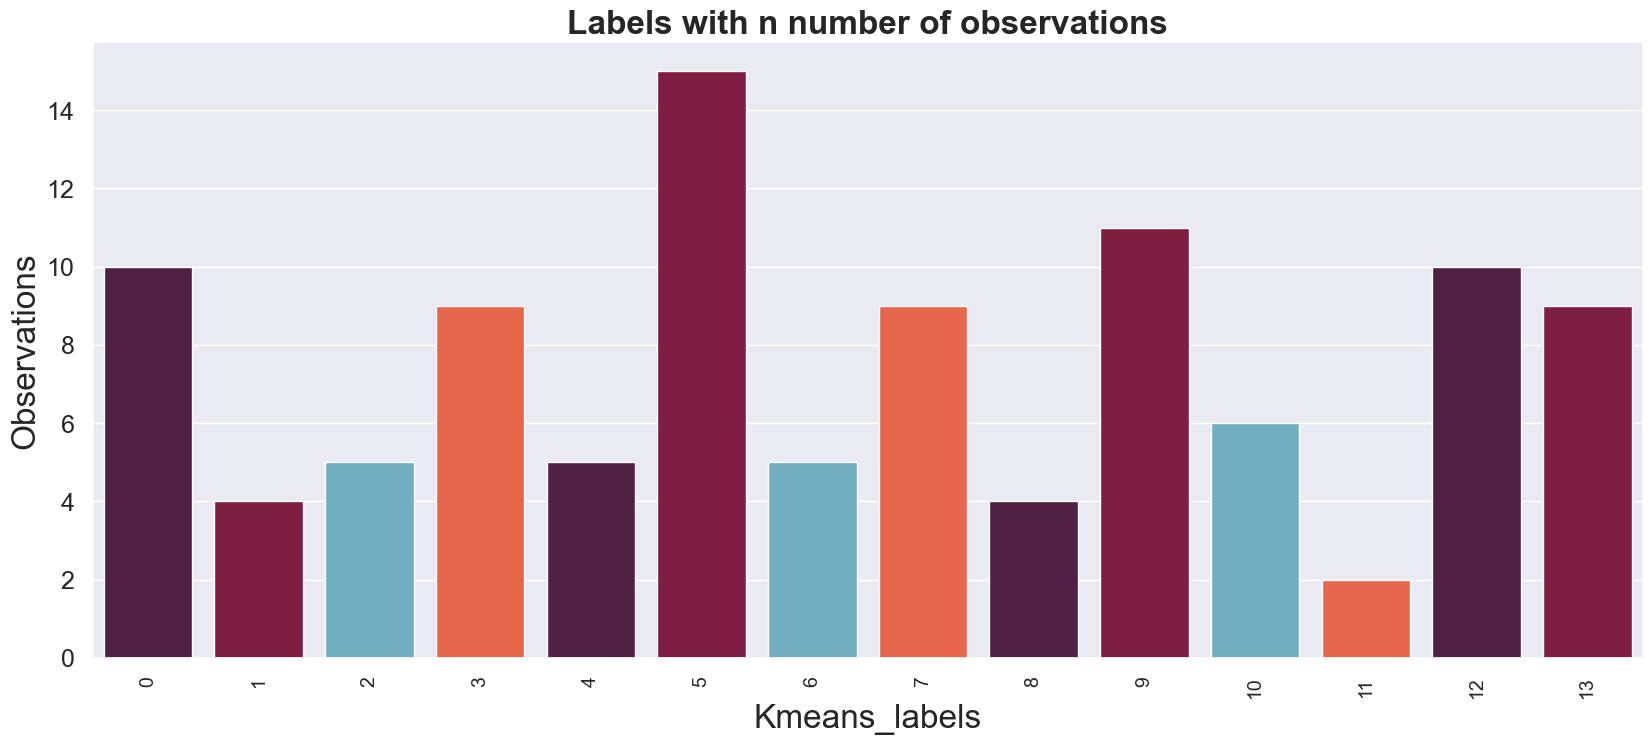

In [184]:
labelsnobs(Kmeans_labels_count,Kmeans_labels_count['Kmeans_labels'],Kmeans_labels_count['Cuisines'],['#581845','#900C3F','C70039','#FF5733'],'Labels with n number of observations','Observations')


In [186]:
# Getting terms
terms = vectorizer.get_feature_names_out() 

     

In [187]:
# Top terms(words) in  per cluster set
print('\033[1m' + 'Top terms in each cluster:' + '\033[0m')
cuisines_list = []
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
for i in range(14):
  num = str(i)
  # print('\033[1m' + 'Cluster:' + '\033[0m',i, end='')
  print('\033[1m' + 'Cluster:' + num + '\033[0m', end='')
  for ind in order_centroids[i, :10]:
    cuisines_list.append(terms[ind])
  print(cuisines_list)
  cuisines_list = []

Top terms in each cluster:
Cluster:0['desserts', 'beverag', 'fastfood', 'american', 'cafe', 'burger', 'lebanes', 'arabian', 'streetfood', 'mughlai']
Cluster:1['kebab', 'fingerfood', 'northindian', 'burger', 'american', 'italian', 'southindian', 'chines', 'chinese', 'continent']
Cluster:2['andhra', 'biryani', 'northindian', 'chines', 'chinese', 'hyderabadi', 'southindian', 'continental', 'healthyfood', 'goan']
Cluster:3['fastfood', 'salad', 'northindian', 'pizza', 'burger', 'streetfood', 'burg', 'chinese', 'american', 'asian']
Cluster:4['mediterranean', 'european', 'northindian', 'asian', 'bbq', 'dessert', 'kebab', 'continental', 'chinese', 'healthyfood']
Cluster:5['italian', 'continental', 'northindian', 'asian', 'chinese', 'southindian', 'salad', 'kebab', 'european', 'healthyfood']
Cluster:6['continent', 'northindian', 'chinese', 'healthyfood', 'goan', 'fingerfood', 'fastfood', 'european', 'dessert', 'continental']
Cluster:7['dessert', 'bakery', 'icecream', 'cafe', 'fastfood', 'mithai

In [189]:
# Grouping 'Kmeans_labels' and 'Name' feature
Kmeans_labels_name = pd.DataFrame(meta_df.groupby(['Kmeans_labels'])['Name'],columns = ['KMeans_Cluster_labels','Restaurants'])
Kmeans_labels_name.set_index('KMeans_Cluster_labels', inplace=True)

In [190]:
for i in range(0,14):
  num = str(i)
  print('\033[1m' + 'Cluster:'+ num + '\033[0m')
  print(Kmeans_labels_name['Restaurants'][i])

Cluster:0
7     Shah Ghouse Spl Shawarma
22                      B-Dubs
42                Karachi Cafe
58                    Tempteys
59                   KS Bakers
71           Eat India Company
73                 Driven Cafe
83                        GD's
89         Mohammedia Shawarma
94              Dunkin' Donuts
Name: Name, dtype: object
Cluster:1
8                       Hyper Local
13    The Lal Street - Bar Exchange
44       La La Land - Bar & Kitchen
80              Tandoori Food Works
Name: Name, dtype: object
Cluster:2
36    Banana Leaf Multicuisine Restaurant
37                    Kritunga Restaurant
45                            Owm Nom Nom
46                             Ulavacharu
84                                T Grill
Name: Name, dtype: object
Cluster:3
10                  Sardarji's Chaats & More
15                                       KFC
29                        Hunger Maggi Point
33                                Club Rogue
62     Shree Santosh Dhaba Family Rest

Hierarchical Clustering



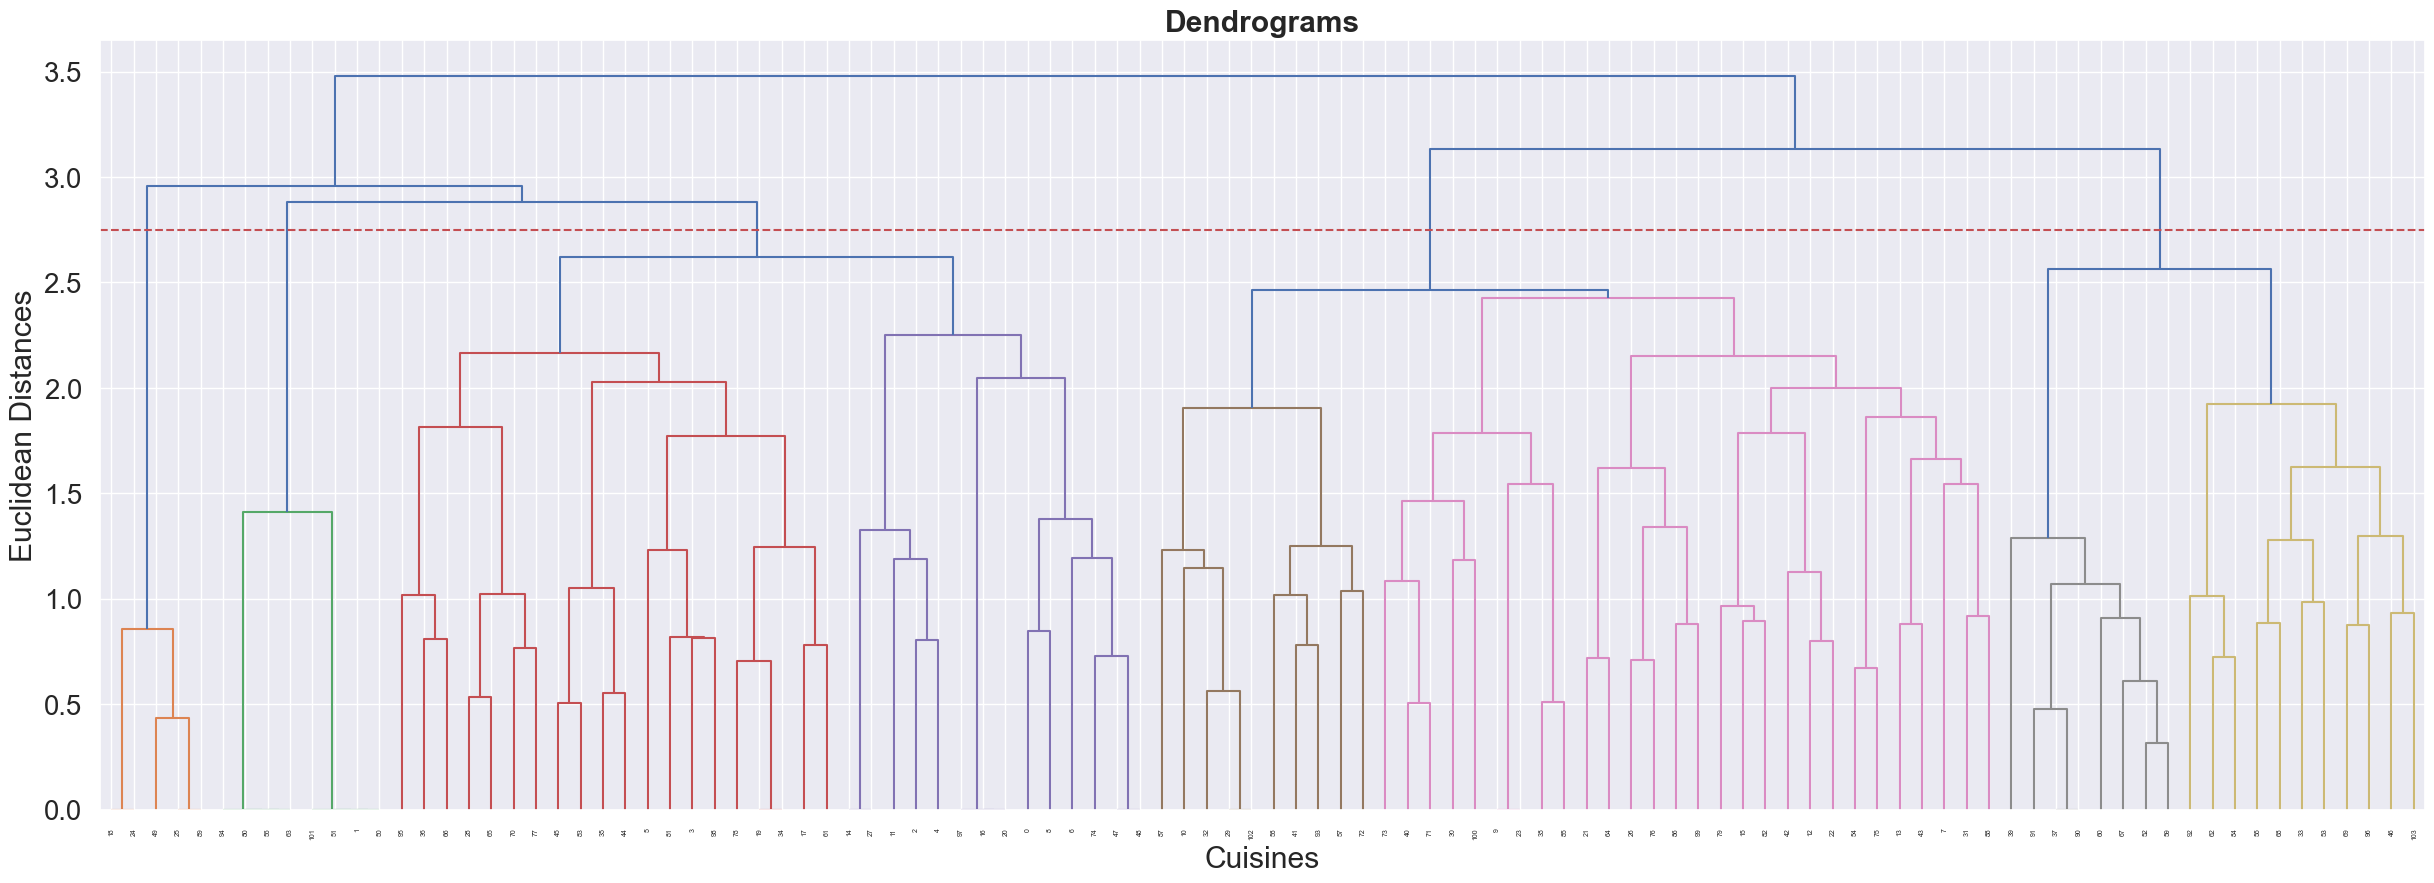

In [191]:
# Hierarchical Clustering for 'Cuisine' feature
plt.figure(figsize=(30,10))
sns.set(font_scale = 1.8)
dend = shc.dendrogram(shc.linkage(X, method='ward'))
plt.title('Dendrograms',fontweight = 'bold')
plt.xlabel('Cuisines')
plt.ylabel('Euclidean Distances')
plt.axhline(y=2.75, color='r', linestyle='--')
plt.show()

Agglomerative Clustering



In [193]:

# To choose appropriate K value

for k in range(2,20):
  aggh = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')  
  aggh.fit(X)
  y_hc=aggh.fit_predict(X)
  print("For n_clusters =", k, "The average silhouette_score is :", round(silhouette_score(X, y_hc),5))

For n_clusters = 2 The average silhouette_score is : 0.06304
For n_clusters = 3 The average silhouette_score is : 0.07949
For n_clusters = 4 The average silhouette_score is : 0.1068
For n_clusters = 5 The average silhouette_score is : 0.10474
For n_clusters = 6 The average silhouette_score is : 0.11906
For n_clusters = 7 The average silhouette_score is : 0.12565
For n_clusters = 8 The average silhouette_score is : 0.12826
For n_clusters = 9 The average silhouette_score is : 0.13974
For n_clusters = 10 The average silhouette_score is : 0.15252
For n_clusters = 11 The average silhouette_score is : 0.16091
For n_clusters = 12 The average silhouette_score is : 0.17093
For n_clusters = 13 The average silhouette_score is : 0.18888
For n_clusters = 14 The average silhouette_score is : 0.19819
For n_clusters = 15 The average silhouette_score is : 0.20475
For n_clusters = 16 The average silhouette_score is : 0.20966
For n_clusters = 17 The average silhouette_score is : 0.21066
For n_clusters = 

In [194]:
# The silhouette_score is reasonably good for k = 4


In [195]:
# Creating an object for AgglomerativeClustering
aggh = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  

In [196]:
# Fitting the model
aggh.fit(X)


AgglomerativeClustering(affinity='euclidean', n_clusters=4)

In [197]:

# Label Prediction
y_hc=aggh.fit_predict(X)

In [198]:

# Labels
print(y_hc)

[0 0 0 0 0 0 0 2 0 2 2 0 2 2 0 2 0 0 3 0 0 2 2 2 3 3 2 0 0 2 2 2 2 1 0 0 0
 1 2 1 2 2 2 2 0 0 1 0 0 3 0 0 1 1 2 1 0 2 2 1 1 0 1 0 2 0 0 1 1 1 0 2 2 2
 0 2 2 0 0 2 0 0 2 0 1 2 2 2 2 3 1 1 1 2 0 0 1 0 0 2 2 0 2 1]


DBSCAN Clustering



In [199]:

# Choosing appropriate min_samples
for samples in range(2,11):
  dbscan = DBSCAN(eps =0.89,min_samples =samples)
  db = dbscan.fit(X)
  dblabels = db.labels_
  print("For minimum samples =", samples, "The average silhouette_score is :", round(silhouette_score(X, dblabels),5))

For minimum samples = 2 The average silhouette_score is : 0.10726
For minimum samples = 3 The average silhouette_score is : 0.04557
For minimum samples = 4 The average silhouette_score is : 0.05662
For minimum samples = 5 The average silhouette_score is : 0.08984
For minimum samples = 6 The average silhouette_score is : 0.06116
For minimum samples = 7 The average silhouette_score is : 0.06116
For minimum samples = 8 The average silhouette_score is : 0.06113
For minimum samples = 9 The average silhouette_score is : 0.06113
For minimum samples = 10 The average silhouette_score is : 0.0481


Looks like we can go with 2 minimum samples



In [200]:

# Creating instances for DBSCAN
dbscan = DBSCAN(eps =0.89,min_samples =2)

In [201]:


# Model fit
db = dbscan.fit(X)

In [202]:

# Storing labels in an object
dblabels = db.labels_
print(dblabels)
     

[ 0  1  1  1  1 -1 -1 -1  0  2 -1 -1  3  4  5 -1  6  1  7  1  6  8  3  2
  7  7  9  5  1  1 -1 -1  1  1  1  1  1  1 10 -1 11 11 -1  4  1  1 -1  1
  1  7  1  1  1 -1 12  1  1 -1 11  1  1  1 13  1  8  1  1  1  1 13  1 11
 -1 11  1 12  9  1  1 -1  1  1  3  1 13 10 14 -1 -1  7  1  1 13 11  1  1
 13  6  1 14 -1  1  1 -1]


In [204]:

# Storing labels in 'DBSCAN_labels' feature
meta_df['DBSCAN_labels'] = db.labels_

In [205]:

# Silhouette score
print( "The average silhouette_score is :", round(silhouette_score(X, dblabels),5))
     

The average silhouette_score is : 0.10726


In [206]:
# Creating an object with (n = len(dblabels)) number of Zeros
sample_cores = np.zeros_like(dblabels)

sample_cores[dbscan.core_sample_indices_] = True
# Calculating number of clusters
n_clusters = len(set(dblabels)) - (1 if -1 in dblabels else 0)

# Number of Clusters
print('Number of clusters:',n_clusters)

Number of clusters: 15


In [208]:
# Creating a DataFrame for DBSCAN Labels visualization
DBSCAN_labels_count = pd.DataFrame(meta_df.groupby('DBSCAN_labels')['Cuisines'].count()).reset_index()

# Filtering out outlier observations
DBSCAN_labels_count_copy = DBSCAN_labels_count[DBSCAN_labels_count['DBSCAN_labels'] == -1]

# Dropping observations that are labeled as Outliers by DBSCAN 
DBSCAN_labels_count = DBSCAN_labels_count.drop(DBSCAN_labels_count_copy.index, axis=0)

# print(labels_count)
     

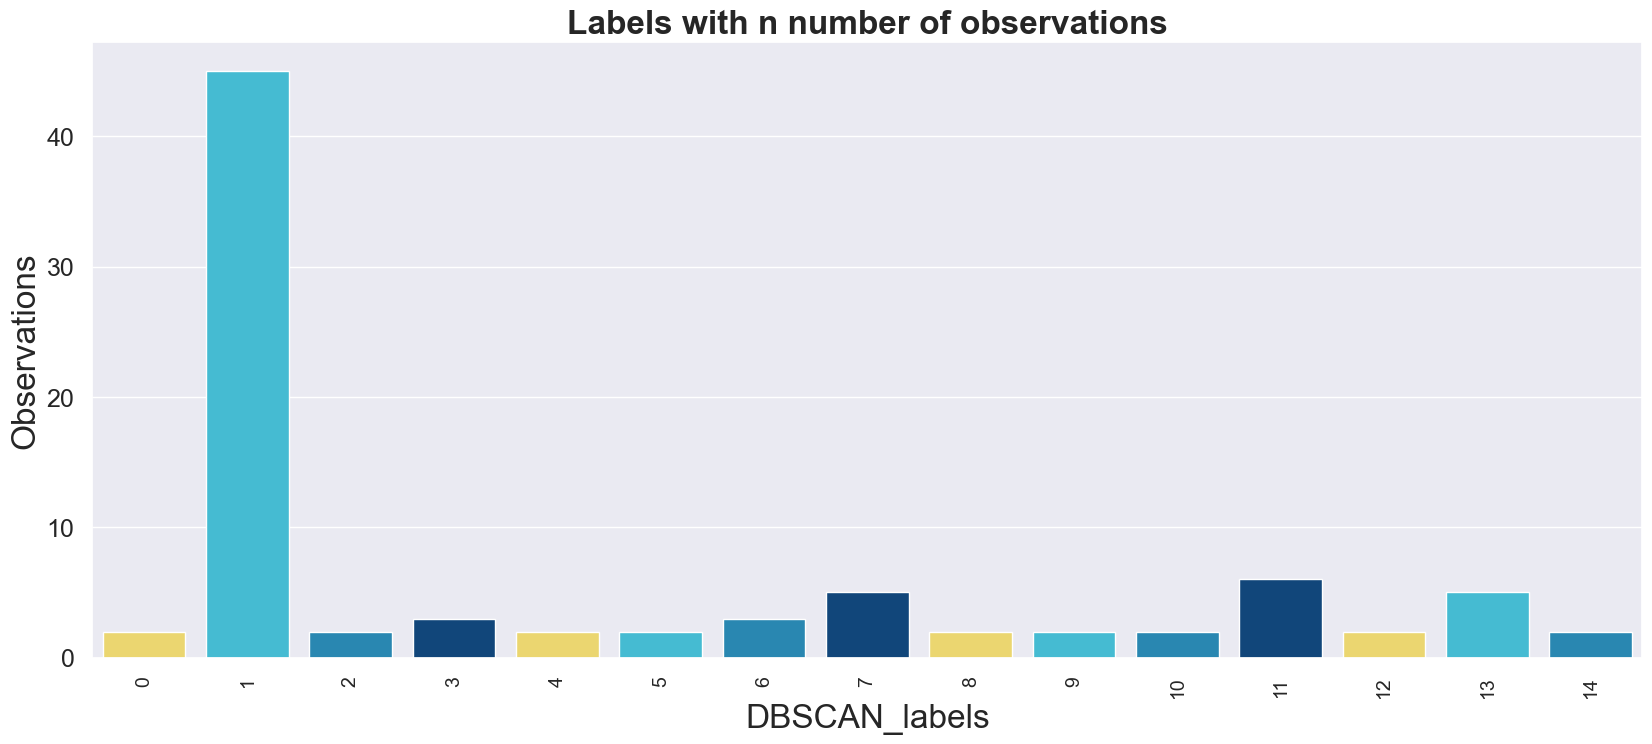

In [209]:
# Visualization of Labels with n number of observations

labelsnobs(DBSCAN_labels_count,DBSCAN_labels_count['DBSCAN_labels'],DBSCAN_labels_count['Cuisines'],['#FFE45C','#2ECBE9','#128FC8','#00468B'],'Labels with n number of observations','Observations')


In [211]:
# Grouping 'DBSCAN_labels' and 'Name' feature
dbscan_labels_name = pd.DataFrame(meta_df.groupby(['DBSCAN_labels'])['Name'],columns = ['dbscan_Cluster_labels','Restaurants'])
# Assigning 'dbscan_Cluster_labels' feature as index
dbscan_labels_name.set_index('dbscan_Cluster_labels', inplace=True)

In [212]:
# Reataurant names with respect to each clusters
for i in range(0,15):
  num = str(i)
  print('\033[1m' + 'Cluster:' + num + '\033[0m')
  print(dbscan_labels_name['Restaurants'][i])

Cluster:0
0    Beyond Flavours
8        Hyper Local
Name: Name, dtype: object
Cluster:1
1                                     Paradise
2                                     Flechazo
3               Shah Ghouse Hotel & Restaurant
4                   Over The Moon Brew Company
17                            Hotel Zara Hi-Fi
19                               Pakwaan Grand
28                             Behrouz Biryani
29                          Hunger Maggi Point
33                                  Club Rogue
34       Mazzo - Marriott Executive Apartments
35                   Green Bawarchi Restaurant
36         Banana Leaf Multicuisine Restaurant
37                         Kritunga Restaurant
38                             The Glass Onion
45                                 Owm Nom Nom
46                                  Ulavacharu
48                              Udipi's Upahar
49                               Mathura Vilas
51                   Hitech Bawarchi Food Zone
52                 

In [213]:
# Reataurant names with respect to each clusters
for i in range(0,15):
  num = str(i)
  print('\033[1m' + 'Cluster:' + num + '\033[0m')
  print(dbscan_labels_name['Restaurants'][i])

Cluster:0
0    Beyond Flavours
8        Hyper Local
Name: Name, dtype: object
Cluster:1
1                                     Paradise
2                                     Flechazo
3               Shah Ghouse Hotel & Restaurant
4                   Over The Moon Brew Company
17                            Hotel Zara Hi-Fi
19                               Pakwaan Grand
28                             Behrouz Biryani
29                          Hunger Maggi Point
33                                  Club Rogue
34       Mazzo - Marriott Executive Apartments
35                   Green Bawarchi Restaurant
36         Banana Leaf Multicuisine Restaurant
37                         Kritunga Restaurant
38                             The Glass Onion
45                                 Owm Nom Nom
46                                  Ulavacharu
48                              Udipi's Upahar
49                               Mathura Vilas
51                   Hitech Bawarchi Food Zone
52                 

## Loading Zomato Restaurant Reviews CSV file



In [214]:
df_r=pd.read_csv('Zomato Restaurant reviews (1).csv')

In [215]:
df_r.shape


(10000, 7)

In [216]:

# Head
df_r.head()

Restaurant              Reviewer  \
0  Beyond Flavours     Rusha Chakraborty   
1  Beyond Flavours  Anusha Tirumalaneedi   
2  Beyond Flavours       Ashok Shekhawat   
3  Beyond Flavours        Swapnil Sarkar   
4  Beyond Flavours                Dileep   

                                              Review Rating  \
0  The ambience was good, food was quite good . h...      5   
1  Ambience is too good for a pleasant evening. S...      5   
2  A must try.. great food great ambience. Thnx f...      5   
3  Soumen das and Arun was a great guy. Only beca...      5   
4  Food is good.we ordered Kodi drumsticks and ba...      5   

                  Metadata             Time  Pictures  
0   1 Review , 2 Followers  5/25/2019 15:54         0  
1  3 Reviews , 2 Followers  5/25/2019 14:20         0  
2  2 Reviews , 3 Followers  5/24/2019 22:54         0  
3    1 Review , 1 Follower  5/24/2019 22:11         0  
4  3 Reviews , 2 Followers  5/24/2019 21:37         0

In [217]:

# Info
df_r.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Restaurant  10000 non-null  object
 1   Reviewer    9962 non-null   object
 2   Review      9955 non-null   object
 3   Rating      9962 non-null   object
 4   Metadata    9962 non-null   object
 5   Time        9962 non-null   object
 6   Pictures    10000 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 547.0+ KB


In [218]:
# Null values treatment
# Dropping rows with Null values
df_r = df_r.dropna(axis =0)

In [219]:

# Some observations in 'Rating' feature contains a String 'Like'
# Dropping row with string('Like') in rating
i = df_r[df_r['Rating']=='Like'].index
print('Index of the observation with String "Like":',i)
df_r.drop(i,inplace=True)

Index of the observation with String "Like": Int64Index([7601], dtype='int64')


In [220]:

# Converting 'Rating' feature to Float datatype
df_r['Rating'] = df_r['Rating'].apply(lambda x: float(x))

In [221]:
# Summary
df_r.describe()

Rating     Pictures
count  9954.000000  9954.000000
mean      3.600261     0.751959
std       1.483573     2.575819
min       1.000000     0.000000
25%       3.000000     0.000000
50%       4.000000     0.000000
75%       5.000000     0.000000
max       5.000000    64.000000

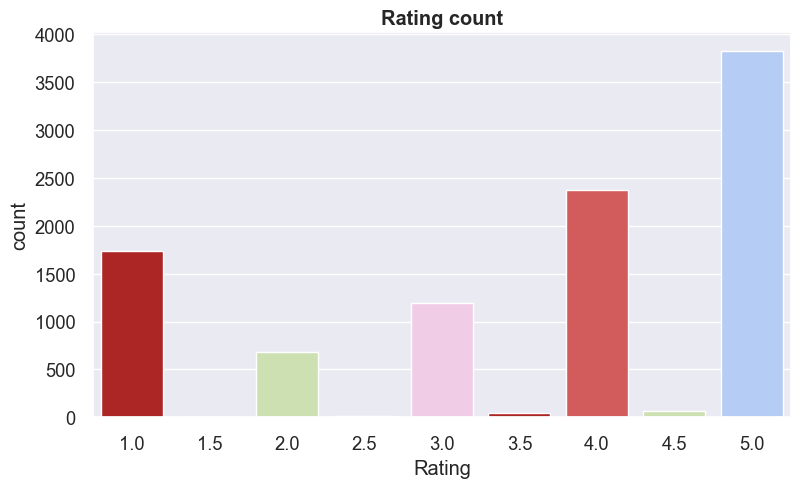

In [222]:
# Count plot for Rating
plt.figure(figsize = (9,5))
sns.set(font_scale = 1.2)
sns.countplot(x='Rating',data = df_r,palette = ['#C21010','#E64848','#CFE8A9','#ABC9FF','#F6C6EA'])
plt.title('Rating count',fontweight = 'bold')
plt.show()
     

# Almost 75% of the ratings are good.
     

In [223]:
# Creating a feature to store the length of the reviews
df_r['Review_length'] = df_r['Review'].apply(len)

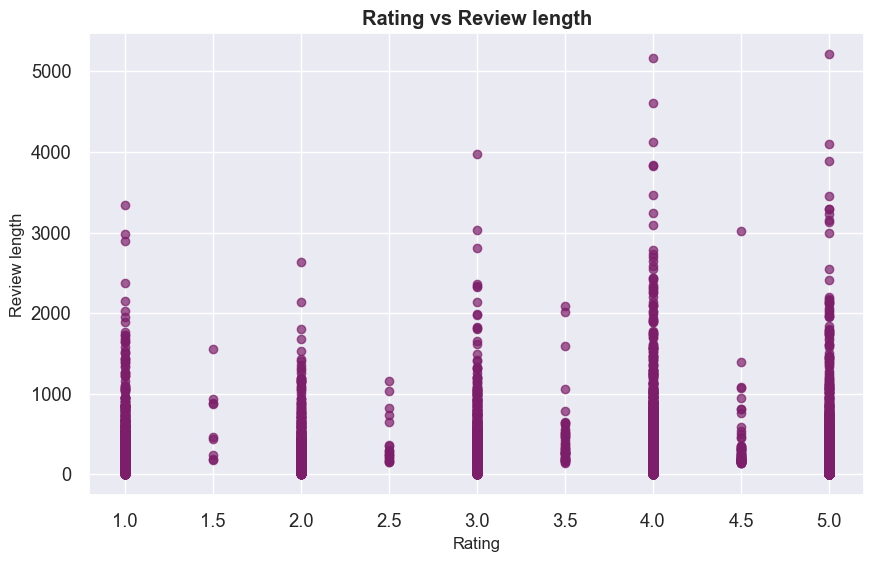

In [224]:
# Scatter plot for Rating vs Review length
plt.figure(figsize=(10,6))
plt.scatter(x=df_r['Rating'],y=df_r['Review_length'],color= '#7D1E6A',alpha = 0.7)
xticks = [1,1.5,2,2.5,3,3.5,4,4.5,5]
plt.title('Rating vs Review length',fontweight = 'bold')
plt.xlabel('Rating',fontsize = 12)
plt.ylabel('Review length',fontsize = 12)
plt.xticks(xticks)
plt.show()
     

In [225]:
# From the above scatter plot we could see the Rating doesn't dependent on Review length


In [226]:
# df_r.head()


In [227]:
df_r.reset_index(inplace = True)


In [228]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [229]:
# Stop words
stop_words = stopwords.words('english')
# Rest words
rest_word = ['order','restaurant','taste','ordered','good','food','table','place','one','also']

In [230]:
df_r['Reviews_txt_processed'] = df_r['Review'] 


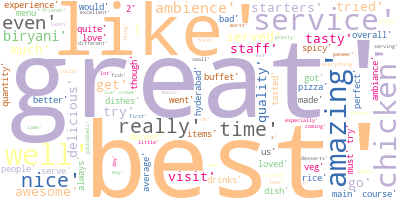

In [231]:
# Wordcloud for Reviews
# df_r['Review'] = df_r['Review'].astype(str)
df_r['Reviews_txt_processed'] = df_r['Reviews_txt_processed'].map(lambda x: re.sub('[,\.!?]','', x))
df_r['Reviews_txt_processed'] = df_r['Reviews_txt_processed'].map(lambda x: x.lower())
df_r['Reviews_txt_processed'] = df_r['Reviews_txt_processed'].map(lambda x: x.split())
df_r['Reviews_txt_processed'] = df_r['Reviews_txt_processed'].apply(lambda x: [words for words in x if words not in stop_words])
df_r['Reviews_txt_processed'] = df_r['Reviews_txt_processed'].apply(lambda x: [words for words in x if words not in rest_word])
df_r['Reviews_txt_processed'] = df_r['Reviews_txt_processed'].astype(str)

ps = PorterStemmer() 
long_string = ','.join(list(df_r['Reviews_txt_processed'].values))
# print(long_string)
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=13,colormap = 'Accent')
wordcloud.generate(long_string)
wordcloud.to_image()

In [232]:

# Positive Reviews(Ratings greater than 3)
pos_rev = df_r[df_r['Rating'] > 3]

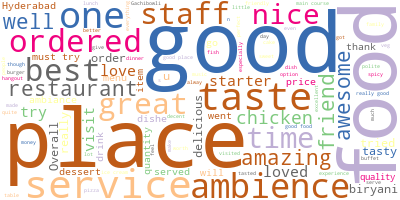

In [233]:

# Wordcloud for Positive reviews
long_string = ','.join(list(pos_rev['Review'].values))
long_string
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=13,colormap = 'Accent')
wordcloud.generate(long_string)
wordcloud.to_image()

In [234]:

# Negative Reviews(Ratings lesser than 3)
neg_rev = df_r[df_r['Rating'] < 3]

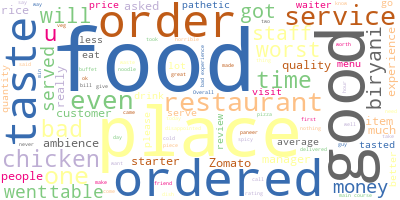

In [235]:
# Wordcloud for Negative reviews
long_string = ','.join(list(neg_rev['Review'].values))
long_string
wordcloud = WordCloud(background_color="white", max_words=100, contour_width=13,colormap = 'Accent')
wordcloud.generate(long_string)
wordcloud.to_image()

In [236]:

# Extracting the number of reviews
df_r['Metadata'] = df_r['Metadata'].str.split(' ')
df_r['Metadata'] = df_r['Metadata'].apply(lambda x: x[0])
df_r['Metadata'] = df_r['Metadata'].apply(lambda x : int(x))

In [237]:

# Creating a dataframe to store top 10 reviewers
top_reviewers = pd.DataFrame(df_r.groupby(['Reviewer','Metadata']).sum()).reset_index()
top_reviewers = top_reviewers.sort_values(by = 'Metadata',ascending = False)
top_reviewers = top_reviewers[:15]
# print(top_reviewers)

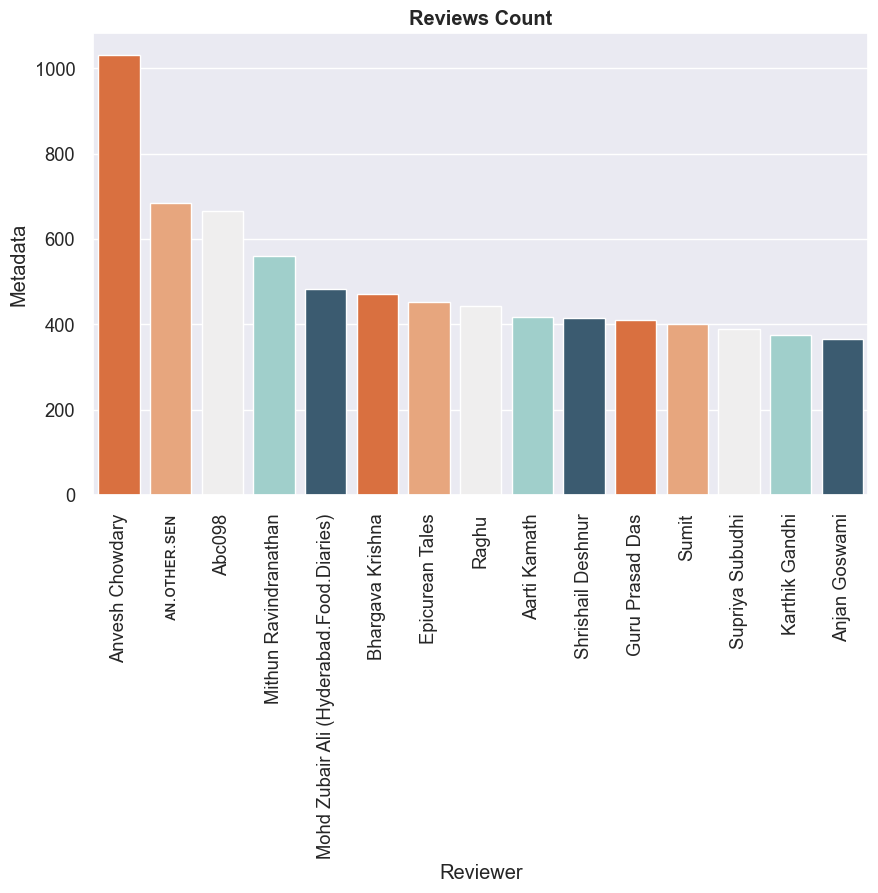

In [238]:
# Visualization of top 10 reviewers
plt.figure(figsize = (10,6))
sns.barplot(data = top_reviewers,x = 'Reviewer',y = 'Metadata',palette = ['#F26627','#F9A26C','#EFEEEE','#98D7D1','#325D79'])
plt.title('Reviews Count',fontweight = 'bold')
plt.xticks(rotation = 90)
plt.show()
     

In [239]:

# Top 10 Restaurants with high average rating
df_r['Rating'] = df_r['Rating'].apply(lambda x: float(x))
avg_ratings = pd.DataFrame(df_r.groupby('Restaurant')['Rating'].mean()).reset_index()
avg_ratings = avg_ratings.sort_values(by = 'Rating',ascending = False)
avg_ratings = avg_ratings[:10]

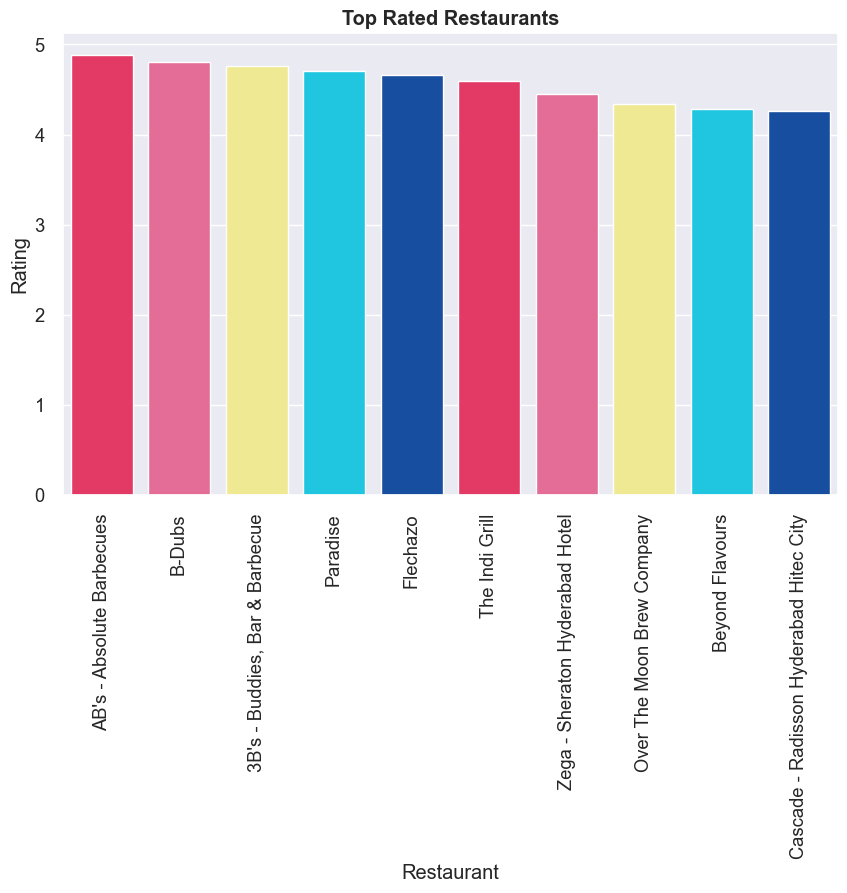

In [240]:

# Visualization of top 10 reviewers
plt.figure(figsize = (10,6))
sns.barplot(data = avg_ratings,x = 'Restaurant',y = 'Rating',palette = ['#FF1D58','#F75990','#FFF685','#00DDFF','#0049B7'])
plt.title('Top Rated Restaurants',fontweight = 'bold')
plt.xticks(rotation = 90)
plt.show()

## Sentiment Analysis

Merging both datasets



In [241]:
# shape of two dataframes
print(meta_df.shape)
print(df_r.shape)

(104, 7)
(9954, 10)


In [243]:

# Storing unique Restaurants from 'Zomato Restaurant names and Metadata' dataframe
rest_names_lst = list(meta_df['Name'].unique())

In [244]:
print('Unique Restaurants from "Zomato Restaurant names and Metadata" dataframe:',len(rest_names_lst))


Unique Restaurants from "Zomato Restaurant names and Metadata" dataframe: 104


In [245]:

# Storing unique Restaurans from 'Zomato Restaurant reviews' dataframe
rest_names_lsts = list(df_r['Restaurant'].unique())

In [246]:
print('Unique Restaurants from "Zomato Restaurant reviews" dataframe:',len(rest_names_lsts))


Unique Restaurants from "Zomato Restaurant reviews" dataframe: 100


In [247]:
# Zomato Restaurant names and Metadata has 104 unique Restaurants.
# Zomato Restaurant reviews has 100 unique Restaurants.
# For merging two dataframes we are to remove non-common Restaurants.
# Storing non common restaurants in lst.
lst = []
for name in rest_names_lst:
  if name not in rest_names_lsts:
    lst.append(name)
     

In [248]:

# List of non-common Restaurants
print('Non common Restaurants:',lst)

Non common Restaurants: ['IndiBlaze', 'Sweet Basket', 'Angaara Counts 3', 'Wich Please', 'Republic Of Noodles - Lemon Tree Hotel']


In [250]:
# Filtering out rows 
final = meta_df
for not_com_rest_names in lst:
  final = final[final['Name'] != not_com_rest_names]
     

In [251]:

# Renaming the column 'Restaurant'
df_r.rename(columns = {'Restaurant':'Name'}, inplace = True)
     

In [252]:


# Merging two dataframes
merged_df = pd.merge(df_r, final, how='left', on='Name')

In [253]:
# Droping less significant features
merged_df.drop(['Time','Metadata','Links','Timings','Kmeans_labels','DBSCAN_labels'],axis = 1,inplace = True)

In [254]:
# Re-indexing the columns
merged_df = merged_df.reindex(columns=['index','Name', 'Reviewer','Review','Reviews_txt_processed','Review_length','Rating','Polarity','Cost','Cuisines'])
     

In [255]:

# Shape
merged_df.shape
     

(9954, 10)

In [256]:

# Head
merged_df.head(2)

index             Name              Reviewer  \
0      0  Beyond Flavours     Rusha Chakraborty   
1      1  Beyond Flavours  Anusha Tirumalaneedi   

                                              Review  \
0  The ambience was good, food was quite good . h...   
1  Ambience is too good for a pleasant evening. S...   

                               Reviews_txt_processed  Review_length  Rating  \
0  ['ambience', 'quite', 'saturday', 'lunch', 'co...            222     5.0   
1  ['ambience', 'pleasant', 'evening', 'service',...            144     5.0   

   Polarity   Cost                                           Cuisines  
0       NaN  800.0  chinese continental kebab european southindian...  
1       NaN  800.0  chinese continental kebab european southindian...

In [257]:
# Info
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9954 entries, 0 to 9953
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  9954 non-null   int64  
 1   Name                   9954 non-null   object 
 2   Reviewer               9954 non-null   object 
 3   Review                 9954 non-null   object 
 4   Reviews_txt_processed  9954 non-null   object 
 5   Review_length          9954 non-null   int64  
 6   Rating                 9954 non-null   float64
 7   Polarity               0 non-null      float64
 8   Cost                   9854 non-null   float64
 9   Cuisines               9854 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 855.4+ KB


In [258]:
# Creating dataframe to store avg rating and avg cost for each reataurant
ratingncost = pd.DataFrame(merged_df.groupby('Name')['Rating','Cost'].mean()).reset_index()
# print(ratingncost)

In [260]:
#Visualization of Restaurant Cost vs Rating
plt.figure(figsize=(40,10))
fig = px.bar(ratingncost, x="Name", y="Cost",color="Rating",width=900, height=700)
fig.update_xaxes(ticks="outside", tickwidth=1, tickcolor='pink',tickangle=90, ticklen=10)
fig.update_layout(title_text="Restaurant Cost vs Rating")
fig.show()

<Figure size 4000x1000 with 0 Axes>

## Vader Model



In [261]:
# Text Preprocessing for Vader Model


In [262]:
# Tokenizer
tokenizer_vader = Tokenizer(num_words="MAX_NB_WORDS")
tokenizer_vader.fit_on_texts(merged_df['Review'])

In [263]:
# merged_df.head(2)


In [264]:

# Appling text processing function
merged_df['Review'] = merged_df['Review'].apply(normalize)

In [265]:

# Replacing comma
merged_df['Review'] = merged_df['Review'].apply(lambda x: ','.join(x))
merged_df['Review'] = merged_df['Review'].apply(lambda x: x.replace(',',''))

In [266]:
# Function for removing Stopwords
def remove_stop_words(col_name):
  stop = stopwords.words('english')
  merged_df[col_name] = merged_df[col_name].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
     

In [267]:

# Applying function to remove stopwords
remove_stop_words('Review')

In [268]:

# Creating an object for SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [269]:
# Applying 'SentimentIntensityAnalyzer' for Reviews
merged_df['SIA_polarity'] = merged_df['Review'].apply(lambda x: sia.polarity_scores(x))

In [270]:


# Function for extracting Polarity values
def SIA_ploaritysep(new_col,dict_key):
  merged_df[new_col] = merged_df['SIA_polarity'].apply(lambda x: x[dict_key])

In [271]:
# Applying 'nltkploaritysep' function
SIA_ploaritysep('SIA_Compound','compound')
SIA_ploaritysep('SIA_Positive','pos')
SIA_ploaritysep('SIA_Neutral','neu')
SIA_ploaritysep('SIA_Negative','neg')

In [272]:
# Function for bar plot in vader dataframe
def barplotpolarity(x,y,palette):
  plt.figure(figsize = (10,7))
  sns.barplot(data = merged_df,x = x,y = y,palette = palette)
  plt.show()

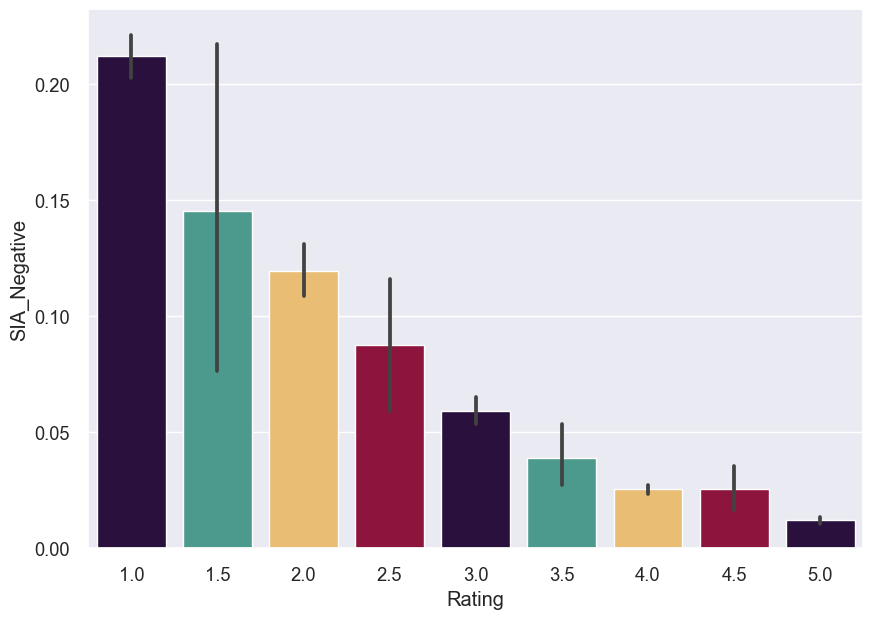

In [273]:
# Neagtive Polarity
barplotpolarity('Rating','SIA_Negative',['#2A0944','#3FA796','#FEC260','#A10035'])
     

From the above graph we could clearly see the decrease in Negative polarity with increase in Rating

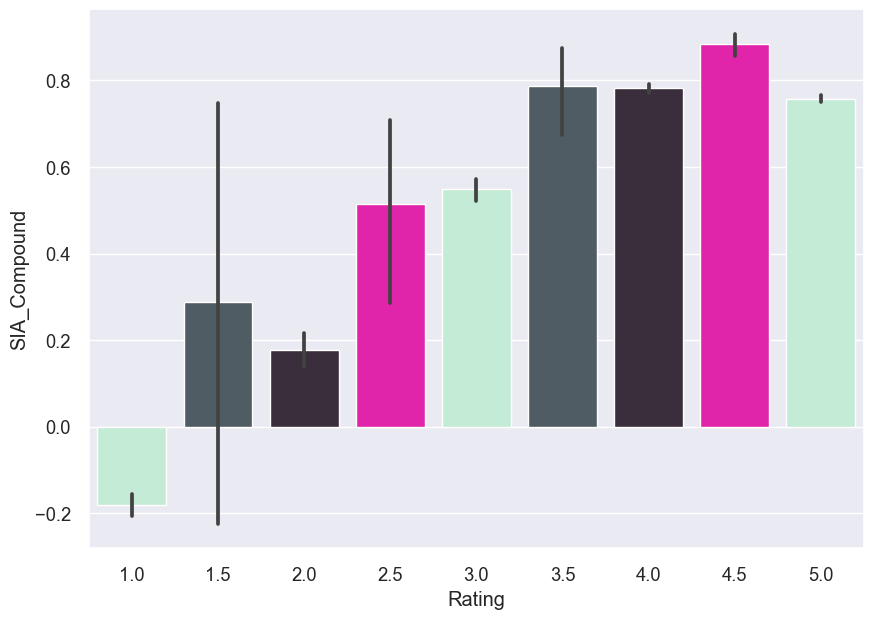

In [275]:
# Compound Polarity
barplotpolarity('Rating','SIA_Compound',['#BDF2D5','#4B5D67','#3C2C3E','#FF06B7'])
     


From the above graph we could clearly see the increase in Compound polarity with increase in Rating

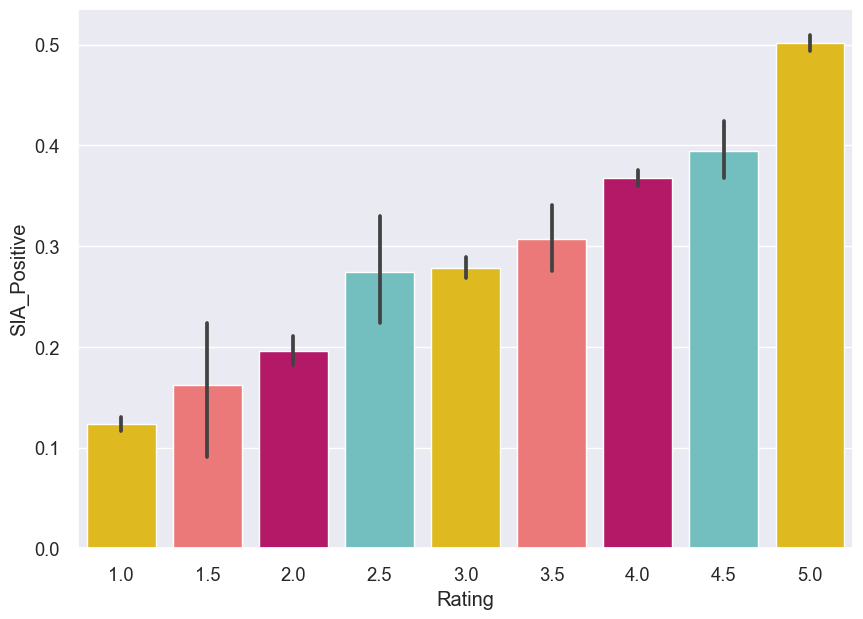

In [277]:

# Positive Polarity
barplotpolarity('Rating','SIA_Positive',['#FFCC00','#FF6666','#CC0066','#66CCCC'])

From the above graph we could clearly see the increase in Positive polarity with increase in Rating.



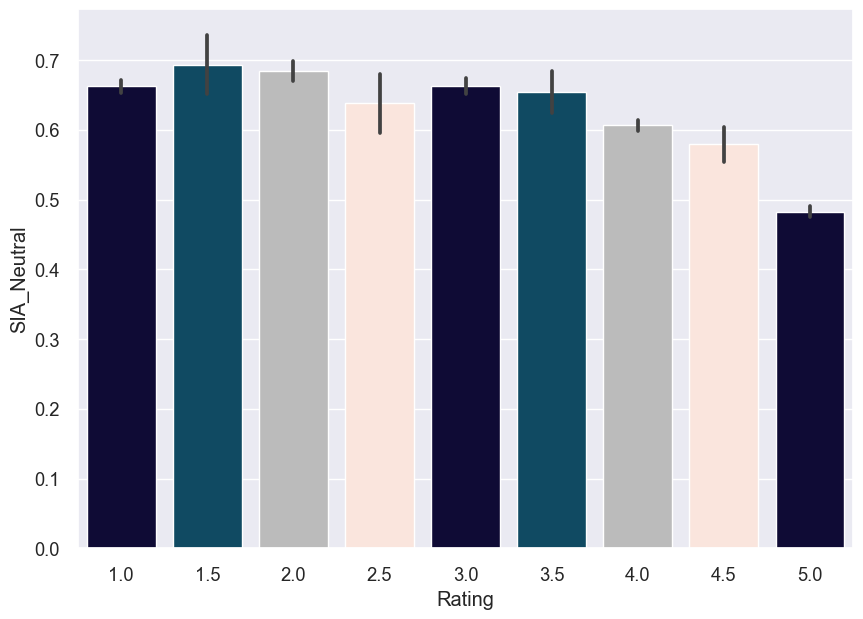

In [278]:
# Neutral Polarity
barplotpolarity('Rating','SIA_Neutral',['#0A043C','#03506F','#BBBBBB','#FFE3D8'])

From the above graph we could clearly see the kind of no difference in Neutral polarity with the Rating.



In [279]:

# Function for Polarity Distribution plot
def dist_polarity(df,xlabel,color):
  plt.figure(figsize=(8,5))
  xticks = [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]
  sns.distplot(df,bins = 100,color= color)
  plt.title('Distribution plot for Polarity',fontsize = 12,fontweight = 'bold')
  plt.xlabel(xlabel,fontsize = 12)
  plt.ylabel('Density',fontsize = 12)
  plt.xticks(xticks,fontsize = 8)
  plt.show()

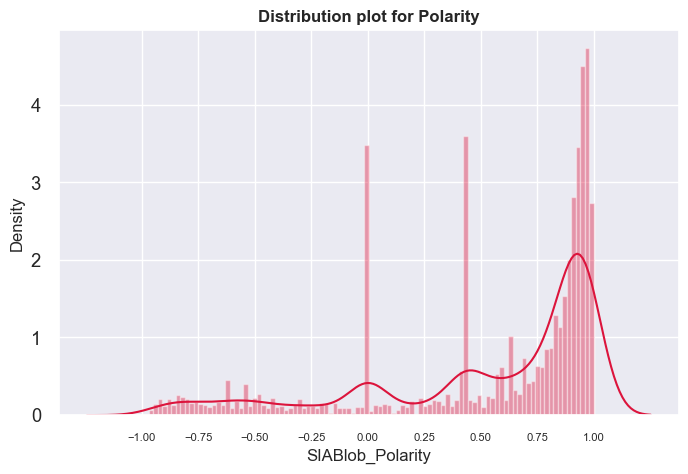

In [280]:
# SIA distribution plot
dist_polarity(merged_df['SIA_Compound'],'SIABlob_Polarity','crimson')

In [281]:
# Mapping the sentiments.
# Positive for SIA_Compound > 0
# Negative for SIA_Compound < 0
# Neutral for SIA_Compound = 0
merged_df['SIA_Sentiment'] = merged_df['SIA_Compound'].apply(lambda x: 'Positive' if (x > 0) else ('Negative' if (x<0) else 'Neutral'))
     

In [282]:
# Function for pie chart
def piechart(df,colors):
  pos = (df.value_counts()[0]/df.count())*100
  neg = (df.value_counts()[1]/df.count())*100
  neu = (df.value_counts()[2]/df.count())*100
  # Pie chart for Percentage of Reviews Sentiment
  plt.figure(figsize = (10,6))
  myexplode = [0.05, 0.05, 0.05]
  plt.pie([pos,neg,neu],labels = ['Positive','Neutral','Negative'],autopct='%1.1f%%',explode = myexplode,colors =colors,)
  plt.title('Percentage of Reviews Sentiment')
  plt.show()
     


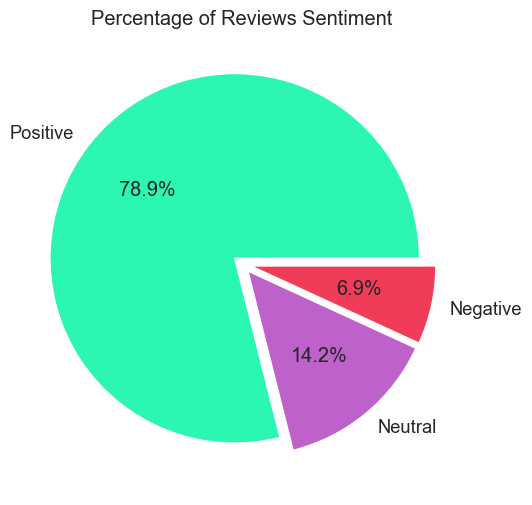

In [283]:
# Pie chart
piechart(merged_df['SIA_Sentiment'],colors = ['#2CF6B3','#BE61CA','#F13C59'])
     

In [284]:

# Reviews Sentiment
merged_df['SIA_Sentiment'].value_counts()

Positive    7857
Negative    1415
Neutral      682
Name: SIA_Sentiment, dtype: int64

In [285]:
# Function for plotting most common words in different sentiments
def word_frequency(df,ylim1,ylim2,title,color):
  vectorizer = TfidfVectorizer(stop_words='english')

  temp = df
  corpus = []
  temp['Review'].apply(lambda x: corpus.append(x))

  text = []
  freq = []
  X = vectorizer.fit_transform(corpus)
  # this will give you words instead of tfidf where tfidf > 0
  X_words = vectorizer.inverse_transform(X) 
  # return tokenizer function used in tfidfvectorizer
  tokenizer = vectorizer.build_tokenizer()

  for idx,words in enumerate(X_words):
      for word in words:
          count = tokenizer(corpus[idx]).count(word)
          text.append(word)
          freq.append(count)
          # print(type(word))
          # print(idx,word,count)


  # Creating a dataframe to store the words and its frequency 
  words_counts = pd.DataFrame(freq,text).reset_index()
  words_counts.rename({0:'Frequency'},axis = 1,inplace = True)
  words_counts = words_counts.groupby('index').sum()
  words_counts.sort_values(by = 'Frequency',ascending = False,inplace = True)
  words_counts = words_counts.reset_index()
  # Plotting
  plt.figure(figsize = (10,8))
  plot = sns.barplot(data = words_counts.iloc[0:20],x = 'index',y = 'Frequency',palette = color)
  plt.title(title)
  plt.xticks(rotation = 90)
  plot.set(ylim=(ylim1, ylim2))
  plt.show()

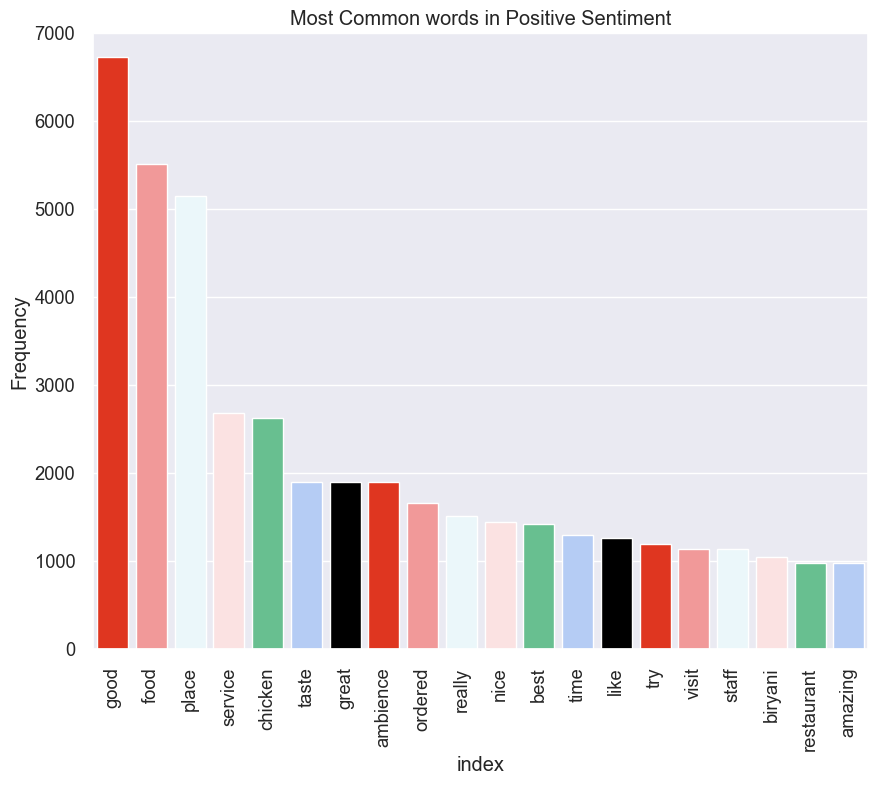

In [286]:
# Most Common words in Positive Sentiment
word_frequency(merged_df[merged_df['SIA_Sentiment'] == 'Positive'],0,7000,'Most Common words in Positive Sentiment',
             ['#FF1E00','#FF8B8B','#E8F9FD','#FFDEDE','#59CE8F','#ABC9FF','#000000'])
     


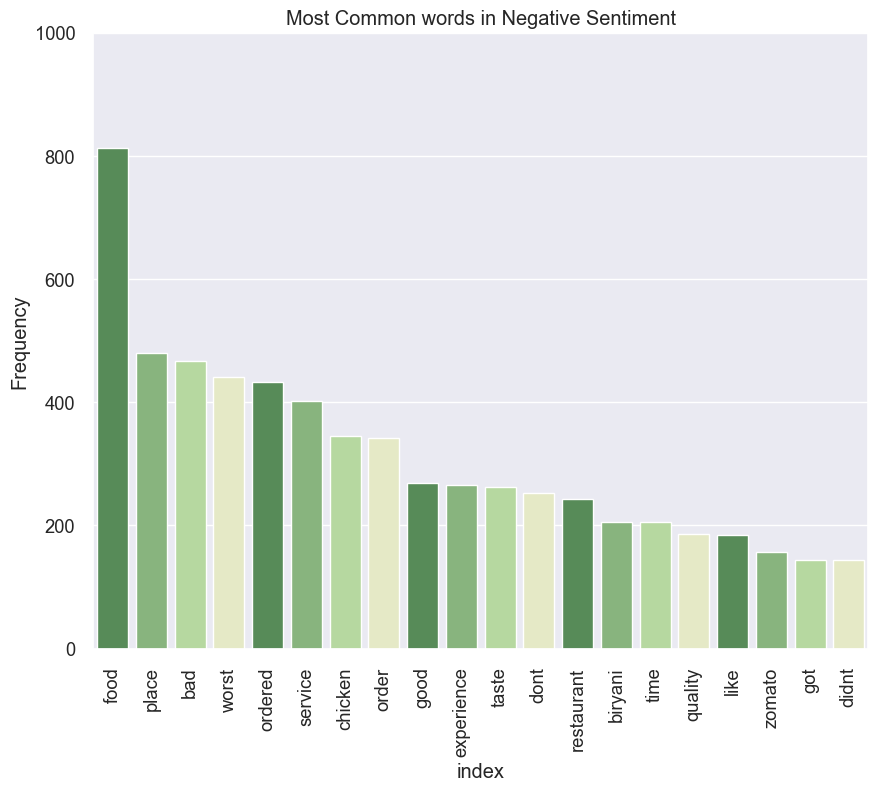

In [287]:
# Most Common words in Negative Sentiment
word_frequency(merged_df[merged_df['SIA_Sentiment'] == 'Negative'],0,1000,'Most Common words in Negative Sentiment',
             ['#4E944F','#83BD75','#B4E197','#E9EFC0'])
     

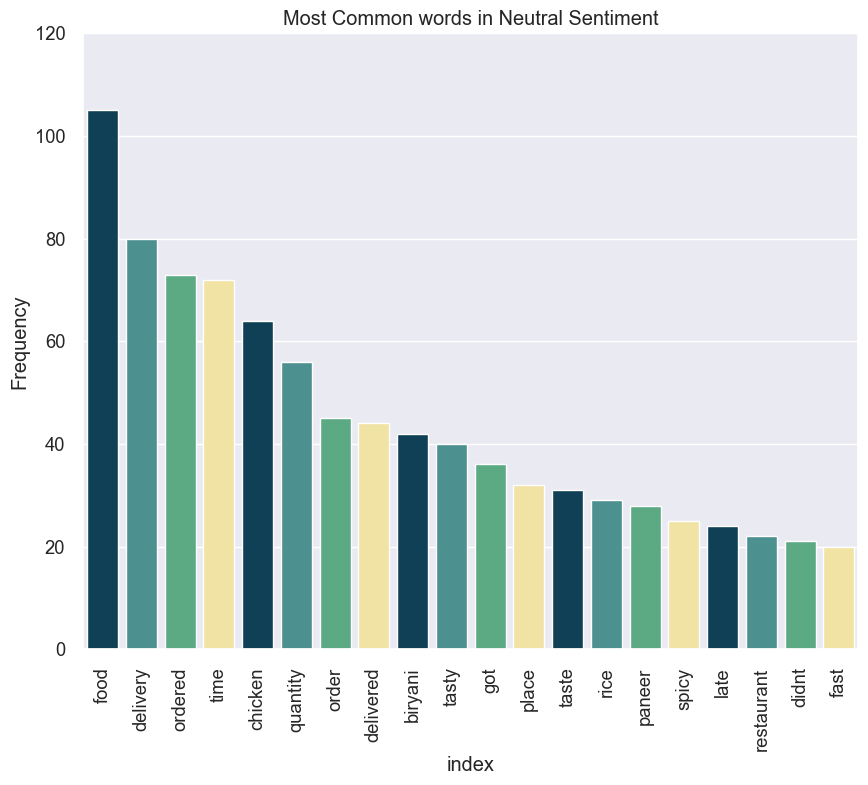

In [288]:
# Most Common words in Neutral Sentiment
word_frequency(merged_df[merged_df['SIA_Sentiment'] == 'Neutral'],0,120,'Most Common words in Neutral Sentiment',
             ['#034561','#409D9B','#4FB783','#FEEB97'])
     

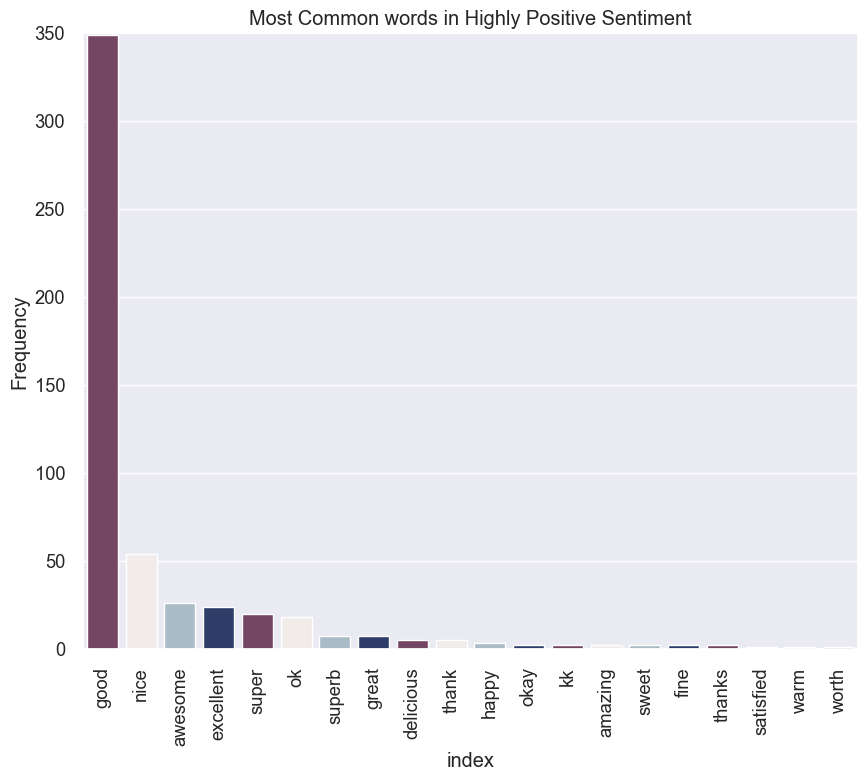

In [289]:
# Most Common words in Highly Positive Sentiment
word_frequency(merged_df[merged_df['SIA_Positive'] > 0.90],0,350,'Most Common words in Highly Positive Sentiment',
             ['#7C3E66','#F2EBE9','#A5BECC','#243A73'])

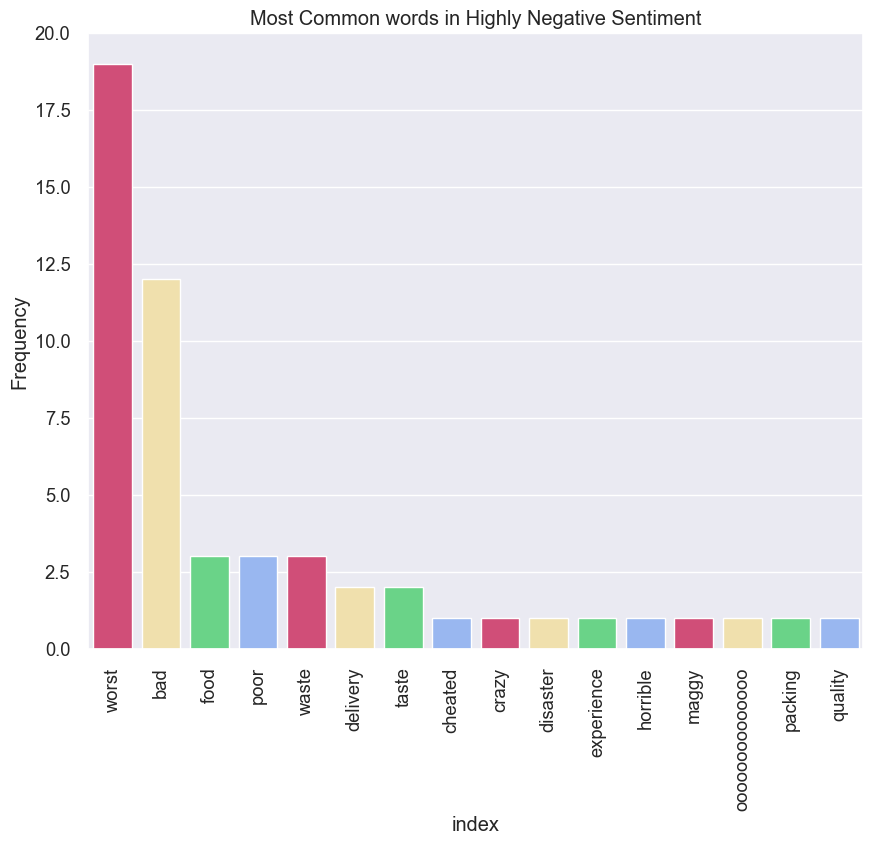

In [290]:

# Most Common words in Highly Negative Sentiment
word_frequency(merged_df[merged_df['SIA_Negative'] > 0.80],0,20,'Most Common words in Highly Negative Sentiment',
             ['#E63870','#FBE6A2','#58E481','#8AB2FF'])

In [291]:
# Restaurants with more number of positive reviews
rest_pos = pd.DataFrame(merged_df[merged_df['SIA_Sentiment'] == 'Positive'].groupby('Name')['index'].count()).reset_index()
rest_pos.sort_values(by = 'index',ascending = False,inplace = True)
rest_pos.rename({'index':'count'},axis = 1,inplace = True)

In [292]:

 # Plot
def restuarants(df,title,ylim1,ylim2,color):
  plt.figure(figsize = (14,6))
  plot = sns.barplot(data = df,x = 'Name',y = 'count',palette = color)
  plt.title(title)
  plt.xticks(rotation = 90)
  plot.set(ylim=(ylim1, ylim2))
  plt.show()
     


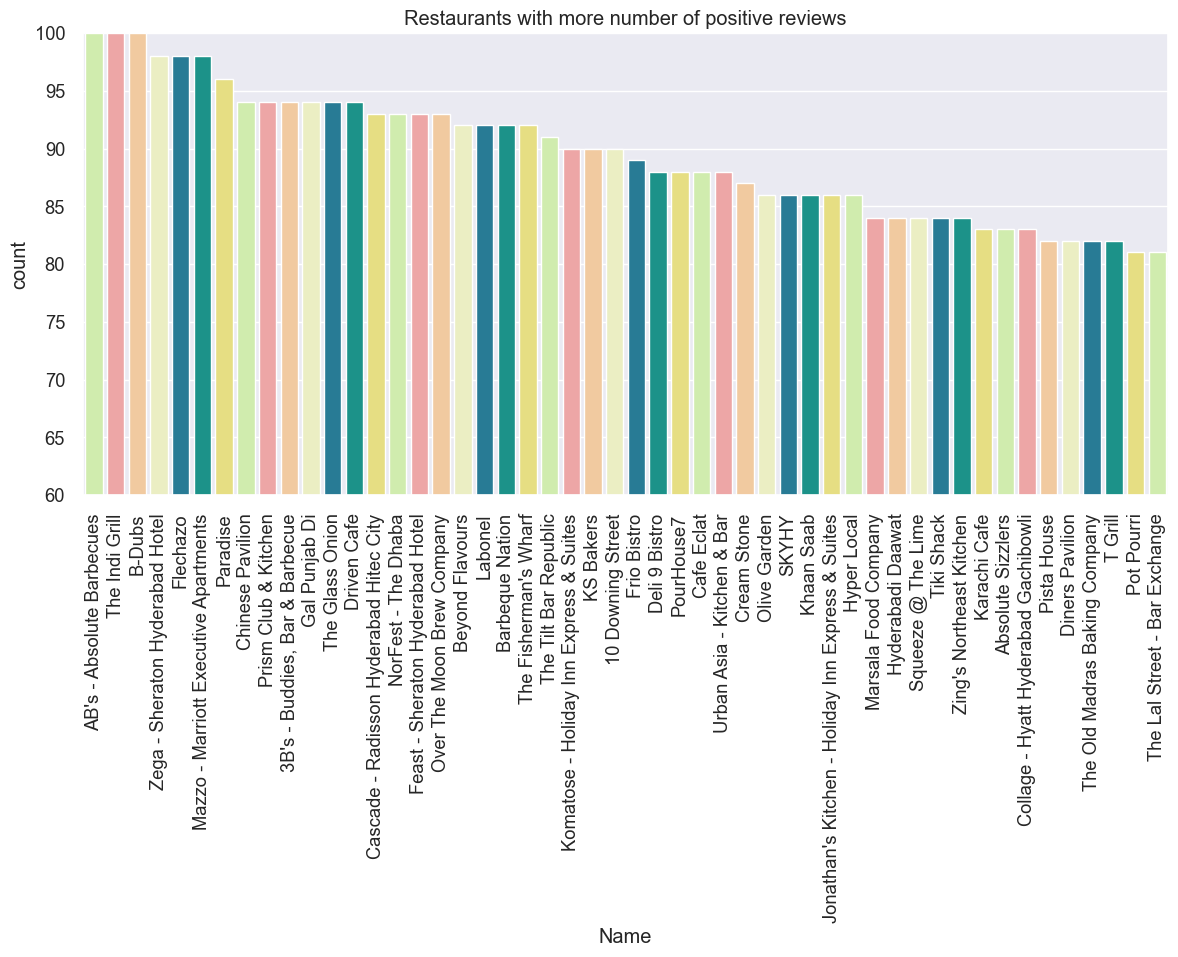

In [293]:
# Plotting the Restaurants with more number of positive reviews
restuarants(rest_pos.iloc[0:50],'Restaurants with more number of positive reviews',60,100,
            ['#D1F6A4','#F99A9A','#FECB92','#F1F5BC','#1684A7','#09A599','#F6EC72'])

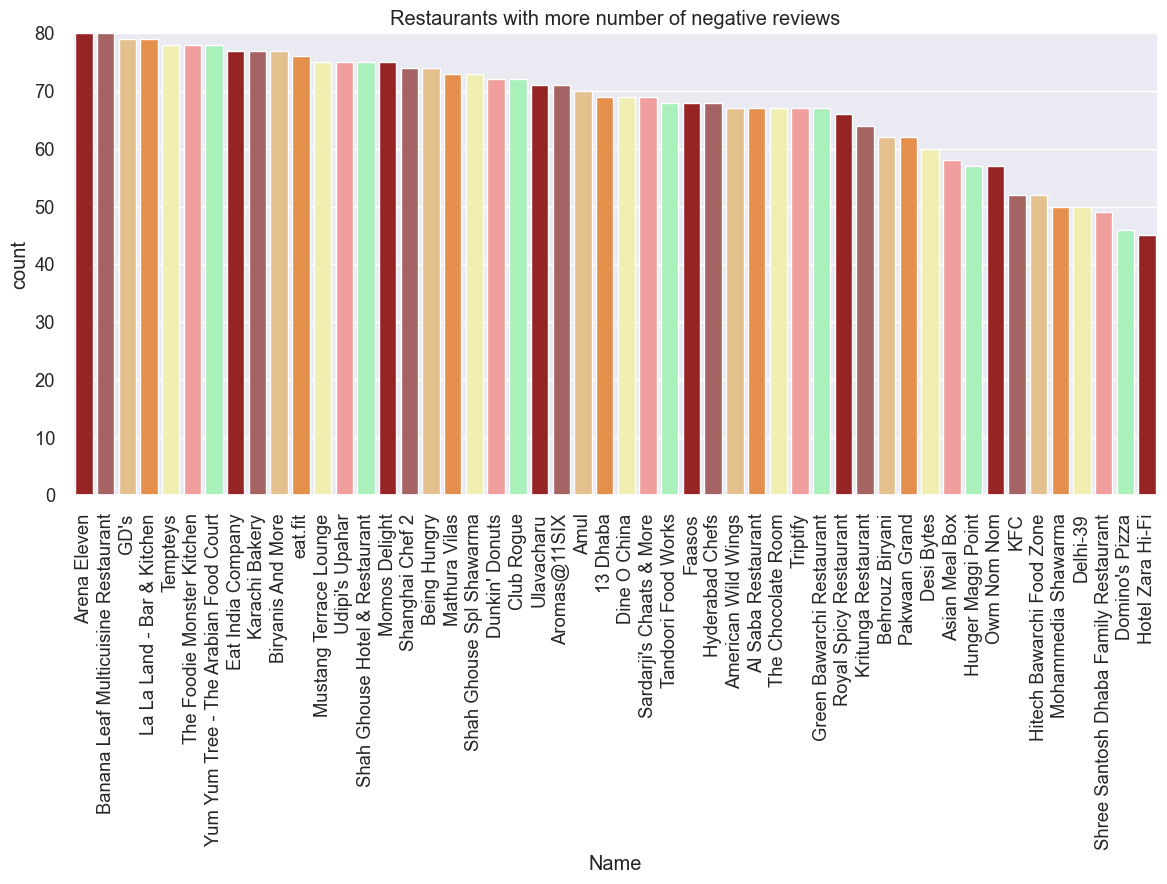

In [294]:
# Plotting the Restaurants with more number of negative reviews
restuarants(rest_pos.iloc[-50:],'Restaurants with more number of negative reviews',0,80,
            ['#AA1111','#B15858','#F2C280','#FF8C32','#FCF8A6','#FD9191','#9EFCB4'])
     

In [295]:
# Function for Restaurnts with best ratings
def restaurants_best(rating,ascending):
  temp = pd.DataFrame(merged_df.groupby('Name')['Cost','Rating'].mean()).reset_index()
  temp = temp[temp['Rating'] > rating]
  temp.sort_values(by = ['Cost','Rating'],ascending = ascending,inplace = True)
  return temp.head()

In [296]:
# Function for Restaurnts with worst ratings
def restaurants_worst(rating,ascending):
  temp = pd.DataFrame(merged_df.groupby('Name')['Cost','Rating'].mean()).reset_index()
  temp = temp[temp['Rating'] < rating]
  temp.sort_values(by = ['Cost','Rating'],ascending = ascending,inplace = True)
  return temp.head()
     

In [297]:
# Top 5 Affordable Restaurants with best ratings
restaurants_best(4,True)

Name    Cost  Rating
93                  Udipi's Upahar   500.0    4.03
62             NorFest - The Dhaba   550.0    4.03
16                 Beyond Flavours   800.0    4.28
67                        Paradise   800.0    4.70
2   3B's - Buddies, Bar & Barbecue  1100.0    4.76

In [298]:
# Top 5 Affordable Restaurants with worst ratings
restaurants_worst(2.9,True)
     

Name   Cost  Rating
10                         Asian Meal Box  200.0    2.58
41                       Hotel Zara Hi-Fi  400.0    2.40
66                          Pakwaan Grand  400.0    2.71
57                          Mathura Vilas  500.0    2.82
78  Shree Santosh Dhaba Family Restaurant  500.0    2.83

In [299]:
# Top 5 Expensive Restaurants with best ratings
restaurants_best(4,False)

Name    Cost  Rating
34         Feast - Sheraton Hyderabad Hotel  2500.0    4.22
19  Cascade - Radisson Hyderabad Hitec City  1800.0    4.26
97          Zega - Sheraton Hyderabad Hotel  1750.0    4.45
58    Mazzo - Marriott Executive Apartments  1700.0    4.19
11                                   B-Dubs  1600.0    4.81

In [300]:

# Top 5 Expensive Restaurants with worst ratings
restaurants_worst(3,False)

Name   Cost  Rating
21          Club Rogue  900.0   2.880
24            Delhi-39  600.0   2.975
83  The Chocolate Room  600.0   2.830
14     Behrouz Biryani  600.0   2.825
47                 KFC  500.0   2.850

TextBlob Model



In [301]:
# Applying TextBlob Model
merged_df['TextBlob_Polarity'] = merged_df['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
     

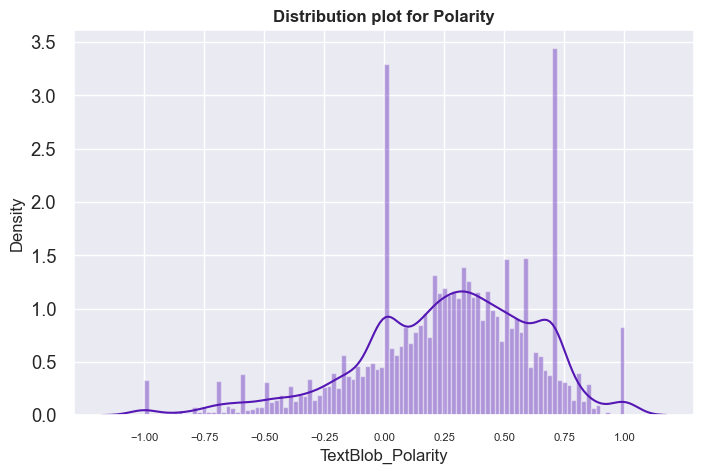

In [302]:
# SIA distribution plot
dist_polarity(merged_df['TextBlob_Polarity'],'TextBlob_Polarity','#5416B4')
     

In [303]:
# We can clearly see that most of the Reviews are 'Neutral' or 'Positive'


In [305]:
# Mapping the sentiment as Positive for SIA_Sentiment > 0
# Positive for TextBlob_Polarity > 0
# Negative for TextBlob_Polarity < 0
# Neutral for TextBlob_Polarity = 0
merged_df['TextBlob_Sentiment'] = merged_df['TextBlob_Polarity'].apply(lambda x: 'Positive' if (x > 0) else ('Negative' if (x<0) else 'Neutral'))


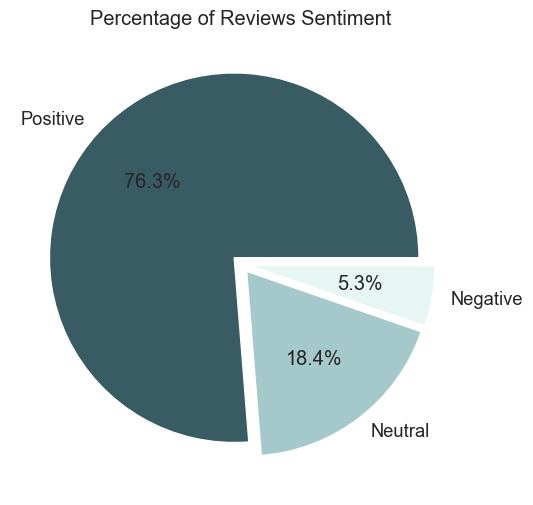

In [306]:
# Pie chart
piechart(merged_df['TextBlob_Sentiment'],colors = ['#395B64','#A5C9CA','#E7F6F2'])
     


In [307]:

# Reviews Sentiment
merged_df['TextBlob_Sentiment'].value_counts()
     

Positive    7591
Negative    1835
Neutral      528
Name: TextBlob_Sentiment, dtype: int64

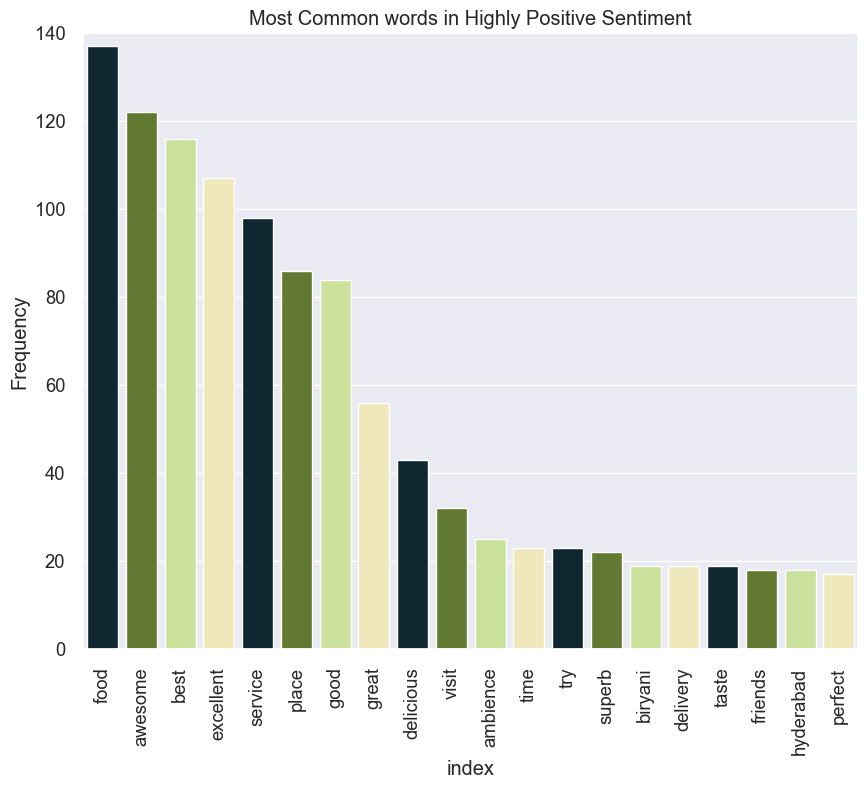

In [308]:

# Most Common words in Highly Positive Sentiment
word_frequency(merged_df[merged_df['TextBlob_Polarity'] > 0.80],0,140,'Most Common words in Highly Positive Sentiment',
             ['#092A35','#658525','#CFEE91','#F8EEB4'])

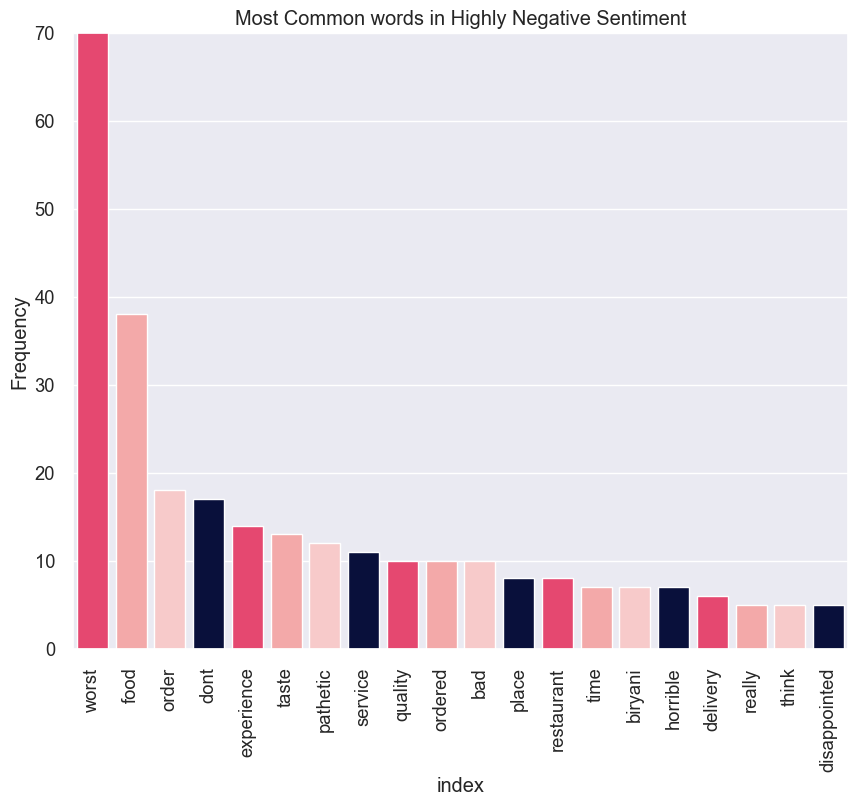

In [309]:
# Most Common words in Highly Negative Sentiment
word_frequency(merged_df[merged_df['TextBlob_Polarity'] < -0.80],0,70,'Most Common words in Highly Negative Sentiment',
             ['#FF2E63','#FF9D9D','#FFC2C2','#010A43'])

Model Comparison



In [310]:
model_com = pd.DataFrame((merged_df['TextBlob_Polarity'],merged_df['SIA_Compound'])).T.reset_index()


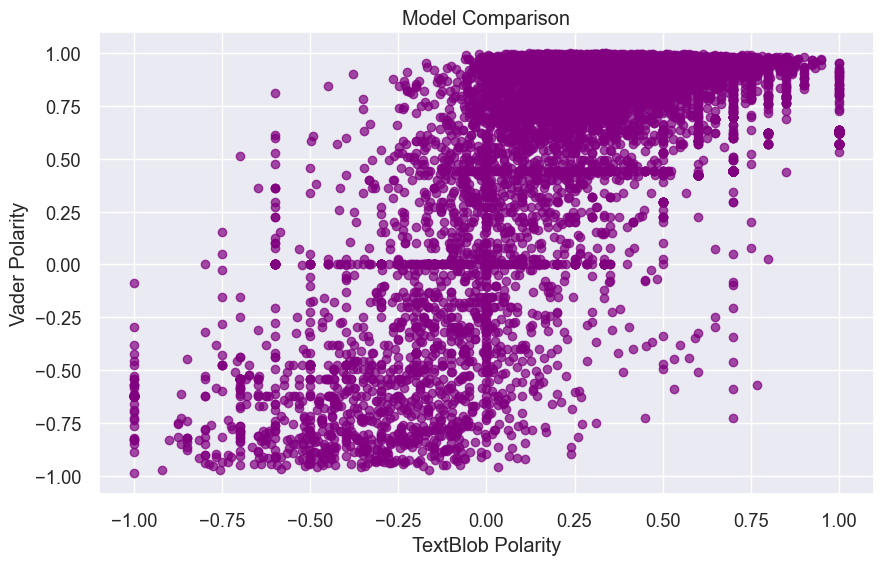

In [311]:
# Scatter plot for model comparison
plt.figure(figsize = (10,6))
plt.scatter(data = model_com, x = 'TextBlob_Polarity', y = 'SIA_Compound',color = 'purple',alpha = 0.7)
plt.title('Model Comparison')
plt.xlabel('TextBlob Polarity')
plt.ylabel('Vader Polarity')
plt.show()
     


onclusion

North Indian cuisine is most common cuisine found in the restaurants.
Collage - Hyatt Hyderabad Gachibowli is most expensive restaurant.
Amul and Mohammedia Shawarma are the most affordable restaurants.
The Restaurants are clustered on cuisines into 14 clusters by using KMeans clustering alogirthm with the Silhouette score of 0.195.
DBSCAN algorithm is used to cluster the restaurants into 14 clusters and also helps us to detect the outlier observations with the Silhouette score of 0.107
Anvesh Chowdary has given the more number of reviews
AB's - Absolute Barbecues is the top rated restaurant.
Almost 79 percent of the observations has positive sentiment and 14 and 7 percent of the observations has Neutral and Negative sentiments respectively.
Good is the most common word in the highly positive sentiment.
Worst is the most common word in the highly negative sentiment.
AB's - Absolute Barbecues, The Indi Grill and B- Dubes are the restaurants with more number of positive reviewes.
Arena Eleven and Banana Leaf Multicuisine are the restaurants with more number of negative reviewes.
Udipi - Upahar is the affordable restaurant with the best rating.
Feast - Sheraton Hyderabad Hotel is the expensive restaurant with the worst rating.
Asian Meal Box is the affordable restaurant with the worst rating.
Club Rogue is the expensive restaurant with the worst rating.